In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''
import cv2
from sklearn.model_selection import train_test_split
from sklearn import datasets
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from torch.backends import cudnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import torchvision as tv
from torch.utils.data import TensorDataset,DataLoader

import torchvision
import torchvision.datasets as Dataset
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm
import copy
import torchvision as tv
import cv2
from torch.utils.data import random_split
import pandas as pd
import os
from torch.utils.data import TensorDataset

import skimage.io as io
from tqdm import tqdm
from tensorboardX import SummaryWriter
from copy import deepcopy
import time

import sys

import torch
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.optim.sgd import SGD
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from PIL import Image
from collections import Counter
from sklearn.metrics import f1_score,precision_score,recall_score
class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier if multiplier > 1.0. if multiplier = 1.0, lr starts from 0 and ends up with the base_lr.
        total_epoch: target learning rate is reached at total_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """
 
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier < 1.:
            raise ValueError('multiplier should be greater thant or equal to 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)
 
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_last_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
 
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
 
    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)
 
    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
                self._last_lr = self.after_scheduler.get_last_lr()
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)


In [2]:
import torchvision.models as models

In [3]:
!pip install thop

In [4]:
from torchvision.models import resnet50
from thop import profile
model = resnet50()
input = torch.randn(1, 3, 224, 224)


In [5]:
features = models.mobilenet_v2().features
base_flops, base_params = profile(features, inputs=(input, ))
print(base_flops, base_params)
for i in range(1,20):
    print(-i,features[:-i](torch.randn(1,3,224,224)).shape)
    flops, params = profile(features[:-i], inputs=(input, ))
    print(flops/base_flops, params/base_params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
326206720.0 2223872.0
-1 torch.Size([1, 320, 7, 7])
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
0.9377042876369929 0.814665592264303
-2 torch.Size([1, 160, 7, 7])
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.R

In [6]:
camera1_train_ids = ['ID00'+str(i) for i in range(1,10)] + ['ID0'+str(i) for i in range(10,29)]
camera1_test_ids = ['ID00'+str(i) for i in range(1,4)]
camera2_train_ids = ['ID00'+str(i) for i in range(1,10)] + ['ID010']
camera2_test_ids = ['ID00'+str(i) for i in range(1,5)]
camera1_train_ids,camera1_test_ids,camera2_train_ids,camera2_test_ids

(['ID001',
  'ID002',
  'ID003',
  'ID004',
  'ID005',
  'ID006',
  'ID007',
  'ID008',
  'ID009',
  'ID010',
  'ID011',
  'ID012',
  'ID013',
  'ID014',
  'ID015',
  'ID016',
  'ID017',
  'ID018',
  'ID019',
  'ID020',
  'ID021',
  'ID022',
  'ID023',
  'ID024',
  'ID025',
  'ID026',
  'ID027',
  'ID028'],
 ['ID001', 'ID002', 'ID003'],
 ['ID001',
  'ID002',
  'ID003',
  'ID004',
  'ID005',
  'ID006',
  'ID007',
  'ID008',
  'ID009',
  'ID010'],
 ['ID001', 'ID002', 'ID003', 'ID004'])

In [7]:
globalpath1 = '../input/auc-v2-with-driver-id/v2_cam1_cam2_ split_by_driver/Camera 1'
globalpath2 = '../input/auc-v2-with-driver-id/v2_cam1_cam2_ split_by_driver/Camera 2'
filepath = ['/c0','/c1','/c2','/c3','/c4','/c5','/c6','/c7','/c8','/c9']

def getData(globalpath1,setname,ids,filepath,counter,tobefiltered=True):
    
    x = []
    y = []
    y2 = []
    for i,driverid in enumerate(ids):
        counter += 1
        idpath = globalpath1+'/'+setname+'/'+driverid
        for label,f in enumerate(filepath):
            if tobefiltered and driverid=='ID002' and label == 0:
                continue
            imgs = idpath+f
            for dirname, _, filenames in os.walk(imgs):

                for filename in filenames:
                    temppath = os.path.join(dirname, filename)
                    #im_o = cv2.imread(temppath)
                    #im_o = cv2.resize(im_o,(299,299))
                    
                    im_o = Image.open(temppath)
                    im_o = transforms.Resize([224,224])(im_o)
                    #print(sys.getsizeof(im_o))
                    #print(sys.getsizeof(np.array(im_o).tolist()))
                    #print('===')
                    #im_o = np.array(im_o).tolist()
                    
                    x.append(im_o)
                    y.append(label)
                    y2.append(counter)
    print(len(x),len(y))
    return x,y,y2,counter


counter = -1
trainx_1,trainy_1,trainy2_1,counter = getData(globalpath1,'train',camera1_train_ids,filepath,counter)
#trainx_2,trainy_2,trainy2_2,counter = getData(globalpath2,'train',camera2_train_ids,filepath,counter,False)

10555 10555


In [8]:
from collections import Counter
Counter(trainy2_1)#,Counter(trainy2_2)

Counter({8: 550,
         21: 531,
         10: 515,
         5: 461,
         15: 445,
         27: 431,
         19: 427,
         7: 420,
         14: 411,
         13: 400,
         6: 398,
         20: 392,
         25: 381,
         18: 367,
         2: 360,
         9: 358,
         12: 357,
         0: 354,
         23: 352,
         17: 346,
         22: 340,
         24: 326,
         3: 303,
         26: 287,
         4: 280,
         11: 269,
         1: 252,
         16: 242})

In [9]:
train_x = trainx_1# + trainx_2
train_y = trainy_1# + trainy_2
train_yid = trainy2_1# + trainy2_2
len_train_subs = 28
trainset = [[train_x[i],train_y[i],train_yid[i]] for i in range(len(train_x))]

In [10]:
globalpath1 = '../input/auc-distracted-driver-v2-train-valid-test/v2_cam1_cam2_ split_by_driver/Camera 1'
#globalpath2 = '../input/auc-distracted-driver-v2-train-valid-test/v2_cam1_cam2_ split_by_driver/Camera 2'
filepath = ['/c0','/c1','/c2','/c3','/c4','/c5','/c6','/c7','/c8','/c9']

def getData(globalpath1,setname,filepath):
    counter = 0
    x = []
    y = []
    for idx,f in enumerate(filepath):
        
        imgs = globalpath1+'/'+setname+f
        for dirname, _, filenames in os.walk(imgs):
            
            for filename in filenames:
                temppath = os.path.join(dirname, filename)
                im_o = Image.open(temppath)
                im_o = transforms.Resize([224,224])(im_o)
                x.append(im_o)
                y.append(idx)
    print(len(x),len(y))
    return x,y

testx1,testy1 = getData(globalpath1,'test',filepath)
#testx2,testy2 = getData(globalpath2,'test',filepath)

def getDataset(x1,y1,x2,y2):
    size = len(x1)
    outs = []
    for i in range(size):
        outs.append([x1[i],y1[i],0])
        
    '''size = len(x2)
    for i in range(size):
        outs.append([x2[i],y2[i],0])'''
    return outs
validset = getDataset(testx1,testy1,'testx2','testy2')

1123 1123


In [11]:
valid_len = len(validset)
train_len = len(trainset)
train_all = train_len

In [12]:
class MSFIN_teacher(nn.Module):
    def __init__(self):
        super(MSFIN_teacher,self).__init__()
        
        model = models.mobilenet_v2(pretrained=True)
        self.features = model.features
        self.fc = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=10, bias=True)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    def getGAP(self,f):
        return self.avgpool(f).squeeze(-1).squeeze(-1)
    def getCAM(self,y,f,w,bias):
        camlists = []
        
        for i in range(y.size(0)):
            idx = y[i]
            tempw = w[idx]
            tempf = f[i]
            tempbias = bias[idx]
            c,d,e = tempf.size()
            
            tempf = tempw.unsqueeze(1).unsqueeze(1) * tempf
            tempf = tempf.sum(0) + tempbias
            cam = tempf.reshape(-1)

            c,d = tempf.size()
            cam = tempf.reshape(-1)
            cam = (cam-cam.min())/(cam.max()-cam.min())
            cam = cam.reshape(d,e)
            camlists.append(cam)
        return torch.stack(camlists,0)
        
    def forward(self,x):
        f = self.features(x)
        avgf = self.getGAP(f)
        preds = self.fc(avgf)
        
        w = self.fc[1].weight
        b = self.fc[1].bias
        #print(f.shape,w.shape)
        cams = f.unsqueeze(1) * w.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        cams = cams.sum(2) + b.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

        return cams

In [13]:
class MSFIN(nn.Module):
    def __init__(self,teacher):
        super(MSFIN,self).__init__()
        
        self.teacher = teacher
        
        model = models.mobilenet_v2(pretrained=True)
        self.features = model.features[:-8]
        self.fc = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=64, out_features=10, bias=True)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    def getGAP(self,f):
        return self.avgpool(f).squeeze(-1).squeeze(-1)
    def getCAM(self,y,f,w,bias):
        camlists = []
        
        for i in range(y.size(0)):
            idx = y[i]
            tempw = w[idx]
            tempf = f[i]
            tempbias = bias[idx]
            c,d,e = tempf.size()
            
            tempf = tempw.unsqueeze(1).unsqueeze(1) * tempf
            tempf = tempf.sum(0) + tempbias
            cam = tempf.reshape(-1)

            c,d = tempf.size()
            cam = tempf.reshape(-1)
            cam = cam - cam.min().detach()
            cam = cam / cam.max().detach()
            #cam = (cam-cam.min())/(cam.max()-cam.min())
            cam = cam.reshape(d,e)
            camlists.append(cam)
        return torch.stack(camlists,0)
        
    def forward(self,x,y):
        
        f = self.features(x)
        avgf = self.getGAP(f)
        preds = self.fc(avgf)
        
        self.teacher.eval()
        cams_t = self.teacher(x).detach()
        
        
        w = self.fc[1].weight
        b = self.fc[1].bias
        cams = f.unsqueeze(1) * w.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        cams_s = cams.sum(2) + b.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

        a,b,c,d = cams_t.size()
        cams_t = cams_t.reshape(a*b,1,c,d)
        #print(cams_t.shape,cams_s.shape)
        #print(cams_t.shape)
        cams_t = F.interpolate(cams_t, size=(cams_s.size(2), cams_s.size(3)), mode='bilinear', align_corners=False)
        #print(cams_t.shape)
        cams_t = cams_t.squeeze(1)
        #print(cams_t.shape)
        cams_t = cams_t.reshape(a,b,cams_s.size(2), cams_s.size(3))
        
        #print(cams_s.shape,cams_t.shape)
        loss = nn.MSELoss()(cams_s,cams_t)
        return preds,loss

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 89.1MB/s]
  0%|          | 0/400 [00:00<?, ?it/s]

***训练集***
0.0525


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/400 [00:07<50:37,  7.61s/it]

valid-f1: 0.06729751172015866
valid-precision: 0.04625708724718626
valid-recall: 0.1302330827067669
process: 1  loss: 57.80280613899231  train_correct: 0.003979156797726196 valid_loss 82.45127654075623  val_correct: 0.25378450578806766
The model has been saved!!
The best val_acc is  0.25378450578806766
***训练集***
0.09


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 2/400 [00:14<46:13,  6.97s/it]

valid-f1: 0.03843364757070341
valid-precision: 0.023809523809523808
valid-recall: 0.09962406015037593
process: 2  loss: 57.54788017272949  train_correct: 0.006821411653244907 valid_loss 82.18211793899536  val_correct: 0.23597506678539626
***训练集***
0.10125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 3/400 [00:20<45:35,  6.89s/it]

valid-f1: 0.037685691946833466
valid-precision: 0.02379072063178677
valid-recall: 0.09060150375939849
process: 3  loss: 57.34142279624939  train_correct: 0.007674088109900521 valid_loss 81.99674725532532  val_correct: 0.21460373998219057
***训练集***
0.1625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/400 [00:27<43:58,  6.66s/it]

valid-f1: 0.05657134539924134
valid-precision: 0.03935995953767192
valid-recall: 0.10053383458646617
process: 4  loss: 56.805853843688965  train_correct: 0.01231643770724775 valid_loss 81.59796380996704  val_correct: 0.1834372217275156
***训练集***
0.1975


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▏         | 5/400 [00:33<43:16,  6.57s/it]

valid-f1: 0.09189041974259546
valid-precision: 0.12239959875650666
valid-recall: 0.12268134103374377
process: 5  loss: 56.58228898048401  train_correct: 0.014969208905731881 valid_loss 80.63436651229858  val_correct: 0.2404274265360641
***训练集***
0.23125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 6/400 [00:40<43:11,  6.58s/it]

valid-f1: 0.05933480887719088
valid-precision: 0.04253846153846154
valid-recall: 0.09828375286041188
process: 6  loss: 55.72124743461609  train_correct: 0.01752723827569872 valid_loss 79.65258860588074  val_correct: 0.18076580587711488
***训练集***
0.26375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 7/400 [00:46<43:06,  6.58s/it]

valid-f1: 0.08650397850555101
valid-precision: 0.06259758331681042
valid-recall: 0.14773346409502014
process: 7  loss: 54.61799621582031  train_correct: 0.01999052581714827 valid_loss 77.93753945827484  val_correct: 0.2439893143365984
***训练集***
0.2875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 8/400 [00:53<42:56,  6.57s/it]

valid-f1: 0.12353627384396759
valid-precision: 0.14656987825464696
valid-recall: 0.1591569503468817
process: 8  loss: 52.99034261703491  train_correct: 0.02179062055897679 valid_loss 78.49478507041931  val_correct: 0.23864648263579696
***训练集***
0.27875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 9/400 [01:00<43:02,  6.60s/it]

valid-f1: 0.1603424624798793
valid-precision: 0.19212526883797604
valid-recall: 0.20228898993201053
process: 9  loss: 52.138955950737  train_correct: 0.021127427759355756 valid_loss 75.86314356327057  val_correct: 0.2840605520926091
The model has been saved!!
The best val_acc is  0.2840605520926091
***训练集***
0.3175


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▎         | 10/400 [01:06<43:00,  6.62s/it]

valid-f1: 0.19581858588691098
valid-precision: 0.22059870640431964
valid-recall: 0.23279103555991426
process: 10  loss: 50.0742484331131  train_correct: 0.024064424443391758 valid_loss 70.95739895105362  val_correct: 0.3107747105966162
The model has been saved!!
The best val_acc is  0.3107747105966162
***训练集***
0.3625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 11/400 [01:13<43:10,  6.66s/it]

valid-f1: 0.0627930245854774
valid-precision: 0.11085660070479804
valid-recall: 0.11266753841124551
process: 11  loss: 46.9984028339386  train_correct: 0.027475130270014213 valid_loss 73.94459545612335  val_correct: 0.25200356188780054
***训练集***
0.35125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 12/400 [01:20<43:14,  6.69s/it]

valid-f1: 0.3032668153091127
valid-precision: 0.3754697826610556
valid-recall: 0.3746623805891541
process: 12  loss: 46.41812825202942  train_correct: 0.026622453813358597 valid_loss 63.40320289134979  val_correct: 0.40516473731077474
The model has been saved!!
The best val_acc is  0.40516473731077474
***训练集***
0.41875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 13/400 [01:26<43:04,  6.68s/it]

valid-f1: 0.25611001006679945
valid-precision: 0.21066868454505877
valid-recall: 0.34776143256692454
process: 13  loss: 42.57160830497742  train_correct: 0.03173851255329228 valid_loss 61.233365684747696  val_correct: 0.42297417631344614
The model has been saved!!
The best val_acc is  0.42297417631344614
***训练集***
0.44875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▎         | 14/400 [01:33<42:58,  6.68s/it]

valid-f1: 0.3787232147792383
valid-precision: 0.4075859045638909
valid-recall: 0.41883912680251356
process: 14  loss: 40.83302903175354  train_correct: 0.034012316437707246 valid_loss 55.16722363233566  val_correct: 0.5173642030276047
The model has been saved!!
The best val_acc is  0.5173642030276047
***训练集***
0.49


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 15/400 [01:39<42:23,  6.61s/it]

valid-f1: 0.27990358625508394
valid-precision: 0.34142439138228664
valid-recall: 0.365233736515201
process: 15  loss: 38.213972330093384  train_correct: 0.03713879677877783 valid_loss 55.16454216837883  val_correct: 0.4479073909171861
***训练集***
0.47375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 16/400 [01:46<42:18,  6.61s/it]

valid-f1: 0.3200624528188131
valid-precision: 0.38872060953826054
valid-recall: 0.3882292688242345
process: 16  loss: 37.62383580207825  train_correct: 0.035907153008053055 valid_loss 53.18275128304958  val_correct: 0.47105966162065893
***训练集***
0.4925


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 17/400 [01:53<41:58,  6.58s/it]

valid-f1: 0.23974370359291397
valid-precision: 0.2621028061252041
valid-recall: 0.33787584904289714
process: 17  loss: 35.916582345962524  train_correct: 0.03732828043581241 valid_loss 62.997982412576675  val_correct: 0.40694568121104185
***训练集***
0.52125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 18/400 [01:59<41:40,  6.55s/it]

valid-f1: 0.39847099181467455
valid-precision: 0.4849724953031533
valid-recall: 0.4197185354691076
process: 18  loss: 34.15024137496948  train_correct: 0.03950734249171009 valid_loss 48.089824348688126  val_correct: 0.5164737310774711
***训练集***
0.55625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  5%|▍         | 19/400 [02:06<41:31,  6.54s/it]

valid-f1: 0.40994046677065354
valid-precision: 0.44076337648624564
valid-recall: 0.41825964780198194
process: 19  loss: 33.13487833738327  train_correct: 0.04216011369019422 valid_loss 44.594414085149765  val_correct: 0.5031166518254675
***训练集***
0.60125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  5%|▌         | 20/400 [02:12<41:28,  6.55s/it]

valid-f1: 0.2996139333476947
valid-precision: 0.46588873023427996
valid-recall: 0.35053820321554874
process: 20  loss: 30.459737300872803  train_correct: 0.04557081951681667 valid_loss 48.90376074612141  val_correct: 0.4603739982190561
***训练集***
0.56375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  5%|▌         | 21/400 [02:19<41:59,  6.65s/it]

valid-f1: 0.4408290268366025
valid-precision: 0.5554996561591582
valid-recall: 0.4605089469391529
process: 21  loss: 31.32197457551956  train_correct: 0.042728564661297964 valid_loss 42.609653413295746  val_correct: 0.5369545859305432
The model has been saved!!
The best val_acc is  0.5369545859305432
***训练集***
0.62375


  6%|▌         | 22/400 [02:26<42:08,  6.69s/it]

valid-f1: 0.5205178396606349
valid-precision: 0.6828997548166027
valid-recall: 0.5229861709609993
process: 22  loss: 27.91372060775757  train_correct: 0.047276172430127904 valid_loss 42.04629175364971  val_correct: 0.5672306322350846
The model has been saved!!
The best val_acc is  0.5672306322350846
***训练集***
0.65875


  6%|▌         | 23/400 [02:33<42:04,  6.70s/it]

valid-f1: 0.3722032224745227
valid-precision: 0.604498882086585
valid-recall: 0.4610164409706744
process: 23  loss: 28.64600020647049  train_correct: 0.049928943628612034 valid_loss 53.68519639968872  val_correct: 0.39893143365983974
***训练集***
0.64875


  6%|▌         | 24/400 [02:39<42:06,  6.72s/it]

valid-f1: 0.6096764938022627
valid-precision: 0.6866310483120824
valid-recall: 0.6217155570084631
process: 24  loss: 27.05395793914795  train_correct: 0.049171009000473706 valid_loss 39.29686626791954  val_correct: 0.674087266251113
The model has been saved!!
The best val_acc is  0.674087266251113
***训练集***
0.66625


  6%|▋         | 25/400 [02:46<42:08,  6.74s/it]

valid-f1: 0.5782083106496383
valid-precision: 0.7019355767152707
valid-recall: 0.5783276768997594
process: 25  loss: 25.892121851444244  train_correct: 0.05049739459971577 valid_loss 39.74642015248537  val_correct: 0.5903829029385574
***训练集***
0.69875


  6%|▋         | 26/400 [02:53<41:47,  6.71s/it]

valid-f1: 0.6025351915700797
valid-precision: 0.679718478400868
valid-recall: 0.6317810732364507
process: 26  loss: 24.721506237983704  train_correct: 0.052960682141165324 valid_loss 34.890356957912445  val_correct: 0.6393588601959038
***训练集***
0.71125


  7%|▋         | 27/400 [02:59<41:45,  6.72s/it]

valid-f1: 0.742252204870698
valid-precision: 0.8001292077270957
valid-recall: 0.7484688830112171
process: 27  loss: 23.051645815372467  train_correct: 0.05390810042633823 valid_loss 31.75730536878109  val_correct: 0.7408726625111309
The model has been saved!!
The best val_acc is  0.7408726625111309
***训练集***
0.71875


  7%|▋         | 28/400 [03:06<41:42,  6.73s/it]

valid-f1: 0.5178344192337067
valid-precision: 0.6956313952675742
valid-recall: 0.5372757948890672
process: 28  loss: 22.823365449905396  train_correct: 0.05447655139744197 valid_loss 47.8427627235651  val_correct: 0.5405164737310775
***训练集***
0.75


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  7%|▋         | 29/400 [03:13<41:36,  6.73s/it]

valid-f1: 0.4043019374441378
valid-precision: 0.6192744385921615
valid-recall: 0.496087451831159
process: 29  loss: 20.905619740486145  train_correct: 0.05684509711037423 valid_loss 57.884452506899834  val_correct: 0.43098842386464825
***训练集***
0.725


  8%|▊         | 30/400 [03:20<41:26,  6.72s/it]

valid-f1: 0.7319987308080153
valid-precision: 0.7999669877705211
valid-recall: 0.7657368553135143
process: 30  loss: 21.889122307300568  train_correct: 0.054950260540028426 valid_loss 35.3882220685482  val_correct: 0.7221727515583259
***训练集***
0.75375


  8%|▊         | 31/400 [03:26<41:19,  6.72s/it]

valid-f1: 0.745317174986548
valid-precision: 0.758222059559665
valid-recall: 0.7781591561248311
process: 31  loss: 21.198834717273712  train_correct: 0.0571293225959261 valid_loss 30.981169015169144  val_correct: 0.748886910062333
The model has been saved!!
The best val_acc is  0.748886910062333
***训练集***
0.70375


  8%|▊         | 32/400 [03:33<41:07,  6.70s/it]

valid-f1: 0.6567061975972963
valid-precision: 0.7050786035260136
valid-recall: 0.6931567687334278
process: 32  loss: 22.091042041778564  train_correct: 0.053339649455234485 valid_loss 39.91994106769562  val_correct: 0.634906500445236
***训练集***
0.7775


  8%|▊         | 33/400 [03:40<40:49,  6.67s/it]

valid-f1: 0.665600047916992
valid-precision: 0.7583911873212882
valid-recall: 0.6991394395078605
process: 33  loss: 19.226725608110428  train_correct: 0.05892941733775462 valid_loss 35.135402008891106  val_correct: 0.6571682991985752
***训练集***
0.7925


  8%|▊         | 34/400 [03:46<40:35,  6.65s/it]

valid-f1: 0.6887772886642496
valid-precision: 0.7574158332081791
valid-recall: 0.6932162289782428
process: 34  loss: 18.458485513925552  train_correct: 0.0600663192799621 valid_loss 33.24498152732849  val_correct: 0.6767586821015138
***训练集***
0.7625


  9%|▉         | 35/400 [03:53<40:43,  6.69s/it]

valid-f1: 0.6843845638382094
valid-precision: 0.6989380563713509
valid-recall: 0.7344974755729903
process: 35  loss: 19.10836613178253  train_correct: 0.05779251539554713 valid_loss 32.25704909861088  val_correct: 0.6883348174532502
***训练集***
0.765


  9%|▉         | 36/400 [04:00<40:32,  6.68s/it]

valid-f1: 0.6779142476927241
valid-precision: 0.7620781707061729
valid-recall: 0.6795200814949098
process: 36  loss: 18.644792199134827  train_correct: 0.057981999052581716 valid_loss 34.84559766203165  val_correct: 0.649154051647373
***训练集***
0.7775


  9%|▉         | 37/400 [04:06<40:24,  6.68s/it]

valid-f1: 0.6752709373596208
valid-precision: 0.797865066205094
valid-recall: 0.733129989004131
process: 37  loss: 18.427279382944107  train_correct: 0.05892941733775462 valid_loss 39.08963766694069  val_correct: 0.6705253784505788
***训练集***
0.78625


 10%|▉         | 38/400 [04:13<40:17,  6.68s/it]

valid-f1: 0.7962542687521716
valid-precision: 0.8227901202695133
valid-recall: 0.7971703203991534
process: 38  loss: 17.836026161909103  train_correct: 0.05959261013737565 valid_loss 23.88347090780735  val_correct: 0.8058771148708815
The model has been saved!!
The best val_acc is  0.8058771148708815
***训练集***
0.76625


 10%|▉         | 39/400 [04:20<40:24,  6.72s/it]

valid-f1: 0.7526324219797548
valid-precision: 0.776308386062788
valid-recall: 0.7651219881059699
process: 39  loss: 18.206134527921677  train_correct: 0.05807674088109901 valid_loss 29.566120237112045  val_correct: 0.7346393588601959
***训练集***
0.78875


 10%|█         | 40/400 [04:26<40:00,  6.67s/it]

valid-f1: 0.7114948514624693
valid-precision: 0.7668852309290234
valid-recall: 0.7387207412470571
process: 40  loss: 17.250963270664215  train_correct: 0.05978209379441023 valid_loss 31.612601563334465  val_correct: 0.711487088156723
***训练集***
0.785


 10%|█         | 41/400 [04:33<39:48,  6.65s/it]

valid-f1: 0.7552510304544768
valid-precision: 0.7765419355720891
valid-recall: 0.7847913855785709
process: 41  loss: 16.347761690616608  train_correct: 0.05949786830885836 valid_loss 24.236527778208256  val_correct: 0.7515583259127337
***训练集***
0.78125


 10%|█         | 42/400 [04:40<39:41,  6.65s/it]

valid-f1: 0.663270534139961
valid-precision: 0.7429649785676853
valid-recall: 0.6746793664001902
process: 42  loss: 17.65353226661682  train_correct: 0.05921364282330649 valid_loss 32.83389514684677  val_correct: 0.659839715048976
***训练集***
0.775


 11%|█         | 43/400 [04:46<39:33,  6.65s/it]

valid-f1: 0.7511243802674769
valid-precision: 0.7800192893582786
valid-recall: 0.7733365000115572
process: 43  loss: 17.256480932235718  train_correct: 0.05873993368072004 valid_loss 27.360565908253193  val_correct: 0.7346393588601959
***训练集***
0.795


 11%|█         | 44/400 [04:53<39:33,  6.67s/it]

valid-f1: 0.8101640111360136
valid-precision: 0.8089368280813203
valid-recall: 0.8349724773065734
process: 44  loss: 16.157190650701523  train_correct: 0.060255802936996686 valid_loss 21.97999954968691  val_correct: 0.8156723063223509
The model has been saved!!
The best val_acc is  0.8156723063223509
***训练集***
0.8025


 11%|█▏        | 45/400 [05:00<39:22,  6.65s/it]

valid-f1: 0.805033760931879
valid-precision: 0.8205235962693495
valid-recall: 0.8183453033109783
process: 45  loss: 15.6355220079422  train_correct: 0.06082425390810042 valid_loss 22.982921812683344  val_correct: 0.804986642920748
***训练集***
0.815


 12%|█▏        | 46/400 [05:06<39:20,  6.67s/it]

valid-f1: 0.7116387425429933
valid-precision: 0.7513073247097741
valid-recall: 0.7182144458643315
process: 46  loss: 16.035193473100662  train_correct: 0.06177167219327333 valid_loss 32.81071526184678  val_correct: 0.6874443455031166
***训练集***
0.82625


 12%|█▏        | 47/400 [05:13<39:07,  6.65s/it]

valid-f1: 0.7027052614501401
valid-precision: 0.7555312265297311
valid-recall: 0.7319501487579291
process: 47  loss: 13.998465552926064  train_correct: 0.06262434864992894 valid_loss 32.68331800028682  val_correct: 0.686553873552983
***训练集***
0.8175


 12%|█▏        | 48/400 [05:20<38:50,  6.62s/it]

valid-f1: 0.6864465854018322
valid-precision: 0.776166825423965
valid-recall: 0.7058852368074335
process: 48  loss: 14.514513611793518  train_correct: 0.06196115585030791 valid_loss 33.74675436317921  val_correct: 0.6954585930543188
***训练集***
0.81375


 12%|█▏        | 49/400 [05:26<38:50,  6.64s/it]

valid-f1: 0.7324938873583469
valid-precision: 0.7758864710489739
valid-recall: 0.7276885329265191
process: 49  loss: 14.77941307425499  train_correct: 0.06167693036475604 valid_loss 22.11585484817624  val_correct: 0.7560106856634016
***训练集***
0.825


 12%|█▎        | 50/400 [05:33<38:43,  6.64s/it]

valid-f1: 0.734988132117687
valid-precision: 0.7970576474921758
valid-recall: 0.7559141958981777
process: 50  loss: 13.576287150382996  train_correct: 0.06252960682141165 valid_loss 26.847898472100496  val_correct: 0.7203918076580588
***训练集***
0.8125


 13%|█▎        | 51/400 [05:39<38:31,  6.62s/it]

valid-f1: 0.7128178624826853
valid-precision: 0.7986271337223795
valid-recall: 0.7491795661749896
process: 51  loss: 15.240607529878616  train_correct: 0.06158218853623875 valid_loss 34.48430036008358  val_correct: 0.6901157613535174
***训练集***
0.79625


 13%|█▎        | 52/400 [05:46<38:07,  6.57s/it]

valid-f1: 0.7813646246852077
valid-precision: 0.8072596741437945
valid-recall: 0.7920977014340858
process: 52  loss: 15.812941640615463  train_correct: 0.06035054476551398 valid_loss 24.92023133393377  val_correct: 0.7818343722172751
***训练集***
0.80375


 13%|█▎        | 53/400 [05:52<37:51,  6.55s/it]

valid-f1: 0.690872331934792
valid-precision: 0.7698478111855805
valid-recall: 0.7332631347802974
process: 53  loss: 15.06046262383461  train_correct: 0.060918995736617715 valid_loss 35.87700528278947  val_correct: 0.699020480854853
***训练集***
0.81375


 14%|█▎        | 54/400 [05:59<37:51,  6.56s/it]

valid-f1: 0.6938916755379458
valid-precision: 0.8086968171786719
valid-recall: 0.7286079163653534
process: 54  loss: 15.024701029062271  train_correct: 0.06167693036475604 valid_loss 34.3102809228003  val_correct: 0.667853962600178
***训练集***
0.83


 14%|█▍        | 55/400 [06:06<37:42,  6.56s/it]

valid-f1: 0.7127501796847547
valid-precision: 0.758250600963058
valid-recall: 0.7254871203040538
process: 55  loss: 13.662615150213242  train_correct: 0.06290857413548082 valid_loss 32.70935385301709  val_correct: 0.7088156723063224
***训练集***
0.8225


 14%|█▍        | 56/400 [06:12<37:33,  6.55s/it]

valid-f1: 0.777448803428652
valid-precision: 0.8132175127811336
valid-recall: 0.7723590960272881
process: 56  loss: 14.630779534578323  train_correct: 0.06234012316437707 valid_loss 21.957837659865618  val_correct: 0.7934105075690115
***训练集***
0.82625


 14%|█▍        | 57/400 [06:19<37:30,  6.56s/it]

valid-f1: 0.7078395019037844
valid-precision: 0.7755386981368486
valid-recall: 0.7204816818066246
process: 57  loss: 13.13587972521782  train_correct: 0.06262434864992894 valid_loss 27.482383519411087  val_correct: 0.7382012466607302
***训练集***
0.8075


 14%|█▍        | 58/400 [06:25<37:32,  6.59s/it]

valid-f1: 0.7528963078531199
valid-precision: 0.7868797769690626
valid-recall: 0.7650924511542361
process: 58  loss: 13.787180572748184  train_correct: 0.06120322122216959 valid_loss 22.320055674761534  val_correct: 0.7604630454140695
***训练集***
0.8175


 15%|█▍        | 59/400 [06:32<37:16,  6.56s/it]

valid-f1: 0.737314975365803
valid-precision: 0.7828505480851753
valid-recall: 0.7706787621226979
process: 59  loss: 14.50532940030098  train_correct: 0.06196115585030791 valid_loss 28.194054044783115  val_correct: 0.7212822796081924
***训练集***
0.81375


 15%|█▌        | 60/400 [06:38<37:05,  6.54s/it]

valid-f1: 0.7441501415955065
valid-precision: 0.7795078351067882
valid-recall: 0.7777515627012195
process: 60  loss: 14.0638487637043  train_correct: 0.06167693036475604 valid_loss 31.476887168362737  val_correct: 0.7132680320569902
***训练集***
0.8425


 15%|█▌        | 61/400 [06:45<36:53,  6.53s/it]

valid-f1: 0.7972981846710501
valid-precision: 0.8212519052834832
valid-recall: 0.8268501292757586
process: 61  loss: 12.464517772197723  train_correct: 0.06385599242065372 valid_loss 25.25749696791172  val_correct: 0.7898486197684773
***训练集***
0.83875


 16%|█▌        | 62/400 [06:51<36:41,  6.51s/it]

valid-f1: 0.7918227039694646
valid-precision: 0.825936596521301
valid-recall: 0.8290134426976532
process: 62  loss: 12.669726431369781  train_correct: 0.06357176693510184 valid_loss 24.45938102900982  val_correct: 0.7853962600178095
***训练集***
0.815


 16%|█▌        | 63/400 [06:58<36:47,  6.55s/it]

valid-f1: 0.7933087629893164
valid-precision: 0.832384098430213
valid-recall: 0.7903079239600979
process: 63  loss: 14.394063293933868  train_correct: 0.06177167219327333 valid_loss 18.5027529373765  val_correct: 0.8076580587711487
***训练集***
0.825


 16%|█▌        | 64/400 [07:04<36:42,  6.56s/it]

valid-f1: 0.6730390234261598
valid-precision: 0.7587880706166503
valid-recall: 0.6977299044713232
process: 64  loss: 12.717789351940155  train_correct: 0.06252960682141165 valid_loss 38.85478639602661  val_correct: 0.6331255565449688
***训练集***
0.8375


 16%|█▋        | 65/400 [07:11<36:29,  6.54s/it]

valid-f1: 0.7692714380802702
valid-precision: 0.775941396946087
valid-recall: 0.8169400213313256
process: 65  loss: 12.870483189821243  train_correct: 0.06347702510658455 valid_loss 23.906494677066803  val_correct: 0.761353517364203
***训练集***
0.83125


 16%|█▋        | 66/400 [07:18<36:29,  6.55s/it]

valid-f1: 0.7757196733906444
valid-precision: 0.8129560707904464
valid-recall: 0.8202209311156679
process: 66  loss: 12.389614164829254  train_correct: 0.06300331596399811 valid_loss 23.822957661002874  val_correct: 0.7756010685663401
***训练集***
0.82875


 17%|█▋        | 67/400 [07:24<36:15,  6.53s/it]

valid-f1: 0.735597297027957
valid-precision: 0.7729328722643445
valid-recall: 0.7911343048002086
process: 67  loss: 13.442868009209633  train_correct: 0.06281383230696352 valid_loss 28.727786742150784  val_correct: 0.7284060552092609
***训练集***
0.835


 17%|█▋        | 68/400 [07:31<36:05,  6.52s/it]

valid-f1: 0.7065856111080326
valid-precision: 0.7459657042383918
valid-recall: 0.7506328700539227
process: 68  loss: 12.44497835636139  train_correct: 0.06328754144954997 valid_loss 28.410199478268623  val_correct: 0.7008014247551202
***训练集***
0.87125


 17%|█▋        | 69/400 [07:37<35:51,  6.50s/it]

valid-f1: 0.8012456044401629
valid-precision: 0.8254088691413077
valid-recall: 0.8285125428855407
process: 69  loss: 11.482944130897522  train_correct: 0.06603505447655139 valid_loss 24.708869914524257  val_correct: 0.792520035618878
***训练集***
0.83375


 18%|█▊        | 70/400 [07:43<35:40,  6.49s/it]

valid-f1: 0.7471023274790238
valid-precision: 0.794541160167453
valid-recall: 0.7657563374840263
process: 70  loss: 13.046891927719116  train_correct: 0.06319279962103269 valid_loss 27.748892160132527  val_correct: 0.7186108637577916
***训练集***
0.835


 18%|█▊        | 71/400 [07:50<35:31,  6.48s/it]

valid-f1: 0.7876642794193465
valid-precision: 0.789361567771595
valid-recall: 0.8190956079262717
process: 71  loss: 13.095195010304451  train_correct: 0.06328754144954997 valid_loss 25.9689002931118  val_correct: 0.7693677649154052
***训练集***
0.83875


 18%|█▊        | 72/400 [07:56<35:25,  6.48s/it]

valid-f1: 0.751366714699196
valid-precision: 0.7914887793943701
valid-recall: 0.77974919182013
process: 72  loss: 12.622371703386307  train_correct: 0.06357176693510184 valid_loss 30.056847408413887  val_correct: 0.7462154942119323
***训练集***
0.84375


 18%|█▊        | 73/400 [08:03<35:25,  6.50s/it]

valid-f1: 0.7975646859441315
valid-precision: 0.8060005947926966
valid-recall: 0.8298768066411087
process: 73  loss: 11.642696470022202  train_correct: 0.06395073424917101 valid_loss 23.819380460307002  val_correct: 0.7943009795191451
***训练集***
0.8475


 18%|█▊        | 74/400 [08:09<35:15,  6.49s/it]

valid-f1: 0.7986939201594176
valid-precision: 0.8062311641442863
valid-recall: 0.8108365313811537
process: 74  loss: 11.934389919042587  train_correct: 0.06423495973472287 valid_loss 23.324104899540544  val_correct: 0.7916295636687445
***训练集***
0.85


 19%|█▉        | 75/400 [08:16<35:08,  6.49s/it]

valid-f1: 0.8080513922048587
valid-precision: 0.8182724136352583
valid-recall: 0.8230945545682389
process: 75  loss: 12.206339061260223  train_correct: 0.06442444339175746 valid_loss 19.690236501395702  val_correct: 0.8130008904719501
***训练集***
0.84875


 19%|█▉        | 76/400 [08:22<35:00,  6.48s/it]

valid-f1: 0.8010224180912336
valid-precision: 0.840469535167115
valid-recall: 0.8396112151260893
process: 76  loss: 11.276892825961113  train_correct: 0.06432970156324017 valid_loss 26.697450693696737  val_correct: 0.7711487088156723
***训练集***
0.855


 19%|█▉        | 77/400 [08:29<34:50,  6.47s/it]

valid-f1: 0.7980218091991708
valid-precision: 0.7946307217723569
valid-recall: 0.8135283993910996
process: 77  loss: 11.71273060142994  train_correct: 0.06480341070582663 valid_loss 21.97300123493187  val_correct: 0.7934105075690115
***训练集***
0.8575


 20%|█▉        | 78/400 [08:35<34:55,  6.51s/it]

valid-f1: 0.7789158010668302
valid-precision: 0.8050205363153944
valid-recall: 0.8060215690742007
process: 78  loss: 12.193661510944366  train_correct: 0.06499289436286121 valid_loss 23.2125828480348  val_correct: 0.7773820124666073
***训练集***
0.84375
开始蒸馏


 20%|█▉        | 79/400 [08:42<34:45,  6.50s/it]

valid-f1: 0.7271811330798472
valid-precision: 0.7936305488354941
valid-recall: 0.7369688021106786
process: 79  loss: 12.573464751243591  train_correct: 0.06395073424917101 valid_loss 36.05991589464247  val_correct: 0.6918967052537845
***训练集***
0.76


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|██        | 80/400 [08:48<34:38,  6.50s/it]

valid-f1: 0.522319328601618
valid-precision: 0.706578745816098
valid-recall: 0.5457799637433505
process: 80  loss: 399.10386085510254  train_correct: 0.057603031738512556 valid_loss 43.53328512655571  val_correct: 0.6170970614425646
***训练集***
0.755


 20%|██        | 81/400 [08:55<34:27,  6.48s/it]

valid-f1: 0.6849798048119037
valid-precision: 0.8001910958731848
valid-recall: 0.6800656780290648
process: 81  loss: 300.9538345336914  train_correct: 0.057224064424443395 valid_loss 23.926269927062094  val_correct: 0.723953695458593
***训练集***
0.7825


 20%|██        | 82/400 [09:01<34:30,  6.51s/it]

valid-f1: 0.7885956615442946
valid-precision: 0.8372971898320282
valid-recall: 0.7835631800185576
process: 82  loss: 253.28938388824463  train_correct: 0.05930838465182378 valid_loss 19.426873883698136  val_correct: 0.8210151380231523
The model has been saved!!
The best val_acc is  0.8210151380231523
***训练集***
0.815


 21%|██        | 83/400 [09:08<34:28,  6.52s/it]

valid-f1: 0.8357087745804014
valid-precision: 0.9144341469136572
valid-recall: 0.8089989202254649
process: 83  loss: 227.14713668823242  train_correct: 0.06177167219327333 valid_loss 16.54280346352607  val_correct: 0.8432769367764915
The model has been saved!!
The best val_acc is  0.8432769367764915
***训练集***
0.78625


 21%|██        | 84/400 [09:14<34:22,  6.53s/it]

valid-f1: 0.8669152232577065
valid-precision: 0.8937088652264753
valid-recall: 0.8549657311922759
process: 84  loss: 222.8021945953369  train_correct: 0.05959261013737565 valid_loss 14.549640611745417  val_correct: 0.8922528940338379
The model has been saved!!
The best val_acc is  0.8922528940338379
***训练集***
0.77625


 21%|██▏       | 85/400 [09:21<34:21,  6.54s/it]

valid-f1: 0.8913381264521189
valid-precision: 0.8898550570146131
valid-recall: 0.9013766630013771
process: 85  loss: 220.518620967865  train_correct: 0.05883467550923733 valid_loss 12.445195116102695  val_correct: 0.8984861976847729
The model has been saved!!
The best val_acc is  0.8984861976847729
***训练集***
0.78375


 22%|██▏       | 86/400 [09:28<34:18,  6.55s/it]

valid-f1: 0.8712670104764101
valid-precision: 0.8905250889478935
valid-recall: 0.8718886082135511
process: 86  loss: 202.03838205337524  train_correct: 0.05940312648034107 valid_loss 13.966367376968265  val_correct: 0.8788958147818343
***训练集***
0.79125


 22%|██▏       | 87/400 [09:34<34:21,  6.59s/it]

valid-f1: 0.8662594597631978
valid-precision: 0.8884026052177253
valid-recall: 0.8591293219874455
process: 87  loss: 187.142831325531  train_correct: 0.05997157745144481 valid_loss 14.458007846027613  val_correct: 0.8797862867319679
***训练集***
0.8075


 22%|██▏       | 88/400 [09:41<34:06,  6.56s/it]

valid-f1: 0.8570902173634174
valid-precision: 0.8934511561818754
valid-recall: 0.8492531163217661
process: 88  loss: 183.91946268081665  train_correct: 0.06120322122216959 valid_loss 15.021111296489835  val_correct: 0.8539626001780944
***训练集***
0.77625


 22%|██▏       | 89/400 [09:47<33:59,  6.56s/it]

valid-f1: 0.8842842316206942
valid-precision: 0.8828948183884003
valid-recall: 0.8940009113693325
process: 89  loss: 187.20100021362305  train_correct: 0.05883467550923733 valid_loss 12.991965597495437  val_correct: 0.8984861976847729
***训练集***
0.8125


 22%|██▎       | 90/400 [09:54<33:50,  6.55s/it]

valid-f1: 0.8529456944725988
valid-precision: 0.8735670479449096
valid-recall: 0.8584801628577372
process: 90  loss: 172.93375444412231  train_correct: 0.06158218853623875 valid_loss 17.62596768513322  val_correct: 0.8655387355298308
***训练集***
0.7925


 23%|██▎       | 91/400 [10:00<33:47,  6.56s/it]

valid-f1: 0.8385809194933603
valid-precision: 0.884323020449162
valid-recall: 0.8298825555324412
process: 91  loss: 183.65613746643066  train_correct: 0.0600663192799621 valid_loss 15.756105035543442  val_correct: 0.8432769367764915
***训练集***
0.8


 23%|██▎       | 92/400 [10:07<33:46,  6.58s/it]

valid-f1: 0.8957642090881015
valid-precision: 0.914658881268853
valid-recall: 0.8910706674459534
process: 92  loss: 175.29158926010132  train_correct: 0.060634770251065846 valid_loss 12.024504628032446  val_correct: 0.8975957257346393
***训练集***
0.81375


 23%|██▎       | 93/400 [10:14<33:35,  6.57s/it]

valid-f1: 0.842553768458845
valid-precision: 0.8533077606004227
valid-recall: 0.850265023560218
process: 93  loss: 165.97472524642944  train_correct: 0.06167693036475604 valid_loss 12.831171035766602  val_correct: 0.8646482635796973
***训练集***
0.80375


 24%|██▎       | 94/400 [10:20<33:26,  6.56s/it]

valid-f1: 0.8527145987535121
valid-precision: 0.9014001808825798
valid-recall: 0.8385280691848196
process: 94  loss: 162.8307580947876  train_correct: 0.060918995736617715 valid_loss 16.011163959279656  val_correct: 0.8388245770258237
***训练集***
0.82375


 24%|██▍       | 95/400 [10:27<33:27,  6.58s/it]

valid-f1: 0.8937623683191381
valid-precision: 0.9062664363669312
valid-recall: 0.8903476543796909
process: 95  loss: 160.96688556671143  train_correct: 0.062434864992894364 valid_loss 12.339938235469162  val_correct: 0.8940338379341051
***训练集***
0.80875


 24%|██▍       | 96/400 [10:34<33:44,  6.66s/it]

valid-f1: 0.8922497368502708
valid-precision: 0.8996660667744628
valid-recall: 0.8979521597141735
process: 96  loss: 158.6372833251953  train_correct: 0.061297963050686875 valid_loss 12.414614208042622  val_correct: 0.9011576135351737
The model has been saved!!
The best val_acc is  0.9011576135351737
***训练集***
0.8075


 24%|██▍       | 97/400 [10:40<33:41,  6.67s/it]

valid-f1: 0.8946291284266792
valid-precision: 0.9226402939587863
valid-recall: 0.8845187936904184
process: 97  loss: 164.88229417800903  train_correct: 0.06120322122216959 valid_loss 13.031233979389071  val_correct: 0.8886910062333037
***训练集***
0.80375


 24%|██▍       | 98/400 [10:47<33:30,  6.66s/it]

valid-f1: 0.9297345308940346
valid-precision: 0.93301191498789
valid-recall: 0.9295563282382504
process: 98  loss: 160.1462001800537  train_correct: 0.060918995736617715 valid_loss 10.886558498255908  val_correct: 0.9385574354407836
The model has been saved!!
The best val_acc is  0.9385574354407836
***训练集***
0.83


 25%|██▍       | 99/400 [10:54<33:18,  6.64s/it]

valid-f1: 0.924755423334273
valid-precision: 0.9252133339775819
valid-recall: 0.9314050937620731
process: 99  loss: 155.70000886917114  train_correct: 0.06290857413548082 valid_loss 10.898781381547451  val_correct: 0.92520035618878
***训练集***
0.845


 25%|██▌       | 100/400 [11:00<33:02,  6.61s/it]

valid-f1: 0.8851715414887632
valid-precision: 0.8853141632941522
valid-recall: 0.901759603224134
process: 100  loss: 155.8255262374878  train_correct: 0.0640454760776883 valid_loss 13.148214099928737  val_correct: 0.8922528940338379
***训练集***
0.82


 25%|██▌       | 101/400 [11:07<32:54,  6.60s/it]

valid-f1: 0.8679315221751093
valid-precision: 0.8828511254510815
valid-recall: 0.8710311846810702
process: 101  loss: 157.94193601608276  train_correct: 0.062150639507342495 valid_loss 13.27646328508854  val_correct: 0.8610863757791629
***训练集***
0.81875


 26%|██▌       | 102/400 [11:13<32:48,  6.60s/it]

valid-f1: 0.8825693723651055
valid-precision: 0.8958489144464126
valid-recall: 0.8801369695648871
process: 102  loss: 155.38672733306885  train_correct: 0.0620558976788252 valid_loss 10.87748597562313  val_correct: 0.8886910062333037
***训练集***
0.835


 26%|██▌       | 103/400 [11:20<32:33,  6.58s/it]

valid-f1: 0.8835568224858491
valid-precision: 0.8973664701782671
valid-recall: 0.8834060117355312
process: 103  loss: 146.61792087554932  train_correct: 0.06328754144954997 valid_loss 11.514811117202044  val_correct: 0.9047195013357079
***训练集***
0.82125


 26%|██▌       | 104/400 [11:26<32:19,  6.55s/it]

valid-f1: 0.9105836203506847
valid-precision: 0.9260551499985032
valid-recall: 0.9014030960140799
process: 104  loss: 147.23020935058594  train_correct: 0.06224538133585978 valid_loss 9.864540742710233  val_correct: 0.9171861086375779
***训练集***
0.82375


 26%|██▋       | 105/400 [11:33<32:15,  6.56s/it]

valid-f1: 0.8560642993745482
valid-precision: 0.8578674993376232
valid-recall: 0.8597436740731934
process: 105  loss: 149.52073431015015  train_correct: 0.062434864992894364 valid_loss 11.657915513962507  val_correct: 0.8708815672306323
***训练集***
0.8125


 26%|██▋       | 106/400 [11:40<32:25,  6.62s/it]

valid-f1: 0.9334150770753606
valid-precision: 0.9348576759016065
valid-recall: 0.9379979923458184
process: 106  loss: 141.6535358428955  train_correct: 0.06158218853623875 valid_loss 10.331094104796648  val_correct: 0.9403383793410508
The model has been saved!!
The best val_acc is  0.9403383793410508
***训练集***
0.8175


 27%|██▋       | 107/400 [11:46<32:19,  6.62s/it]

valid-f1: 0.8852214166876543
valid-precision: 0.8836308334336109
valid-recall: 0.8973496587318099
process: 107  loss: 141.96393585205078  train_correct: 0.06196115585030791 valid_loss 12.408826611936092  val_correct: 0.8860195903829029
***训练集***
0.84


 27%|██▋       | 108/400 [11:53<32:07,  6.60s/it]

valid-f1: 0.9239271188573819
valid-precision: 0.9227075127226492
valid-recall: 0.935014248400976
process: 108  loss: 140.65025281906128  train_correct: 0.06366650876361914 valid_loss 9.930203882977366  val_correct: 0.9278717720391808
***训练集***
0.8125


 27%|██▋       | 109/400 [11:59<32:01,  6.60s/it]

valid-f1: 0.8919266010517133
valid-precision: 0.8909936619771205
valid-recall: 0.89853401619992
process: 109  loss: 140.9984860420227  train_correct: 0.06158218853623875 valid_loss 11.29711732454598  val_correct: 0.9020480854853072
***训练集***
0.8275


 28%|██▊       | 110/400 [12:06<31:59,  6.62s/it]

valid-f1: 0.8828663543087014
valid-precision: 0.8964096784447575
valid-recall: 0.8848564296115784
process: 110  loss: 139.5535717010498  train_correct: 0.06271909047844623 valid_loss 11.882884298451245  val_correct: 0.8788958147818343
***训练集***
0.80125


 28%|██▊       | 111/400 [12:13<32:01,  6.65s/it]

valid-f1: 0.8867705772086477
valid-precision: 0.8955923646964091
valid-recall: 0.8951915922877021
process: 111  loss: 141.0762219429016  train_correct: 0.06072951207958314 valid_loss 12.643590569496155  val_correct: 0.8975957257346393
***训练集***
0.85375


 28%|██▊       | 112/400 [12:19<31:55,  6.65s/it]

valid-f1: 0.8904741245536985
valid-precision: 0.8978832680156532
valid-recall: 0.8957222139670652
process: 112  loss: 131.12259006500244  train_correct: 0.06470866887730933 valid_loss 11.42627789452672  val_correct: 0.8869100623330365
***训练集***
0.81125


 28%|██▊       | 113/400 [12:26<31:43,  6.63s/it]

valid-f1: 0.8948449695396526
valid-precision: 0.8952951230826546
valid-recall: 0.904276501530506
process: 113  loss: 135.35475635528564  train_correct: 0.06148744670772146 valid_loss 11.103913912549615  val_correct: 0.9029385574354408
***训练集***
0.8375


 28%|██▊       | 114/400 [12:33<31:40,  6.65s/it]

valid-f1: 0.8789758206759078
valid-precision: 0.8853265933405474
valid-recall: 0.8828718766613504
process: 114  loss: 139.11117362976074  train_correct: 0.06347702510658455 valid_loss 11.975988410413265  val_correct: 0.8842386464826358
***训练集***
0.845


 29%|██▉       | 115/400 [12:39<31:25,  6.62s/it]

valid-f1: 0.8767567392991685
valid-precision: 0.8941035605070011
valid-recall: 0.8752796219798509
process: 115  loss: 134.65261030197144  train_correct: 0.0640454760776883 valid_loss 12.2145123668015  val_correct: 0.8771148708815673
***训练集***
0.82375


 29%|██▉       | 116/400 [12:46<31:19,  6.62s/it]

valid-f1: 0.8738759113975186
valid-precision: 0.8965417400529011
valid-recall: 0.8660443995363905
process: 116  loss: 135.42095184326172  train_correct: 0.062434864992894364 valid_loss 12.434054412413388  val_correct: 0.8860195903829029
***训练集***
0.83375


 29%|██▉       | 117/400 [12:52<30:56,  6.56s/it]

valid-f1: 0.9192637840802729
valid-precision: 0.9229241859889641
valid-recall: 0.9290604640719057
process: 117  loss: 130.3153772354126  train_correct: 0.06319279962103269 valid_loss 10.762669679708779  val_correct: 0.9180765805877115
***训练集***
0.8525


 30%|██▉       | 118/400 [12:59<30:46,  6.55s/it]

valid-f1: 0.9003603478405291
valid-precision: 0.9100912355483649
valid-recall: 0.9068606958767141
process: 118  loss: 129.07698917388916  train_correct: 0.06461392704879204 valid_loss 10.742102154530585  val_correct: 0.9109528049866429
***训练集***
0.8425


 30%|██▉       | 119/400 [13:05<30:37,  6.54s/it]

valid-f1: 0.902762394696379
valid-precision: 0.9151129063160006
valid-recall: 0.9054510981009836
process: 119  loss: 131.80428743362427  train_correct: 0.06385599242065372 valid_loss 11.405232056044042  val_correct: 0.8975957257346393
***训练集***
0.8575


 30%|███       | 120/400 [13:12<30:31,  6.54s/it]

valid-f1: 0.9014634615292267
valid-precision: 0.9084291288435967
valid-recall: 0.9047473360608371
process: 120  loss: 136.17546033859253  train_correct: 0.06499289436286121 valid_loss 11.194658996537328  val_correct: 0.9162956366874443
***训练集***
0.83625


 30%|███       | 121/400 [13:18<30:29,  6.56s/it]

valid-f1: 0.9121300505623635
valid-precision: 0.9134488007716544
valid-recall: 0.9247095010252906
process: 121  loss: 131.3404574394226  train_correct: 0.06338228327806726 valid_loss 12.05463258177042  val_correct: 0.9136242208370436
***训练集***
0.83875


 30%|███       | 122/400 [13:25<30:15,  6.53s/it]

valid-f1: 0.887162984031084
valid-precision: 0.8922542690457075
valid-recall: 0.89176547429179
process: 122  loss: 126.47468376159668  train_correct: 0.06357176693510184 valid_loss 12.2136275973171  val_correct: 0.8940338379341051
***训练集***
0.825


 31%|███       | 123/400 [13:31<30:00,  6.50s/it]

valid-f1: 0.8837925868768354
valid-precision: 0.8896235930075941
valid-recall: 0.8896567472700196
process: 123  loss: 129.73323225975037  train_correct: 0.06252960682141165 valid_loss 12.076049381867051  val_correct: 0.8931433659839715
***训练集***
0.83375


 31%|███       | 124/400 [13:38<29:54,  6.50s/it]

valid-f1: 0.8809385053073546
valid-precision: 0.8828318795073532
valid-recall: 0.900311384521911
process: 124  loss: 125.92073917388916  train_correct: 0.06319279962103269 valid_loss 12.79156256094575  val_correct: 0.8753339269813001
***训练集***
0.82875


 31%|███▏      | 125/400 [13:45<30:00,  6.55s/it]

valid-f1: 0.8915377812761806
valid-precision: 0.9078281714326154
valid-recall: 0.8885204315135666
process: 125  loss: 125.83677434921265  train_correct: 0.06281383230696352 valid_loss 10.467825814150274  val_correct: 0.8993766696349065
***训练集***
0.83875


 32%|███▏      | 126/400 [13:51<29:43,  6.51s/it]

valid-f1: 0.8783284726732207
valid-precision: 0.8904271573705416
valid-recall: 0.8771262708814197
process: 126  loss: 130.14497709274292  train_correct: 0.06357176693510184 valid_loss 10.503671781159937  val_correct: 0.8878005342831701
***训练集***
0.8325


 32%|███▏      | 127/400 [13:57<29:32,  6.49s/it]

valid-f1: 0.901092795343709
valid-precision: 0.9216619617146546
valid-recall: 0.8957953084291758
process: 127  loss: 129.09936475753784  train_correct: 0.0630980577925154 valid_loss 10.425545420031995  val_correct: 0.9038290293855743
***训练集***
0.84


 32%|███▏      | 128/400 [14:04<29:21,  6.47s/it]

valid-f1: 0.9144040869731457
valid-precision: 0.9244162006781874
valid-recall: 0.9191569833675098
process: 128  loss: 132.34686517715454  train_correct: 0.06366650876361914 valid_loss 13.739377120509744  val_correct: 0.9207479964381122
***训练集***
0.82125


 32%|███▏      | 129/400 [14:10<29:11,  6.46s/it]

valid-f1: 0.9083703616632368
valid-precision: 0.9232206923480144
valid-recall: 0.9094926413530532
process: 129  loss: 126.18481779098511  train_correct: 0.06224538133585978 valid_loss 11.285532746464014  val_correct: 0.9056099732858415
***训练集***
0.8225


 32%|███▎      | 130/400 [14:17<29:19,  6.51s/it]

valid-f1: 0.9150645538893155
valid-precision: 0.9141878830368082
valid-recall: 0.922978321957727
process: 130  loss: 125.51884746551514  train_correct: 0.06234012316437707 valid_loss 10.26079804636538  val_correct: 0.9234194122885129
***训练集***
0.8225


 33%|███▎      | 131/400 [14:23<29:10,  6.51s/it]

valid-f1: 0.8713107331706167
valid-precision: 0.8849218085831609
valid-recall: 0.8711290148956052
process: 131  loss: 126.62869262695312  train_correct: 0.06234012316437707 valid_loss 11.62442947179079  val_correct: 0.8815672306322351
***训练集***
0.81


 33%|███▎      | 132/400 [14:30<28:54,  6.47s/it]

valid-f1: 0.9078887868595743
valid-precision: 0.9259859388614503
valid-recall: 0.9059014664460887
process: 132  loss: 121.58991861343384  train_correct: 0.06139270487920417 valid_loss 10.584717900492251  val_correct: 0.9118432769367765
***训练集***
0.84875


 33%|███▎      | 133/400 [14:36<28:44,  6.46s/it]

valid-f1: 0.8977867592254605
valid-precision: 0.9056852704097287
valid-recall: 0.9008191922493982
process: 133  loss: 123.99758052825928  train_correct: 0.06432970156324017 valid_loss 10.890459323301911  val_correct: 0.9011576135351737
***训练集***
0.825


 34%|███▎      | 134/400 [14:43<28:41,  6.47s/it]

valid-f1: 0.8996384929733956
valid-precision: 0.9129580702213136
valid-recall: 0.8996168913720399
process: 134  loss: 122.5369622707367  train_correct: 0.06252960682141165 valid_loss 10.363124375231564  val_correct: 0.9020480854853072
***训练集***
0.855


 34%|███▍      | 135/400 [14:49<28:55,  6.55s/it]

valid-f1: 0.8913039443561834
valid-precision: 0.9043103378115873
valid-recall: 0.8916661086180537
process: 135  loss: 124.54083299636841  train_correct: 0.06480341070582663 valid_loss 11.315699444618076  val_correct: 0.8851291184327693
***训练集***
0.83


 34%|███▍      | 136/400 [14:56<28:48,  6.55s/it]

valid-f1: 0.8953089521867492
valid-precision: 0.9047285673956071
valid-recall: 0.8991240750096585
process: 136  loss: 121.00611972808838  train_correct: 0.06290857413548082 valid_loss 13.88684350810945  val_correct: 0.9029385574354408
***训练集***
0.81125


 34%|███▍      | 137/400 [15:02<28:29,  6.50s/it]

valid-f1: 0.876309011698074
valid-precision: 0.886271558615453
valid-recall: 0.8771515316618291
process: 137  loss: 119.80720806121826  train_correct: 0.06148744670772146 valid_loss 11.195718557573855  val_correct: 0.8851291184327693
***训练集***
0.84


 34%|███▍      | 138/400 [15:09<28:25,  6.51s/it]

valid-f1: 0.8762475833768132
valid-precision: 0.898589962792815
valid-recall: 0.8791756598346987
process: 138  loss: 125.12898826599121  train_correct: 0.06366650876361914 valid_loss 12.569585799239576  val_correct: 0.8637577916295637
***训练集***
0.83125


 35%|███▍      | 139/400 [15:15<28:21,  6.52s/it]

valid-f1: 0.9062264683449832
valid-precision: 0.9104826644867728
valid-recall: 0.9181082713371043
process: 139  loss: 118.75115060806274  train_correct: 0.06300331596399811 valid_loss 12.189542005769908  val_correct: 0.9082813891362422
***训练集***
0.83375


 35%|███▌      | 140/400 [15:22<28:19,  6.54s/it]

valid-f1: 0.9045340856435764
valid-precision: 0.9153302201460984
valid-recall: 0.9103197090222261
process: 140  loss: 122.24474048614502  train_correct: 0.06319279962103269 valid_loss 12.416472763754427  val_correct: 0.8993766696349065
***训练集***
0.83625


 35%|███▌      | 141/400 [15:29<28:12,  6.53s/it]

valid-f1: 0.911001358463808
valid-precision: 0.9088359265483212
valid-recall: 0.9254106940605796
process: 141  loss: 116.32956075668335  train_correct: 0.06338228327806726 valid_loss 11.499742313753814  val_correct: 0.9109528049866429
***训练集***
0.8325


 36%|███▌      | 142/400 [15:35<28:03,  6.53s/it]

valid-f1: 0.8953145642176384
valid-precision: 0.907436797063623
valid-recall: 0.8962219646613239
process: 142  loss: 118.87303280830383  train_correct: 0.0630980577925154 valid_loss 10.575207683257759  val_correct: 0.9002671415850401
***训练集***
0.8325


 36%|███▌      | 143/400 [15:42<27:59,  6.54s/it]

valid-f1: 0.88121861720577
valid-precision: 0.902744253556045
valid-recall: 0.8736945856076291
process: 143  loss: 116.21898198127747  train_correct: 0.0630980577925154 valid_loss 11.107224216684699  val_correct: 0.8993766696349065
***训练集***
0.81875


 36%|███▌      | 144/400 [15:48<27:48,  6.52s/it]

valid-f1: 0.9062662690363288
valid-precision: 0.9256544895729153
valid-recall: 0.9048301286813872
process: 144  loss: 122.8915901184082  train_correct: 0.0620558976788252 valid_loss 11.214267610572278  val_correct: 0.9056099732858415
***训练集***
0.82875


 36%|███▋      | 145/400 [15:55<27:52,  6.56s/it]

valid-f1: 0.909128134715931
valid-precision: 0.9255961855779722
valid-recall: 0.9064559587374232
process: 145  loss: 115.6807804107666  train_correct: 0.06281383230696352 valid_loss 10.68453354621306  val_correct: 0.9180765805877115
***训练集***
0.8525


 36%|███▋      | 146/400 [16:01<27:40,  6.54s/it]

valid-f1: 0.874325909037218
valid-precision: 0.8994366454551951
valid-recall: 0.8753029015225812
process: 146  loss: 114.61624550819397  train_correct: 0.06461392704879204 valid_loss 13.438931612763554  val_correct: 0.8878005342831701
***训练集***
0.8425


 37%|███▋      | 147/400 [16:08<27:28,  6.52s/it]

valid-f1: 0.9248382901109169
valid-precision: 0.9351335455703707
valid-recall: 0.9266401841230216
process: 147  loss: 118.88014531135559  train_correct: 0.06385599242065372 valid_loss 12.730023555457592  val_correct: 0.9367764915405165
***训练集***
0.82


 37%|███▋      | 148/400 [16:14<27:22,  6.52s/it]

valid-f1: 0.9037302272800714
valid-precision: 0.9000782236906847
valid-recall: 0.9117880339848303
process: 148  loss: 121.99334526062012  train_correct: 0.062150639507342495 valid_loss 9.914996712235734  val_correct: 0.9154051647373108
***训练集***
0.8225


 37%|███▋      | 149/400 [16:21<27:14,  6.51s/it]

valid-f1: 0.8651126970584615
valid-precision: 0.8697460684231968
valid-recall: 0.8700721203535849
process: 149  loss: 118.55476641654968  train_correct: 0.06234012316437707 valid_loss 13.099382016342133  val_correct: 0.8664292074799644
***训练集***
0.84625


 38%|███▊      | 150/400 [16:27<27:07,  6.51s/it]

valid-f1: 0.8725008464601753
valid-precision: 0.8839520928118871
valid-recall: 0.8736769658005356
process: 150  loss: 114.63479399681091  train_correct: 0.0641402179062056 valid_loss 12.80321380821988  val_correct: 0.8788958147818343
***训练集***
0.84625


 38%|███▊      | 151/400 [16:34<26:54,  6.48s/it]

valid-f1: 0.8972019144355666
valid-precision: 0.9205574641420631
valid-recall: 0.8877311592551868
process: 151  loss: 114.84409618377686  train_correct: 0.0641402179062056 valid_loss 10.14680546009913  val_correct: 0.9154051647373108
***训练集***
0.8475


 38%|███▊      | 152/400 [16:40<26:43,  6.46s/it]

valid-f1: 0.9089758641948503
valid-precision: 0.9276766130307422
valid-recall: 0.9066323780465657
process: 152  loss: 118.0620903968811  train_correct: 0.06423495973472287 valid_loss 9.604134646244347  val_correct: 0.9118432769367765
***训练集***
0.81625


 38%|███▊      | 153/400 [16:47<26:38,  6.47s/it]

valid-f1: 0.8984328029181242
valid-precision: 0.909854317408038
valid-recall: 0.8981058278106332
process: 153  loss: 116.05603218078613  train_correct: 0.06186641402179062 valid_loss 10.049301076913252  val_correct: 0.8967052537845058
***训练集***
0.8375


 38%|███▊      | 154/400 [16:53<26:31,  6.47s/it]

valid-f1: 0.9086655310631585
valid-precision: 0.9296056837213443
valid-recall: 0.9049384528514963
process: 154  loss: 114.60738945007324  train_correct: 0.06347702510658455 valid_loss 9.934251811821014  val_correct: 0.9136242208370436
***训练集***
0.83


 39%|███▉      | 155/400 [17:00<26:27,  6.48s/it]

valid-f1: 0.8983350427365338
valid-precision: 0.929124180504262
valid-recall: 0.8840894495791523
process: 155  loss: 117.528817653656  train_correct: 0.06290857413548082 valid_loss 11.178214943734929  val_correct: 0.9029385574354408
***训练集***
0.85875


 39%|███▉      | 156/400 [17:06<26:39,  6.56s/it]

valid-f1: 0.9020932625513908
valid-precision: 0.9025407369905208
valid-recall: 0.9094747705891871
process: 156  loss: 115.08206176757812  train_correct: 0.06508763619137849 valid_loss 10.39323627576232  val_correct: 0.9047195013357079
***训练集***
0.84125


 39%|███▉      | 157/400 [17:13<26:45,  6.61s/it]

valid-f1: 0.9156622749607226
valid-precision: 0.923162505376262
valid-recall: 0.9157321795925915
process: 157  loss: 114.01394057273865  train_correct: 0.06376125059213643 valid_loss 11.764725816436112  val_correct: 0.9296527159394479
***训练集***
0.83125


 40%|███▉      | 158/400 [17:20<26:47,  6.64s/it]

valid-f1: 0.904420083828035
valid-precision: 0.9220615763546798
valid-recall: 0.9065775505958571
process: 158  loss: 113.88246989250183  train_correct: 0.06300331596399811 valid_loss 10.924662180244923  val_correct: 0.8993766696349065
***训练集***
0.84625


 40%|███▉      | 159/400 [17:27<26:56,  6.71s/it]

valid-f1: 0.9125152547379445
valid-precision: 0.9232608754938301
valid-recall: 0.9236525107234488
process: 159  loss: 113.28268122673035  train_correct: 0.0641402179062056 valid_loss 14.288958410732448  val_correct: 0.9038290293855743
***训练集***
0.84


 40%|████      | 160/400 [17:33<26:52,  6.72s/it]

valid-f1: 0.8799547397789637
valid-precision: 0.8903102949444414
valid-recall: 0.8858475437605872
process: 160  loss: 115.46405959129333  train_correct: 0.06366650876361914 valid_loss 12.275871503166854  val_correct: 0.8753339269813001
***训练集***
0.84875


 40%|████      | 161/400 [17:40<26:49,  6.74s/it]

valid-f1: 0.8989416851009198
valid-precision: 0.8967930020922763
valid-recall: 0.9080617155537063
process: 161  loss: 109.90005588531494  train_correct: 0.06432970156324017 valid_loss 9.970201396849006  val_correct: 0.9091718610863758
***训练集***
0.8325


 40%|████      | 162/400 [17:47<26:50,  6.77s/it]

valid-f1: 0.8979265291448609
valid-precision: 0.91114150822336
valid-recall: 0.898430744185893
process: 162  loss: 110.52810382843018  train_correct: 0.0630980577925154 valid_loss 11.203029830008745  val_correct: 0.9002671415850401
***训练集***
0.83125


 41%|████      | 163/400 [17:54<26:41,  6.76s/it]

valid-f1: 0.886596177983552
valid-precision: 0.9033248806002241
valid-recall: 0.8905499816735514
process: 163  loss: 113.70504832267761  train_correct: 0.06300331596399811 valid_loss 14.142244812101126  val_correct: 0.8797862867319679
***训练集***
0.84875


 41%|████      | 164/400 [18:01<26:45,  6.80s/it]

valid-f1: 0.9017733803211637
valid-precision: 0.9230730335639643
valid-recall: 0.9000117421353119
process: 164  loss: 114.83445954322815  train_correct: 0.06432970156324017 valid_loss 10.875783266033977  val_correct: 0.9047195013357079
***训练集***
0.8525


 41%|████▏     | 165/400 [18:07<26:40,  6.81s/it]

valid-f1: 0.8947315425373681
valid-precision: 0.9098854316747784
valid-recall: 0.8968387338570404
process: 165  loss: 110.02158999443054  train_correct: 0.06461392704879204 valid_loss 12.464806940406561  val_correct: 0.8931433659839715
***训练集***
0.83


 42%|████▏     | 166/400 [18:14<26:37,  6.83s/it]

valid-f1: 0.9199186378369694
valid-precision: 0.9236993396189892
valid-recall: 0.9302865199890371
process: 166  loss: 111.61519479751587  train_correct: 0.06290857413548082 valid_loss 11.76564184203744  val_correct: 0.9180765805877115
***训练集***
0.8375


 42%|████▏     | 167/400 [18:21<26:25,  6.80s/it]

valid-f1: 0.9101366259345361
valid-precision: 0.9140167790124665
valid-recall: 0.9227416367004467
process: 167  loss: 115.93902659416199  train_correct: 0.06347702510658455 valid_loss 12.444504323415458  val_correct: 0.9038290293855743
***训练集***
0.845


 42%|████▏     | 168/400 [18:28<26:22,  6.82s/it]

valid-f1: 0.880106370602674
valid-precision: 0.8810590608110495
valid-recall: 0.8903982915127079
process: 168  loss: 110.88289141654968  train_correct: 0.0640454760776883 valid_loss 12.203904386144131  val_correct: 0.8842386464826358
***训练集***
0.83


 42%|████▏     | 169/400 [18:35<26:11,  6.80s/it]

valid-f1: 0.9109852264977194
valid-precision: 0.9261230470685513
valid-recall: 0.9126825099639744
process: 169  loss: 113.2601809501648  train_correct: 0.06290857413548082 valid_loss 9.922372596338391  val_correct: 0.9073909171861086
***训练集***
0.845


 42%|████▎     | 170/400 [18:41<26:04,  6.80s/it]

valid-f1: 0.9285893695408698
valid-precision: 0.9282242029913771
valid-recall: 0.9366315987597453
process: 170  loss: 111.13714575767517  train_correct: 0.0640454760776883 valid_loss 9.518167956732213  val_correct: 0.9287622439893143
***训练集***
0.85875


 43%|████▎     | 171/400 [18:48<26:00,  6.81s/it]

valid-f1: 0.9289336441798879
valid-precision: 0.9322243130482717
valid-recall: 0.9375129193206997
process: 171  loss: 107.53920674324036  train_correct: 0.06508763619137849 valid_loss 9.323132838588208  val_correct: 0.931433659839715
***训练集***
0.8475


 43%|████▎     | 172/400 [18:55<25:48,  6.79s/it]

valid-f1: 0.889308818152862
valid-precision: 0.9057634597193417
valid-recall: 0.8835994994072797
process: 172  loss: 111.07114243507385  train_correct: 0.06423495973472287 valid_loss 10.299721144139767  val_correct: 0.9047195013357079
***训练集***
0.8325


 43%|████▎     | 173/400 [19:02<25:51,  6.84s/it]

valid-f1: 0.9125285959709813
valid-precision: 0.9171459157954761
valid-recall: 0.9210512348063835
process: 173  loss: 108.91828608512878  train_correct: 0.0630980577925154 valid_loss 12.696914531290531  val_correct: 0.9162956366874443
***训练集***
0.85


 44%|████▎     | 174/400 [19:09<25:42,  6.83s/it]

valid-f1: 0.9155829753839712
valid-precision: 0.9187249715646807
valid-recall: 0.9151020997817335
process: 174  loss: 109.47930383682251  train_correct: 0.06442444339175746 valid_loss 9.189790384843946  val_correct: 0.92520035618878
***训练集***
0.82625


 44%|████▍     | 175/400 [19:16<25:37,  6.83s/it]

valid-f1: 0.9219356970251438
valid-precision: 0.9283729846182464
valid-recall: 0.927693978028074
process: 175  loss: 113.80815100669861  train_correct: 0.06262434864992894 valid_loss 11.040699819335714  val_correct: 0.9234194122885129
***训练集***
0.84875


 44%|████▍     | 176/400 [19:23<25:33,  6.84s/it]

valid-f1: 0.9273713522879733
valid-precision: 0.9336701726257026
valid-recall: 0.9333789017999544
process: 176  loss: 106.12302303314209  train_correct: 0.06432970156324017 valid_loss 11.105087448842824  val_correct: 0.9323241317898486
***训练集***
0.8225


 44%|████▍     | 177/400 [19:29<25:24,  6.84s/it]

valid-f1: 0.92027321691394
valid-precision: 0.9240907413785331
valid-recall: 0.9244518047424226
process: 177  loss: 112.15191078186035  train_correct: 0.06234012316437707 valid_loss 10.635830690618604  val_correct: 0.9278717720391808
***训练集***
0.855


 44%|████▍     | 178/400 [19:36<25:13,  6.82s/it]

valid-f1: 0.9022433017014142
valid-precision: 0.9095787078389028
valid-recall: 0.8994602547211243
process: 178  loss: 109.74973058700562  train_correct: 0.06480341070582663 valid_loss 9.060495313256979  val_correct: 0.9082813891362422
***训练集***
0.845


 45%|████▍     | 179/400 [19:43<25:05,  6.81s/it]

valid-f1: 0.9038269915724427
valid-precision: 0.9259704685673015
valid-recall: 0.8950740916850757
process: 179  loss: 107.87280321121216  train_correct: 0.0640454760776883 valid_loss 9.157979198731482  val_correct: 0.9198575244879786
***训练集***
0.845


 45%|████▌     | 180/400 [19:50<24:54,  6.79s/it]

valid-f1: 0.874294435582868
valid-precision: 0.8861869739384476
valid-recall: 0.8792540342952242
process: 180  loss: 109.4753429889679  train_correct: 0.0640454760776883 valid_loss 11.088878033217043  val_correct: 0.8806767586821015
***训练集***
0.845


 45%|████▌     | 181/400 [19:56<24:20,  6.67s/it]

valid-f1: 0.9233878019611705
valid-precision: 0.928180659671385
valid-recall: 0.9268201762641122
process: 181  loss: 105.12668228149414  train_correct: 0.0640454760776883 valid_loss 9.829179007560015  val_correct: 0.9243098842386465
***训练集***
0.835


 46%|████▌     | 182/400 [20:02<23:59,  6.60s/it]

valid-f1: 0.94930417161811
valid-precision: 0.9576443820661984
valid-recall: 0.9466121562139869
process: 182  loss: 112.54668021202087  train_correct: 0.06328754144954997 valid_loss 8.278015051386319  val_correct: 0.9581478183437222
The model has been saved!!
The best val_acc is  0.9581478183437222
***训练集***
0.83625


 46%|████▌     | 183/400 [20:09<23:50,  6.59s/it]

valid-f1: 0.9159939374904317
valid-precision: 0.928861250057408
valid-recall: 0.9150788037286894
process: 183  loss: 112.15992546081543  train_correct: 0.06338228327806726 valid_loss 10.773618398234248  val_correct: 0.9225289403383793
***训练集***
0.86125


 46%|████▌     | 184/400 [20:16<23:47,  6.61s/it]

valid-f1: 0.8889553081973098
valid-precision: 0.8967692572754615
valid-recall: 0.8914889265324046
process: 184  loss: 110.21318125724792  train_correct: 0.06527711984841307 valid_loss 10.275330230593681  val_correct: 0.8940338379341051
***训练集***
0.85875


 46%|████▋     | 185/400 [20:22<23:35,  6.59s/it]

valid-f1: 0.9278125812731062
valid-precision: 0.9331141681980814
valid-recall: 0.929612086870668
process: 185  loss: 108.57364153862  train_correct: 0.06508763619137849 valid_loss 9.625145410187542  val_correct: 0.9341050756901158
***训练集***
0.85


 46%|████▋     | 186/400 [20:29<23:33,  6.60s/it]

valid-f1: 0.8758385100985052
valid-precision: 0.8865941331625213
valid-recall: 0.8734136758232868
process: 186  loss: 104.83648467063904  train_correct: 0.06442444339175746 valid_loss 10.283743302337825  val_correct: 0.8878005342831701
***训练集***
0.84375


 47%|████▋     | 187/400 [20:36<23:45,  6.69s/it]

valid-f1: 0.9044481030023783
valid-precision: 0.9183792458318599
valid-recall: 0.9062269771926521
process: 187  loss: 105.87500476837158  train_correct: 0.06395073424917101 valid_loss 10.758414172567427  val_correct: 0.9029385574354408
***训练集***
0.8625


 47%|████▋     | 188/400 [20:42<23:39,  6.70s/it]

valid-f1: 0.9307779762497919
valid-precision: 0.9346150818423737
valid-recall: 0.9386688394239882
process: 188  loss: 109.12282347679138  train_correct: 0.06537186167693036 valid_loss 10.475101138465106  val_correct: 0.9358860195903829
***训练集***
0.855


 47%|████▋     | 189/400 [20:49<23:35,  6.71s/it]

valid-f1: 0.9227638145408852
valid-precision: 0.9393334955734632
valid-recall: 0.9185561730412989
process: 189  loss: 107.20612668991089  train_correct: 0.06480341070582663 valid_loss 8.017682261997834  val_correct: 0.9296527159394479
***训练集***
0.8325


 48%|████▊     | 190/400 [20:56<23:32,  6.73s/it]

valid-f1: 0.9414527575308712
valid-precision: 0.9460848727919318
valid-recall: 0.9466669869667582
process: 190  loss: 105.96386194229126  train_correct: 0.0630980577925154 valid_loss 9.16725667892024  val_correct: 0.9483526268922529
***训练集***
0.84375


 48%|████▊     | 191/400 [21:03<23:22,  6.71s/it]

valid-f1: 0.9379046931978848
valid-precision: 0.9373271061758501
valid-recall: 0.9457858017903783
process: 191  loss: 104.50958633422852  train_correct: 0.06395073424917101 valid_loss 8.842902521137148  val_correct: 0.9367764915405165
***训练集***
0.83875


 48%|████▊     | 192/400 [21:09<23:21,  6.74s/it]

valid-f1: 0.923521386370148
valid-precision: 0.9271169959747546
valid-recall: 0.9339250629868479
process: 192  loss: 105.3753228187561  train_correct: 0.06357176693510184 valid_loss 9.808720926288515  val_correct: 0.9243098842386465
***训练集***
0.85625


 48%|████▊     | 193/400 [21:16<23:24,  6.78s/it]

valid-f1: 0.9623664373851835
valid-precision: 0.9672635818534749
valid-recall: 0.9594921526477591
process: 193  loss: 104.77259516716003  train_correct: 0.06489815253434392 valid_loss 8.060116230510175  val_correct: 0.9643811219946572
The model has been saved!!
The best val_acc is  0.9643811219946572
***训练集***
0.85375


 48%|████▊     | 194/400 [21:23<23:22,  6.81s/it]

valid-f1: 0.9358069369331947
valid-precision: 0.9375963703767478
valid-recall: 0.9425923471392579
process: 194  loss: 100.98702383041382  train_correct: 0.06470866887730933 valid_loss 9.138166705146432  val_correct: 0.93766696349065
***训练集***
0.84625


 49%|████▉     | 195/400 [21:30<23:14,  6.80s/it]

valid-f1: 0.9123716790976705
valid-precision: 0.9306146721572406
valid-recall: 0.910281652748472
process: 195  loss: 104.67740082740784  train_correct: 0.0641402179062056 valid_loss 9.264380189357325  val_correct: 0.9127337488869101
***训练集***
0.8375


 49%|████▉     | 196/400 [21:37<23:11,  6.82s/it]

valid-f1: 0.9254221588041753
valid-precision: 0.9285352709163739
valid-recall: 0.9341001020337405
process: 196  loss: 106.22424125671387  train_correct: 0.06347702510658455 valid_loss 10.14865804364672  val_correct: 0.9207479964381122
***训练集***
0.84375


 49%|████▉     | 197/400 [21:43<22:45,  6.73s/it]

valid-f1: 0.88136847016776
valid-precision: 0.8944987289378193
valid-recall: 0.883053113680116
process: 197  loss: 106.18579077720642  train_correct: 0.06395073424917101 valid_loss 10.452799851074815  val_correct: 0.8762243989314337
***训练集***
0.84625


 50%|████▉     | 198/400 [21:50<22:18,  6.63s/it]

valid-f1: 0.8930899576900035
valid-precision: 0.8988246869946535
valid-recall: 0.9113452570820992
process: 198  loss: 104.52697205543518  train_correct: 0.0641402179062056 valid_loss 14.119244368746877  val_correct: 0.8806767586821015
***训练集***
0.82625


 50%|████▉     | 199/400 [21:56<21:59,  6.56s/it]

valid-f1: 0.9155299793426591
valid-precision: 0.9186374784103277
valid-recall: 0.9286295745952495
process: 199  loss: 109.36053967475891  train_correct: 0.06262434864992894 valid_loss 11.095270019955933  val_correct: 0.9065004452359751
***训练集***
0.855


 50%|█████     | 200/400 [22:03<21:41,  6.51s/it]

valid-f1: 0.9070335890537111
valid-precision: 0.9180241514956974
valid-recall: 0.9147752417935484
process: 200  loss: 103.24415469169617  train_correct: 0.06480341070582663 valid_loss 12.453205361496657  val_correct: 0.8967052537845058
***训练集***
0.84


 50%|█████     | 201/400 [22:09<21:34,  6.51s/it]

valid-f1: 0.8984321450015893
valid-precision: 0.9028697698471915
valid-recall: 0.9152868997262589
process: 201  loss: 104.07752728462219  train_correct: 0.06366650876361914 valid_loss 11.936153048183769  val_correct: 0.8895814781834372
***训练集***
0.8325


 50%|█████     | 202/400 [22:15<21:17,  6.45s/it]

valid-f1: 0.8839078956572353
valid-precision: 0.8838725976222092
valid-recall: 0.8953254347991191
process: 202  loss: 103.64310836791992  train_correct: 0.0630980577925154 valid_loss 11.482035897672176  val_correct: 0.8913624220837043
***训练集***
0.84125


 51%|█████     | 203/400 [22:22<21:00,  6.40s/it]

valid-f1: 0.8826788397951633
valid-precision: 0.8955262911670637
valid-recall: 0.8852570160579314
process: 203  loss: 106.49589943885803  train_correct: 0.06376125059213643 valid_loss 10.888921342790127  val_correct: 0.8762243989314337
***训练集***
0.8275


 51%|█████     | 204/400 [22:28<20:47,  6.36s/it]

valid-f1: 0.9150512347971297
valid-precision: 0.9147862957145335
valid-recall: 0.9229978767736204
process: 204  loss: 100.59616017341614  train_correct: 0.06271909047844623 valid_loss 9.599430703558028  val_correct: 0.918967052537845
***训练集***
0.8425


 51%|█████▏    | 205/400 [22:34<20:36,  6.34s/it]

valid-f1: 0.8848980596892909
valid-precision: 0.9019403776427858
valid-recall: 0.8847317767409301
process: 205  loss: 102.92950463294983  train_correct: 0.06385599242065372 valid_loss 11.327829713001847  val_correct: 0.8860195903829029
***训练集***
0.83375


 52%|█████▏    | 206/400 [22:41<20:28,  6.33s/it]

valid-f1: 0.8416716022932802
valid-precision: 0.8610477267481315
valid-recall: 0.847137365812423
process: 206  loss: 106.08119535446167  train_correct: 0.06319279962103269 valid_loss 13.589139292016625  val_correct: 0.8406055209260909
***训练集***
0.80625


 52%|█████▏    | 207/400 [22:47<20:20,  6.32s/it]

valid-f1: 0.9029072086372549
valid-precision: 0.9120004238426107
valid-recall: 0.9024650129936171
process: 207  loss: 107.28097081184387  train_correct: 0.0611084793936523 valid_loss 9.154199410229921  val_correct: 0.9100623330365093
***训练集***
0.84


 52%|█████▏    | 208/400 [22:53<20:14,  6.32s/it]

valid-f1: 0.9360150605103918
valid-precision: 0.9383851800090136
valid-recall: 0.9377512093805
process: 208  loss: 106.34523749351501  train_correct: 0.06366650876361914 valid_loss 8.864438538439572  val_correct: 0.9456812110418522
***训练集***
0.84375


 52%|█████▏    | 209/400 [22:59<20:05,  6.31s/it]

valid-f1: 0.8920703447900049
valid-precision: 0.9004899267399267
valid-recall: 0.8946269395491363
process: 209  loss: 105.76729798316956  train_correct: 0.06395073424917101 valid_loss 10.897978647146374  val_correct: 0.8931433659839715
***训练集***
0.835


 52%|█████▎    | 210/400 [23:06<19:59,  6.31s/it]

valid-f1: 0.9005104244903833
valid-precision: 0.9101745441606306
valid-recall: 0.9020083245003153
process: 210  loss: 105.6686098575592  train_correct: 0.06328754144954997 valid_loss 10.550354717299342  val_correct: 0.9065004452359751
***训练集***
0.86375


 53%|█████▎    | 211/400 [23:12<19:59,  6.35s/it]

valid-f1: 0.9027099312476119
valid-precision: 0.9117333126269402
valid-recall: 0.8999945582005078
process: 211  loss: 100.15933418273926  train_correct: 0.06546660350544765 valid_loss 9.02488283161074  val_correct: 0.9118432769367765
***训练集***
0.84375


 53%|█████▎    | 212/400 [23:19<19:53,  6.35s/it]

valid-f1: 0.8776370822820467
valid-precision: 0.9031528660800916
valid-recall: 0.8809222760458459
process: 212  loss: 100.03921842575073  train_correct: 0.06395073424917101 valid_loss 10.68777976743877  val_correct: 0.8904719501335708
***训练集***
0.835


 53%|█████▎    | 213/400 [23:25<19:44,  6.33s/it]

valid-f1: 0.9057881682429683
valid-precision: 0.9090529633510618
valid-recall: 0.9221233848785335
process: 213  loss: 105.0825879573822  train_correct: 0.06328754144954997 valid_loss 12.618704224005342  val_correct: 0.8975957257346393
***训练集***
0.87625


 54%|█████▎    | 214/400 [23:31<19:31,  6.30s/it]

valid-f1: 0.9147370933953931
valid-precision: 0.9183678450270316
valid-recall: 0.9246814466997533
process: 214  loss: 104.35915923118591  train_correct: 0.06641402179062056 valid_loss 12.876523776911199  val_correct: 0.9154051647373108
***训练集***
0.8625


 54%|█████▍    | 215/400 [23:37<19:25,  6.30s/it]

valid-f1: 0.876116079127969
valid-precision: 0.8875755627232891
valid-recall: 0.8836767379582025
process: 215  loss: 104.72623896598816  train_correct: 0.06537186167693036 valid_loss 11.670561015373096  val_correct: 0.8655387355298308
***训练集***
0.84


 54%|█████▍    | 216/400 [23:44<19:27,  6.35s/it]

valid-f1: 0.8955216579269549
valid-precision: 0.9119455943105523
valid-recall: 0.8967207115284918
process: 216  loss: 99.67525744438171  train_correct: 0.06366650876361914 valid_loss 12.108480778057128  val_correct: 0.8993766696349065
***训练集***
0.85


 54%|█████▍    | 217/400 [23:50<19:18,  6.33s/it]

valid-f1: 0.9065025642696739
valid-precision: 0.9190683557582424
valid-recall: 0.9033055200583805
process: 217  loss: 101.39228439331055  train_correct: 0.06442444339175746 valid_loss 9.297199113061652  val_correct: 0.9056099732858415
***训练集***
0.82875


 55%|█████▍    | 218/400 [23:56<19:11,  6.33s/it]

valid-f1: 0.9219179859570756
valid-precision: 0.9351471556445548
valid-recall: 0.9184330226092239
process: 218  loss: 100.51383662223816  train_correct: 0.06281383230696352 valid_loss 8.680739311501384  val_correct: 0.9305431878895815
***训练集***
0.84125


 55%|█████▍    | 219/400 [24:03<19:06,  6.33s/it]

valid-f1: 0.9022599139794641
valid-precision: 0.9073560813487692
valid-recall: 0.9148381791104903
process: 219  loss: 101.00497555732727  train_correct: 0.06376125059213643 valid_loss 12.234462657943368  val_correct: 0.8940338379341051
***训练集***
0.84


 55%|█████▌    | 220/400 [24:09<18:53,  6.30s/it]

valid-f1: 0.876944125691079
valid-precision: 0.889279963927623
valid-recall: 0.8785230896741194
process: 220  loss: 103.86834049224854  train_correct: 0.06366650876361914 valid_loss 10.752915754914284  val_correct: 0.8753339269813001
***训练集***
0.84875


 55%|█████▌    | 221/400 [24:15<18:46,  6.30s/it]

valid-f1: 0.8898771601142939
valid-precision: 0.9100358242155544
valid-recall: 0.8826583685828536
process: 221  loss: 101.63232493400574  train_correct: 0.06432970156324017 valid_loss 10.027725499123335  val_correct: 0.9073909171861086
***训练集***
0.84375


 56%|█████▌    | 222/400 [24:21<18:34,  6.26s/it]

valid-f1: 0.8876652839516177
valid-precision: 0.9033003098943972
valid-recall: 0.8879377495121202
process: 222  loss: 101.5109076499939  train_correct: 0.06395073424917101 valid_loss 10.836705962195992  val_correct: 0.8797862867319679
***训练集***
0.8425


 56%|█████▌    | 223/400 [24:28<18:29,  6.27s/it]

valid-f1: 0.929714115569842
valid-precision: 0.9316797913461621
valid-recall: 0.9366344352316892
process: 223  loss: 103.99635219573975  train_correct: 0.06385599242065372 valid_loss 8.863230584654957  val_correct: 0.9358860195903829
***训练集***
0.835
开始蒸馏


 56%|█████▌    | 224/400 [24:34<18:24,  6.27s/it]

valid-f1: 0.8797684654443911
valid-precision: 0.8965806470622362
valid-recall: 0.8783993514748663
process: 224  loss: 100.70726895332336  train_correct: 0.06328754144954997 valid_loss 9.941729134880006  val_correct: 0.8878005342831701
***训练集***
0.86625


 56%|█████▋    | 225/400 [24:40<18:16,  6.27s/it]

valid-f1: 0.9081545243204727
valid-precision: 0.9128665369936657
valid-recall: 0.9167448628158009
process: 225  loss: 98.84537100791931  train_correct: 0.06565608716248224 valid_loss 10.099415238015354  val_correct: 0.9091718610863758
***训练集***
0.85375


 56%|█████▋    | 226/400 [24:47<18:11,  6.27s/it]

valid-f1: 0.8754469153649088
valid-precision: 0.8937269273062679
valid-recall: 0.8704318602831188
process: 226  loss: 99.7215781211853  train_correct: 0.06470866887730933 valid_loss 10.283082193695009  val_correct: 0.8886910062333037
***训练集***
0.86


 57%|█████▋    | 227/400 [24:53<18:00,  6.24s/it]

valid-f1: 0.8914054969851986
valid-precision: 0.9063069916488751
valid-recall: 0.8961570064819494
process: 227  loss: 97.65434312820435  train_correct: 0.06518237801989578 valid_loss 12.493959191255271  val_correct: 0.8815672306322351
***训练集***
0.82375


 57%|█████▋    | 228/400 [24:59<17:50,  6.22s/it]

valid-f1: 0.9027334144687493
valid-precision: 0.9180348317967777
valid-recall: 0.9070295138372941
process: 228  loss: 100.74604725837708  train_correct: 0.062434864992894364 valid_loss 11.05385935306549  val_correct: 0.8931433659839715
***训练集***
0.84375


 57%|█████▋    | 229/400 [25:05<17:42,  6.21s/it]

valid-f1: 0.8945182649426073
valid-precision: 0.9117092600309109
valid-recall: 0.8921647531212749
process: 229  loss: 103.65591526031494  train_correct: 0.06395073424917101 valid_loss 10.418696237728  val_correct: 0.9020480854853072
***训练集***
0.87


 57%|█████▊    | 230/400 [25:11<17:35,  6.21s/it]

valid-f1: 0.9128063312000888
valid-precision: 0.915726280229061
valid-recall: 0.9192760161272748
process: 230  loss: 97.81713485717773  train_correct: 0.06594031264803411 valid_loss 10.937898495234549  val_correct: 0.9207479964381122
***训练集***
0.835


 58%|█████▊    | 231/400 [25:18<17:35,  6.25s/it]

valid-f1: 0.9167181615812764
valid-precision: 0.9322901323478192
valid-recall: 0.9121408792072409
process: 231  loss: 100.52540636062622  train_correct: 0.06328754144954997 valid_loss 10.430724739097059  val_correct: 0.9216384683882458
***训练集***
0.84875


 58%|█████▊    | 232/400 [25:24<17:19,  6.19s/it]

valid-f1: 0.894314334871243
valid-precision: 0.9145293622860204
valid-recall: 0.8965477791976648
process: 232  loss: 99.16151762008667  train_correct: 0.06432970156324017 valid_loss 10.789660726673901  val_correct: 0.8878005342831701
***训练集***
0.83375


 58%|█████▊    | 233/400 [25:30<17:12,  6.18s/it]

valid-f1: 0.901707109691371
valid-precision: 0.9197502409176339
valid-recall: 0.9020927021110087
process: 233  loss: 99.77299237251282  train_correct: 0.06319279962103269 valid_loss 10.72918118070811  val_correct: 0.9029385574354408
***训练集***
0.83625


 58%|█████▊    | 234/400 [25:36<17:04,  6.17s/it]

valid-f1: 0.8887259538737803
valid-precision: 0.8911785793655739
valid-recall: 0.9066023094627212
process: 234  loss: 97.4015851020813  train_correct: 0.06338228327806726 valid_loss 12.021850686520338  val_correct: 0.8851291184327693
***训练集***
0.85125


 59%|█████▉    | 235/400 [25:42<16:54,  6.15s/it]

valid-f1: 0.9121652586723925
valid-precision: 0.9244874880599522
valid-recall: 0.9135471088789165
process: 235  loss: 102.00491428375244  train_correct: 0.06451918522027475 valid_loss 9.656492976937443  val_correct: 0.8967052537845058
***训练集***
0.81875


 59%|█████▉    | 236/400 [25:48<16:52,  6.18s/it]

valid-f1: 0.912681487086755
valid-precision: 0.9297875901209022
valid-recall: 0.9129635155081379
process: 236  loss: 104.06655049324036  train_correct: 0.0620558976788252 valid_loss 10.90228442614898  val_correct: 0.9127337488869101
***训练集***
0.83125


 59%|█████▉    | 237/400 [25:54<16:40,  6.14s/it]

valid-f1: 0.937999507698259
valid-precision: 0.9439205665322566
valid-recall: 0.9427646850987813
process: 237  loss: 97.93961572647095  train_correct: 0.06300331596399811 valid_loss 9.259761838708073  val_correct: 0.9474621549421193
***训练集***
0.8425


 60%|█████▉    | 238/400 [26:00<16:31,  6.12s/it]

valid-f1: 0.8941583430194985
valid-precision: 0.9099442484595259
valid-recall: 0.894831396673502
process: 238  loss: 102.856374502182  train_correct: 0.06385599242065372 valid_loss 9.802296116016805  val_correct: 0.8967052537845058
***训练集***
0.85375


 60%|█████▉    | 239/400 [26:07<16:23,  6.11s/it]

valid-f1: 0.8745472229708315
valid-precision: 0.8926984671757625
valid-recall: 0.871299051317358
process: 239  loss: 98.1121506690979  train_correct: 0.06470866887730933 valid_loss 12.0641767103225  val_correct: 0.8904719501335708
***训练集***
0.8625


 60%|██████    | 240/400 [26:13<16:15,  6.10s/it]

valid-f1: 0.916843158396356
valid-precision: 0.9401825786819232
valid-recall: 0.9112558669400774
process: 240  loss: 97.79698467254639  train_correct: 0.06537186167693036 valid_loss 9.692735834047198  val_correct: 0.9243098842386465
***训练集***
0.8625


 60%|██████    | 241/400 [26:19<16:12,  6.11s/it]

valid-f1: 0.8912211389808025
valid-precision: 0.9003266755580921
valid-recall: 0.8946507408177888
process: 241  loss: 97.63649463653564  train_correct: 0.06537186167693036 valid_loss 9.80346618918702  val_correct: 0.8904719501335708
***训练集***
0.84625


 60%|██████    | 242/400 [26:25<16:04,  6.10s/it]

valid-f1: 0.9226237857071873
valid-precision: 0.9322358157116369
valid-recall: 0.925550186401445
process: 242  loss: 95.42809700965881  train_correct: 0.0641402179062056 valid_loss 8.412077409215271  val_correct: 0.9198575244879786
***训练集***
0.86


 61%|██████    | 243/400 [26:31<15:54,  6.08s/it]

valid-f1: 0.9176671557282189
valid-precision: 0.921354888452122
valid-recall: 0.9261439666359574
process: 243  loss: 100.23222208023071  train_correct: 0.06518237801989578 valid_loss 10.878452447243035  val_correct: 0.918967052537845
***训练集***
0.8325


 61%|██████    | 244/400 [26:37<15:45,  6.06s/it]

valid-f1: 0.9139915962291786
valid-precision: 0.9233787481435766
valid-recall: 0.9102258478871752
process: 244  loss: 104.30241751670837  train_correct: 0.0630980577925154 valid_loss 8.229418742004782  val_correct: 0.918967052537845
***训练集***
0.83625


 61%|██████▏   | 245/400 [26:43<15:40,  6.07s/it]

valid-f1: 0.9037190008671718
valid-precision: 0.9145843883975819
valid-recall: 0.9025357795014546
process: 245  loss: 98.30792689323425  train_correct: 0.06338228327806726 valid_loss 9.872967125382274  val_correct: 0.9109528049866429
***训练集***
0.85


 62%|██████▏   | 246/400 [26:49<15:37,  6.09s/it]

valid-f1: 0.9052434161100171
valid-precision: 0.9258933959788301
valid-recall: 0.9035881304050639
process: 246  loss: 95.05347204208374  train_correct: 0.06442444339175746 valid_loss 11.399966889526695  val_correct: 0.9038290293855743
***训练集***
0.83625


 62%|██████▏   | 247/400 [26:55<15:30,  6.08s/it]

valid-f1: 0.9148751459776008
valid-precision: 0.9213991855761465
valid-recall: 0.9159687558817993
process: 247  loss: 99.04940915107727  train_correct: 0.06338228327806726 valid_loss 8.710721467155963  val_correct: 0.9260908281389136
***训练集***
0.8425


 62%|██████▏   | 248/400 [27:01<15:21,  6.06s/it]

valid-f1: 0.9000453009332613
valid-precision: 0.9053406917940816
valid-recall: 0.9113451514160896
process: 248  loss: 98.2786591053009  train_correct: 0.06385599242065372 valid_loss 11.206630745902658  val_correct: 0.8958147818343722
***训练集***
0.82375


 62%|██████▏   | 249/400 [27:07<15:14,  6.06s/it]

valid-f1: 0.8995445265991947
valid-precision: 0.9194461987351021
valid-recall: 0.899638308551352
process: 249  loss: 97.54041790962219  train_correct: 0.062434864992894364 valid_loss 9.886201244778931  val_correct: 0.8967052537845058
***训练集***
0.85125


 62%|██████▎   | 250/400 [27:13<15:07,  6.05s/it]

valid-f1: 0.8982404785994256
valid-precision: 0.9191929182490448
valid-recall: 0.8972782186031614
process: 250  loss: 95.46897649765015  train_correct: 0.06451918522027475 valid_loss 10.846421993337572  val_correct: 0.8975957257346393
***训练集***
0.8675


 63%|██████▎   | 251/400 [27:19<15:03,  6.06s/it]

valid-f1: 0.8974432558640612
valid-precision: 0.9095511634064295
valid-recall: 0.8992726216067177
process: 251  loss: 94.59593200683594  train_correct: 0.06575082899099953 valid_loss 9.934089737944305  val_correct: 0.8993766696349065
***训练集***
0.85375


 63%|██████▎   | 252/400 [27:25<15:00,  6.09s/it]

valid-f1: 0.9157610327507358
valid-precision: 0.9165633898281765
valid-recall: 0.923382715682487
process: 252  loss: 99.22967886924744  train_correct: 0.06470866887730933 valid_loss 9.206525316927582  val_correct: 0.9207479964381122
***训练集***
0.8525


 63%|██████▎   | 253/400 [27:32<14:53,  6.08s/it]

valid-f1: 0.9231353606569492
valid-precision: 0.9265768516643791
valid-recall: 0.9330734907096462
process: 253  loss: 98.41967749595642  train_correct: 0.06461392704879204 valid_loss 10.816082429606467  val_correct: 0.9136242208370436
***训练集***
0.84125


 64%|██████▎   | 254/400 [27:38<14:47,  6.08s/it]

valid-f1: 0.9085097104235066
valid-precision: 0.9162143035617779
valid-recall: 0.9185340855432388
process: 254  loss: 94.53345775604248  train_correct: 0.06376125059213643 valid_loss 10.82281667389907  val_correct: 0.9002671415850401
***训练集***
0.84


 64%|██████▍   | 255/400 [27:44<14:42,  6.09s/it]

valid-f1: 0.8960428790097865
valid-precision: 0.8968992726385381
valid-recall: 0.9138343520197066
process: 255  loss: 96.242360830307  train_correct: 0.06366650876361914 valid_loss 11.9568124813959  val_correct: 0.8824577025823687
***训练集***
0.845


 64%|██████▍   | 256/400 [27:50<14:33,  6.06s/it]

valid-f1: 0.9104148609171399
valid-precision: 0.9320212712208399
valid-recall: 0.9071489560528463
process: 256  loss: 95.70318865776062  train_correct: 0.0640454760776883 valid_loss 11.187306875362992  val_correct: 0.9154051647373108
***训练集***
0.83125


 64%|██████▍   | 257/400 [27:56<14:28,  6.07s/it]

valid-f1: 0.8993101760820272
valid-precision: 0.9153518266692601
valid-recall: 0.8998656720853517
process: 257  loss: 96.61230564117432  train_correct: 0.06300331596399811 valid_loss 10.220891572535038  val_correct: 0.9065004452359751
***训练集***
0.84375


 64%|██████▍   | 258/400 [28:02<14:22,  6.07s/it]

valid-f1: 0.895730705884999
valid-precision: 0.9037428566214596
valid-recall: 0.9002398882581948
process: 258  loss: 98.22674131393433  train_correct: 0.06395073424917101 valid_loss 10.42973727080971  val_correct: 0.8975957257346393
***训练集***
0.85375


 65%|██████▍   | 259/400 [28:08<14:15,  6.07s/it]

valid-f1: 0.9047068573087078
valid-precision: 0.9189263726864008
valid-recall: 0.904424199497426
process: 259  loss: 96.29489827156067  train_correct: 0.06470866887730933 valid_loss 9.513021828141063  val_correct: 0.9056099732858415
***训练集***
0.8425


 65%|██████▌   | 260/400 [28:14<14:10,  6.08s/it]

valid-f1: 0.8919717096708994
valid-precision: 0.8938826446386138
valid-recall: 0.8983929850977905
process: 260  loss: 95.09547662734985  train_correct: 0.06385599242065372 valid_loss 10.22332742298022  val_correct: 0.8895814781834372
***训练集***
0.8575


 65%|██████▌   | 261/400 [28:20<14:06,  6.09s/it]

valid-f1: 0.9087819165195559
valid-precision: 0.9245128490312353
valid-recall: 0.9072064416641077
process: 261  loss: 98.1772313117981  train_correct: 0.06499289436286121 valid_loss 9.328085496556014  val_correct: 0.9118432769367765
***训练集***
0.8575


 66%|██████▌   | 262/400 [28:26<14:05,  6.12s/it]

valid-f1: 0.8838771504315979
valid-precision: 0.9009120497533406
valid-recall: 0.8892848260308215
process: 262  loss: 96.16508412361145  train_correct: 0.06499289436286121 valid_loss 11.234114703256637  val_correct: 0.8771148708815673
***训练集***
0.83875


 66%|██████▌   | 263/400 [28:32<13:57,  6.11s/it]

valid-f1: 0.9018888353233472
valid-precision: 0.9230748031506317
valid-recall: 0.9022256101386535
process: 263  loss: 98.06552743911743  train_correct: 0.06357176693510184 valid_loss 9.972057346487418  val_correct: 0.8975957257346393
***训练集***
0.8575


 66%|██████▌   | 264/400 [28:39<13:52,  6.12s/it]

valid-f1: 0.9295973224051025
valid-precision: 0.9334949317030606
valid-recall: 0.9339762284499127
process: 264  loss: 102.08409237861633  train_correct: 0.06499289436286121 valid_loss 8.515084001235664  val_correct: 0.9385574354407836
***训练集***
0.86


 66%|██████▋   | 265/400 [28:45<13:46,  6.12s/it]

valid-f1: 0.9166430114068987
valid-precision: 0.9257169183594891
valid-recall: 0.9222779478340118
process: 265  loss: 95.96898698806763  train_correct: 0.06518237801989578 valid_loss 10.281963600311428  val_correct: 0.9073909171861086
***训练集***
0.82125


 66%|██████▋   | 266/400 [28:51<13:38,  6.11s/it]

valid-f1: 0.9241411553957217
valid-precision: 0.9262344951490137
valid-recall: 0.9343680644298493
process: 266  loss: 98.31484317779541  train_correct: 0.06224538133585978 valid_loss 9.274159952881746  val_correct: 0.9243098842386465
***训练集***
0.81875


 67%|██████▋   | 267/400 [28:57<13:35,  6.13s/it]

valid-f1: 0.8850318729498259
valid-precision: 0.883571048409916
valid-recall: 0.8979829349394567
process: 267  loss: 96.11078429222107  train_correct: 0.0620558976788252 valid_loss 11.239596699364483  val_correct: 0.8940338379341051
***训练集***
0.8425


 67%|██████▋   | 268/400 [29:03<13:26,  6.11s/it]

valid-f1: 0.8849615064076009
valid-precision: 0.9013874730855862
valid-recall: 0.8873443688272064
process: 268  loss: 95.60075068473816  train_correct: 0.06385599242065372 valid_loss 12.191112076630816  val_correct: 0.8878005342831701
***训练集***
0.84625


 67%|██████▋   | 269/400 [29:09<13:17,  6.09s/it]

valid-f1: 0.8976278990345257
valid-precision: 0.9031649394129346
valid-recall: 0.9083419385089867
process: 269  loss: 96.52327728271484  train_correct: 0.0641402179062056 valid_loss 11.236320775467902  val_correct: 0.8904719501335708
***训练集***
0.84


 68%|██████▊   | 270/400 [29:15<13:12,  6.10s/it]

valid-f1: 0.901145167576679
valid-precision: 0.9201584670013263
valid-recall: 0.9022845222410438
process: 270  loss: 98.80062341690063  train_correct: 0.06366650876361914 valid_loss 10.36163839045912  val_correct: 0.8975957257346393
***训练集***
0.82625


 68%|██████▊   | 271/400 [29:21<13:09,  6.12s/it]

valid-f1: 0.9017523530635045
valid-precision: 0.9207767010134681
valid-recall: 0.9009768591439071
process: 271  loss: 98.07730913162231  train_correct: 0.06262434864992894 valid_loss 9.478933836333454  val_correct: 0.9029385574354408
***训练集***
0.8425


 68%|██████▊   | 272/400 [29:28<13:04,  6.13s/it]

valid-f1: 0.9114809907325754
valid-precision: 0.918430851520182
valid-recall: 0.9133228162633197
process: 272  loss: 97.23936200141907  train_correct: 0.06385599242065372 valid_loss 9.061395772732794  val_correct: 0.9198575244879786
***训练集***
0.835


 68%|██████▊   | 273/400 [29:34<12:58,  6.13s/it]

valid-f1: 0.9245691535595073
valid-precision: 0.9440796358334278
valid-recall: 0.9198833017986334
process: 273  loss: 96.15773463249207  train_correct: 0.06328754144954997 valid_loss 8.772260599769652  val_correct: 0.931433659839715
***训练集***
0.8725


 68%|██████▊   | 274/400 [29:40<12:51,  6.12s/it]

valid-f1: 0.9224854857017538
valid-precision: 0.9252664730743708
valid-recall: 0.932006098909989
process: 274  loss: 95.52694797515869  train_correct: 0.06612979630506868 valid_loss 9.581267016008496  val_correct: 0.9260908281389136
***训练集***
0.835


 69%|██████▉   | 275/400 [29:46<12:47,  6.14s/it]

valid-f1: 0.9166506371570323
valid-precision: 0.9174569653112072
valid-recall: 0.9227833450556563
process: 275  loss: 95.93970036506653  train_correct: 0.06328754144954997 valid_loss 8.31038074195385  val_correct: 0.9216384683882458
***训练集***
0.85375


 69%|██████▉   | 276/400 [29:52<12:40,  6.13s/it]

valid-f1: 0.9043541036912626
valid-precision: 0.9169778358646153
valid-recall: 0.9020846285674662
process: 276  loss: 97.8850429058075  train_correct: 0.06470866887730933 valid_loss 8.104882376734167  val_correct: 0.9109528049866429
***训练集***
0.8375


 69%|██████▉   | 277/400 [29:58<12:34,  6.14s/it]

valid-f1: 0.9209857169158585
valid-precision: 0.9305025592461303
valid-recall: 0.9206824340165299
process: 277  loss: 94.33930850028992  train_correct: 0.06347702510658455 valid_loss 7.710081249475479  val_correct: 0.9278717720391808
***训练集***
0.84875


 70%|██████▉   | 278/400 [30:04<12:27,  6.13s/it]

valid-f1: 0.9128149383030151
valid-precision: 0.9321135832164416
valid-recall: 0.9104273793839012
process: 278  loss: 94.15491008758545  train_correct: 0.06432970156324017 valid_loss 10.228616795036942  val_correct: 0.9162956366874443
***训练集***
0.8475


 70%|██████▉   | 279/400 [30:10<12:18,  6.10s/it]

valid-f1: 0.9119302900589703
valid-precision: 0.9225049871488047
valid-recall: 0.9100044148579617
process: 279  loss: 96.99287557601929  train_correct: 0.06423495973472287 valid_loss 8.350620294455439  val_correct: 0.9145146927871772
***训练集***
0.8525


 70%|███████   | 280/400 [30:16<12:13,  6.11s/it]

valid-f1: 0.9216139666803904
valid-precision: 0.9264442529400106
valid-recall: 0.9225540002839774
process: 280  loss: 96.45657634735107  train_correct: 0.06461392704879204 valid_loss 8.533393829129636  val_correct: 0.9323241317898486
***训练集***
0.85125


 70%|███████   | 281/400 [30:23<12:06,  6.11s/it]

valid-f1: 0.9209661147880285
valid-precision: 0.9317018456020998
valid-recall: 0.919739813961782
process: 281  loss: 99.18316602706909  train_correct: 0.06451918522027475 valid_loss 8.051911319140345  val_correct: 0.92520035618878
***训练集***
0.84


 70%|███████   | 282/400 [30:29<12:05,  6.15s/it]

valid-f1: 0.9272949574143021
valid-precision: 0.9378439206590251
valid-recall: 0.9224089142487312
process: 282  loss: 96.5451889038086  train_correct: 0.06366650876361914 valid_loss 8.00142481457442  val_correct: 0.9287622439893143
***训练集***
0.85375


 71%|███████   | 283/400 [30:35<11:56,  6.12s/it]

valid-f1: 0.9173031836761562
valid-precision: 0.9371157251516365
valid-recall: 0.9140221997681952
process: 283  loss: 93.10313177108765  train_correct: 0.06470866887730933 valid_loss 9.232852244749665  val_correct: 0.9234194122885129
***训练集***
0.8525


 71%|███████   | 284/400 [30:41<11:48,  6.11s/it]

valid-f1: 0.88247744792197
valid-precision: 0.8961268528292712
valid-recall: 0.8823332805003284
process: 284  loss: 95.23720717430115  train_correct: 0.06461392704879204 valid_loss 9.532812990248203  val_correct: 0.8922528940338379
***训练集***
0.855


 71%|███████▏  | 285/400 [30:47<11:43,  6.12s/it]

valid-f1: 0.9090517046170336
valid-precision: 0.9077105435783974
valid-recall: 0.9163046516158644
process: 285  loss: 93.24624371528625  train_correct: 0.06480341070582663 valid_loss 9.42801819788292  val_correct: 0.9100623330365093
***训练集***
0.84125


 72%|███████▏  | 286/400 [30:53<11:37,  6.12s/it]

valid-f1: 0.9223533788072602
valid-precision: 0.9359641650486215
valid-recall: 0.9224260123299025
process: 286  loss: 95.83015656471252  train_correct: 0.06376125059213643 valid_loss 9.482108876574785  val_correct: 0.9260908281389136
***训练集***
0.83375


 72%|███████▏  | 287/400 [30:59<11:35,  6.15s/it]

valid-f1: 0.8872474615512829
valid-precision: 0.8958307924821876
valid-recall: 0.8886114759890505
process: 287  loss: 95.36028051376343  train_correct: 0.06319279962103269 valid_loss 11.125448572449386  val_correct: 0.8922528940338379
***训练集***
0.8725


 72%|███████▏  | 288/400 [31:06<11:27,  6.14s/it]

valid-f1: 0.9221472094568943
valid-precision: 0.9293975118523099
valid-recall: 0.9269433432065011
process: 288  loss: 92.39024305343628  train_correct: 0.06612979630506868 valid_loss 10.76894302945584  val_correct: 0.92520035618878
***训练集***
0.83625


 72%|███████▏  | 289/400 [31:12<11:20,  6.13s/it]

valid-f1: 0.914307220192288
valid-precision: 0.9196839730138888
valid-recall: 0.9235232481731337
process: 289  loss: 94.13180661201477  train_correct: 0.06338228327806726 valid_loss 12.532203745562583  val_correct: 0.9127337488869101
***训练集***
0.8375


 72%|███████▎  | 290/400 [31:18<11:13,  6.13s/it]

valid-f1: 0.8981061597893583
valid-precision: 0.91753135175501
valid-recall: 0.8980927021110088
process: 290  loss: 96.40558290481567  train_correct: 0.06347702510658455 valid_loss 10.76221055840142  val_correct: 0.8922528940338379
***训练集***
0.83


 73%|███████▎  | 291/400 [31:24<11:08,  6.13s/it]

valid-f1: 0.8888075321897946
valid-precision: 0.8927797418124575
valid-recall: 0.8968318226396029
process: 291  loss: 92.50270247459412  train_correct: 0.06290857413548082 valid_loss 11.774247125722468  val_correct: 0.8904719501335708
***训练集***
0.85375


 73%|███████▎  | 292/400 [31:30<11:01,  6.12s/it]

valid-f1: 0.9227495744857419
valid-precision: 0.9292920592800635
valid-recall: 0.9313566723131942
process: 292  loss: 93.82916903495789  train_correct: 0.06470866887730933 valid_loss 11.830776383168995  val_correct: 0.9234194122885129
***训练集***
0.85375


 73%|███████▎  | 293/400 [31:36<10:54,  6.11s/it]

valid-f1: 0.9117178821072829
valid-precision: 0.9280749023483494
valid-recall: 0.9102514091552993
process: 293  loss: 94.0366427898407  train_correct: 0.06470866887730933 valid_loss 10.344173420220613  val_correct: 0.9171861086375779
***训练集***
0.8475


 74%|███████▎  | 294/400 [31:42<10:47,  6.11s/it]

valid-f1: 0.9057477443473623
valid-precision: 0.9201386127186659
valid-recall: 0.9016377703151159
process: 294  loss: 97.6661901473999  train_correct: 0.06423495973472287 valid_loss 8.86116098985076  val_correct: 0.9145146927871772
***训练集***
0.84875


 74%|███████▍  | 295/400 [31:48<10:43,  6.13s/it]

valid-f1: 0.8987540340035769
valid-precision: 0.9105084875501992
valid-recall: 0.8986276527947009
process: 295  loss: 97.3883888721466  train_correct: 0.06432970156324017 valid_loss 9.470508416183293  val_correct: 0.9038290293855743
***训练集***
0.83


 74%|███████▍  | 296/400 [31:55<10:36,  6.12s/it]

valid-f1: 0.9007022389140971
valid-precision: 0.9180382547604212
valid-recall: 0.9016886484987172
process: 296  loss: 94.29691886901855  train_correct: 0.06290857413548082 valid_loss 9.443456063047051  val_correct: 0.8949243098842387
***训练集***
0.86125


 74%|███████▍  | 297/400 [32:01<10:30,  6.12s/it]

valid-f1: 0.8996733169685964
valid-precision: 0.923868584207218
valid-recall: 0.8988331896936016
process: 297  loss: 96.50114059448242  train_correct: 0.06527711984841307 valid_loss 12.587083987891674  val_correct: 0.8975957257346393
***训练集***
0.8525


 74%|███████▍  | 298/400 [32:07<10:24,  6.12s/it]

valid-f1: 0.9056834045896794
valid-precision: 0.9219199977631705
valid-recall: 0.9049654670272519
process: 298  loss: 94.74667572975159  train_correct: 0.06461392704879204 valid_loss 10.724631792865694  val_correct: 0.9100623330365093
***训练集***
0.8575


 75%|███████▍  | 299/400 [32:13<10:18,  6.13s/it]

valid-f1: 0.8826245201529958
valid-precision: 0.8940929371211844
valid-recall: 0.887148797553832
process: 299  loss: 95.63183856010437  train_correct: 0.06499289436286121 valid_loss 10.88619074691087  val_correct: 0.8762243989314337
***训练集***
0.815


 75%|███████▌  | 300/400 [32:19<10:12,  6.12s/it]

valid-f1: 0.9277107207557368
valid-precision: 0.9386284282897577
valid-recall: 0.9302355592538658
process: 300  loss: 96.2481279373169  train_correct: 0.06177167219327333 valid_loss 9.771045633591712  val_correct: 0.931433659839715
***训练集***
0.8575


 75%|███████▌  | 301/400 [32:25<10:06,  6.13s/it]

valid-f1: 0.8962655511943959
valid-precision: 0.9097494882773208
valid-recall: 0.8984480833176484
process: 301  loss: 95.76909399032593  train_correct: 0.06499289436286121 valid_loss 9.644514474086463  val_correct: 0.8958147818343722
***训练集***
0.8575


 76%|███████▌  | 302/400 [32:31<10:00,  6.13s/it]

valid-f1: 0.9120623093643806
valid-precision: 0.9234531325592098
valid-recall: 0.9169281239990621
process: 302  loss: 90.79594683647156  train_correct: 0.06499289436286121 valid_loss 9.729153734631836  val_correct: 0.9065004452359751
***训练集***
0.86875


 76%|███████▌  | 303/400 [32:38<09:59,  6.18s/it]

valid-f1: 0.8976358374900109
valid-precision: 0.913930435558728
valid-recall: 0.8993598852202972
process: 303  loss: 91.64709782600403  train_correct: 0.06584557081951682 valid_loss 11.840519129764289  val_correct: 0.8975957257346393
***训练集***
0.85125


 76%|███████▌  | 304/400 [32:44<09:51,  6.16s/it]

valid-f1: 0.9004318936313389
valid-precision: 0.914937459868845
valid-recall: 0.9013338880798836
process: 304  loss: 93.25506520271301  train_correct: 0.06451918522027475 valid_loss 9.43021809658967  val_correct: 0.9020480854853072
***训练集***
0.865


 76%|███████▋  | 305/400 [32:50<09:44,  6.15s/it]

valid-f1: 0.899918138262113
valid-precision: 0.92654562779993
valid-recall: 0.8964586466165414
process: 305  loss: 90.51758003234863  train_correct: 0.06556134533396495 valid_loss 12.589727127924562  val_correct: 0.9091718610863758
***训练集***
0.8575


 76%|███████▋  | 306/400 [32:56<09:38,  6.15s/it]

valid-f1: 0.913383393955554
valid-precision: 0.9383517138808759
valid-recall: 0.9088829881026678
process: 306  loss: 92.50204563140869  train_correct: 0.06499289436286121 valid_loss 9.90665160305798  val_correct: 0.9198575244879786
***训练集***
0.85375


 77%|███████▋  | 307/400 [33:02<09:31,  6.14s/it]

valid-f1: 0.9056406772766008
valid-precision: 0.9201016068293327
valid-recall: 0.9001603052426852
process: 307  loss: 94.66748881340027  train_correct: 0.06470866887730933 valid_loss 9.151936353184283  val_correct: 0.9145146927871772
***训练集***
0.835


 77%|███████▋  | 308/400 [33:08<09:25,  6.15s/it]

valid-f1: 0.9055760629417262
valid-precision: 0.9247133176790072
valid-recall: 0.8988148797553832
process: 308  loss: 91.45846486091614  train_correct: 0.06328754144954997 valid_loss 9.329392960295081  val_correct: 0.9145146927871772
***训练集***
0.86375


 77%|███████▋  | 309/400 [33:14<09:18,  6.14s/it]

valid-f1: 0.9021129842185006
valid-precision: 0.9215142452769227
valid-recall: 0.9019579482302594
process: 309  loss: 92.53241777420044  train_correct: 0.06546660350544765 valid_loss 10.476771226152778  val_correct: 0.9020480854853072
***训练集***
0.85875


 78%|███████▊  | 310/400 [33:21<09:12,  6.14s/it]

valid-f1: 0.9095021425039891
valid-precision: 0.9273757657762355
valid-recall: 0.9083390194854726
process: 310  loss: 91.33349347114563  train_correct: 0.06508763619137849 valid_loss 9.75349408062175  val_correct: 0.8993766696349065
***训练集***
0.86125


 78%|███████▊  | 311/400 [33:27<09:06,  6.14s/it]

valid-f1: 0.91434691434448
valid-precision: 0.9306403965710801
valid-recall: 0.9097335103238994
process: 311  loss: 92.69212818145752  train_correct: 0.06527711984841307 valid_loss 8.986061890609562  val_correct: 0.9207479964381122
***训练集***
0.84


 78%|███████▊  | 312/400 [33:33<09:01,  6.16s/it]

valid-f1: 0.9138369716633055
valid-precision: 0.9383419872060534
valid-recall: 0.9095354757116769
process: 312  loss: 92.1132435798645  train_correct: 0.06366650876361914 valid_loss 10.601662921602838  val_correct: 0.9207479964381122
***训练集***
0.8575


 78%|███████▊  | 313/400 [33:39<08:58,  6.19s/it]

valid-f1: 0.9301840680407875
valid-precision: 0.934478659147629
valid-recall: 0.9334008737258165
process: 313  loss: 90.55531764030457  train_correct: 0.06499289436286121 valid_loss 8.425967118702829  val_correct: 0.9403383793410508
***训练集***
0.83875


 78%|███████▊  | 314/400 [33:45<08:49,  6.16s/it]

valid-f1: 0.9003683575429731
valid-precision: 0.9157938701806954
valid-recall: 0.9004492522478792
process: 314  loss: 96.56312131881714  train_correct: 0.06357176693510184 valid_loss 9.837689227890223  val_correct: 0.9029385574354408
***训练集***
0.83625


 79%|███████▉  | 315/400 [33:51<08:43,  6.16s/it]

valid-f1: 0.9258476386497698
valid-precision: 0.9301703281253234
valid-recall: 0.9313972282484867
process: 315  loss: 95.09938311576843  train_correct: 0.06338228327806726 valid_loss 9.830004908610135  val_correct: 0.9403383793410508
***训练集***
0.87375


 79%|███████▉  | 316/400 [33:57<08:35,  6.14s/it]

valid-f1: 0.9047997563864909
valid-precision: 0.9255753392669905
valid-recall: 0.9023718618020677
process: 316  loss: 90.06103944778442  train_correct: 0.06622453813358598 valid_loss 10.985593602526933  val_correct: 0.9118432769367765
***训练集***
0.8425


 79%|███████▉  | 317/400 [34:04<08:30,  6.16s/it]

valid-f1: 0.8731796271864953
valid-precision: 0.8875655569576519
valid-recall: 0.8682624380450467
process: 317  loss: 88.36754441261292  train_correct: 0.06385599242065372 valid_loss 10.104305144632235  val_correct: 0.8931433659839715
***训练集***
0.8425


 80%|███████▉  | 318/400 [34:10<08:26,  6.18s/it]

valid-f1: 0.917683988372823
valid-precision: 0.9382675782738203
valid-recall: 0.9140701688344708
process: 318  loss: 93.09978437423706  train_correct: 0.06385599242065372 valid_loss 8.89133854676038  val_correct: 0.9207479964381122
***训练集***
0.87


 80%|███████▉  | 319/400 [34:16<08:18,  6.16s/it]

valid-f1: 0.9001661929232476
valid-precision: 0.9018166095799052
valid-recall: 0.9076490336513221
process: 319  loss: 91.8443820476532  train_correct: 0.06594031264803411 valid_loss 10.132899443153292  val_correct: 0.9038290293855743
***训练集***
0.85625


 80%|████████  | 320/400 [34:22<08:11,  6.14s/it]

valid-f1: 0.901780620281554
valid-precision: 0.9152658850662551
valid-recall: 0.9000143243484204
process: 320  loss: 94.58958888053894  train_correct: 0.06489815253434392 valid_loss 8.887868413934484  val_correct: 0.9118432769367765
***训练集***
0.83875


 80%|████████  | 321/400 [34:28<08:05,  6.14s/it]

valid-f1: 0.9096495195979498
valid-precision: 0.9357231387485587
valid-recall: 0.9037691428835594
process: 321  loss: 92.04084730148315  train_correct: 0.06357176693510184 valid_loss 9.210554285906255  val_correct: 0.918967052537845
***训练集***
0.84875


 80%|████████  | 322/400 [34:34<07:58,  6.13s/it]

valid-f1: 0.9278660756016592
valid-precision: 0.9483703105160153
valid-recall: 0.9207337018435415
process: 322  loss: 95.61920952796936  train_correct: 0.06432970156324017 valid_loss 7.774710569996387  val_correct: 0.9349955476402493
***训练集***
0.84


 81%|████████  | 323/400 [34:41<07:53,  6.14s/it]

valid-f1: 0.89638726206795
valid-precision: 0.9132235458804571
valid-recall: 0.8968479763308139
process: 323  loss: 91.40789008140564  train_correct: 0.06366650876361914 valid_loss 9.121421140618622  val_correct: 0.8949243098842387
***训练集***
0.82875


 81%|████████  | 324/400 [34:47<07:46,  6.14s/it]

valid-f1: 0.8966877985135955
valid-precision: 0.9114042595148348
valid-recall: 0.8945340855432388
process: 324  loss: 95.46007490158081  train_correct: 0.06281383230696352 valid_loss 9.4172987267375  val_correct: 0.9056099732858415
***训练集***
0.8325


 81%|████████▏ | 325/400 [34:53<07:40,  6.14s/it]

valid-f1: 0.8965728462237381
valid-precision: 0.9162478041968581
valid-recall: 0.8986180603022709
process: 325  loss: 93.95977282524109  train_correct: 0.0630980577925154 valid_loss 10.385242450982332  val_correct: 0.8886910062333037
***训练集***
0.885


 82%|████████▏ | 326/400 [34:59<07:34,  6.14s/it]

valid-f1: 0.9084475687156426
valid-precision: 0.9281266453069522
valid-recall: 0.9074806185424034
process: 326  loss: 88.25360488891602  train_correct: 0.06707721459024159 valid_loss 11.406239908654243  val_correct: 0.9109528049866429
***训练集***
0.85375


 82%|████████▏ | 327/400 [35:05<07:28,  6.14s/it]

valid-f1: 0.9276564014966093
valid-precision: 0.9433545214943926
valid-recall: 0.926987438953114
process: 327  loss: 88.21349811553955  train_correct: 0.06470866887730933 valid_loss 11.141501324251294  val_correct: 0.9341050756901158
***训练集***
0.82625


 82%|████████▏ | 328/400 [35:11<07:25,  6.19s/it]

valid-f1: 0.889533001773481
valid-precision: 0.9097354035676112
valid-recall: 0.8909259743561803
process: 328  loss: 93.86945724487305  train_correct: 0.06262434864992894 valid_loss 12.621223092544824  val_correct: 0.8895814781834372
***训练集***
0.8525


 82%|████████▏ | 329/400 [35:18<07:19,  6.19s/it]

valid-f1: 0.8905101770378339
valid-precision: 0.9097374141415309
valid-recall: 0.8940075419114321
process: 329  loss: 89.41024994850159  train_correct: 0.06461392704879204 valid_loss 11.281504277139902  val_correct: 0.8815672306322351
***训练集***
0.86


 82%|████████▎ | 330/400 [35:24<07:13,  6.19s/it]

valid-f1: 0.9224106615377394
valid-precision: 0.9281518961571645
valid-recall: 0.9254238098540158
process: 330  loss: 90.11762189865112  train_correct: 0.06518237801989578 valid_loss 10.233405358623713  val_correct: 0.9323241317898486
***训练集***
0.86625


 83%|████████▎ | 331/400 [35:30<07:05,  6.17s/it]

valid-f1: 0.9145171685607881
valid-precision: 0.9328712896234762
valid-recall: 0.9121760164574809
process: 331  loss: 91.75224041938782  train_correct: 0.06565608716248224 valid_loss 9.884899554308504  val_correct: 0.9207479964381122
***训练集***
0.86125


 83%|████████▎ | 332/400 [35:36<06:59,  6.16s/it]

valid-f1: 0.9162405060838565
valid-precision: 0.921849813685181
valid-recall: 0.9227244329532658
process: 332  loss: 87.30887937545776  train_correct: 0.06527711984841307 valid_loss 10.543001868762076  val_correct: 0.9216384683882458
***训练集***
0.86125


 83%|████████▎ | 333/400 [35:42<06:53,  6.17s/it]

valid-f1: 0.8992594999032179
valid-precision: 0.9183614856566606
valid-recall: 0.8961870816699193
process: 333  loss: 90.54745960235596  train_correct: 0.06527711984841307 valid_loss 9.709152831230313  val_correct: 0.9056099732858415
***训练集***
0.8525


 84%|████████▎ | 334/400 [35:49<06:49,  6.21s/it]

valid-f1: 0.9096012033622397
valid-precision: 0.9208906300635297
valid-recall: 0.9106307138069152
process: 334  loss: 91.93392610549927  train_correct: 0.06461392704879204 valid_loss 9.471544289030135  val_correct: 0.9118432769367765
***训练集***
0.86875


 84%|████████▍ | 335/400 [35:55<06:43,  6.20s/it]

valid-f1: 0.9100512691193046
valid-precision: 0.9203480959328172
valid-recall: 0.9157232177941561
process: 335  loss: 94.26131200790405  train_correct: 0.06584557081951682 valid_loss 11.158631719648838  val_correct: 0.9073909171861086
***训练集***
0.86625
开始蒸馏


 84%|████████▍ | 336/400 [36:01<06:39,  6.25s/it]

valid-f1: 0.9197002149683225
valid-precision: 0.936978275709366
valid-recall: 0.9159030250197298
process: 336  loss: 92.17811298370361  train_correct: 0.06565608716248224 valid_loss 8.782528502866626  val_correct: 0.9234194122885129
***训练集***
0.8525


 84%|████████▍ | 337/400 [36:07<06:35,  6.27s/it]

valid-f1: 0.9183925778490316
valid-precision: 0.9396912621162441
valid-recall: 0.9135803837657385
process: 337  loss: 90.44516253471375  train_correct: 0.06461392704879204 valid_loss 9.193622956518084  val_correct: 0.9234194122885129
***训练集***
0.86875


 84%|████████▍ | 338/400 [36:14<06:29,  6.28s/it]

valid-f1: 0.9191962400708448
valid-precision: 0.9407011150942253
valid-recall: 0.9141512047576119
process: 338  loss: 88.65435242652893  train_correct: 0.06584557081951682 valid_loss 8.606955443508923  val_correct: 0.92520035618878
***训练集***
0.83625


 85%|████████▍ | 339/400 [36:20<06:22,  6.27s/it]

valid-f1: 0.9000460567771965
valid-precision: 0.9133028293825305
valid-recall: 0.8967992411859689
process: 339  loss: 95.61750745773315  train_correct: 0.06338228327806726 valid_loss 9.29926260188222  val_correct: 0.9100623330365093
***训练集***
0.83


 85%|████████▌ | 340/400 [36:26<06:19,  6.32s/it]

valid-f1: 0.9090537306232536
valid-precision: 0.928678298356336
valid-recall: 0.9064995294560513
process: 340  loss: 92.56239867210388  train_correct: 0.06290857413548082 valid_loss 10.925198334502056  val_correct: 0.9127337488869101
***训练集***
0.85625


 85%|████████▌ | 341/400 [36:33<06:13,  6.34s/it]

valid-f1: 0.9081770950048081
valid-precision: 0.9274832855917081
valid-recall: 0.9056470722260197
process: 341  loss: 88.39435625076294  train_correct: 0.06489815253434392 valid_loss 9.976673670113087  val_correct: 0.9100623330365093
***训练集***
0.84375


 86%|████████▌ | 342/400 [36:39<06:07,  6.33s/it]

valid-f1: 0.8928349238095951
valid-precision: 0.9137935874706888
valid-recall: 0.8910777701830334
process: 342  loss: 94.67335915565491  train_correct: 0.06395073424917101 valid_loss 11.18813753221184  val_correct: 0.8993766696349065
***训练集***
0.8475


 86%|████████▌ | 343/400 [36:46<06:02,  6.36s/it]

valid-f1: 0.9115280934917573
valid-precision: 0.9190468073407022
valid-recall: 0.9236525107234488
process: 343  loss: 91.56514263153076  train_correct: 0.06423495973472287 valid_loss 12.091991055756807  val_correct: 0.9038290293855743
***训练集***
0.83375


 86%|████████▌ | 344/400 [36:52<05:54,  6.34s/it]

valid-f1: 0.90219528344651
valid-precision: 0.9184608008645847
valid-recall: 0.9005415283927869
process: 344  loss: 91.57432246208191  train_correct: 0.06319279962103269 valid_loss 9.233459434472024  val_correct: 0.9118432769367765
***训练集***
0.8525


 86%|████████▋ | 345/400 [36:58<05:47,  6.32s/it]

valid-f1: 0.9024418005176645
valid-precision: 0.9171141685452703
valid-recall: 0.901741468295244
process: 345  loss: 90.70585465431213  train_correct: 0.06461392704879204 valid_loss 9.062835114076734  val_correct: 0.9065004452359751
***训练集***
0.85625


 86%|████████▋ | 346/400 [37:04<05:40,  6.31s/it]

valid-f1: 0.9063867773982484
valid-precision: 0.923893617613961
valid-recall: 0.9020015651777665
process: 346  loss: 87.50101733207703  train_correct: 0.06489815253434392 valid_loss 8.229528062976897  val_correct: 0.9171861086375779
***训练集***
0.865


 87%|████████▋ | 347/400 [37:11<05:33,  6.29s/it]

valid-f1: 0.8809421363902279
valid-precision: 0.9008176283902165
valid-recall: 0.8722129962587628
process: 347  loss: 89.90799736976624  train_correct: 0.06556134533396495 valid_loss 10.375828453339636  val_correct: 0.9020480854853072
***训练集***
0.85625


 87%|████████▋ | 348/400 [37:17<05:28,  6.31s/it]

valid-f1: 0.8992239588250717
valid-precision: 0.9207480231918362
valid-recall: 0.8998801549327865
process: 348  loss: 94.13576340675354  train_correct: 0.06489815253434392 valid_loss 12.238695601932704  val_correct: 0.8940338379341051
***训练集***
0.8625


 87%|████████▋ | 349/400 [37:23<05:23,  6.34s/it]

valid-f1: 0.8806916874392963
valid-precision: 0.8933177597404548
valid-recall: 0.8822612063756228
process: 349  loss: 92.76836585998535  train_correct: 0.06537186167693036 valid_loss 11.759294390678406  val_correct: 0.8824577025823687
***训练集***
0.86


 88%|████████▊ | 350/400 [37:30<05:15,  6.31s/it]

valid-f1: 0.9091240052787251
valid-precision: 0.9299477482556299
valid-recall: 0.9039806862346907
process: 350  loss: 90.22993803024292  train_correct: 0.06518237801989578 valid_loss 9.11441721022129  val_correct: 0.9180765805877115
***训练集***
0.8625


 88%|████████▊ | 351/400 [37:36<05:09,  6.32s/it]

valid-f1: 0.901315580701372
valid-precision: 0.9222771601133873
valid-recall: 0.8961845754042551
process: 351  loss: 87.28369331359863  train_correct: 0.06537186167693036 valid_loss 9.933295966126025  val_correct: 0.9127337488869101
***训练集***
0.8275


 88%|████████▊ | 352/400 [37:42<05:02,  6.31s/it]

valid-f1: 0.8932284183379663
valid-precision: 0.9091324598287619
valid-recall: 0.895257432117844
process: 352  loss: 91.29383730888367  train_correct: 0.06271909047844623 valid_loss 11.20984711823985  val_correct: 0.8949243098842387
***训练集***
0.85375


 88%|████████▊ | 353/400 [37:49<04:56,  6.32s/it]

valid-f1: 0.9205044467939597
valid-precision: 0.9313032360959286
valid-recall: 0.9216805881634256
process: 353  loss: 91.68601965904236  train_correct: 0.06470866887730933 valid_loss 9.460709433304146  val_correct: 0.92520035618878
***训练集***
0.82


 88%|████████▊ | 354/400 [37:55<04:48,  6.27s/it]

valid-f1: 0.9120775409719559
valid-precision: 0.9362077075988182
valid-recall: 0.9069816900617814
process: 354  loss: 92.30944871902466  train_correct: 0.062150639507342495 valid_loss 9.006534401327372  val_correct: 0.9207479964381122
***训练集***
0.85375


 89%|████████▉ | 355/400 [38:01<04:40,  6.24s/it]

valid-f1: 0.9046023978793993
valid-precision: 0.9237662166277344
valid-recall: 0.9039882512605626
process: 355  loss: 90.75931811332703  train_correct: 0.06470866887730933 valid_loss 10.30634546931833  val_correct: 0.9038290293855743
***训练集***
0.845


 89%|████████▉ | 356/400 [38:07<04:34,  6.23s/it]

valid-f1: 0.8985162370712653
valid-precision: 0.9138989558097999
valid-recall: 0.8976865648970913
process: 356  loss: 91.52114629745483  train_correct: 0.0640454760776883 valid_loss 11.291156529448926  val_correct: 0.9020480854853072
***训练集***
0.84


 89%|████████▉ | 357/400 [38:13<04:26,  6.20s/it]

valid-f1: 0.9092118703404735
valid-precision: 0.924963743172307
valid-recall: 0.9073805957581701
process: 357  loss: 89.71345520019531  train_correct: 0.06366650876361914 valid_loss 8.903835537843406  val_correct: 0.9154051647373108
***训练集***
0.8525


 90%|████████▉ | 358/400 [38:19<04:21,  6.22s/it]

valid-f1: 0.9015793363267333
valid-precision: 0.9224197651709307
valid-recall: 0.8970367057300696
process: 358  loss: 91.9195008277893  train_correct: 0.06461392704879204 valid_loss 10.88605295540765  val_correct: 0.9127337488869101
***训练集***
0.86


 90%|████████▉ | 359/400 [38:26<04:14,  6.21s/it]

valid-f1: 0.9105322139262604
valid-precision: 0.9328981630774191
valid-recall: 0.9081601665560475
process: 359  loss: 93.13552069664001  train_correct: 0.06518237801989578 valid_loss 9.434901645639911  val_correct: 0.9127337488869101
***训练集***
0.85375


 90%|█████████ | 360/400 [38:32<04:07,  6.18s/it]

valid-f1: 0.916986702056373
valid-precision: 0.9362693456468685
valid-recall: 0.9146273490049234
process: 360  loss: 89.75220274925232  train_correct: 0.06470866887730933 valid_loss 9.8708063820377  val_correct: 0.9216384683882458
***训练集***
0.85


 90%|█████████ | 361/400 [38:38<04:00,  6.16s/it]

valid-f1: 0.9046497035867473
valid-precision: 0.9250295329858703
valid-recall: 0.9003876060374916
process: 361  loss: 90.60684561729431  train_correct: 0.06442444339175746 valid_loss 9.51278324611485  val_correct: 0.9154051647373108
***训练集***
0.8525


 90%|█████████ | 362/400 [38:44<03:54,  6.16s/it]

valid-f1: 0.8984998671870393
valid-precision: 0.9183601189757391
valid-recall: 0.8942410571884258
process: 362  loss: 89.55562710762024  train_correct: 0.06461392704879204 valid_loss 10.3171352930367  val_correct: 0.9073909171861086
***训练集***
0.8425


 91%|█████████ | 363/400 [38:50<03:49,  6.21s/it]

valid-f1: 0.9000128716363329
valid-precision: 0.9098892168262267
valid-recall: 0.8992124481163384
process: 363  loss: 87.74010992050171  train_correct: 0.06385599242065372 valid_loss 9.169722788967192  val_correct: 0.9100623330365093
***训练集***
0.87875


 91%|█████████ | 364/400 [38:57<03:42,  6.19s/it]

valid-f1: 0.9076733517134576
valid-precision: 0.9252601357315579
valid-recall: 0.906683830789094
process: 364  loss: 84.95066833496094  train_correct: 0.06660350544765514 valid_loss 10.894534684251994  val_correct: 0.9100623330365093
***训练集***
0.86


 91%|█████████▏| 365/400 [39:03<03:36,  6.18s/it]

valid-f1: 0.8907824246396323
valid-precision: 0.9123575098038694
valid-recall: 0.8858569381292494
process: 365  loss: 86.02932333946228  train_correct: 0.06518237801989578 valid_loss 10.749064218718559  val_correct: 0.9047195013357079
***训练集***
0.86125


 92%|█████████▏| 366/400 [39:09<03:29,  6.16s/it]

valid-f1: 0.8963604188275802
valid-precision: 0.914988243187174
valid-recall: 0.8933865427732706
process: 366  loss: 86.11316442489624  train_correct: 0.06527711984841307 valid_loss 11.509667936246842  val_correct: 0.9056099732858415
***训练集***
0.86625


 92%|█████████▏| 367/400 [39:15<03:23,  6.17s/it]

valid-f1: 0.9072951385268224
valid-precision: 0.9252559120599765
valid-recall: 0.907289983852913
process: 367  loss: 88.07814168930054  train_correct: 0.06565608716248224 valid_loss 11.650181476492435  val_correct: 0.9082813891362422
***训练集***
0.85875


 92%|█████████▏| 368/400 [39:21<03:18,  6.19s/it]

valid-f1: 0.9093587178935711
valid-precision: 0.929718059636029
valid-recall: 0.9078482272875865
process: 368  loss: 87.22057580947876  train_correct: 0.06508763619137849 valid_loss 12.59660209575668  val_correct: 0.9127337488869101
***训练集***
0.85375


 92%|█████████▏| 369/400 [39:27<03:11,  6.18s/it]

valid-f1: 0.9060936329420372
valid-precision: 0.9234736904776198
valid-recall: 0.9032141420745541
process: 369  loss: 90.23100352287292  train_correct: 0.06470866887730933 valid_loss 9.520397231914103  val_correct: 0.9127337488869101
***训练集***
0.85875


 92%|█████████▎| 370/400 [39:33<03:04,  6.16s/it]

valid-f1: 0.8986012998427254
valid-precision: 0.8959312665546886
valid-recall: 0.9034186388236731
process: 370  loss: 90.39909934997559  train_correct: 0.06508763619137849 valid_loss 8.868401196785271  val_correct: 0.918967052537845
***训练集***
0.84875


 93%|█████████▎| 371/400 [39:40<02:57,  6.14s/it]

valid-f1: 0.9475411185994271
valid-precision: 0.9498423481297161
valid-recall: 0.9488464837984288
process: 371  loss: 89.07092785835266  train_correct: 0.06432970156324017 valid_loss 7.629605621099472  val_correct: 0.9536954585930543
***训练集***
0.86875


 93%|█████████▎| 372/400 [39:46<02:51,  6.13s/it]

valid-f1: 0.9134538052330227
valid-precision: 0.9141523947967756
valid-recall: 0.9206608418278899
process: 372  loss: 86.98945212364197  train_correct: 0.06584557081951682 valid_loss 10.411035154480487  val_correct: 0.9269813000890472
***训练集***
0.84125


 93%|█████████▎| 373/400 [39:52<02:46,  6.16s/it]

valid-f1: 0.9085269916484411
valid-precision: 0.9222618344080304
valid-recall: 0.9069535663929257
process: 373  loss: 87.1272509098053  train_correct: 0.06376125059213643 valid_loss 9.965730955358595  val_correct: 0.9162956366874443
***训练集***
0.82875


 94%|█████████▎| 374/400 [39:58<02:39,  6.14s/it]

valid-f1: 0.9106822246973436
valid-precision: 0.9158884736649437
valid-recall: 0.9131774198341704
process: 374  loss: 90.70826601982117  train_correct: 0.06281383230696352 valid_loss 9.43494569323957  val_correct: 0.9234194122885129
***训练集***
0.85


 94%|█████████▍| 375/400 [40:04<02:33,  6.12s/it]

valid-f1: 0.9129859742562463
valid-precision: 0.9179883642772897
valid-recall: 0.9212367975274154
process: 375  loss: 92.47597932815552  train_correct: 0.06442444339175746 valid_loss 10.19276696909219  val_correct: 0.9073909171861086
***训练集***
0.8675


 94%|█████████▍| 376/400 [40:10<02:26,  6.11s/it]

valid-f1: 0.9187109248205518
valid-precision: 0.9207347950208854
valid-recall: 0.9250333871569568
process: 376  loss: 87.61588978767395  train_correct: 0.06575082899099953 valid_loss 9.078036770224571  val_correct: 0.9278717720391808
***训练集***
0.855


 94%|█████████▍| 377/400 [40:16<02:21,  6.14s/it]

valid-f1: 0.9100771951199531
valid-precision: 0.9123158524454507
valid-recall: 0.9226967880835157
process: 377  loss: 91.76204252243042  train_correct: 0.06480341070582663 valid_loss 11.28176749497652  val_correct: 0.9073909171861086
***训练集***
0.84375


 94%|█████████▍| 378/400 [40:23<02:15,  6.18s/it]

valid-f1: 0.8946561201521929
valid-precision: 0.9112955030336799
valid-recall: 0.8952470141097144
process: 378  loss: 87.93604588508606  train_correct: 0.06395073424917101 valid_loss 10.252385472413152  val_correct: 0.8904719501335708
***训练集***
0.83625


 95%|█████████▍| 379/400 [40:29<02:09,  6.15s/it]

valid-f1: 0.9233834264624777
valid-precision: 0.9278703815030587
valid-recall: 0.9295287692221331
process: 379  loss: 88.84566140174866  train_correct: 0.06338228327806726 valid_loss 9.6109234765172  val_correct: 0.9278717720391808
***训练集***
0.84625


 95%|█████████▌| 380/400 [40:35<02:02,  6.14s/it]

valid-f1: 0.9060093639138685
valid-precision: 0.9239696049661956
valid-recall: 0.9018200276712862
process: 380  loss: 88.26759123802185  train_correct: 0.0641402179062056 valid_loss 9.257954169996083  val_correct: 0.9145146927871772
***训练集***
0.8575


 95%|█████████▌| 381/400 [40:41<01:56,  6.13s/it]

valid-f1: 0.9062396426211393
valid-precision: 0.9097754199416965
valid-recall: 0.9121514392040708
process: 381  loss: 87.74947881698608  train_correct: 0.06499289436286121 valid_loss 10.997972499579191  val_correct: 0.9109528049866429
***训练集***
0.85875


 96%|█████████▌| 382/400 [40:47<01:50,  6.13s/it]

valid-f1: 0.9125930943560492
valid-precision: 0.9297595002930741
valid-recall: 0.9109476193778253
process: 382  loss: 87.15982818603516  train_correct: 0.06508763619137849 valid_loss 9.56414632871747  val_correct: 0.9171861086375779
***训练集***
0.87125


 96%|█████████▌| 383/400 [40:53<01:44,  6.13s/it]

valid-f1: 0.917605442830687
valid-precision: 0.9347538228067084
valid-recall: 0.9151121974897718
process: 383  loss: 86.09624218940735  train_correct: 0.06603505447655139 valid_loss 8.275072424672544  val_correct: 0.9225289403383793
***训练集***
0.87125


 96%|█████████▌| 384/400 [40:59<01:37,  6.11s/it]

valid-f1: 0.9152367586492455
valid-precision: 0.9187648503400115
valid-recall: 0.9221347769951889
process: 384  loss: 89.21063256263733  train_correct: 0.06603505447655139 valid_loss 10.209669295698404  val_correct: 0.9216384683882458
***训练集***
0.84375


 96%|█████████▋| 385/400 [41:05<01:31,  6.09s/it]

valid-f1: 0.9011328963731856
valid-precision: 0.9228665642521428
valid-recall: 0.9001591032918264
process: 385  loss: 91.17778134346008  train_correct: 0.06395073424917101 valid_loss 12.013793983962387  val_correct: 0.9020480854853072
***训练集***
0.8525


 96%|█████████▋| 386/400 [41:11<01:25,  6.09s/it]

valid-f1: 0.9021523223556072
valid-precision: 0.9196539839981455
valid-recall: 0.903723036180702
process: 386  loss: 86.20677638053894  train_correct: 0.06461392704879204 valid_loss 10.055326259229332  val_correct: 0.8967052537845058
***训练集***
0.855


 97%|█████████▋| 387/400 [41:18<01:19,  6.10s/it]

valid-f1: 0.905390747154666
valid-precision: 0.9124005004736322
valid-recall: 0.9043269405397553
process: 387  loss: 89.61037564277649  train_correct: 0.06480341070582663 valid_loss 8.234514580108225  val_correct: 0.9171861086375779
***训练集***
0.86


 97%|█████████▋| 388/400 [41:24<01:13,  6.09s/it]

valid-f1: 0.9082137439513479
valid-precision: 0.9276328283433026
valid-recall: 0.906355229311751
process: 388  loss: 85.57580518722534  train_correct: 0.06518237801989578 valid_loss 9.85971925035119  val_correct: 0.9118432769367765
***训练集***
0.86125


 97%|█████████▋| 389/400 [41:30<01:07,  6.12s/it]

valid-f1: 0.9151238496972102
valid-precision: 0.9295480041537421
valid-recall: 0.9140512579208229
process: 389  loss: 87.29774522781372  train_correct: 0.06527711984841307 valid_loss 9.891105515416712  val_correct: 0.918967052537845
***训练集***
0.86625


 98%|█████████▊| 390/400 [41:36<01:01,  6.12s/it]

valid-f1: 0.9099532497193115
valid-precision: 0.9162407044261215
valid-recall: 0.9128885025475414
process: 390  loss: 87.06289982795715  train_correct: 0.06565608716248224 valid_loss 11.76592311495915  val_correct: 0.9180765805877115
***训练集***
0.8475


 98%|█████████▊| 391/400 [41:42<00:54,  6.11s/it]

valid-f1: 0.9034434536037889
valid-precision: 0.9273846349942888
valid-recall: 0.9010881980973513
process: 391  loss: 86.68642067909241  train_correct: 0.06423495973472287 valid_loss 11.520840303041041  val_correct: 0.9065004452359751
***训练集***
0.84375


 98%|█████████▊| 392/400 [41:48<00:48,  6.10s/it]

valid-f1: 0.9136849581617149
valid-precision: 0.9244755246774938
valid-recall: 0.9139312609587209
process: 392  loss: 90.12646555900574  train_correct: 0.06395073424917101 valid_loss 9.851587777491659  val_correct: 0.9180765805877115
***训练集***
0.8425


 98%|█████████▊| 393/400 [41:54<00:42,  6.10s/it]

valid-f1: 0.9157783850483685
valid-precision: 0.9364971386584365
valid-recall: 0.9125741098464211
process: 393  loss: 89.30759644508362  train_correct: 0.06385599242065372 valid_loss 9.256595560349524  val_correct: 0.9207479964381122
***训练集***
0.8475


 98%|█████████▊| 394/400 [42:00<00:36,  6.11s/it]

valid-f1: 0.9143241415161889
valid-precision: 0.9259467533160564
valid-recall: 0.9158122810319606
process: 394  loss: 86.26908016204834  train_correct: 0.06423495973472287 valid_loss 10.251912761945277  val_correct: 0.9154051647373108
***训练集***
0.87


 99%|█████████▉| 395/400 [42:06<00:30,  6.12s/it]

valid-f1: 0.8889983401985158
valid-precision: 0.9002268658533541
valid-recall: 0.8875312754877973
process: 395  loss: 87.48398995399475  train_correct: 0.06594031264803411 valid_loss 9.692457945551723  val_correct: 0.9020480854853072
***训练集***
0.8675


 99%|█████████▉| 396/400 [42:13<00:24,  6.11s/it]

valid-f1: 0.9052289755304651
valid-precision: 0.9255138849194686
valid-recall: 0.9016339564325835
process: 396  loss: 89.3427414894104  train_correct: 0.06575082899099953 valid_loss 9.654357357881963  val_correct: 0.9154051647373108
***训练集***
0.8425


 99%|█████████▉| 397/400 [42:19<00:18,  6.11s/it]

valid-f1: 0.9143421399964365
valid-precision: 0.9260014129271756
valid-recall: 0.915523651024795
process: 397  loss: 89.33089518547058  train_correct: 0.06385599242065372 valid_loss 10.569801514502615  val_correct: 0.918967052537845
***训练集***
0.83875


100%|█████████▉| 398/400 [42:25<00:12,  6.12s/it]

valid-f1: 0.9254496439937785
valid-precision: 0.930223438593748
valid-recall: 0.9291503231068449
process: 398  loss: 87.78598856925964  train_correct: 0.06357176693510184 valid_loss 10.1972431037575  val_correct: 0.9349955476402493
***训练集***
0.85375


100%|█████████▉| 399/400 [42:31<00:06,  6.16s/it]

valid-f1: 0.9068959739707114
valid-precision: 0.9275630279602144
valid-recall: 0.9037343820684782
process: 399  loss: 86.32708764076233  train_correct: 0.06470866887730933 valid_loss 9.216163544915617  val_correct: 0.9136242208370436
***训练集***
0.855


100%|██████████| 400/400 [42:37<00:00,  6.39s/it]

valid-f1: 0.9000824290880519
valid-precision: 0.9153021299545371
valid-recall: 0.9018028866632986
process: 400  loss: 86.82384252548218  train_correct: 0.06480341070582663 valid_loss 11.129745565354824  val_correct: 0.8993766696349065


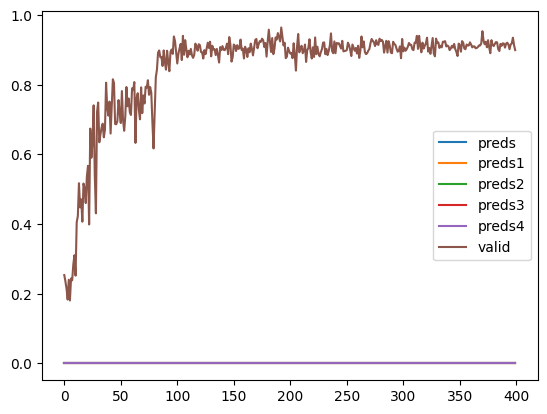

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/400 [00:00<?, ?it/s]

***训练集***
0.1425


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/400 [00:06<41:23,  6.22s/it]

valid-f1: 0.04307576657981217
valid-precision: 0.027985799310848908
valid-recall: 0.1174185463659148
process: 1  loss: 56.95002365112305  train_correct: 0.010800568450971104 valid_loss 82.60308146476746  val_correct: 0.12555654496883348
The model has been saved!!
The best val_acc is  0.12555654496883348
***训练集***
0.14875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 2/400 [00:12<40:55,  6.17s/it]

valid-f1: 0.0440047877043475
valid-precision: 0.02857316740671496
valid-recall: 0.11535904979840908
process: 2  loss: 57.04300570487976  train_correct: 0.011274277593557556 valid_loss 82.48459386825562  val_correct: 0.12377560106856635
***训练集***
0.19125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 3/400 [00:18<40:44,  6.16s/it]

valid-f1: 0.031076501550219914
valid-precision: 0.019165429655286163
valid-recall: 0.08583959899749374
process: 3  loss: 56.639822483062744  train_correct: 0.014495499763145429 valid_loss 81.90678358078003  val_correct: 0.09349955476402494
***训练集***
0.22375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/400 [00:24<41:01,  6.21s/it]

valid-f1: 0.08893299308432231
valid-precision: 0.09334459307247059
valid-recall: 0.14999455159638225
process: 4  loss: 56.183430671691895  train_correct: 0.016958787304594977 valid_loss 81.291832447052  val_correct: 0.1798753339269813
The model has been saved!!
The best val_acc is  0.1798753339269813
***训练集***
0.22875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▏         | 5/400 [00:31<40:53,  6.21s/it]

valid-f1: 0.15210917017530412
valid-precision: 0.13127510533307635
valid-recall: 0.19880861574225417
process: 5  loss: 55.92986750602722  train_correct: 0.01733775461866414 valid_loss 81.37714505195618  val_correct: 0.2653606411398041
The model has been saved!!
The best val_acc is  0.2653606411398041
***训练集***
0.2775


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 6/400 [00:37<40:43,  6.20s/it]

valid-f1: 0.05117355064461003
valid-precision: 0.034877183878221765
valid-recall: 0.09610983981693363
process: 6  loss: 55.04165840148926  train_correct: 0.021032685930838464 valid_loss 80.18330252170563  val_correct: 0.17809439002671415
***训练集***
0.28625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 7/400 [00:43<40:35,  6.20s/it]

valid-f1: 0.1262459836955016
valid-precision: 0.09582900660831073
valid-recall: 0.2159583741963605
process: 7  loss: 53.648003578186035  train_correct: 0.021695878730459497 valid_loss 79.4505764245987  val_correct: 0.3072128227960819
The model has been saved!!
The best val_acc is  0.3072128227960819
***训练集***
0.25875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 8/400 [00:49<40:18,  6.17s/it]

valid-f1: 0.09094701633211096
valid-precision: 0.08131298055178653
valid-recall: 0.12634451742003228
process: 8  loss: 53.21652126312256  train_correct: 0.01961155850307911 valid_loss 77.76832795143127  val_correct: 0.21905609973285842
***训练集***
0.26


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 9/400 [00:55<40:16,  6.18s/it]

valid-f1: 0.08067140270122183
valid-precision: 0.10716844117230391
valid-recall: 0.13101231339217606
process: 9  loss: 52.66315793991089  train_correct: 0.0197063003315964 valid_loss 73.24694883823395  val_correct: 0.22439893143365983
***训练集***
0.33875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▎         | 10/400 [01:01<40:04,  6.17s/it]

valid-f1: 0.09564298608335385
valid-precision: 0.12330272315797211
valid-recall: 0.19514392040707831
process: 10  loss: 48.51764225959778  train_correct: 0.025675035528185695 valid_loss 80.72175526618958  val_correct: 0.2226179875333927
***训练集***
0.36625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 11/400 [01:08<40:03,  6.18s/it]

valid-f1: 0.1579604804007085
valid-precision: 0.2296586663719255
valid-recall: 0.2272165261638946
process: 11  loss: 46.33187663555145  train_correct: 0.02775935575556608 valid_loss 62.122273951768875  val_correct: 0.3597506678539626
The model has been saved!!
The best val_acc is  0.3597506678539626
***训练集***
0.38125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 12/400 [01:14<39:48,  6.15s/it]

valid-f1: 0.20106071395505895
valid-precision: 0.28692087748503914
valid-recall: 0.22340961098398168
process: 12  loss: 44.8737975358963  train_correct: 0.028896257697773566 valid_loss 63.42977994680405  val_correct: 0.3570792520035619
***训练集***
0.42


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 13/400 [01:20<39:43,  6.16s/it]

valid-f1: 0.27528653682148463
valid-precision: 0.26674313941930133
valid-recall: 0.3665992385443187
process: 13  loss: 41.5889778137207  train_correct: 0.03183325438180957 valid_loss 55.63485503196716  val_correct: 0.4959928762243989
The model has been saved!!
The best val_acc is  0.4959928762243989
***训练集***
0.46625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▎         | 14/400 [01:26<39:50,  6.19s/it]

valid-f1: 0.25042170286493487
valid-precision: 0.2415394072301967
valid-recall: 0.31845374305328533
process: 14  loss: 39.782527446746826  train_correct: 0.03533870203694931 valid_loss 51.15364861488342  val_correct: 0.44879786286731965
***训练集***
0.46625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 15/400 [01:32<39:31,  6.16s/it]

valid-f1: 0.20620174280538803
valid-precision: 0.24156473883325078
valid-recall: 0.26310813265046673
process: 15  loss: 38.84896993637085  train_correct: 0.03533870203694931 valid_loss 52.22012519836426  val_correct: 0.383793410507569
***训练集***
0.50875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 16/400 [01:38<39:19,  6.15s/it]

valid-f1: 0.3130395164120387
valid-precision: 0.48670342100821556
valid-recall: 0.36511466413068244
process: 16  loss: 36.05610454082489  train_correct: 0.038559924206537186 valid_loss 51.44034460186958  val_correct: 0.4692787177203918
***训练集***
0.55625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 17/400 [01:44<39:15,  6.15s/it]

valid-f1: 0.25169978916045005
valid-precision: 0.5447118305072746
valid-recall: 0.2780531698151835
process: 17  loss: 33.45104682445526  train_correct: 0.04216011369019422 valid_loss 53.2833139449358  val_correct: 0.39091718610863757
***训练集***
0.52875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 18/400 [01:51<39:07,  6.14s/it]

valid-f1: 0.38726834912748664
valid-precision: 0.4335446618045792
valid-recall: 0.39040288468206086
process: 18  loss: 33.528589367866516  train_correct: 0.040075793462813834 valid_loss 49.504735350608826  val_correct: 0.44434550311665183
***训练集***
0.585


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  5%|▍         | 19/400 [01:57<39:24,  6.21s/it]

valid-f1: 0.40463784038767725
valid-precision: 0.5260724441096066
valid-recall: 0.424968845037495
process: 19  loss: 31.62223529815674  train_correct: 0.0443391757460919 valid_loss 50.01847368478775  val_correct: 0.5048975957257347
The model has been saved!!
The best val_acc is  0.5048975957257347
***训练集***
0.6075


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  5%|▌         | 20/400 [02:03<39:16,  6.20s/it]

valid-f1: 0.47647182158403767
valid-precision: 0.5163037179730459
valid-recall: 0.5115867402366259
process: 20  loss: 30.444900393486023  train_correct: 0.046044528659403124 valid_loss 41.73021346330643  val_correct: 0.5405164737310775
The model has been saved!!
The best val_acc is  0.5405164737310775
***训练集***
0.5875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  5%|▌         | 21/400 [02:09<39:15,  6.21s/it]

valid-f1: 0.4541753728400829
valid-precision: 0.5292403685432616
valid-recall: 0.48678431916418186
process: 21  loss: 29.970595955848694  train_correct: 0.04452865940312648 valid_loss 42.088042467832565  val_correct: 0.5512021371326803
The model has been saved!!
The best val_acc is  0.5512021371326803
***训练集***
0.61


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  6%|▌         | 22/400 [02:16<39:11,  6.22s/it]

valid-f1: 0.5583687793866616
valid-precision: 0.5746932846162245
valid-recall: 0.5861866457976297
process: 22  loss: 29.07503914833069  train_correct: 0.04623401231643771 valid_loss 35.728309497237206  val_correct: 0.6420302760463046
The model has been saved!!
The best val_acc is  0.6420302760463046
***训练集***
0.645


  6%|▌         | 23/400 [02:22<38:45,  6.17s/it]

valid-f1: 0.5779719113075933
valid-precision: 0.6120825351049483
valid-recall: 0.6271302663774059
process: 23  loss: 27.448305547237396  train_correct: 0.04888678351492184 valid_loss 39.78968211263418  val_correct: 0.6260017809439002
***训练集***
0.6625


  6%|▌         | 24/400 [02:28<38:49,  6.20s/it]

valid-f1: 0.556145835079363
valid-precision: 0.612567986042292
valid-recall: 0.5657481978992276
process: 24  loss: 26.404365837574005  train_correct: 0.0502131691141639 valid_loss 33.97164677083492  val_correct: 0.6438112199465716
The model has been saved!!
The best val_acc is  0.6438112199465716
***训练集***
0.68875


  6%|▋         | 25/400 [02:34<38:37,  6.18s/it]

valid-f1: 0.42542851653660546
valid-precision: 0.5148153909422353
valid-recall: 0.505686419606328
process: 25  loss: 24.313631415367126  train_correct: 0.052202747513027004 valid_loss 60.60583660006523  val_correct: 0.4514692787177204
***训练集***
0.685


  6%|▋         | 26/400 [02:40<38:30,  6.18s/it]

valid-f1: 0.6761496258439372
valid-precision: 0.7368717891854957
valid-recall: 0.6690456477161282
process: 26  loss: 25.20322871208191  train_correct: 0.05191852202747513 valid_loss 35.193823613226414  val_correct: 0.7105966162065895
The model has been saved!!
The best val_acc is  0.7105966162065895
***训练集***
0.6825


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  7%|▋         | 27/400 [02:46<38:20,  6.17s/it]

valid-f1: 0.5568493257660216
valid-precision: 0.6520941539371008
valid-recall: 0.5943289052671203
process: 27  loss: 23.435278713703156  train_correct: 0.05172903837044055 valid_loss 37.344791412353516  val_correct: 0.6402493321460374
***训练集***
0.72125


  7%|▋         | 28/400 [02:52<38:12,  6.16s/it]

valid-f1: 0.5524887271447916
valid-precision: 0.6218949547233897
valid-recall: 0.5513026967946876
process: 28  loss: 22.668382227420807  train_correct: 0.05466603505447655 valid_loss 35.664372101426125  val_correct: 0.5841495992876224
***训练集***
0.71


  7%|▋         | 29/400 [02:59<38:10,  6.17s/it]

valid-f1: 0.6753979851432816
valid-precision: 0.7487915523831424
valid-recall: 0.6785243543641712
process: 29  loss: 22.841446459293365  train_correct: 0.05381335859782094 valid_loss 28.487260699272156  val_correct: 0.7016918967052538
***训练集***
0.74


  8%|▊         | 30/400 [03:05<38:13,  6.20s/it]

valid-f1: 0.7110333125061449
valid-precision: 0.7844483160223297
valid-recall: 0.7001167279199316
process: 30  loss: 20.979012429714203  train_correct: 0.05608716248223591 valid_loss 30.0633215457201  val_correct: 0.7453250222617988
The model has been saved!!
The best val_acc is  0.7453250222617988
***训练集***
0.7725


  8%|▊         | 31/400 [03:11<38:04,  6.19s/it]

valid-f1: 0.7003957585215611
valid-precision: 0.7436116763060904
valid-recall: 0.7106605743608031
process: 31  loss: 19.575272619724274  train_correct: 0.05855045002368546 valid_loss 28.581756580621004  val_correct: 0.7622439893143366
The model has been saved!!
The best val_acc is  0.7622439893143366
***训练集***
0.76625


  8%|▊         | 32/400 [03:17<37:47,  6.16s/it]

valid-f1: 0.67760410904113
valid-precision: 0.7463476744219617
valid-recall: 0.6829275296277585
process: 32  loss: 19.308042138814926  train_correct: 0.05807674088109901 valid_loss 31.794152032583952  val_correct: 0.6918967052537845
***训练集***
0.7575


  8%|▊         | 33/400 [03:23<37:37,  6.15s/it]

valid-f1: 0.5783992816642436
valid-precision: 0.6999286385997434
valid-recall: 0.603264960821025
process: 33  loss: 19.485164284706116  train_correct: 0.05741354808147797 valid_loss 36.46552121639252  val_correct: 0.6179875333926982
***训练集***
0.755


  8%|▊         | 34/400 [03:30<37:45,  6.19s/it]

valid-f1: 0.6541409860418081
valid-precision: 0.7726285157880387
valid-recall: 0.7036205137349303
process: 34  loss: 19.43967992067337  train_correct: 0.057224064424443395 valid_loss 36.64443291723728  val_correct: 0.6322350845948352
***训练集***
0.7725


  9%|▉         | 35/400 [03:36<37:28,  6.16s/it]

valid-f1: 0.576758734276382
valid-precision: 0.7516802423195257
valid-recall: 0.6134140192378179
process: 35  loss: 18.70944595336914  train_correct: 0.05855045002368546 valid_loss 37.360776126384735  val_correct: 0.6455921638468388
***训练集***
0.7625


  9%|▉         | 36/400 [03:42<37:26,  6.17s/it]

valid-f1: 0.7609886042389499
valid-precision: 0.7793152701637661
valid-recall: 0.7751063363283043
process: 36  loss: 20.105978429317474  train_correct: 0.05779251539554713 valid_loss 26.134571366012096  val_correct: 0.7871772039180766
The model has been saved!!
The best val_acc is  0.7871772039180766
***训练集***
0.7625


  9%|▉         | 37/400 [03:48<37:17,  6.16s/it]

valid-f1: 0.6872155367101069
valid-precision: 0.7676527066171033
valid-recall: 0.6949991612760491
process: 37  loss: 18.93620553612709  train_correct: 0.05779251539554713 valid_loss 28.762182109057903  val_correct: 0.7275155832591274
***训练集***
0.75


 10%|▉         | 38/400 [03:54<37:09,  6.16s/it]

valid-f1: 0.5831115564095655
valid-precision: 0.7841579553101643
valid-recall: 0.5903248404278153
process: 38  loss: 19.78037765622139  train_correct: 0.05684509711037423 valid_loss 45.9686858355999  val_correct: 0.5983971504897596
***训练集***
0.78625


 10%|▉         | 39/400 [04:00<37:09,  6.18s/it]

valid-f1: 0.73977653568068
valid-precision: 0.7657921682586732
valid-recall: 0.7393249493958877
process: 39  loss: 17.47393435239792  train_correct: 0.05959261013737565 valid_loss 26.799854189157486  val_correct: 0.7586821015138023
***训练集***
0.78


 10%|█         | 40/400 [04:07<36:58,  6.16s/it]

valid-f1: 0.7469104323681889
valid-precision: 0.7790364740250899
valid-recall: 0.7556444933149739
process: 40  loss: 16.937978506088257  train_correct: 0.0591189009947892 valid_loss 24.574265643954277  val_correct: 0.773820124666073
***训练集***
0.805


 10%|█         | 41/400 [04:13<36:51,  6.16s/it]

valid-f1: 0.6857184687473207
valid-precision: 0.7647136510013086
valid-recall: 0.7132342384287464
process: 41  loss: 15.977997928857803  train_correct: 0.06101373756513501 valid_loss 30.514516856521368  val_correct: 0.7284060552092609
***训练集***
0.7775


 10%|█         | 42/400 [04:19<36:38,  6.14s/it]

valid-f1: 0.7554692107580845
valid-precision: 0.7540362403077203
valid-recall: 0.7926045878860524
process: 42  loss: 17.42697149515152  train_correct: 0.05892941733775462 valid_loss 30.826340898871422  val_correct: 0.7684772929652716
***训练集***
0.8025


 11%|█         | 43/400 [04:25<36:31,  6.14s/it]

valid-f1: 0.6437171308369773
valid-precision: 0.7580460021509228
valid-recall: 0.6568371587730855
process: 43  loss: 16.475702077150345  train_correct: 0.06082425390810042 valid_loss 44.13267458975315  val_correct: 0.6642920747996438
***训练集***
0.79125


 11%|█         | 44/400 [04:31<36:40,  6.18s/it]

valid-f1: 0.7479622141604148
valid-precision: 0.7884996808843272
valid-recall: 0.7488487358052576
process: 44  loss: 16.978552103042603  train_correct: 0.05997157745144481 valid_loss 24.428782254457474  val_correct: 0.767586821015138
***训练集***
0.8


 11%|█▏        | 45/400 [04:37<36:27,  6.16s/it]

valid-f1: 0.6806089226065598
valid-precision: 0.7300103571310588
valid-recall: 0.7040195118890772
process: 45  loss: 15.343072593212128  train_correct: 0.060634770251065846 valid_loss 36.501721151173115  val_correct: 0.6829919857524488
***训练集***
0.8375


 12%|█▏        | 46/400 [04:43<36:17,  6.15s/it]

valid-f1: 0.6749742612035405
valid-precision: 0.7875593043442878
valid-recall: 0.6674537199388457
process: 46  loss: 13.992704063653946  train_correct: 0.06347702510658455 valid_loss 27.705346889793873  val_correct: 0.7132680320569902
***训练集***
0.8175


 12%|█▏        | 47/400 [04:50<36:07,  6.14s/it]

valid-f1: 0.7229330797391095
valid-precision: 0.7716938814673279
valid-recall: 0.7273710825152474
process: 47  loss: 15.396470576524734  train_correct: 0.06196115585030791 valid_loss 26.356094665825367  val_correct: 0.7506678539626002
***训练集***
0.81


 12%|█▏        | 48/400 [04:56<35:57,  6.13s/it]

valid-f1: 0.6100803162978009
valid-precision: 0.7524445404323327
valid-recall: 0.5945874964090067
process: 48  loss: 15.037237256765366  train_correct: 0.06139270487920417 valid_loss 43.29799860715866  val_correct: 0.6064113980409617
***训练集***
0.81625


 12%|█▏        | 49/400 [05:02<35:52,  6.13s/it]

valid-f1: 0.6484809300142118
valid-precision: 0.735046551292953
valid-recall: 0.6763211982525484
process: 49  loss: 15.056501418352127  train_correct: 0.06186641402179062 valid_loss 33.26945502310991  val_correct: 0.6544968833481746
***训练集***
0.82375


 12%|█▎        | 50/400 [05:08<35:51,  6.15s/it]

valid-f1: 0.7269092498617036
valid-precision: 0.7429847514200983
valid-recall: 0.7301855330024666
process: 50  loss: 14.707570672035217  train_correct: 0.062434864992894364 valid_loss 26.032236240804195  val_correct: 0.742653606411398
***训练集***
0.78


 13%|█▎        | 51/400 [05:14<35:46,  6.15s/it]

valid-f1: 0.7778575706797867
valid-precision: 0.7952887873139035
valid-recall: 0.7881315343695207
process: 51  loss: 16.99761387705803  train_correct: 0.0591189009947892 valid_loss 23.38438805565238  val_correct: 0.773820124666073
***训练集***
0.805


 13%|█▎        | 52/400 [05:20<35:44,  6.16s/it]

valid-f1: 0.7704473585780265
valid-precision: 0.778522312975342
valid-recall: 0.7850140865998989
process: 52  loss: 14.861553341150284  train_correct: 0.06101373756513501 valid_loss 24.866957135498524  val_correct: 0.7880676758682101
The model has been saved!!
The best val_acc is  0.7880676758682101
***训练集***
0.81625


 13%|█▎        | 53/400 [05:27<35:38,  6.16s/it]

valid-f1: 0.6857396225017798
valid-precision: 0.7555732955364733
valid-recall: 0.6884799317133412
process: 53  loss: 14.651897430419922  train_correct: 0.06186641402179062 valid_loss 33.52395501732826  val_correct: 0.6892252894033838
***训练集***
0.8225


 14%|█▎        | 54/400 [05:33<35:33,  6.17s/it]

valid-f1: 0.7773261227094803
valid-precision: 0.7818703007139479
valid-recall: 0.7977745714748004
process: 54  loss: 14.388051301240921  train_correct: 0.06234012316437707 valid_loss 25.933067053556442  val_correct: 0.7782724844167409
***训练集***
0.82875


 14%|█▍        | 55/400 [05:39<35:40,  6.21s/it]

valid-f1: 0.8053932463438376
valid-precision: 0.8020583612307866
valid-recall: 0.8242491736587846
process: 55  loss: 13.667035028338432  train_correct: 0.06281383230696352 valid_loss 22.900842025876045  val_correct: 0.8219056099732859
The model has been saved!!
The best val_acc is  0.8219056099732859
***训练集***
0.84625


 14%|█▍        | 56/400 [05:45<35:29,  6.19s/it]

valid-f1: 0.745042214480532
valid-precision: 0.801128020507979
valid-recall: 0.7453450127294521
process: 56  loss: 12.858492612838745  train_correct: 0.0641402179062056 valid_loss 24.778056427836418  val_correct: 0.7453250222617988
***训练集***
0.8425


 14%|█▍        | 57/400 [05:51<35:12,  6.16s/it]

valid-f1: 0.683858532735881
valid-precision: 0.7495894839645079
valid-recall: 0.6966427729402558
process: 57  loss: 12.363023728132248  train_correct: 0.06385599242065372 valid_loss 35.94766905158758  val_correct: 0.6883348174532502
***训练集***
0.8275


 14%|█▍        | 58/400 [05:57<35:04,  6.15s/it]

valid-f1: 0.7617337380845964
valid-precision: 0.7726990415521882
valid-recall: 0.7935433742458914
process: 58  loss: 13.353581666946411  train_correct: 0.06271909047844623 valid_loss 25.147387325763702  val_correct: 0.761353517364203
***训练集***
0.82125


 15%|█▍        | 59/400 [06:04<34:59,  6.16s/it]

valid-f1: 0.7636873347365645
valid-precision: 0.8043203256909788
valid-recall: 0.7543517588437497
process: 59  loss: 13.726841062307358  train_correct: 0.06224538133585978 valid_loss 20.369718469679356  val_correct: 0.786286731967943
***训练集***
0.8375


 15%|█▌        | 60/400 [06:10<35:22,  6.24s/it]

valid-f1: 0.7435046802479304
valid-precision: 0.7699581448431061
valid-recall: 0.7580885316056941
process: 60  loss: 12.551050245761871  train_correct: 0.06347702510658455 valid_loss 25.088145446032286  val_correct: 0.7604630454140695
***训练集***
0.82625


 15%|█▌        | 61/400 [06:16<35:01,  6.20s/it]

valid-f1: 0.6970067285872809
valid-precision: 0.7595274653655906
valid-recall: 0.7272318609435313
process: 61  loss: 13.230953186750412  train_correct: 0.06262434864992894 valid_loss 36.23553001135588  val_correct: 0.678539626001781
***训练集***
0.81125


 16%|█▌        | 62/400 [06:22<34:53,  6.19s/it]

valid-f1: 0.8336345533481083
valid-precision: 0.8526294839786089
valid-recall: 0.8305592703762039
process: 62  loss: 14.402649194002151  train_correct: 0.06148744670772146 valid_loss 17.86624639481306  val_correct: 0.8468388245770259
The model has been saved!!
The best val_acc is  0.8468388245770259
***训练集***
0.82875


 16%|█▌        | 63/400 [06:28<34:41,  6.18s/it]

valid-f1: 0.7820879763967538
valid-precision: 0.7861270931944027
valid-recall: 0.7960329248681652
process: 63  loss: 13.990551635622978  train_correct: 0.06281383230696352 valid_loss 25.702100411057472  val_correct: 0.7960819234194123
***训练集***
0.82375


 16%|█▌        | 64/400 [06:35<34:33,  6.17s/it]

valid-f1: 0.7142414538985268
valid-precision: 0.7580563675662194
valid-recall: 0.7176498195422679
process: 64  loss: 14.041412964463234  train_correct: 0.062434864992894364 valid_loss 23.129917308688164  val_correct: 0.7569011576135352
***训练集***
0.84125


 16%|█▋        | 65/400 [06:41<34:30,  6.18s/it]

valid-f1: 0.7691668663513316
valid-precision: 0.805940719896256
valid-recall: 0.7784434604297303
process: 65  loss: 12.561626523733139  train_correct: 0.06376125059213643 valid_loss 27.274569511413574  val_correct: 0.7782724844167409
***训练集***
0.86


 16%|█▋        | 66/400 [06:47<34:16,  6.16s/it]

valid-f1: 0.7677576201792646
valid-precision: 0.7793603126223587
valid-recall: 0.7824491036550534
process: 66  loss: 11.715548351407051  train_correct: 0.06518237801989578 valid_loss 21.45915514230728  val_correct: 0.7836153161175423
***训练集***
0.86875


 17%|█▋        | 67/400 [06:53<34:07,  6.15s/it]

valid-f1: 0.7870603333910667
valid-precision: 0.8244311208991848
valid-recall: 0.7933422621111408
process: 67  loss: 11.029406562447548  train_correct: 0.06584557081951682 valid_loss 21.89687619358301  val_correct: 0.7960819234194123
***训练集***
0.85375


 17%|█▋        | 68/400 [06:59<34:00,  6.15s/it]

valid-f1: 0.7942384594575439
valid-precision: 0.8078049906563965
valid-recall: 0.8241389375943152
process: 68  loss: 12.698740661144257  train_correct: 0.06470866887730933 valid_loss 24.127914682030678  val_correct: 0.8040961709706145
***训练集***
0.83


 17%|█▋        | 69/400 [07:05<33:59,  6.16s/it]

valid-f1: 0.8223412567855984
valid-precision: 0.8360834075404678
valid-recall: 0.8359392585548191
process: 69  loss: 13.397528350353241  train_correct: 0.06290857413548082 valid_loss 22.347885385155678  val_correct: 0.8165627782724845
***训练集***
0.8475


 18%|█▊        | 70/400 [07:12<34:00,  6.18s/it]

valid-f1: 0.709025548465611
valid-precision: 0.8296205504270032
valid-recall: 0.6976283858526423
process: 70  loss: 12.707106277346611  train_correct: 0.06423495973472287 valid_loss 27.964931905269623  val_correct: 0.730186999109528
***训练集***
0.8425


 18%|█▊        | 71/400 [07:18<33:56,  6.19s/it]

valid-f1: 0.7437193645458244
valid-precision: 0.776142849412755
valid-recall: 0.7774168028767572
process: 71  loss: 12.083773151040077  train_correct: 0.06385599242065372 valid_loss 29.44724364578724  val_correct: 0.7533392698130009
***训练集***
0.8425


 18%|█▊        | 72/400 [07:24<33:45,  6.17s/it]

valid-f1: 0.7180813253043581
valid-precision: 0.7502076852531184
valid-recall: 0.7530187887373242
process: 72  loss: 13.08705261349678  train_correct: 0.06385599242065372 valid_loss 26.7953240275383  val_correct: 0.709706144256456
***训练集***
0.8325


 18%|█▊        | 73/400 [07:30<33:37,  6.17s/it]

valid-f1: 0.78261810890449
valid-precision: 0.8254662342968386
valid-recall: 0.7873483511149415
process: 73  loss: 12.415397271513939  train_correct: 0.0630980577925154 valid_loss 23.801074169576168  val_correct: 0.7791629563668745
***训练集***
0.84625


 18%|█▊        | 74/400 [07:36<33:28,  6.16s/it]

valid-f1: 0.7100364129112757
valid-precision: 0.7493285023116136
valid-recall: 0.7161718261397895
process: 74  loss: 12.22383038699627  train_correct: 0.0641402179062056 valid_loss 27.956394612789154  val_correct: 0.715939447907391
***训练集***
0.83875


 19%|█▉        | 75/400 [07:42<33:27,  6.18s/it]

valid-f1: 0.74827148721226
valid-precision: 0.783286058505407
valid-recall: 0.79186319223619
process: 75  loss: 12.015074998140335  train_correct: 0.06357176693510184 valid_loss 28.322249576449394  val_correct: 0.7105966162065895
***训练集***
0.86


 19%|█▉        | 76/400 [07:49<33:15,  6.16s/it]

valid-f1: 0.7513298891375626
valid-precision: 0.7967485334468826
valid-recall: 0.7545035579726656
process: 76  loss: 10.723121091723442  train_correct: 0.06518237801989578 valid_loss 26.118494756519794  val_correct: 0.7595725734639359
***训练集***
0.8475
开始蒸馏


 19%|█▉        | 77/400 [07:55<33:06,  6.15s/it]

valid-f1: 0.7284850581741067
valid-precision: 0.7590468469922467
valid-recall: 0.7535543668129481
process: 77  loss: 11.506538525223732  train_correct: 0.06423495973472287 valid_loss 28.852837696671486  val_correct: 0.711487088156723
***训练集***
0.72375


 20%|█▉        | 78/400 [08:01<32:56,  6.14s/it]

valid-f1: 0.7514306499645995
valid-precision: 0.772573333613908
valid-recall: 0.7692287371921239
process: 78  loss: 1367.7989959716797  train_correct: 0.054855518711511134 valid_loss 23.20324731245637  val_correct: 0.7756010685663401
***训练集***
0.68


 20%|█▉        | 79/400 [08:07<32:54,  6.15s/it]

valid-f1: 0.7468149825231689
valid-precision: 0.8581416759636772
valid-recall: 0.7636784220102298
process: 79  loss: 889.5339412689209  train_correct: 0.05153955471340597 valid_loss 19.152520146686584  val_correct: 0.8085485307212823
***训练集***
0.69625


 20%|██        | 80/400 [08:13<32:59,  6.19s/it]

valid-f1: 0.7755255250433595
valid-precision: 0.8875451276845364
valid-recall: 0.7653801763961947
process: 80  loss: 771.4678077697754  train_correct: 0.05277119848413074 valid_loss 19.37498389428947  val_correct: 0.8308103294746215
***训练集***
0.74


 20%|██        | 81/400 [08:19<32:49,  6.17s/it]

valid-f1: 0.726093003973638
valid-precision: 0.8605729520880484
valid-recall: 0.7325147552676157
process: 81  loss: 669.3689308166504  train_correct: 0.05608716248223591 valid_loss 22.538960457779467  val_correct: 0.7711487088156723
***训练集***
0.74625


 20%|██        | 82/400 [08:25<32:37,  6.15s/it]

valid-f1: 0.744156105360405
valid-precision: 0.8403191377092865
valid-recall: 0.7469185678293229
process: 82  loss: 659.4059371948242  train_correct: 0.05656087162482236 valid_loss 18.33980149193667  val_correct: 0.7702582368655387
***训练集***
0.7875


 21%|██        | 83/400 [08:32<32:34,  6.16s/it]

valid-f1: 0.8281711378182115
valid-precision: 0.8851515028517261
valid-recall: 0.8120861838390443
process: 83  loss: 574.0973930358887  train_correct: 0.05968735196589294 valid_loss 15.287357844877988  val_correct: 0.8593054318788959
The model has been saved!!
The best val_acc is  0.8593054318788959
***训练集***
0.78875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 21%|██        | 84/400 [08:38<32:23,  6.15s/it]

valid-f1: 0.7176199893428733
valid-precision: 0.743695857369099
valid-recall: 0.7368903153800179
process: 84  loss: 551.3043003082275  train_correct: 0.05978209379441023 valid_loss 21.653340792283416  val_correct: 0.7631344612644702
***训练集***
0.815


 21%|██▏       | 85/400 [08:44<32:38,  6.22s/it]

valid-f1: 0.8652673064683956
valid-precision: 0.8858744834563943
valid-recall: 0.8673616452197688
process: 85  loss: 554.6242580413818  train_correct: 0.06177167219327333 valid_loss 13.008226484496845  val_correct: 0.8744434550311665
The model has been saved!!
The best val_acc is  0.8744434550311665
***训练集***
0.7775


 22%|██▏       | 86/400 [08:50<32:23,  6.19s/it]

valid-f1: 0.8032071406141054
valid-precision: 0.8619137552892789
valid-recall: 0.7967224715279635
process: 86  loss: 545.8343849182129  train_correct: 0.05892941733775462 valid_loss 15.046590126177762  val_correct: 0.8210151380231523
***训练集***
0.81


 22%|██▏       | 87/400 [08:56<32:09,  6.16s/it]

valid-f1: 0.7479716889871251
valid-precision: 0.8557816158094289
valid-recall: 0.7412327624066755
process: 87  loss: 501.0234489440918  train_correct: 0.06139270487920417 valid_loss 21.4244271410862  val_correct: 0.7916295636687445
***训练集***
0.78875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 22%|██▏       | 88/400 [09:02<31:56,  6.14s/it]

valid-f1: 0.7146982889650653
valid-precision: 0.7257221101767477
valid-recall: 0.7329206415247607
process: 88  loss: 511.9131078720093  train_correct: 0.05978209379441023 valid_loss 29.46058583969716  val_correct: 0.7462154942119323
***训练集***
0.82625


 22%|██▏       | 89/400 [09:09<31:49,  6.14s/it]

valid-f1: 0.8297477596261041
valid-precision: 0.8715031636824611
valid-recall: 0.8200580667743139
process: 89  loss: 486.0967769622803  train_correct: 0.06262434864992894 valid_loss 12.35651362023782  val_correct: 0.8388245770258237
***训练集***
0.8375


 22%|██▎       | 90/400 [09:15<31:49,  6.16s/it]

valid-f1: 0.8109272475186338
valid-precision: 0.8860279417255599
valid-recall: 0.7925111692274164
process: 90  loss: 454.08143043518066  train_correct: 0.06347702510658455 valid_loss 15.254890397191048  val_correct: 0.8334817453250223
***训练集***
0.8225


 23%|██▎       | 91/400 [09:21<31:37,  6.14s/it]

valid-f1: 0.8417342975531283
valid-precision: 0.8848592739984937
valid-recall: 0.8354135932717168
process: 91  loss: 462.0659866333008  train_correct: 0.06234012316437707 valid_loss 17.013590833637863  val_correct: 0.8504007123775601
***训练集***
0.8175


 23%|██▎       | 92/400 [09:27<31:35,  6.15s/it]

valid-f1: 0.7706987657660982
valid-precision: 0.8677352898927142
valid-recall: 0.7637940899680029
process: 92  loss: 452.9837703704834  train_correct: 0.06196115585030791 valid_loss 19.854490452969912  val_correct: 0.8067675868210151
***训练集***
0.8425


 23%|██▎       | 93/400 [09:33<31:27,  6.15s/it]

valid-f1: 0.8490368923361771
valid-precision: 0.8691176945719452
valid-recall: 0.845151584494834
process: 93  loss: 459.65766429901123  train_correct: 0.06385599242065372 valid_loss 11.926960214041173  val_correct: 0.8468388245770259
***训练集***
0.8375


 24%|██▎       | 94/400 [09:39<31:24,  6.16s/it]

valid-f1: 0.8218389419558904
valid-precision: 0.8746379930518717
valid-recall: 0.8138824168458034
process: 94  loss: 426.9351968765259  train_correct: 0.06347702510658455 valid_loss 15.955144603387453  val_correct: 0.8370436331255565
***训练集***
0.8325


 24%|██▍       | 95/400 [09:46<31:24,  6.18s/it]

valid-f1: 0.8522276497034083
valid-precision: 0.8817937647228433
valid-recall: 0.8498345699558515
process: 95  loss: 431.5995635986328  train_correct: 0.0630980577925154 valid_loss 13.499875666340813  val_correct: 0.8575244879786287
***训练集***
0.85125


 24%|██▍       | 96/400 [09:52<31:14,  6.16s/it]

valid-f1: 0.8507529318855214
valid-precision: 0.878036097037078
valid-recall: 0.8483065866246644
process: 96  loss: 438.72381496429443  train_correct: 0.06451918522027475 valid_loss 10.86956554511562  val_correct: 0.8593054318788959
***训练集***
0.845


 24%|██▍       | 97/400 [09:58<31:13,  6.18s/it]

valid-f1: 0.8957759217037257
valid-precision: 0.8968552196473072
valid-recall: 0.8968572287107757
process: 97  loss: 416.9532403945923  train_correct: 0.0640454760776883 valid_loss 10.91990526713198  val_correct: 0.9082813891362422
The model has been saved!!
The best val_acc is  0.9082813891362422
***训练集***
0.8375


 24%|██▍       | 98/400 [10:04<31:05,  6.18s/it]

valid-f1: 0.8424937548857182
valid-precision: 0.888134450435915
valid-recall: 0.8345740702216675
process: 98  loss: 417.87126064300537  train_correct: 0.06347702510658455 valid_loss 11.315406497160438  val_correct: 0.8539626001780944
***训练集***
0.8475


 25%|██▍       | 99/400 [10:10<30:49,  6.15s/it]

valid-f1: 0.8223612010304928
valid-precision: 0.8533530475048359
valid-recall: 0.8196346333554573
process: 99  loss: 414.199818611145  train_correct: 0.06423495973472287 valid_loss 13.407997378963046  val_correct: 0.8388245770258237
***训练集***
0.8475


 25%|██▌       | 100/400 [10:16<30:51,  6.17s/it]

valid-f1: 0.8380751193841764
valid-precision: 0.8726722253653992
valid-recall: 0.8258664414659836
process: 100  loss: 406.8100118637085  train_correct: 0.06423495973472287 valid_loss 12.642469072015956  val_correct: 0.8646482635796973
***训练集***
0.81625


 25%|██▌       | 101/400 [10:23<30:40,  6.16s/it]

valid-f1: 0.8250321787944651
valid-precision: 0.8673829117468236
valid-recall: 0.8203075244104993
process: 101  loss: 411.8613977432251  train_correct: 0.06186641402179062 valid_loss 13.276930648717098  val_correct: 0.8406055209260909
***训练集***
0.83875


 26%|██▌       | 102/400 [10:29<30:33,  6.15s/it]

valid-f1: 0.8679355719867214
valid-precision: 0.8881250235560346
valid-recall: 0.8695275738753999
process: 102  loss: 402.86739444732666  train_correct: 0.06357176693510184 valid_loss 10.302842215867713  val_correct: 0.8788958147818343
***训练集***
0.8325


 26%|██▌       | 103/400 [10:35<30:23,  6.14s/it]

valid-f1: 0.8371886352601049
valid-precision: 0.8782513799480126
valid-recall: 0.8282768878718535
process: 103  loss: 389.5842170715332  train_correct: 0.0630980577925154 valid_loss 13.392376792267896  val_correct: 0.8432769367764915
***训练集***
0.83625


 26%|██▌       | 104/400 [10:41<30:12,  6.12s/it]

valid-f1: 0.8543520537832894
valid-precision: 0.8703018747404923
valid-recall: 0.852512879695946
process: 104  loss: 409.3161563873291  train_correct: 0.06338228327806726 valid_loss 13.087568474962609  val_correct: 0.8637577916295637
***训练集***
0.83375


 26%|██▋       | 105/400 [10:47<30:17,  6.16s/it]

valid-f1: 0.8712339415863392
valid-precision: 0.8953456492430858
valid-recall: 0.8651433722646538
process: 105  loss: 381.7358627319336  train_correct: 0.06319279962103269 valid_loss 11.668283693426929  val_correct: 0.8673196794300979
***训练集***
0.865


 26%|██▋       | 106/400 [10:53<30:04,  6.14s/it]

valid-f1: 0.8617170464929277
valid-precision: 0.8659501480956564
valid-recall: 0.8706852308637206
process: 106  loss: 378.7809085845947  train_correct: 0.06556134533396495 valid_loss 14.621278236241778  val_correct: 0.8708815672306323
***训练集***
0.8375


 27%|██▋       | 107/400 [10:59<29:57,  6.14s/it]

valid-f1: 0.8816950226250672
valid-precision: 0.8806249581375795
valid-recall: 0.8906309218368715
process: 107  loss: 376.75854110717773  train_correct: 0.06347702510658455 valid_loss 11.004044431087095  val_correct: 0.8833481745325023
***训练集***
0.8575


 27%|██▋       | 108/400 [11:06<29:54,  6.15s/it]

valid-f1: 0.8458539563964764
valid-precision: 0.8735578334816647
valid-recall: 0.8407633378571594
process: 108  loss: 374.0628442764282  train_correct: 0.06499289436286121 valid_loss 14.382672576699406  val_correct: 0.8486197684772929
***训练集***
0.8475


 27%|██▋       | 109/400 [11:12<29:42,  6.13s/it]

valid-f1: 0.8721645636485705
valid-precision: 0.8938216552018838
valid-recall: 0.8668959123764616
process: 109  loss: 376.8863649368286  train_correct: 0.06423495973472287 valid_loss 11.298567977908533  val_correct: 0.8708815672306323
***训练集***
0.85125


 28%|██▊       | 110/400 [11:18<29:36,  6.13s/it]

valid-f1: 0.877436674974151
valid-precision: 0.8902489297224067
valid-recall: 0.8792663047605839
process: 110  loss: 376.70432567596436  train_correct: 0.06451918522027475 valid_loss 12.226922214438673  val_correct: 0.8735529830810329
***训练集***
0.84375


 28%|██▊       | 111/400 [11:24<29:30,  6.13s/it]

valid-f1: 0.8576930068263218
valid-precision: 0.8868819306544736
valid-recall: 0.8513881277634138
process: 111  loss: 369.66431427001953  train_correct: 0.06395073424917101 valid_loss 12.875748369959183  val_correct: 0.8575244879786287
***训练集***
0.86


 28%|██▊       | 112/400 [11:30<29:21,  6.11s/it]

valid-f1: 0.8730611543479696
valid-precision: 0.8886476491987587
valid-recall: 0.8708622874709832
process: 112  loss: 362.72160720825195  train_correct: 0.06518237801989578 valid_loss 11.560190825839527  val_correct: 0.8637577916295637
***训练集***
0.83875


 28%|██▊       | 113/400 [11:36<29:19,  6.13s/it]

valid-f1: 0.871902278306578
valid-precision: 0.8868659208332608
valid-recall: 0.8700403181867713
process: 113  loss: 368.56566524505615  train_correct: 0.06357176693510184 valid_loss 10.972234822635073  val_correct: 0.8646482635796973
***训练集***
0.85625


 28%|██▊       | 114/400 [11:42<29:07,  6.11s/it]

valid-f1: 0.8875214472378955
valid-precision: 0.8943719438083895
valid-recall: 0.8904065697841442
process: 114  loss: 360.8380136489868  train_correct: 0.06489815253434392 valid_loss 11.413590180920437  val_correct: 0.8815672306322351
***训练集***
0.85625


 29%|██▉       | 115/400 [11:48<29:03,  6.12s/it]

valid-f1: 0.8678269060076618
valid-precision: 0.8927317739541586
valid-recall: 0.8613330889806863
process: 115  loss: 363.4210157394409  train_correct: 0.06489815253434392 valid_loss 10.699738779570907  val_correct: 0.8628673196794301
***训练集***
0.85375


 29%|██▉       | 116/400 [11:54<29:00,  6.13s/it]

valid-f1: 0.8593713278268325
valid-precision: 0.8735223727508139
valid-recall: 0.8596942950261027
process: 116  loss: 349.90901470184326  train_correct: 0.06470866887730933 valid_loss 12.42860192299122  val_correct: 0.8566340160284951
***训练集***
0.83125


 29%|██▉       | 117/400 [12:01<28:48,  6.11s/it]

valid-f1: 0.8482415593826815
valid-precision: 0.8615980246382889
valid-recall: 0.849854207323315
process: 117  loss: 353.9280529022217  train_correct: 0.06300331596399811 valid_loss 14.470179299154552  val_correct: 0.8539626001780944
***训练集***
0.86875


 30%|██▉       | 118/400 [12:07<28:45,  6.12s/it]

valid-f1: 0.866891727800656
valid-precision: 0.8869156050871145
valid-recall: 0.8684908813535817
process: 118  loss: 351.2582550048828  train_correct: 0.06584557081951682 valid_loss 12.488594863389153  val_correct: 0.8628673196794301
***训练集***
0.84375


 30%|██▉       | 119/400 [12:13<28:34,  6.10s/it]

valid-f1: 0.9012641800567895
valid-precision: 0.9048373592196108
valid-recall: 0.9015248595797795
process: 119  loss: 337.53525257110596  train_correct: 0.06395073424917101 valid_loss 9.126818245866161  val_correct: 0.9073909171861086
***训练集***
0.8525


 30%|███       | 120/400 [12:19<28:31,  6.11s/it]

valid-f1: 0.8727213497289419
valid-precision: 0.8825679450080555
valid-recall: 0.8764813879230356
process: 120  loss: 342.61476612091064  train_correct: 0.06461392704879204 valid_loss 11.86953707417706  val_correct: 0.8788958147818343
***训练集***
0.8625


 30%|███       | 121/400 [12:25<28:32,  6.14s/it]

valid-f1: 0.8817842740319701
valid-precision: 0.8947797815471796
valid-recall: 0.8848523416578337
process: 121  loss: 343.09304332733154  train_correct: 0.06537186167693036 valid_loss 12.274210796014813  val_correct: 0.8762243989314337
***训练集***
0.895


 30%|███       | 122/400 [12:31<28:18,  6.11s/it]

valid-f1: 0.898975601921701
valid-precision: 0.9072122452854702
valid-recall: 0.8986771771325548
process: 122  loss: 339.06494998931885  train_correct: 0.06783514921837991 valid_loss 9.696169416594785  val_correct: 0.9002671415850401
***训练集***
0.8575


 31%|███       | 123/400 [12:37<28:13,  6.11s/it]

valid-f1: 0.8796090336401615
valid-precision: 0.8843445074004599
valid-recall: 0.8852404826294986
process: 123  loss: 334.03229904174805  train_correct: 0.06499289436286121 valid_loss 11.11770512140356  val_correct: 0.8788958147818343
***训练集***
0.8475


 31%|███       | 124/400 [12:43<28:04,  6.10s/it]

valid-f1: 0.8624507684012238
valid-precision: 0.8712437304233618
valid-recall: 0.866324404555526
process: 124  loss: 347.02075004577637  train_correct: 0.06423495973472287 valid_loss 13.378431189077673  val_correct: 0.8664292074799644
***训练集***
0.8425


 31%|███▏      | 125/400 [12:49<27:54,  6.09s/it]

valid-f1: 0.8884533097366549
valid-precision: 0.9001765812717158
valid-recall: 0.8842517492677675
process: 125  loss: 325.1838607788086  train_correct: 0.06385599242065372 valid_loss 9.569140719831921  val_correct: 0.8869100623330365
***训练集***
0.85125


 32%|███▏      | 126/400 [12:56<28:00,  6.13s/it]

valid-f1: 0.9026640545896376
valid-precision: 0.9196646798064447
valid-recall: 0.8983204090595395
process: 126  loss: 335.49532890319824  train_correct: 0.06451918522027475 valid_loss 8.808242145809345  val_correct: 0.9065004452359751
***训练集***
0.87625


 32%|███▏      | 127/400 [13:02<27:49,  6.12s/it]

valid-f1: 0.9128838981181243
valid-precision: 0.9182756517927742
valid-recall: 0.9158221905224193
process: 127  loss: 348.8301639556885  train_correct: 0.06641402179062056 valid_loss 9.419327919662464  val_correct: 0.9002671415850401
***训练集***
0.845


 32%|███▏      | 128/400 [13:08<27:39,  6.10s/it]

valid-f1: 0.8871963178088385
valid-precision: 0.8970454512935273
valid-recall: 0.8857715533894023
process: 128  loss: 341.8396739959717  train_correct: 0.0640454760776883 valid_loss 9.253155283164233  val_correct: 0.8886910062333037
***训练集***
0.85375


 32%|███▏      | 129/400 [13:14<27:34,  6.10s/it]

valid-f1: 0.9152372303455263
valid-precision: 0.9238430962966738
valid-recall: 0.9165641970538996
process: 129  loss: 334.3059024810791  train_correct: 0.06470866887730933 valid_loss 9.72349083222798  val_correct: 0.9011576135351737
***训练集***
0.8675


 32%|███▎      | 130/400 [13:20<27:27,  6.10s/it]

valid-f1: 0.8517816444649231
valid-precision: 0.8887732892670256
valid-recall: 0.8458891761683522
process: 130  loss: 321.8376398086548  train_correct: 0.06575082899099953 valid_loss 14.74283581430791  val_correct: 0.8486197684772929
***训练集***
0.86875


 33%|███▎      | 131/400 [13:26<27:35,  6.16s/it]

valid-f1: 0.8570760459968415
valid-precision: 0.8668578795584401
valid-recall: 0.8631018686373377
process: 131  loss: 323.6762113571167  train_correct: 0.06584557081951682 valid_loss 12.09065188356908  val_correct: 0.8530721282279609
***训练集***
0.84125
开始蒸馏


 33%|███▎      | 132/400 [13:32<27:23,  6.13s/it]

valid-f1: 0.8771438675090699
valid-precision: 0.8793298545043061
valid-recall: 0.882015972077757
process: 132  loss: 337.06719398498535  train_correct: 0.06376125059213643 valid_loss 10.343150635482743  val_correct: 0.8860195903829029
***训练集***
0.86125


 33%|███▎      | 133/400 [13:38<27:15,  6.13s/it]

valid-f1: 0.8729278428219178
valid-precision: 0.8867268771535958
valid-recall: 0.8697888495943417
process: 133  loss: 338.71990489959717  train_correct: 0.06527711984841307 valid_loss 10.155086823389865  val_correct: 0.8806767586821015
***训练集***
0.89875


 34%|███▎      | 134/400 [13:45<27:09,  6.12s/it]

valid-f1: 0.8536207897778615
valid-precision: 0.8656802569411264
valid-recall: 0.8595108555314503
process: 134  loss: 323.1144504547119  train_correct: 0.06811937470393178 valid_loss 13.303521495836321  val_correct: 0.8601959038290294
***训练集***
0.85625


 34%|███▍      | 135/400 [13:51<27:01,  6.12s/it]

valid-f1: 0.8597997679855244
valid-precision: 0.8733120828479057
valid-recall: 0.8616148275827911
process: 135  loss: 325.82913970947266  train_correct: 0.06489815253434392 valid_loss 12.361503267427906  val_correct: 0.8619768477292965
***训练集***
0.8625


 34%|███▍      | 136/400 [13:57<27:03,  6.15s/it]

valid-f1: 0.8701545398296012
valid-precision: 0.8968330465081943
valid-recall: 0.8621355496778838
process: 136  loss: 316.5865287780762  train_correct: 0.06537186167693036 valid_loss 10.79360690806061  val_correct: 0.8708815672306323
***训练集***
0.85875


 34%|███▍      | 137/400 [14:03<26:49,  6.12s/it]

valid-f1: 0.895545184892603
valid-precision: 0.9000952327804385
valid-recall: 0.8971325910296162
process: 137  loss: 322.0717706680298  train_correct: 0.06508763619137849 valid_loss 8.940698490478098  val_correct: 0.9073909171861086
***训练集***
0.875


 34%|███▍      | 138/400 [14:09<26:41,  6.11s/it]

valid-f1: 0.8812417775032433
valid-precision: 0.8945435303048519
valid-recall: 0.8803442532550084
process: 138  loss: 316.42297649383545  train_correct: 0.06631927996210327 valid_loss 10.823612990614492  val_correct: 0.8726625111308994
***训练集***
0.87875


 35%|███▍      | 139/400 [14:15<26:34,  6.11s/it]

valid-f1: 0.8808736957210572
valid-precision: 0.8944021944315669
valid-recall: 0.8802372961388979
process: 139  loss: 310.6053628921509  train_correct: 0.06660350544765514 valid_loss 10.3379253828316  val_correct: 0.8682101513802315
***训练集***
0.86875


 35%|███▌      | 140/400 [14:21<26:23,  6.09s/it]

valid-f1: 0.8712719305871405
valid-precision: 0.8811354483204623
valid-recall: 0.8752712941774726
process: 140  loss: 330.9710569381714  train_correct: 0.06584557081951682 valid_loss 12.700956029933877  val_correct: 0.8646482635796973
***训练集***
0.865


 35%|███▌      | 141/400 [14:27<26:27,  6.13s/it]

valid-f1: 0.899651478511575
valid-precision: 0.9059310007004722
valid-recall: 0.9012150666521375
process: 141  loss: 324.5351753234863  train_correct: 0.06556134533396495 valid_loss 9.60821825057792  val_correct: 0.8958147818343722
***训练集***
0.89625


 36%|███▌      | 142/400 [14:33<26:16,  6.11s/it]

valid-f1: 0.8590584403774812
valid-precision: 0.8673067924932173
valid-recall: 0.864624813020694
process: 142  loss: 304.4858093261719  train_correct: 0.0679298910468972 valid_loss 11.173892499311478  val_correct: 0.8584149599287623
***训练集***
0.87


 36%|███▌      | 143/400 [14:40<26:13,  6.12s/it]

valid-f1: 0.8866419682981643
valid-precision: 0.8983441851694638
valid-recall: 0.8896442555664523
process: 143  loss: 315.7591323852539  train_correct: 0.06594031264803411 valid_loss 10.062411051534582  val_correct: 0.8735529830810329
***训练集***
0.8775
开始蒸馏


 36%|███▌      | 144/400 [14:46<26:09,  6.13s/it]

valid-f1: 0.8707207136446169
valid-precision: 0.8947208621814143
valid-recall: 0.8636582959374722
process: 144  loss: 305.0650682449341  train_correct: 0.06650876361913785 valid_loss 10.533663070382318  val_correct: 0.8628673196794301
***训练集***
0.86625


 36%|███▋      | 145/400 [14:52<26:06,  6.14s/it]

valid-f1: 0.9041511736359664
valid-precision: 0.9040010582799176
valid-recall: 0.9078153222317982
process: 145  loss: 302.9848794937134  train_correct: 0.06565608716248224 valid_loss 8.824052641633898  val_correct: 0.9145146927871772
The model has been saved!!
The best val_acc is  0.9145146927871772
***训练集***
0.8575


 36%|███▋      | 146/400 [14:58<26:03,  6.16s/it]

valid-f1: 0.8758662892781668
valid-precision: 0.8916684641100459
valid-recall: 0.8738634266826486
process: 146  loss: 307.84630584716797  train_correct: 0.06499289436286121 valid_loss 11.203081938903779  val_correct: 0.8619768477292965
***训练集***
0.8775


 37%|███▋      | 147/400 [15:04<25:52,  6.13s/it]

valid-f1: 0.8630289515424586
valid-precision: 0.8846035343965728
valid-recall: 0.8579921212781624
process: 147  loss: 303.7992467880249  train_correct: 0.06650876361913785 valid_loss 9.643654539511772  val_correct: 0.8726625111308994
***训练集***
0.87


 37%|███▋      | 148/400 [15:10<25:39,  6.11s/it]

valid-f1: 0.8795078348862908
valid-precision: 0.9002319902319902
valid-recall: 0.8733866979702218
process: 148  loss: 307.95021533966064  train_correct: 0.06594031264803411 valid_loss 9.490654530352913  val_correct: 0.8833481745325023
***训练集***
0.875


 37%|███▋      | 149/400 [15:16<25:30,  6.10s/it]

valid-f1: 0.8582488418395897
valid-precision: 0.869550865378345
valid-recall: 0.8631416882126265
process: 149  loss: 302.07997035980225  train_correct: 0.06631927996210327 valid_loss 12.454991726321168  val_correct: 0.8521816562778273
***训练集***
0.865


 38%|███▊      | 150/400 [15:22<25:22,  6.09s/it]

valid-f1: 0.885866755572108
valid-precision: 0.9004612699380619
valid-recall: 0.8829181649776615
process: 150  loss: 309.976767539978  train_correct: 0.06556134533396495 valid_loss 10.056058938265778  val_correct: 0.8717720391807658
***训练集***
0.8825


 38%|███▊      | 151/400 [15:29<25:28,  6.14s/it]

valid-f1: 0.8675971671774096
valid-precision: 0.8739623032935295
valid-recall: 0.8677696381929791
process: 151  loss: 294.80157470703125  train_correct: 0.066887730933207 valid_loss 10.893236399861053  val_correct: 0.8673196794300979
***训练集***
0.855


 38%|███▊      | 152/400 [15:35<25:20,  6.13s/it]

valid-f1: 0.877522213266287
valid-precision: 0.885843099566296
valid-recall: 0.8800926360697527
process: 152  loss: 307.3211917877197  train_correct: 0.06480341070582663 valid_loss 9.451254294719547  val_correct: 0.8780053428317008
***训练集***
0.87


 38%|███▊      | 153/400 [15:41<25:07,  6.10s/it]

valid-f1: 0.8711304818329222
valid-precision: 0.8920582264822274
valid-recall: 0.8685147288511132
process: 153  loss: 306.02534008026123  train_correct: 0.06594031264803411 valid_loss 10.142640338628553  val_correct: 0.8717720391807658
***训练集***
0.87875


 38%|███▊      | 154/400 [15:47<25:02,  6.11s/it]

valid-f1: 0.8528293497394431
valid-precision: 0.8711428510955306
valid-recall: 0.848019726523159
process: 154  loss: 300.435302734375  train_correct: 0.06660350544765514 valid_loss 9.923311254300643  val_correct: 0.8682101513802315
***训练集***
0.86375


 39%|███▉      | 155/400 [15:53<24:52,  6.09s/it]

valid-f1: 0.8338632261075904
valid-precision: 0.8515108798780078
valid-recall: 0.8339966616145105
process: 155  loss: 309.47955226898193  train_correct: 0.06546660350544765 valid_loss 12.607001250551548  val_correct: 0.8406055209260909
***训练集***
0.88


 39%|███▉      | 156/400 [15:59<24:46,  6.09s/it]

valid-f1: 0.8381898686145919
valid-precision: 0.8615224869738547
valid-recall: 0.8368902889635155
process: 156  loss: 314.1108179092407  train_correct: 0.06669824727617243 valid_loss 11.628805672531598  val_correct: 0.8450578806767587
***训练集***
0.87625


 39%|███▉      | 157/400 [16:05<24:49,  6.13s/it]

valid-f1: 0.8684116612914916
valid-precision: 0.8818291612193011
valid-recall: 0.8720021133201911
process: 157  loss: 302.0317974090576  train_correct: 0.06641402179062056 valid_loss 11.15907557724131  val_correct: 0.8593054318788959
***训练集***
0.86375


 40%|███▉      | 158/400 [16:11<24:39,  6.12s/it]

valid-f1: 0.8897384363977829
valid-precision: 0.9037028956010722
valid-recall: 0.8890801575744366
process: 158  loss: 299.2487440109253  train_correct: 0.06546660350544765 valid_loss 10.952332685468718  val_correct: 0.8744434550311665
***训练集***
0.88375


 40%|███▉      | 159/400 [16:17<24:33,  6.12s/it]

valid-f1: 0.88929843600434
valid-precision: 0.8936342288179985
valid-recall: 0.8955538252746491
process: 159  loss: 304.8721761703491  train_correct: 0.0669824727617243 valid_loss 10.35020577837713  val_correct: 0.8744434550311665
***训练集***
0.8825


 40%|████      | 160/400 [16:24<24:25,  6.10s/it]

valid-f1: 0.9002313999361041
valid-precision: 0.908082254464856
valid-recall: 0.904575044330193
process: 160  loss: 306.9886875152588  train_correct: 0.066887730933207 valid_loss 9.869147325167432  val_correct: 0.8878005342831701
***训练集***
0.88


 40%|████      | 161/400 [16:30<24:19,  6.10s/it]

valid-f1: 0.86603444587559
valid-precision: 0.8786248600635183
valid-recall: 0.8694428660584267
process: 161  loss: 294.67888736724854  train_correct: 0.06669824727617243 valid_loss 11.825031857537397  val_correct: 0.8548530721282279
***训练集***
0.86875


 40%|████      | 162/400 [16:36<24:26,  6.16s/it]

valid-f1: 0.8492964987992817
valid-precision: 0.8715658226663947
valid-recall: 0.847981046159536
process: 162  loss: 286.40040397644043  train_correct: 0.06584557081951682 valid_loss 10.895818714867346  val_correct: 0.8575244879786287
***训练集***
0.8925


 41%|████      | 163/400 [16:42<24:16,  6.14s/it]

valid-f1: 0.8523156177535748
valid-precision: 0.8759902156869549
valid-recall: 0.8541176458933896
process: 163  loss: 296.18074226379395  train_correct: 0.06764566556134534 valid_loss 12.099177641321148  val_correct: 0.8548530721282279
***训练集***
0.85375


 41%|████      | 164/400 [16:48<24:08,  6.14s/it]

valid-f1: 0.8814115522108812
valid-precision: 0.8970406686232
valid-recall: 0.8833393265773128
process: 164  loss: 298.22758197784424  train_correct: 0.06470866887730933 valid_loss 9.809560644294834  val_correct: 0.8860195903829029
***训练集***
0.8675


 41%|████▏     | 165/400 [16:54<24:05,  6.15s/it]

valid-f1: 0.892316495506136
valid-precision: 0.8977973539683102
valid-recall: 0.901780710009543
process: 165  loss: 284.98004245758057  train_correct: 0.06575082899099953 valid_loss 10.10672839401741  val_correct: 0.8931433659839715
***训练集***
0.85875


 42%|████▏     | 166/400 [17:00<23:52,  6.12s/it]

valid-f1: 0.8752529835768843
valid-precision: 0.8828333003641203
valid-recall: 0.8768762155718678
process: 166  loss: 283.7206029891968  train_correct: 0.06508763619137849 valid_loss 11.033712461561663  val_correct: 0.8628673196794301
***训练集***
0.8775


 42%|████▏     | 167/400 [17:06<23:40,  6.10s/it]

valid-f1: 0.8768789460550968
valid-precision: 0.9041430068441562
valid-recall: 0.8761483583794796
process: 167  loss: 292.86088943481445  train_correct: 0.06650876361913785 valid_loss 10.107874753768556  val_correct: 0.8735529830810329
***训练集***
0.8675


 42%|████▏     | 168/400 [17:12<23:27,  6.07s/it]

valid-f1: 0.8788479835066066
valid-precision: 0.8945009877604813
valid-recall: 0.8831772547310305
process: 168  loss: 294.0761365890503  train_correct: 0.06575082899099953 valid_loss 11.81521648511989  val_correct: 0.8628673196794301
***训练集***
0.88875


 42%|████▏     | 169/400 [17:18<23:16,  6.04s/it]

valid-f1: 0.8587481217320831
valid-precision: 0.8771592278190766
valid-recall: 0.8619789559537843
process: 169  loss: 291.50775051116943  train_correct: 0.06736144007579346 valid_loss 12.31087800428213  val_correct: 0.8521816562778273
***训练集***
0.88625


 42%|████▎     | 170/400 [17:24<23:07,  6.03s/it]

valid-f1: 0.898293521839685
valid-precision: 0.9167650546189721
valid-recall: 0.8924284030233688
process: 170  loss: 300.7351264953613  train_correct: 0.06717195641875888 valid_loss 9.0774167093914  val_correct: 0.8878005342831701
***训练集***
0.88375


 43%|████▎     | 171/400 [17:30<23:01,  6.03s/it]

valid-f1: 0.8727356140805178
valid-precision: 0.8835905742205516
valid-recall: 0.8799301745800602
process: 171  loss: 293.6896457672119  train_correct: 0.0669824727617243 valid_loss 12.703452890069457  val_correct: 0.8691006233303651
***训练集***
0.88


 43%|████▎     | 172/400 [17:37<22:57,  6.04s/it]

valid-f1: 0.9017734001393786
valid-precision: 0.904230037528548
valid-recall: 0.9154222843010029
process: 172  loss: 287.24316215515137  train_correct: 0.06669824727617243 valid_loss 9.787425362766953  val_correct: 0.8958147818343722
***训练集***
0.85875


 43%|████▎     | 173/400 [17:43<22:47,  6.02s/it]

valid-f1: 0.9141796692714454
valid-precision: 0.915209146182387
valid-recall: 0.9228249972757983
process: 173  loss: 283.75917053222656  train_correct: 0.06508763619137849 valid_loss 9.050926909374539  val_correct: 0.9038290293855743
***训练集***
0.85875


 44%|████▎     | 174/400 [17:49<22:40,  6.02s/it]

valid-f1: 0.8918698199033901
valid-precision: 0.8913280783905005
valid-recall: 0.9053491006831967
process: 174  loss: 286.00013542175293  train_correct: 0.06508763619137849 valid_loss 12.928999619965907  val_correct: 0.8797862867319679
***训练集***
0.86375


 44%|████▍     | 175/400 [17:55<22:33,  6.02s/it]

valid-f1: 0.8866703447351865
valid-precision: 0.8894458616420821
valid-recall: 0.8938919598072914
process: 175  loss: 289.1970920562744  train_correct: 0.06546660350544765 valid_loss 10.644311402051244  val_correct: 0.8788958147818343
***训练集***
0.895


 44%|████▍     | 176/400 [18:01<22:29,  6.02s/it]

valid-f1: 0.907339878969718
valid-precision: 0.9107941671873702
valid-recall: 0.9127675116645367
process: 176  loss: 286.36206436157227  train_correct: 0.06783514921837991 valid_loss 8.682782438594586  val_correct: 0.8984861976847729
***训练集***
0.88875


 44%|████▍     | 177/400 [18:07<22:34,  6.07s/it]

valid-f1: 0.8751996455635884
valid-precision: 0.888166770197928
valid-recall: 0.8796799211467403
process: 177  loss: 287.0588674545288  train_correct: 0.06736144007579346 valid_loss 10.161031847514096  val_correct: 0.8646482635796973
***训练集***
0.84875


 44%|████▍     | 178/400 [18:13<22:24,  6.06s/it]

valid-f1: 0.8699597131786758
valid-precision: 0.8914426562106501
valid-recall: 0.8726316780092522
process: 178  loss: 298.0534086227417  train_correct: 0.06432970156324017 valid_loss 11.16167026932817  val_correct: 0.8628673196794301
***训练集***
0.875


 45%|████▍     | 179/400 [18:19<22:16,  6.05s/it]

valid-f1: 0.8973640629751689
valid-precision: 0.9107603459077849
valid-recall: 0.9003912680251354
process: 179  loss: 286.88642501831055  train_correct: 0.06631927996210327 valid_loss 9.219973823986948  val_correct: 0.8886910062333037
***训练集***
0.87625


 45%|████▌     | 180/400 [18:25<22:07,  6.03s/it]

valid-f1: 0.9001262807181638
valid-precision: 0.9013641325319913
valid-recall: 0.9145691963769765
process: 180  loss: 280.1506223678589  train_correct: 0.06641402179062056 valid_loss 12.826178526003787  val_correct: 0.8958147818343722
***训练集***
0.8825


 45%|████▌     | 181/400 [18:31<21:59,  6.02s/it]

valid-f1: 0.8883505437561512
valid-precision: 0.8958561913533283
valid-recall: 0.8906387510277671
process: 181  loss: 282.93613719940186  train_correct: 0.066887730933207 valid_loss 11.122038279398112  val_correct: 0.8762243989314337
***训练集***
0.885


 46%|████▌     | 182/400 [18:37<21:55,  6.04s/it]

valid-f1: 0.8789663560240794
valid-precision: 0.8846507243060302
valid-recall: 0.885456209694196
process: 182  loss: 274.6084289550781  train_correct: 0.06707721459024159 valid_loss 10.101621834503021  val_correct: 0.8753339269813001
***训练集***
0.88625


 46%|████▌     | 183/400 [18:43<21:50,  6.04s/it]

valid-f1: 0.8731064798946242
valid-precision: 0.8914446593862613
valid-recall: 0.8757688489999703
process: 183  loss: 286.0202798843384  train_correct: 0.06717195641875888 valid_loss 13.505585018894635  val_correct: 0.8601959038290294
***训练集***
0.8825


 46%|████▌     | 184/400 [18:49<21:45,  6.04s/it]

valid-f1: 0.8935197311988716
valid-precision: 0.8954854103752261
valid-recall: 0.9069021367648371
process: 184  loss: 288.67936992645264  train_correct: 0.066887730933207 valid_loss 13.001305828700424  val_correct: 0.8904719501335708
***训练集***
0.9


 46%|████▋     | 185/400 [18:55<21:38,  6.04s/it]

valid-f1: 0.879620961216034
valid-precision: 0.8819660331205117
valid-recall: 0.8919898560630827
process: 185  loss: 274.13922691345215  train_correct: 0.06821411653244908 valid_loss 11.916147057301714  val_correct: 0.8708815672306323
***训练集***
0.8775


 46%|████▋     | 186/400 [19:01<21:34,  6.05s/it]

valid-f1: 0.884808766291262
valid-precision: 0.8973472807535267
valid-recall: 0.888460046691168
process: 186  loss: 276.61001777648926  train_correct: 0.06650876361913785 valid_loss 11.764576662651962  val_correct: 0.8726625111308994
***训练集***
0.89


 47%|████▋     | 187/400 [19:07<21:30,  6.06s/it]

valid-f1: 0.8667218199662938
valid-precision: 0.8740157423863348
valid-recall: 0.8696913826067144
process: 187  loss: 291.30881214141846  train_correct: 0.06745618190431076 valid_loss 11.05613528873073  val_correct: 0.8646482635796973
***训练集***
0.865


 47%|████▋     | 188/400 [19:13<21:20,  6.04s/it]

valid-f1: 0.902298991490507
valid-precision: 0.9099893052023734
valid-recall: 0.9060978368186607
process: 188  loss: 284.1716766357422  train_correct: 0.06556134533396495 valid_loss 9.227399186234834  val_correct: 0.8886910062333037
***训练集***
0.885


 47%|████▋     | 189/400 [19:19<21:15,  6.05s/it]

valid-f1: 0.8927066858473423
valid-precision: 0.8995831927482205
valid-recall: 0.9011377257372679
process: 189  loss: 281.33918857574463  train_correct: 0.06707721459024159 valid_loss 10.076495371962665  val_correct: 0.8913624220837043
***训练集***
0.86125


 48%|████▊     | 190/400 [19:25<21:07,  6.04s/it]

valid-f1: 0.8593388757422395
valid-precision: 0.8777904637424878
valid-recall: 0.8577715831079675
process: 190  loss: 277.25879669189453  train_correct: 0.06527711984841307 valid_loss 13.739592223559157  val_correct: 0.8601959038290294
***训练集***
0.875


 48%|████▊     | 191/400 [19:31<20:59,  6.03s/it]

valid-f1: 0.8932690635934509
valid-precision: 0.8958322289414726
valid-recall: 0.9084699561816267
process: 191  loss: 272.8893013000488  train_correct: 0.06631927996210327 valid_loss 12.407683330544387  val_correct: 0.8931433659839715
***训练集***
0.9


 48%|████▊     | 192/400 [19:37<20:56,  6.04s/it]

valid-f1: 0.8852172709809976
valid-precision: 0.8996817016470778
valid-recall: 0.8905954741927282
process: 192  loss: 276.0232915878296  train_correct: 0.06821411653244908 valid_loss 10.993250428233296  val_correct: 0.8735529830810329
***训练集***
0.885


 48%|████▊     | 193/400 [19:43<20:56,  6.07s/it]

valid-f1: 0.8911943191739301
valid-precision: 0.9042092092996012
valid-recall: 0.8950624453095848
process: 193  loss: 275.43846130371094  train_correct: 0.06707721459024159 valid_loss 10.807164656886016  val_correct: 0.8753339269813001
***训练集***
0.88875


 48%|████▊     | 194/400 [19:50<20:48,  6.06s/it]

valid-f1: 0.9097176149445929
valid-precision: 0.9093778597304004
valid-recall: 0.9202183191839943
process: 194  loss: 275.86806774139404  train_correct: 0.06736144007579346 valid_loss 10.005848348024301  val_correct: 0.9002671415850401
***训练集***
0.885


 49%|████▉     | 195/400 [19:56<20:38,  6.04s/it]

valid-f1: 0.8825279417281978
valid-precision: 0.8938284745892433
valid-recall: 0.882984341618209
process: 195  loss: 279.25406074523926  train_correct: 0.06707721459024159 valid_loss 9.10883619292872  val_correct: 0.8824577025823687
***训练集***
0.86625


 49%|████▉     | 196/400 [20:02<20:33,  6.05s/it]

valid-f1: 0.9036549528682774
valid-precision: 0.9093058356989889
valid-recall: 0.9129826542641188
process: 196  loss: 279.7142105102539  train_correct: 0.06565608716248224 valid_loss 11.477246789261699  val_correct: 0.8895814781834372
***训练集***
0.8725


 49%|████▉     | 197/400 [20:08<20:26,  6.04s/it]

valid-f1: 0.8817224430467074
valid-precision: 0.88939052186755
valid-recall: 0.8895469140572116
process: 197  loss: 269.7705488204956  train_correct: 0.06612979630506868 valid_loss 9.922544268076308  val_correct: 0.8842386464826358
***训练集***
0.89


 50%|████▉     | 198/400 [20:14<20:25,  6.07s/it]

valid-f1: 0.8932917896784227
valid-precision: 0.9019016104221018
valid-recall: 0.9019623531820328
process: 198  loss: 269.3671360015869  train_correct: 0.06745618190431076 valid_loss 13.028760640503606  val_correct: 0.8869100623330365
***训练集***
0.88125


 50%|████▉     | 199/400 [20:20<20:17,  6.06s/it]

valid-f1: 0.912338146104965
valid-precision: 0.9152451259081801
valid-recall: 0.9225025673538261
process: 199  loss: 276.1513833999634  train_correct: 0.06679298910468973 valid_loss 9.995701868319884  val_correct: 0.9145146927871772
***训练集***
0.875


 50%|█████     | 200/400 [20:26<20:08,  6.04s/it]

valid-f1: 0.8934561874355784
valid-precision: 0.9002155601425088
valid-recall: 0.8996025901380593
process: 200  loss: 270.19058418273926  train_correct: 0.06631927996210327 valid_loss 10.571428703697165  val_correct: 0.8788958147818343
***训练集***
0.8825


 50%|█████     | 201/400 [20:32<19:59,  6.03s/it]

valid-f1: 0.8973021196764787
valid-precision: 0.900859567151923
valid-recall: 0.9059601441020206
process: 201  loss: 271.68036365509033  train_correct: 0.066887730933207 valid_loss 10.518869546474889  val_correct: 0.8886910062333037
***训练集***
0.9


 50%|█████     | 202/400 [20:38<19:54,  6.03s/it]

valid-f1: 0.8975845235755641
valid-precision: 0.9001046125110227
valid-recall: 0.9088027116539703
process: 202  loss: 264.00816535949707  train_correct: 0.06821411653244908 valid_loss 10.064225050155073  val_correct: 0.8904719501335708
***训练集***
0.87875


 51%|█████     | 203/400 [20:44<19:51,  6.05s/it]

valid-f1: 0.8701757860977752
valid-precision: 0.8846618331717861
valid-recall: 0.876592132505176
process: 203  loss: 267.54248428344727  train_correct: 0.06660350544765514 valid_loss 10.44040408206638  val_correct: 0.8637577916295637
***训练集***
0.86625


 51%|█████     | 204/400 [20:50<19:43,  6.04s/it]

valid-f1: 0.8735055507523501
valid-precision: 0.8894152895651383
valid-recall: 0.8784131474932391
process: 204  loss: 281.2762670516968  train_correct: 0.06565608716248224 valid_loss 12.132789194190991  val_correct: 0.8699910952804987
***训练集***
0.86625


 51%|█████▏    | 205/400 [20:56<19:36,  6.04s/it]

valid-f1: 0.9089124866716674
valid-precision: 0.9116741820157204
valid-recall: 0.9154523000518424
process: 205  loss: 278.9285640716553  train_correct: 0.06565608716248224 valid_loss 9.505773994984338  val_correct: 0.8967052537845058
***训练集***
0.88125


 52%|█████▏    | 206/400 [21:02<19:31,  6.04s/it]

valid-f1: 0.9018657805776993
valid-precision: 0.9086757967851872
valid-recall: 0.9088264072566131
process: 206  loss: 278.1688756942749  train_correct: 0.06679298910468973 valid_loss 9.74741536496731  val_correct: 0.8869100623330365
***训练集***
0.885


 52%|█████▏    | 207/400 [21:08<19:23,  6.03s/it]

valid-f1: 0.8917886560116226
valid-precision: 0.90105081820454
valid-recall: 0.8923226049313004
process: 207  loss: 276.6188335418701  train_correct: 0.06707721459024159 valid_loss 10.775464490114246  val_correct: 0.8806767586821015
***训练集***
0.8775


 52%|█████▏    | 208/400 [21:14<19:25,  6.07s/it]

valid-f1: 0.8920809681976678
valid-precision: 0.8944369027606367
valid-recall: 0.9016520781532222
process: 208  loss: 282.52269077301025  train_correct: 0.06650876361913785 valid_loss 12.19432991973008  val_correct: 0.8815672306322351
***训练集***
0.87875


 52%|█████▏    | 209/400 [21:20<19:14,  6.04s/it]

valid-f1: 0.8928893897264917
valid-precision: 0.8974200980812308
valid-recall: 0.9021888746900188
process: 209  loss: 269.2639694213867  train_correct: 0.06660350544765514 valid_loss 11.61967405838368  val_correct: 0.8895814781834372
***训练集***
0.89375


 52%|█████▎    | 210/400 [21:26<19:05,  6.03s/it]

valid-f1: 0.8734645227373967
valid-precision: 0.8908467718785351
valid-recall: 0.8736287854022408
process: 210  loss: 274.0937719345093  train_correct: 0.06774040738986263 valid_loss 9.607893225984299  val_correct: 0.8788958147818343
***训练集***
0.8975


 53%|█████▎    | 211/400 [21:32<18:56,  6.01s/it]

valid-f1: 0.8852954625804694
valid-precision: 0.8885672600385375
valid-recall: 0.8954845909239502
process: 211  loss: 269.17583656311035  train_correct: 0.06802463287541449 valid_loss 10.716879766860075  val_correct: 0.8815672306322351
***训练集***
0.8825
开始蒸馏


 53%|█████▎    | 212/400 [21:38<18:52,  6.02s/it]

valid-f1: 0.8599060135717972
valid-precision: 0.896770837762241
valid-recall: 0.8654447185156566
process: 212  loss: 270.967547416687  train_correct: 0.066887730933207 valid_loss 12.433077632544155  val_correct: 0.8539626001780944
***训练集***
0.88625


 53%|█████▎    | 213/400 [21:44<18:51,  6.05s/it]

valid-f1: 0.9033298344097351
valid-precision: 0.9065641094486668
valid-recall: 0.9128840744813284
process: 213  loss: 262.95603370666504  train_correct: 0.06717195641875888 valid_loss 11.577604197489563  val_correct: 0.8886910062333037
***训练集***
0.87875


 54%|█████▎    | 214/400 [21:50<18:41,  6.03s/it]

valid-f1: 0.9055261856822476
valid-precision: 0.9069933172417644
valid-recall: 0.9194424400923257
process: 214  loss: 270.8851842880249  train_correct: 0.06660350544765514 valid_loss 11.88112171611283  val_correct: 0.9002671415850401
***训练集***
0.90125


 54%|█████▍    | 215/400 [21:56<18:35,  6.03s/it]

valid-f1: 0.9070443736669359
valid-precision: 0.9088218643355306
valid-recall: 0.9177425084450256
process: 215  loss: 257.9005880355835  train_correct: 0.06830885836096637 valid_loss 10.48756526588113  val_correct: 0.8993766696349065
***训练集***
0.875


 54%|█████▍    | 216/400 [22:02<18:32,  6.05s/it]

valid-f1: 0.9077053661566967
valid-precision: 0.9068990928630442
valid-recall: 0.9215886158082954
process: 216  loss: 266.1980895996094  train_correct: 0.06631927996210327 valid_loss 12.304860569885932  val_correct: 0.8940338379341051
***训练集***
0.87375


 54%|█████▍    | 217/400 [22:08<18:22,  6.02s/it]

valid-f1: 0.8984108614366175
valid-precision: 0.8975990327431681
valid-recall: 0.9125838311193002
process: 217  loss: 273.6038284301758  train_correct: 0.06622453813358598 valid_loss 13.460668869432993  val_correct: 0.8931433659839715
***训练集***
0.88875


 55%|█████▍    | 218/400 [22:14<18:14,  6.01s/it]

valid-f1: 0.8912418561137591
valid-precision: 0.8911886595013649
valid-recall: 0.9011269775228584
process: 218  loss: 260.03808879852295  train_correct: 0.06736144007579346 valid_loss 11.13360117225966  val_correct: 0.8824577025823687
***训练集***
0.87


 55%|█████▍    | 219/400 [22:20<18:13,  6.04s/it]

valid-f1: 0.8732814988056694
valid-precision: 0.876656087843514
valid-recall: 0.8808320735963756
process: 219  loss: 261.7690210342407  train_correct: 0.06594031264803411 valid_loss 10.928889544942649  val_correct: 0.8646482635796973
***训练集***
0.87875


 55%|█████▌    | 220/400 [22:26<18:05,  6.03s/it]

valid-f1: 0.8977248937012481
valid-precision: 0.8993355962922525
valid-recall: 0.9094217757833318
process: 220  loss: 268.71836948394775  train_correct: 0.06660350544765514 valid_loss 9.423771701141959  val_correct: 0.8931433659839715
***训练集***
0.86125


 55%|█████▌    | 221/400 [22:32<17:58,  6.02s/it]

valid-f1: 0.8870332216875496
valid-precision: 0.8953956268477995
valid-recall: 0.8951644592376858
process: 221  loss: 267.65672302246094  train_correct: 0.06527711984841307 valid_loss 12.659464802534785  val_correct: 0.8878005342831701
***训练集***
0.88625


 56%|█████▌    | 222/400 [22:38<17:51,  6.02s/it]

valid-f1: 0.9194086453097139
valid-precision: 0.9209115163847599
valid-recall: 0.932959870030808
process: 222  loss: 257.7676610946655  train_correct: 0.06717195641875888 valid_loss 10.692463803672581  val_correct: 0.9091718610863758
***训练集***
0.88625


 56%|█████▌    | 223/400 [22:44<17:44,  6.02s/it]

valid-f1: 0.8833782609568285
valid-precision: 0.8875456645778332
valid-recall: 0.8932291499499738
process: 223  loss: 253.5910620689392  train_correct: 0.06717195641875888 valid_loss 13.417448279069504  val_correct: 0.8842386464826358
***训练集***
0.8775


 56%|█████▌    | 224/400 [22:51<17:41,  6.03s/it]

valid-f1: 0.8754359256336557
valid-precision: 0.8834995281082284
valid-recall: 0.876671940060956
process: 224  loss: 258.31191635131836  train_correct: 0.06650876361913785 valid_loss 11.052383863483556  val_correct: 0.8673196794300979
***训练集***
0.8825
开始蒸馏


 56%|█████▋    | 225/400 [22:57<17:37,  6.04s/it]

valid-f1: 0.8971010452938903
valid-precision: 0.8970010831966304
valid-recall: 0.91017365548258
process: 225  loss: 268.5353879928589  train_correct: 0.066887730933207 valid_loss 10.088247442123247  val_correct: 0.8940338379341051
***训练集***
0.8925


 56%|█████▋    | 226/400 [23:03<17:30,  6.04s/it]

valid-f1: 0.8939102793020538
valid-precision: 0.8918769254092025
valid-recall: 0.9101977605410099
process: 226  loss: 256.3266716003418  train_correct: 0.06764566556134534 valid_loss 10.870075630678912  val_correct: 0.8842386464826358
***训练集***
0.88625


 57%|█████▋    | 227/400 [23:09<17:26,  6.05s/it]

valid-f1: 0.9156616702219254
valid-precision: 0.913919932732702
valid-recall: 0.9245505661386668
process: 227  loss: 260.41346549987793  train_correct: 0.06717195641875888 valid_loss 9.711669733718736  val_correct: 0.9154051647373108
The model has been saved!!
The best val_acc is  0.9154051647373108
***训练集***
0.87125


 57%|█████▋    | 228/400 [23:15<17:18,  6.04s/it]

valid-f1: 0.9165658890522845
valid-precision: 0.916561656913073
valid-recall: 0.9309434653828246
process: 228  loss: 260.7327575683594  train_correct: 0.06603505447655139 valid_loss 10.97644193583983  val_correct: 0.9029385574354408
***训练集***
0.88375


 57%|█████▋    | 229/400 [23:21<17:15,  6.05s/it]

valid-f1: 0.8693813073691692
valid-precision: 0.8931200503007408
valid-recall: 0.8731745965704775
process: 229  loss: 267.75018215179443  train_correct: 0.0669824727617243 valid_loss 11.071576229354832  val_correct: 0.8566340160284951
***训练集***
0.86375


 57%|█████▊    | 230/400 [23:27<17:07,  6.05s/it]

valid-f1: 0.9137294095320134
valid-precision: 0.9142476320500373
valid-recall: 0.9233586865715011
process: 230  loss: 262.13591384887695  train_correct: 0.06546660350544765 valid_loss 9.39138898388046  val_correct: 0.9029385574354408
***训练集***
0.865


 58%|█████▊    | 231/400 [23:33<16:58,  6.03s/it]

valid-f1: 0.9007999277016847
valid-precision: 0.9006494439856789
valid-recall: 0.9152178866137675
process: 231  loss: 266.17224979400635  train_correct: 0.06556134533396495 valid_loss 12.581233802178758  val_correct: 0.8860195903829029
***训练集***
0.87875


 58%|█████▊    | 232/400 [23:39<16:55,  6.04s/it]

valid-f1: 0.9140704594432805
valid-precision: 0.9125042465693024
valid-recall: 0.9244245330057688
process: 232  loss: 256.54894828796387  train_correct: 0.06660350544765514 valid_loss 8.90331456491549  val_correct: 0.9011576135351737
***训练集***
0.90375


 58%|█████▊    | 233/400 [23:45<16:47,  6.03s/it]

valid-f1: 0.9112546380594158
valid-precision: 0.9095663525994915
valid-recall: 0.9252498836022864
process: 233  loss: 252.56168365478516  train_correct: 0.06849834201800095 valid_loss 11.96243067602336  val_correct: 0.8940338379341051
***训练集***
0.895


 58%|█████▊    | 234/400 [23:51<16:44,  6.05s/it]

valid-f1: 0.8952773337134623
valid-precision: 0.9010973614522477
valid-recall: 0.896267285473235
process: 234  loss: 262.79447078704834  train_correct: 0.06783514921837991 valid_loss 9.704048937055632  val_correct: 0.8860195903829029
***训练集***
0.89375


 59%|█████▉    | 235/400 [23:57<16:34,  6.03s/it]

valid-f1: 0.912091721607091
valid-precision: 0.9120633013315954
valid-recall: 0.9228626573020164
process: 235  loss: 253.1698226928711  train_correct: 0.06774040738986263 valid_loss 8.959700131759746  val_correct: 0.9109528049866429
***训练集***
0.875


 59%|█████▉    | 236/400 [24:03<16:25,  6.01s/it]

valid-f1: 0.8947042409805522
valid-precision: 0.9004111768502732
valid-recall: 0.9023462906277551
process: 236  loss: 260.5209016799927  train_correct: 0.06631927996210327 valid_loss 10.333597162156366  val_correct: 0.8842386464826358
***训练集***
0.86875


 59%|█████▉    | 237/400 [24:09<16:20,  6.01s/it]

valid-f1: 0.9151903676651946
valid-precision: 0.9180037402163979
valid-recall: 0.927494744767056
process: 237  loss: 261.2006940841675  train_correct: 0.06584557081951682 valid_loss 10.38543846430548  val_correct: 0.9029385574354408
***训练集***
0.92375


 60%|█████▉    | 238/400 [24:15<16:16,  6.03s/it]

valid-f1: 0.9165612242549468
valid-precision: 0.9165361090973381
valid-recall: 0.9292453795886291
process: 238  loss: 251.9820737838745  train_correct: 0.0700142112742776 valid_loss 10.740881665871711  val_correct: 0.9047195013357079
***训练集***
0.89125


 60%|█████▉    | 239/400 [24:21<16:18,  6.08s/it]

valid-f1: 0.9282159340265916
valid-precision: 0.9279231330065759
valid-recall: 0.938850809500695
process: 239  loss: 263.3184576034546  train_correct: 0.06755092373282805 valid_loss 8.22593905084068  val_correct: 0.9234194122885129
The model has been saved!!
The best val_acc is  0.9234194122885129
***训练集***
0.87375


 60%|██████    | 240/400 [24:27<16:11,  6.07s/it]

valid-f1: 0.9098120606740897
valid-precision: 0.906747799366706
valid-recall: 0.9229973814642006
process: 240  loss: 261.22970485687256  train_correct: 0.06622453813358598 valid_loss 9.71062575216638  val_correct: 0.9002671415850401
***训练集***
0.87875


 60%|██████    | 241/400 [24:33<16:04,  6.07s/it]

valid-f1: 0.902058705180151
valid-precision: 0.9051292191697768
valid-recall: 0.9147412932859156
process: 241  loss: 260.97455501556396  train_correct: 0.06660350544765514 valid_loss 11.477776874322444  val_correct: 0.8984861976847729
***训练集***
0.85625


 60%|██████    | 242/400 [24:39<15:57,  6.06s/it]

valid-f1: 0.9058437599250251
valid-precision: 0.9103254545302122
valid-recall: 0.9187880769116467
process: 242  loss: 261.20013999938965  train_correct: 0.06489815253434392 valid_loss 11.547833357413765  val_correct: 0.9002671415850401
***训练集***
0.89125


 61%|██████    | 243/400 [24:45<15:54,  6.08s/it]

valid-f1: 0.9288629359807272
valid-precision: 0.9279480404281722
valid-recall: 0.9366243342215881
process: 243  loss: 257.71062755584717  train_correct: 0.06755092373282805 valid_loss 8.449990053130023  val_correct: 0.9296527159394479
The model has been saved!!
The best val_acc is  0.9296527159394479
***训练集***
0.87625


 61%|██████    | 244/400 [24:52<15:49,  6.09s/it]

valid-f1: 0.8982078541375398
valid-precision: 0.8962447145902697
valid-recall: 0.9141792227604585
process: 244  loss: 254.70718479156494  train_correct: 0.06641402179062056 valid_loss 12.038015367026674  val_correct: 0.8895814781834372
***训练集***
0.8675


 61%|██████▏   | 245/400 [24:58<15:44,  6.10s/it]

valid-f1: 0.9311478910230688
valid-precision: 0.927907706939893
valid-recall: 0.9378677854055428
process: 245  loss: 253.381911277771  train_correct: 0.06575082899099953 valid_loss 7.078204833087511  val_correct: 0.9305431878895815
The model has been saved!!
The best val_acc is  0.9305431878895815
***训练集***
0.87125


 62%|██████▏   | 246/400 [25:04<15:35,  6.08s/it]

valid-f1: 0.9137032582013791
valid-precision: 0.9171525032982067
valid-recall: 0.917334370181052
process: 246  loss: 251.96550178527832  train_correct: 0.06603505447655139 valid_loss 8.011725015065167  val_correct: 0.9136242208370436
***训练集***
0.89875


 62%|██████▏   | 247/400 [25:10<15:28,  6.07s/it]

valid-f1: 0.9268243198481786
valid-precision: 0.9283433952510913
valid-recall: 0.9332330529882016
process: 247  loss: 246.51402378082275  train_correct: 0.06811937470393178 valid_loss 8.214502924791304  val_correct: 0.9198575244879786
***训练集***
0.895
开始蒸馏


 62%|██████▏   | 248/400 [25:16<15:19,  6.05s/it]

valid-f1: 0.912110009864881
valid-precision: 0.9171432327982894
valid-recall: 0.9221104738129909
process: 248  loss: 252.6544065475464  train_correct: 0.06783514921837991 valid_loss 11.047193599835737  val_correct: 0.8984861976847729
***训练集***
0.87


 62%|██████▏   | 249/400 [25:22<15:11,  6.04s/it]

valid-f1: 0.9127574001105341
valid-precision: 0.9142062247759503
valid-recall: 0.9266227162108169
process: 249  loss: 261.8538589477539  train_correct: 0.06594031264803411 valid_loss 12.987737758325238  val_correct: 0.9056099732858415
***训练集***
0.89875


 62%|██████▎   | 250/400 [25:28<15:05,  6.04s/it]

valid-f1: 0.9173501567830794
valid-precision: 0.9171030574018968
valid-recall: 0.9296327115549081
process: 250  loss: 252.7061529159546  train_correct: 0.06811937470393178 valid_loss 9.508225832658354  val_correct: 0.9047195013357079
***训练集***
0.88375


 63%|██████▎   | 251/400 [25:34<14:57,  6.02s/it]

valid-f1: 0.9080000840332281
valid-precision: 0.9105462298295428
valid-recall: 0.9210443764219507
process: 251  loss: 254.7170877456665  train_correct: 0.0669824727617243 valid_loss 11.87296083809997  val_correct: 0.8993766696349065
***训练集***
0.89


 63%|██████▎   | 252/400 [25:40<14:53,  6.04s/it]

valid-f1: 0.9080218441285671
valid-precision: 0.9081460138994558
valid-recall: 0.9208525562919154
process: 252  loss: 251.76668548583984  train_correct: 0.06745618190431076 valid_loss 11.107235526287695  val_correct: 0.8984861976847729
***训练集***
0.8775


 63%|██████▎   | 253/400 [25:46<14:48,  6.04s/it]

valid-f1: 0.8992415720448553
valid-precision: 0.9039317857530162
valid-recall: 0.9109705026730198
process: 253  loss: 250.93388652801514  train_correct: 0.06650876361913785 valid_loss 12.966950253408868  val_correct: 0.8949243098842387
***训练集***
0.8875


 64%|██████▎   | 254/400 [25:52<14:41,  6.04s/it]

valid-f1: 0.9148894090970143
valid-precision: 0.9136195303023132
valid-recall: 0.9257269260106789
process: 254  loss: 243.8056640625  train_correct: 0.06726669824727617 valid_loss 10.280009823356522  val_correct: 0.9020480854853072
***训练集***
0.87


 64%|██████▍   | 255/400 [25:58<14:40,  6.07s/it]

valid-f1: 0.9085808951947429
valid-precision: 0.9151955651728791
valid-recall: 0.914430972028226
process: 255  loss: 262.2663993835449  train_correct: 0.06594031264803411 valid_loss 11.161839223888819  val_correct: 0.8958147818343722
***训练集***
0.885


 64%|██████▍   | 256/400 [26:04<14:33,  6.06s/it]

valid-f1: 0.894985054410189
valid-precision: 0.9026873313477802
valid-recall: 0.9019500728104847
process: 256  loss: 252.98648071289062  train_correct: 0.06707721459024159 valid_loss 10.37832617868844  val_correct: 0.8833481745325023
***训练集***
0.87375


 64%|██████▍   | 257/400 [26:10<14:25,  6.05s/it]

valid-f1: 0.8918757005901616
valid-precision: 0.8923495173799155
valid-recall: 0.9013733279179503
process: 257  loss: 244.54978370666504  train_correct: 0.06622453813358598 valid_loss 10.711106594477315  val_correct: 0.8869100623330365
***训练集***
0.8925


 64%|██████▍   | 258/400 [26:16<14:22,  6.07s/it]

valid-f1: 0.907306889021609
valid-precision: 0.9062380090067503
valid-recall: 0.9212266502884352
process: 258  loss: 250.51398754119873  train_correct: 0.06764566556134534 valid_loss 10.907604169125989  val_correct: 0.8984861976847729
***训练集***
0.8775


 65%|██████▍   | 259/400 [26:22<14:14,  6.06s/it]

valid-f1: 0.9037419820067312
valid-precision: 0.9075808467121309
valid-recall: 0.9100963409842129
process: 259  loss: 254.19613361358643  train_correct: 0.06650876361913785 valid_loss 9.724480153032346  val_correct: 0.8975957257346393
***训练集***
0.9


 65%|██████▌   | 260/400 [26:28<14:12,  6.09s/it]

valid-f1: 0.9052739039966597
valid-precision: 0.9067120329949299
valid-recall: 0.9135937670262614
process: 260  loss: 248.1203155517578  train_correct: 0.06821411653244908 valid_loss 11.119276778430503  val_correct: 0.8993766696349065
***训练集***
0.895


 65%|██████▌   | 261/400 [26:34<14:02,  6.06s/it]

valid-f1: 0.9144208519323118
valid-precision: 0.9154424580862903
valid-recall: 0.9275435261407801
process: 261  loss: 251.47808456420898  train_correct: 0.06783514921837991 valid_loss 11.349667364789639  val_correct: 0.8993766696349065
***训练集***
0.87125


 66%|██████▌   | 262/400 [26:41<13:54,  6.05s/it]

valid-f1: 0.9092704212312365
valid-precision: 0.9175774457222932
valid-recall: 0.9153565369286193
process: 262  loss: 268.0756559371948  train_correct: 0.06603505447655139 valid_loss 10.430861578650365  val_correct: 0.8931433659839715
***训练集***
0.8775


 66%|██████▌   | 263/400 [26:47<13:52,  6.08s/it]

valid-f1: 0.8908934778434233
valid-precision: 0.8973034094363636
valid-recall: 0.896655396726335
process: 263  loss: 264.8291721343994  train_correct: 0.06650876361913785 valid_loss 12.509423081253772  val_correct: 0.8842386464826358
***训练集***
0.89375


 66%|██████▌   | 264/400 [26:53<13:43,  6.06s/it]

valid-f1: 0.8934286899025032
valid-precision: 0.9086315071319566
valid-recall: 0.8937135394480933
process: 264  loss: 259.04858779907227  train_correct: 0.06774040738986263 valid_loss 11.358092488138936  val_correct: 0.8824577025823687
***训练集***
0.88625


 66%|██████▋   | 265/400 [26:59<13:41,  6.08s/it]

valid-f1: 0.9138069847222863
valid-precision: 0.9172997981270313
valid-recall: 0.9231194224031753
process: 265  loss: 241.88529682159424  train_correct: 0.06717195641875888 valid_loss 11.04384877213306  val_correct: 0.9065004452359751
***训练集***
0.8975


 66%|██████▋   | 266/400 [27:05<13:33,  6.07s/it]

valid-f1: 0.917176629475825
valid-precision: 0.9166171142962037
valid-recall: 0.9325953222978394
process: 266  loss: 252.5548963546753  train_correct: 0.06802463287541449 valid_loss 10.661254287566408  val_correct: 0.9073909171861086
***训练集***
0.87625


 67%|██████▋   | 267/400 [27:11<13:24,  6.05s/it]

valid-f1: 0.9222089669378499
valid-precision: 0.9238420542193877
valid-recall: 0.9341837796071205
process: 267  loss: 245.55755233764648  train_correct: 0.06641402179062056 valid_loss 12.2206124944787  val_correct: 0.9109528049866429
***训练集***
0.87625


 67%|██████▋   | 268/400 [27:17<13:17,  6.04s/it]

valid-f1: 0.9107803754485225
valid-precision: 0.9116692640273767
valid-recall: 0.9194744106643421
process: 268  loss: 258.6999340057373  train_correct: 0.06641402179062056 valid_loss 9.708386576385237  val_correct: 0.9056099732858415
***训练集***
0.88


 67%|██████▋   | 269/400 [27:23<13:12,  6.05s/it]

valid-f1: 0.9168770401096147
valid-precision: 0.9191959937081888
valid-recall: 0.9286460551906777
process: 269  loss: 254.63936138153076  train_correct: 0.06669824727617243 valid_loss 9.71945649600093  val_correct: 0.9073909171861086
***训练集***
0.88


 68%|██████▊   | 270/400 [27:29<13:11,  6.09s/it]

valid-f1: 0.922829155574355
valid-precision: 0.9262558782680734
valid-recall: 0.9332699337275997
process: 270  loss: 247.4340944290161  train_correct: 0.06669824727617243 valid_loss 10.391617371584289  val_correct: 0.9109528049866429
***训练集***
0.89


 68%|██████▊   | 271/400 [27:35<13:04,  6.08s/it]

valid-f1: 0.9088341859337694
valid-precision: 0.9111292125018189
valid-recall: 0.9223538094247475
process: 271  loss: 237.57221794128418  train_correct: 0.06745618190431076 valid_loss 12.079393630374398  val_correct: 0.9029385574354408
***训练集***
0.89625


 68%|██████▊   | 272/400 [27:41<12:58,  6.08s/it]

valid-f1: 0.91325398023323
valid-precision: 0.9142283531611552
valid-recall: 0.9262644423971654
process: 272  loss: 251.47656726837158  train_correct: 0.0679298910468972 valid_loss 9.769650169309898  val_correct: 0.9047195013357079
***训练集***
0.85875


 68%|██████▊   | 273/400 [27:47<12:52,  6.08s/it]

valid-f1: 0.9211951484828642
valid-precision: 0.9235638652946616
valid-recall: 0.9348623535122391
process: 273  loss: 249.42534255981445  train_correct: 0.06508763619137849 valid_loss 10.890017226600321  val_correct: 0.9091718610863758
***训练集***
0.8825


 68%|██████▊   | 274/400 [27:53<12:44,  6.06s/it]

valid-f1: 0.9200669246684938
valid-precision: 0.923362787286257
valid-recall: 0.930089056633679
process: 274  loss: 253.47448444366455  train_correct: 0.066887730933207 valid_loss 9.551056085212622  val_correct: 0.9100623330365093
***训练集***
0.8725


 69%|██████▉   | 275/400 [28:00<12:41,  6.09s/it]

valid-f1: 0.9167717673887873
valid-precision: 0.9176417071016095
valid-recall: 0.9304244405480103
process: 275  loss: 257.643479347229  train_correct: 0.06612979630506868 valid_loss 10.655738215195015  val_correct: 0.9065004452359751
***训练集***
0.87375


 69%|██████▉   | 276/400 [28:06<12:35,  6.09s/it]

valid-f1: 0.9135524554352641
valid-precision: 0.9165648313880222
valid-recall: 0.9233122595685526
process: 276  loss: 248.43823146820068  train_correct: 0.06622453813358598 valid_loss 12.377252215170301  val_correct: 0.8975957257346393
***训练集***
0.88625


 69%|██████▉   | 277/400 [28:12<12:25,  6.06s/it]

valid-f1: 0.9270811864903893
valid-precision: 0.9284774429849346
valid-recall: 0.9389450239564656
process: 277  loss: 254.8180751800537  train_correct: 0.06717195641875888 valid_loss 10.631359531442286  val_correct: 0.9136242208370436
***训练集***
0.8825


 70%|██████▉   | 278/400 [28:18<12:20,  6.07s/it]

valid-f1: 0.9205837650650291
valid-precision: 0.9221117075959875
valid-recall: 0.9343655581641851
process: 278  loss: 239.6072587966919  train_correct: 0.066887730933207 valid_loss 12.082089560501117  val_correct: 0.9073909171861086
***训练集***
0.89625


 70%|██████▉   | 279/400 [28:24<12:12,  6.05s/it]

valid-f1: 0.9110089292081435
valid-precision: 0.913123431051217
valid-recall: 0.9184037762390165
process: 279  loss: 247.33135509490967  train_correct: 0.0679298910468972 valid_loss 9.289941976283444  val_correct: 0.9038290293855743
***训练集***
0.8975


 70%|███████   | 280/400 [28:30<12:04,  6.04s/it]

valid-f1: 0.9100040237952826
valid-precision: 0.9109349481938956
valid-recall: 0.922817012887951
process: 280  loss: 249.2575273513794  train_correct: 0.06802463287541449 valid_loss 11.489552618244488  val_correct: 0.8967052537845058
***训练集***
0.8775


 70%|███████   | 281/400 [28:36<12:00,  6.05s/it]

valid-f1: 0.9197263314169947
valid-precision: 0.9215171990932836
valid-recall: 0.9312927179609103
process: 281  loss: 245.09957599639893  train_correct: 0.06650876361913785 valid_loss 10.531680357453297  val_correct: 0.9073909171861086
***训练集***
0.8625


 70%|███████   | 282/400 [28:42<11:52,  6.04s/it]

valid-f1: 0.9111820730746449
valid-precision: 0.917770671657937
valid-recall: 0.9166326389095267
process: 282  loss: 256.17577743530273  train_correct: 0.06537186167693036 valid_loss 11.589152467213353  val_correct: 0.9020480854853072
***训练集***
0.8925


 71%|███████   | 283/400 [28:48<11:49,  6.07s/it]

valid-f1: 0.895204005416053
valid-precision: 0.9054856059674856
valid-recall: 0.9040248050957433
process: 283  loss: 247.66803741455078  train_correct: 0.06764566556134534 valid_loss 13.733697477787246  val_correct: 0.8878005342831701
***训练集***
0.8975


 71%|███████   | 284/400 [28:54<11:43,  6.07s/it]

valid-f1: 0.9042766374883839
valid-precision: 0.9032210584977175
valid-recall: 0.9191836640349227
process: 284  loss: 243.451491355896  train_correct: 0.06802463287541449 valid_loss 13.10762593326217  val_correct: 0.8860195903829029
***训练集***
0.8825


 71%|███████▏  | 285/400 [29:00<11:35,  6.05s/it]

valid-f1: 0.9188954392912956
valid-precision: 0.9184164184633186
valid-recall: 0.9335864364468482
process: 285  loss: 240.2682123184204  train_correct: 0.066887730933207 valid_loss 11.877203798365372  val_correct: 0.9065004452359751
***训练集***
0.8925


 72%|███████▏  | 286/400 [29:06<11:31,  6.06s/it]

valid-f1: 0.923354942867002
valid-precision: 0.9255343062391745
valid-recall: 0.9375053245762628
process: 286  loss: 230.5915322303772  train_correct: 0.06764566556134534 valid_loss 10.054229107161518  val_correct: 0.9118432769367765
***训练集***
0.88375


 72%|███████▏  | 287/400 [29:12<11:23,  6.05s/it]

valid-f1: 0.920048159968783
valid-precision: 0.9228112975817424
valid-recall: 0.9336142332114872
process: 287  loss: 239.17411994934082  train_correct: 0.0669824727617243 valid_loss 11.600443596631521  val_correct: 0.9082813891362422
***训练集***
0.88375


 72%|███████▏  | 288/400 [29:18<11:15,  6.03s/it]

valid-f1: 0.9240172250943693
valid-precision: 0.9254812333594022
valid-recall: 0.9370090245376286
process: 288  loss: 244.77495670318604  train_correct: 0.0669824727617243 valid_loss 10.647177197846759  val_correct: 0.9118432769367765
***训练集***
0.8875


 72%|███████▏  | 289/400 [29:24<11:09,  6.03s/it]

valid-f1: 0.9097900915359917
valid-precision: 0.9119814085522131
valid-recall: 0.9202614573323954
process: 289  loss: 247.50690174102783  train_correct: 0.06726669824727617 valid_loss 10.406029945172122  val_correct: 0.9020480854853072
***训练集***
0.87875


 72%|███████▎  | 290/400 [29:30<11:02,  6.02s/it]

valid-f1: 0.9123768082901371
valid-precision: 0.9138087617798067
valid-recall: 0.9265233241205781
process: 290  loss: 250.637610912323  train_correct: 0.06660350544765514 valid_loss 13.331075428664917  val_correct: 0.9047195013357079
***训练集***
0.8875


 73%|███████▎  | 291/400 [29:36<11:00,  6.06s/it]

valid-f1: 0.9097533142989784
valid-precision: 0.9095741557084251
valid-recall: 0.9230651331887028
process: 291  loss: 241.56122016906738  train_correct: 0.06726669824727617 valid_loss 12.252933777708677  val_correct: 0.8975957257346393
***训练集***
0.88625


 73%|███████▎  | 292/400 [29:42<10:52,  6.04s/it]

valid-f1: 0.9238278422313781
valid-precision: 0.9264629943664268
valid-recall: 0.9335590590441848
process: 292  loss: 242.4524850845337  train_correct: 0.06717195641875888 valid_loss 9.205405951439388  val_correct: 0.9109528049866429
***训练集***
0.8875


 73%|███████▎  | 293/400 [29:48<10:48,  6.06s/it]

valid-f1: 0.8987095574544778
valid-precision: 0.8937630940817242
valid-recall: 0.9144102614903529
process: 293  loss: 248.19905996322632  train_correct: 0.06726669824727617 valid_loss 11.253854961214529  val_correct: 0.8931433659839715
***训练集***
0.9025


 74%|███████▎  | 294/400 [29:54<10:41,  6.05s/it]

valid-f1: 0.9127004390408647
valid-precision: 0.9136526547220625
valid-recall: 0.9262088026390087
process: 294  loss: 242.42039680480957  train_correct: 0.06840360018948366 valid_loss 12.184062021693535  val_correct: 0.9020480854853072
***训练集***
0.8725


 74%|███████▍  | 295/400 [30:00<10:34,  6.04s/it]

valid-f1: 0.9140987111552071
valid-precision: 0.9150041079679767
valid-recall: 0.9262593539183926
process: 295  loss: 243.78561305999756  train_correct: 0.06612979630506868 valid_loss 9.804933199520747  val_correct: 0.9047195013357079
***训练集***
0.89125


 74%|███████▍  | 296/400 [30:07<10:31,  6.07s/it]

valid-f1: 0.9114396276274765
valid-precision: 0.9150205928009287
valid-recall: 0.9202915325203653
process: 296  loss: 246.7360725402832  train_correct: 0.06755092373282805 valid_loss 9.788807492346677  val_correct: 0.8993766696349065
***训练集***
0.88875


 74%|███████▍  | 297/400 [30:13<10:23,  6.06s/it]

valid-f1: 0.9174134351222956
valid-precision: 0.9179933438788079
valid-recall: 0.930506107165146
process: 297  loss: 246.67424201965332  train_correct: 0.06736144007579346 valid_loss 10.301480680757777  val_correct: 0.9073909171861086
***训练集***
0.89875


 74%|███████▍  | 298/400 [30:19<10:18,  6.06s/it]

valid-f1: 0.9144457077123418
valid-precision: 0.9167045063889724
valid-recall: 0.9274916540362763
process: 298  loss: 236.36052751541138  train_correct: 0.06811937470393178 valid_loss 11.703066801557725  val_correct: 0.9065004452359751
***训练集***
0.8725


 75%|███████▍  | 299/400 [30:25<10:11,  6.06s/it]

valid-f1: 0.9108233850698502
valid-precision: 0.9112394336323781
valid-recall: 0.9237600523046747
process: 299  loss: 230.6069049835205  train_correct: 0.06612979630506868 valid_loss 9.959809340260108  val_correct: 0.9038290293855743
***训练集***
0.885


 75%|███████▌  | 300/400 [30:31<10:05,  6.06s/it]

valid-f1: 0.9056534445361489
valid-precision: 0.9078115434741398
valid-recall: 0.914091714794232
process: 300  loss: 232.10126781463623  train_correct: 0.06707721459024159 valid_loss 9.310805573106336  val_correct: 0.8984861976847729
***训练集***
0.89


 75%|███████▌  | 301/400 [30:37<10:03,  6.09s/it]

valid-f1: 0.9198744969462451
valid-precision: 0.9218227612430511
valid-recall: 0.9316826321402981
process: 301  loss: 245.29279041290283  train_correct: 0.06745618190431076 valid_loss 11.108816833128003  val_correct: 0.9100623330365093
***训练集***
0.89375


 76%|███████▌  | 302/400 [30:43<09:54,  6.06s/it]

valid-f1: 0.9082655000540454
valid-precision: 0.9109152928393824
valid-recall: 0.9196739279027607
process: 302  loss: 246.5437183380127  train_correct: 0.06774040738986263 valid_loss 11.616793220449836  val_correct: 0.8975957257346393
***训练集***
0.88375


 76%|███████▌  | 303/400 [30:49<09:49,  6.08s/it]

valid-f1: 0.8995646060433458
valid-precision: 0.9049913424913425
valid-recall: 0.9078891629601011
process: 303  loss: 243.04095268249512  train_correct: 0.0669824727617243 valid_loss 11.325240723519528  val_correct: 0.8842386464826358
***训练集***
0.88625


 76%|███████▌  | 304/400 [30:55<09:41,  6.06s/it]

valid-f1: 0.9140323891625843
valid-precision: 0.9158315619228187
valid-recall: 0.9282935599869239
process: 304  loss: 235.0506067276001  train_correct: 0.06717195641875888 valid_loss 11.02991203575948  val_correct: 0.9047195013357079
***训练集***
0.88875


 76%|███████▋  | 305/400 [31:01<09:35,  6.06s/it]

valid-f1: 0.9064543033767581
valid-precision: 0.9103557728050629
valid-recall: 0.9215418321825645
process: 305  loss: 238.37255096435547  train_correct: 0.06736144007579346 valid_loss 12.875357487238944  val_correct: 0.9011576135351737
***训练集***
0.875


 76%|███████▋  | 306/400 [31:07<09:31,  6.08s/it]

valid-f1: 0.913279417309837
valid-precision: 0.9150804628633138
valid-recall: 0.9214194907558753
process: 306  loss: 238.4552516937256  train_correct: 0.06631927996210327 valid_loss 10.247683477427927  val_correct: 0.9056099732858415
***训练集***
0.88375


 77%|███████▋  | 307/400 [31:13<09:22,  6.05s/it]

valid-f1: 0.9217099130984966
valid-precision: 0.9200941516277542
valid-recall: 0.935978780944456
process: 307  loss: 232.4365348815918  train_correct: 0.0669824727617243 valid_loss 8.554728794639232  val_correct: 0.9154051647373108
***训练集***
0.90875


 77%|███████▋  | 308/400 [31:19<09:18,  6.07s/it]

valid-f1: 0.9100067908161223
valid-precision: 0.9117147420733043
valid-recall: 0.923493021090275
process: 308  loss: 232.3093376159668  train_correct: 0.0688773093320701 valid_loss 12.128524240255501  val_correct: 0.9029385574354408
***训练集***
0.8775


 77%|███████▋  | 309/400 [31:25<09:12,  6.07s/it]

valid-f1: 0.9062210372752799
valid-precision: 0.9041732911262947
valid-recall: 0.9206032208320536
process: 309  loss: 246.5317826271057  train_correct: 0.06650876361913785 valid_loss 10.433642159290685  val_correct: 0.8931433659839715
***训练集***
0.87125


 78%|███████▊  | 310/400 [31:32<09:05,  6.07s/it]

valid-f1: 0.9138287769219782
valid-precision: 0.9130050566989315
valid-recall: 0.9278410122803715
process: 310  loss: 237.8271918296814  train_correct: 0.06603505447655139 valid_loss 9.92128781088104  val_correct: 0.9029385574354408
***训练集***
0.89125


 78%|███████▊  | 311/400 [31:38<08:58,  6.05s/it]

valid-f1: 0.9128425274732127
valid-precision: 0.9141804809667258
valid-recall: 0.9264923144488362
process: 311  loss: 241.4449315071106  train_correct: 0.06755092373282805 valid_loss 13.363525913053309  val_correct: 0.9011576135351737
***训练集***
0.88875


 78%|███████▊  | 312/400 [31:44<08:55,  6.08s/it]

valid-f1: 0.9053010265229211
valid-precision: 0.9054965438147484
valid-recall: 0.9189817428947864
process: 312  loss: 240.87746620178223  train_correct: 0.06736144007579346 valid_loss 11.818540610956916  val_correct: 0.8975957257346393
***训练集***
0.9025


 78%|███████▊  | 313/400 [31:50<08:48,  6.07s/it]

valid-f1: 0.9146626210367689
valid-precision: 0.9158815472188684
valid-recall: 0.9244663041001713
process: 313  loss: 234.88845348358154  train_correct: 0.06840360018948366 valid_loss 9.985331670381129  val_correct: 0.9047195013357079
***训练集***
0.88125


 78%|███████▊  | 314/400 [31:56<08:40,  6.05s/it]

valid-f1: 0.9156071199335708
valid-precision: 0.9174228970074146
valid-recall: 0.9296150455189357
process: 314  loss: 240.51253271102905  train_correct: 0.06679298910468973 valid_loss 14.19499878854549  val_correct: 0.9038290293855743
***训练集***
0.90625


 79%|███████▉  | 315/400 [32:02<08:33,  6.04s/it]

valid-f1: 0.9120604902849776
valid-precision: 0.9108117099272601
valid-recall: 0.9269790087867891
process: 315  loss: 239.67479038238525  train_correct: 0.06868782567503552 valid_loss 11.902775708236732  val_correct: 0.8967052537845058
***训练集***
0.8925


 79%|███████▉  | 316/400 [32:08<08:27,  6.04s/it]

valid-f1: 0.9179651328147219
valid-precision: 0.9173954505017978
valid-recall: 0.9290035034886293
process: 316  loss: 241.07640171051025  train_correct: 0.06764566556134534 valid_loss 9.716996379487682  val_correct: 0.9038290293855743
***训练集***
0.9025


 79%|███████▉  | 317/400 [32:14<08:22,  6.05s/it]

valid-f1: 0.9012576935986241
valid-precision: 0.9031092994223082
valid-recall: 0.9141211064552024
process: 317  loss: 243.56144905090332  train_correct: 0.06840360018948366 valid_loss 10.367538425969542  val_correct: 0.8958147818343722
***训练集***
0.88


 80%|███████▉  | 318/400 [32:20<08:15,  6.04s/it]

valid-f1: 0.9187501915655837
valid-precision: 0.9216361767040976
valid-recall: 0.9311041701751084
process: 318  loss: 249.05684185028076  train_correct: 0.06669824727617243 valid_loss 10.732062618102646  val_correct: 0.9073909171861086
***训练集***
0.8975


 80%|███████▉  | 319/400 [32:26<08:10,  6.06s/it]

valid-f1: 0.9150155962915214
valid-precision: 0.9153477428984074
valid-recall: 0.9296264376355909
process: 319  loss: 239.98848056793213  train_correct: 0.06802463287541449 valid_loss 11.896948309091385  val_correct: 0.9029385574354408
***训练集***
0.8975


 80%|████████  | 320/400 [32:32<08:03,  6.04s/it]

valid-f1: 0.906338779960467
valid-precision: 0.9056858047403098
valid-recall: 0.9220278958265229
process: 320  loss: 234.4041543006897  train_correct: 0.06802463287541449 valid_loss 11.114392638872232  val_correct: 0.9002671415850401
***训练集***
0.89


 80%|████████  | 321/400 [32:38<07:56,  6.04s/it]

valid-f1: 0.9167499020032277
valid-precision: 0.9173190782244577
valid-recall: 0.9304561106323119
process: 321  loss: 233.720073223114  train_correct: 0.06745618190431076 valid_loss 10.704535358177964  val_correct: 0.9065004452359751
***训练集***
0.8875


 80%|████████  | 322/400 [32:44<07:53,  6.07s/it]

valid-f1: 0.915600225927505
valid-precision: 0.9167123521635301
valid-recall: 0.9293941375177074
process: 322  loss: 232.90330266952515  train_correct: 0.06726669824727617 valid_loss 11.714546358860389  val_correct: 0.9065004452359751
***训练集***
0.89375


 81%|████████  | 323/400 [32:50<07:48,  6.08s/it]

valid-f1: 0.894465052422278
valid-precision: 0.8949720505020566
valid-recall: 0.9050744747243602
process: 323  loss: 229.94672107696533  train_correct: 0.06774040738986263 valid_loss 11.59879602475121  val_correct: 0.8851291184327693
***训练集***
0.87625


 81%|████████  | 324/400 [32:56<07:41,  6.07s/it]

valid-f1: 0.9173029280684342
valid-precision: 0.9180688041358109
valid-recall: 0.930715623049719
process: 324  loss: 243.74668407440186  train_correct: 0.06641402179062056 valid_loss 10.536968968011934  val_correct: 0.9056099732858415
***训练集***
0.89


 81%|████████▏ | 325/400 [33:02<07:34,  6.06s/it]

valid-f1: 0.8874161476641029
valid-precision: 0.8900648852234255
valid-recall: 0.8963623386529564
process: 325  loss: 231.69964742660522  train_correct: 0.06745618190431076 valid_loss 11.53732513601426  val_correct: 0.8691006233303651
***训练集***
0.88125


 82%|████████▏ | 326/400 [33:08<07:29,  6.07s/it]

valid-f1: 0.9146722281538782
valid-precision: 0.9167734889090949
valid-recall: 0.9268802011616657
process: 326  loss: 237.53272914886475  train_correct: 0.06679298910468973 valid_loss 12.13032575325633  val_correct: 0.9029385574354408
***训练集***
0.90375


 82%|████████▏ | 327/400 [33:15<07:25,  6.10s/it]

valid-f1: 0.9097668606491102
valid-precision: 0.9099270584580358
valid-recall: 0.9221107776027685
process: 327  loss: 239.97887897491455  train_correct: 0.06849834201800095 valid_loss 11.629875993792666  val_correct: 0.8984861976847729
***训练集***
0.885


 82%|████████▏ | 328/400 [33:21<07:16,  6.07s/it]

valid-f1: 0.9086600847910512
valid-precision: 0.9089749930602709
valid-recall: 0.9215360832912319
process: 328  loss: 241.8723111152649  train_correct: 0.06707721459024159 valid_loss 11.930739200841344  val_correct: 0.9002671415850401
***训练集***
0.89375


 82%|████████▏ | 329/400 [33:27<07:10,  6.06s/it]

valid-f1: 0.9146412142559395
valid-precision: 0.9143397342781947
valid-recall: 0.9275859279291773
process: 329  loss: 231.92453241348267  train_correct: 0.06774040738986263 valid_loss 10.740240943443496  val_correct: 0.9038290293855743
***训练集***
0.885


 82%|████████▎ | 330/400 [33:33<07:03,  6.05s/it]

valid-f1: 0.9028823692804645
valid-precision: 0.902532648719195
valid-recall: 0.915367153060517
process: 330  loss: 242.21717166900635  train_correct: 0.06707721459024159 valid_loss 13.81088588834973  val_correct: 0.8860195903829029
***训练集***
0.88


 83%|████████▎ | 331/400 [33:39<06:56,  6.04s/it]

valid-f1: 0.8751010889951413
valid-precision: 0.8850360990735526
valid-recall: 0.8822793049818222
process: 331  loss: 239.78926420211792  train_correct: 0.06669824727617243 valid_loss 13.288406271960412  val_correct: 0.8548530721282279
***训练集***
0.9025


 83%|████████▎ | 332/400 [33:45<06:52,  6.07s/it]

valid-f1: 0.91215472769938
valid-precision: 0.9143368756706078
valid-recall: 0.9239600219256969
process: 332  loss: 229.98573112487793  train_correct: 0.06840360018948366 valid_loss 10.607431978143723  val_correct: 0.9056099732858415
***训练集***
0.89375


 83%|████████▎ | 333/400 [33:51<06:45,  6.06s/it]

valid-f1: 0.9102598738269136
valid-precision: 0.9093794966399882
valid-recall: 0.9250879174220135
process: 333  loss: 227.30296421051025  train_correct: 0.06774040738986263 valid_loss 11.232164060289506  val_correct: 0.8949243098842387
***训练集***
0.89625


 84%|████████▎ | 334/400 [33:57<06:40,  6.07s/it]

valid-f1: 0.9179689412995016
valid-precision: 0.9194891220680936
valid-recall: 0.9323136860596815
process: 334  loss: 232.80131196975708  train_correct: 0.0679298910468972 valid_loss 13.365032189169142  val_correct: 0.9065004452359751
***训练集***
0.89


 84%|████████▍ | 335/400 [34:03<06:34,  6.07s/it]

valid-f1: 0.9086917454925452
valid-precision: 0.9157386621914068
valid-recall: 0.9118155698865081
process: 335  loss: 239.90576457977295  train_correct: 0.06745618190431076 valid_loss 9.365375310615491  val_correct: 0.8993766696349065
***训练集***
0.8925


 84%|████████▍ | 336/400 [34:09<06:27,  6.06s/it]

valid-f1: 0.9174103460759546
valid-precision: 0.9199806250375516
valid-recall: 0.9288155698865082
process: 336  loss: 233.11172533035278  train_correct: 0.06764566556134534 valid_loss 10.394358015919352  val_correct: 0.9056099732858415
***训练集***
0.89


 84%|████████▍ | 337/400 [34:15<06:23,  6.09s/it]

valid-f1: 0.9070528227326525
valid-precision: 0.9110667869996227
valid-recall: 0.9174814770787311
process: 337  loss: 232.94029664993286  train_correct: 0.06745618190431076 valid_loss 11.192056341016723  val_correct: 0.8958147818343722
***训练集***
0.89375


 84%|████████▍ | 338/400 [34:21<06:15,  6.06s/it]

valid-f1: 0.9160919522319342
valid-precision: 0.9161743845178689
valid-recall: 0.9291283214624174
process: 338  loss: 232.17911005020142  train_correct: 0.06774040738986263 valid_loss 12.735906558114948  val_correct: 0.9047195013357079
***训练集***
0.87125


 85%|████████▍ | 339/400 [34:27<06:10,  6.07s/it]

valid-f1: 0.8951284073744216
valid-precision: 0.8959474121129076
valid-recall: 0.9078440501781462
process: 339  loss: 240.20428276062012  train_correct: 0.06603505447655139 valid_loss 12.688137245895632  val_correct: 0.8922528940338379
***训练集***
0.89625


 85%|████████▌ | 340/400 [34:33<06:04,  6.07s/it]

valid-f1: 0.9203908001965511
valid-precision: 0.9236866819009888
valid-recall: 0.9328991120753134
process: 340  loss: 232.37176847457886  train_correct: 0.0679298910468972 valid_loss 11.565600786293544  val_correct: 0.9082813891362422
***训练集***
0.90375


 85%|████████▌ | 341/400 [34:39<05:58,  6.07s/it]

valid-f1: 0.9219669335111945
valid-precision: 0.9243285206011052
valid-recall: 0.9329610554713531
process: 341  loss: 232.01256895065308  train_correct: 0.06849834201800095 valid_loss 9.379309559531976  val_correct: 0.9100623330365093
***训练集***
0.89


 86%|████████▌ | 342/400 [34:46<05:51,  6.07s/it]

valid-f1: 0.9250791789088051
valid-precision: 0.9235277121252731
valid-recall: 0.9340623231332612
process: 342  loss: 224.59401273727417  train_correct: 0.06745618190431076 valid_loss 8.931645315038622  val_correct: 0.918967052537845
***训练集***
0.88875


 86%|████████▌ | 343/400 [34:52<05:46,  6.08s/it]

valid-f1: 0.9228850842254392
valid-precision: 0.9205773243342097
valid-recall: 0.9343914793571544
process: 343  loss: 234.41629028320312  train_correct: 0.06736144007579346 valid_loss 8.523361288578599  val_correct: 0.918967052537845
***训练集***
0.89625


 86%|████████▌ | 344/400 [34:58<05:39,  6.07s/it]

valid-f1: 0.9236039402316525
valid-precision: 0.9250336658656211
valid-recall: 0.9278928843848752
process: 344  loss: 238.94965314865112  train_correct: 0.0679298910468972 valid_loss 9.157952981648123  val_correct: 0.9243098842386465
***训练集***
0.9075


 86%|████████▋ | 345/400 [35:04<05:33,  6.06s/it]

valid-f1: 0.9172470759894894
valid-precision: 0.9155563056191115
valid-recall: 0.9298915932783209
process: 345  loss: 232.21829319000244  train_correct: 0.06878256750355281 valid_loss 9.822555459988507  val_correct: 0.9065004452359751
***训练集***
0.89375


 86%|████████▋ | 346/400 [35:10<05:26,  6.05s/it]

valid-f1: 0.9070863818587316
valid-precision: 0.9103870378262133
valid-recall: 0.9180045271280969
process: 346  loss: 233.72573614120483  train_correct: 0.06774040738986263 valid_loss 10.660884309851099  val_correct: 0.8967052537845058
***训练集***
0.9025


 87%|████████▋ | 347/400 [35:16<05:20,  6.04s/it]

valid-f1: 0.9067440203543173
valid-precision: 0.9097353522503496
valid-recall: 0.9161520401795
process: 347  loss: 233.91223239898682  train_correct: 0.06840360018948366 valid_loss 10.504624201952538  val_correct: 0.9002671415850401
***训练集***
0.88375


 87%|████████▋ | 348/400 [35:22<05:14,  6.04s/it]

valid-f1: 0.9145890808531296
valid-precision: 0.9142045274271089
valid-recall: 0.9295878035008469
process: 348  loss: 218.67983865737915  train_correct: 0.0669824727617243 valid_loss 11.78723293785879  val_correct: 0.9029385574354408
***训练集***
0.86


 87%|████████▋ | 349/400 [35:28<05:07,  6.03s/it]

valid-f1: 0.913320563613776
valid-precision: 0.9166130831277444
valid-recall: 0.9260303261447426
process: 349  loss: 238.04257678985596  train_correct: 0.06518237801989578 valid_loss 13.055787063025491  val_correct: 0.9047195013357079
***训练集***
0.8825


 88%|████████▊ | 350/400 [35:34<05:01,  6.03s/it]

valid-f1: 0.9200022249960302
valid-precision: 0.9218154847217012
valid-recall: 0.933486413662615
process: 350  loss: 231.66778421401978  train_correct: 0.066887730933207 valid_loss 11.454179287236911  val_correct: 0.9082813891362422
***训练集***
0.88


 88%|████████▊ | 351/400 [35:40<04:54,  6.02s/it]

valid-f1: 0.9152944558762883
valid-precision: 0.9157331323522893
valid-recall: 0.9292833830293784
process: 351  loss: 230.21026420593262  train_correct: 0.06669824727617243 valid_loss 12.197664959297981  val_correct: 0.9047195013357079
***训练集***
0.88625


 88%|████████▊ | 352/400 [35:46<04:48,  6.01s/it]

valid-f1: 0.8995181236060297
valid-precision: 0.9052348609018454
valid-recall: 0.9104642370088595
process: 352  loss: 225.74881601333618  train_correct: 0.06717195641875888 valid_loss 11.410056836979948  val_correct: 0.8967052537845058
***训练集***
0.91375


 88%|████████▊ | 353/400 [35:52<04:44,  6.05s/it]

valid-f1: 0.9250860307150447
valid-precision: 0.927455447510283
valid-recall: 0.9347243570058215
process: 353  loss: 231.4794602394104  train_correct: 0.06925627664613927 valid_loss 10.812005051217056  val_correct: 0.9171861086375779
***训练集***
0.90125


 88%|████████▊ | 354/400 [35:58<04:38,  6.05s/it]

valid-f1: 0.9193672651192328
valid-precision: 0.9198208528026545
valid-recall: 0.9341104738129908
process: 354  loss: 230.94538164138794  train_correct: 0.06830885836096637 valid_loss 10.335754444864051  val_correct: 0.9082813891362422
***训练集***
0.87


 89%|████████▉ | 355/400 [36:04<04:32,  6.05s/it]

valid-f1: 0.9156831363989602
valid-precision: 0.9161494390686927
valid-recall: 0.9295991956175023
process: 355  loss: 233.52866554260254  train_correct: 0.06594031264803411 valid_loss 10.820261837128783  val_correct: 0.9029385574354408
***训练集***
0.885


 89%|████████▉ | 356/400 [36:10<04:25,  6.04s/it]

valid-f1: 0.9159612424954073
valid-precision: 0.9170314712769899
valid-recall: 0.9307466624400262
process: 356  loss: 233.038076877594  train_correct: 0.06707721459024159 valid_loss 14.133822468051221  val_correct: 0.9065004452359751
***训练集***
0.90125


 89%|████████▉ | 357/400 [36:16<04:19,  6.04s/it]

valid-f1: 0.9241333592781075
valid-precision: 0.925221113849348
valid-recall: 0.9369812872101202
process: 357  loss: 226.65338230133057  train_correct: 0.06830885836096637 valid_loss 10.586711075393396  val_correct: 0.9100623330365093
***训练集***
0.88625


 90%|████████▉ | 358/400 [36:22<04:14,  6.07s/it]

valid-f1: 0.9210237836767725
valid-precision: 0.9225792937839856
valid-recall: 0.9346193216902599
process: 358  loss: 234.26052045822144  train_correct: 0.06717195641875888 valid_loss 11.679407590971095  val_correct: 0.9100623330365093
***训练集***
0.89


 90%|████████▉ | 359/400 [36:28<04:08,  6.06s/it]

valid-f1: 0.9197804800373227
valid-precision: 0.921881125010993
valid-recall: 0.9333858361318315
process: 359  loss: 235.09061527252197  train_correct: 0.06745618190431076 valid_loss 10.707355272774294  val_correct: 0.9073909171861086
***训练集***
0.8975


 90%|█████████ | 360/400 [36:34<04:02,  6.05s/it]

valid-f1: 0.9095895594667572
valid-precision: 0.91038547203349
valid-recall: 0.9260311813790075
process: 360  loss: 227.39806747436523  train_correct: 0.06802463287541449 valid_loss 11.72958691349777  val_correct: 0.8967052537845058
***训练集***
0.9025


 90%|█████████ | 361/400 [36:40<03:55,  6.04s/it]

valid-f1: 0.9201986551056572
valid-precision: 0.9210742559970786
valid-recall: 0.9331041701751083
process: 361  loss: 226.23836135864258  train_correct: 0.06840360018948366 valid_loss 12.305941945392988  val_correct: 0.9091718610863758
***训练集***
0.8925


 90%|█████████ | 362/400 [36:46<03:49,  6.03s/it]

valid-f1: 0.9257755404404902
valid-precision: 0.9278082097125513
valid-recall: 0.937721774792713
process: 362  loss: 224.859694480896  train_correct: 0.06764566556134534 valid_loss 11.714354881842155  val_correct: 0.9118432769367765
***训练集***
0.88625


 91%|█████████ | 363/400 [36:52<03:44,  6.06s/it]

valid-f1: 0.908459085302361
valid-precision: 0.9108850581135819
valid-recall: 0.9191993323229021
process: 363  loss: 238.26360654830933  train_correct: 0.06717195641875888 valid_loss 13.319405690959684  val_correct: 0.8993766696349065
***训练集***
0.88625


 91%|█████████ | 364/400 [36:59<03:37,  6.05s/it]

valid-f1: 0.9127580129364109
valid-precision: 0.9118470552095056
valid-recall: 0.9276359541805765
process: 364  loss: 235.67717123031616  train_correct: 0.06717195641875888 valid_loss 12.580729844456073  val_correct: 0.9002671415850401
***训练集***
0.9075


 91%|█████████▏| 365/400 [37:05<03:31,  6.05s/it]

valid-f1: 0.9111735514117498
valid-precision: 0.9125401502058793
valid-recall: 0.925551857245221
process: 365  loss: 226.11713361740112  train_correct: 0.06878256750355281 valid_loss 14.270508758650976  val_correct: 0.8967052537845058
***训练集***
0.90375


 92%|█████████▏| 366/400 [37:11<03:25,  6.03s/it]

valid-f1: 0.9121600260236816
valid-precision: 0.9132017601733973
valid-recall: 0.925668284677438
process: 366  loss: 237.9994192123413  train_correct: 0.06849834201800095 valid_loss 13.441002727588057  val_correct: 0.9002671415850401
***训练集***
0.87


 92%|█████████▏| 367/400 [37:17<03:19,  6.03s/it]

valid-f1: 0.9137836661161819
valid-precision: 0.9131297744021989
valid-recall: 0.9280118940302007
process: 367  loss: 230.18953704833984  train_correct: 0.06594031264803411 valid_loss 10.97089499073627  val_correct: 0.9020480854853072
***训练集***
0.88375


 92%|█████████▏| 368/400 [37:23<03:13,  6.05s/it]

valid-f1: 0.9133842944525152
valid-precision: 0.9169630763769605
valid-recall: 0.9261974105223534
process: 368  loss: 232.93125534057617  train_correct: 0.0669824727617243 valid_loss 15.366690366514376  val_correct: 0.9020480854853072
***训练集***
0.8975


 92%|█████████▏| 369/400 [37:29<03:06,  6.03s/it]

valid-f1: 0.9165106234747029
valid-precision: 0.9164505654194978
valid-recall: 0.9310194128271931
process: 369  loss: 232.46284866333008  train_correct: 0.06802463287541449 valid_loss 11.601848052356218  val_correct: 0.9056099732858415
***训练集***
0.9125


 92%|█████████▎| 370/400 [37:35<03:01,  6.05s/it]

valid-f1: 0.9197046755611993
valid-precision: 0.9214987788397881
valid-recall: 0.931759900409786
process: 370  loss: 224.24645233154297  train_correct: 0.06916153481762198 valid_loss 9.940055992366979  val_correct: 0.9082813891362422
***训练集***
0.88875


 93%|█████████▎| 371/400 [37:41<02:55,  6.04s/it]

valid-f1: 0.9181192856610894
valid-precision: 0.9183473739108756
valid-recall: 0.9318548347152467
process: 371  loss: 221.28840589523315  train_correct: 0.06736144007579346 valid_loss 10.648830346981413  val_correct: 0.9056099732858415
***训练集***
0.89


 93%|█████████▎| 372/400 [37:47<02:49,  6.05s/it]

valid-f1: 0.9123106258958199
valid-precision: 0.9131959715381175
valid-recall: 0.9244385667726627
process: 372  loss: 234.03427076339722  train_correct: 0.06745618190431076 valid_loss 9.708149575380958  val_correct: 0.9020480854853072
***训练集***
0.88625


 93%|█████████▎| 373/400 [37:53<02:43,  6.06s/it]

valid-f1: 0.9157458661600641
valid-precision: 0.9159406784713395
valid-recall: 0.9287523816127935
process: 373  loss: 219.6523060798645  train_correct: 0.06717195641875888 valid_loss 10.923415029552416  val_correct: 0.9038290293855743
***训练集***
0.89125


 94%|█████████▎| 374/400 [37:59<02:37,  6.07s/it]

valid-f1: 0.9065761163117843
valid-precision: 0.9072595086599419
valid-recall: 0.9192741405556051
process: 374  loss: 233.36834335327148  train_correct: 0.06755092373282805 valid_loss 12.04011073721631  val_correct: 0.8993766696349065
***训练集***
0.875


 94%|█████████▍| 375/400 [38:05<02:31,  6.05s/it]

valid-f1: 0.9113885992892637
valid-precision: 0.9108148551367512
valid-recall: 0.9256841048603063
process: 375  loss: 226.69761848449707  train_correct: 0.06631927996210327 valid_loss 12.137156648910604  val_correct: 0.8993766696349065
***训练集***
0.91125


 94%|█████████▍| 376/400 [38:11<02:24,  6.03s/it]

valid-f1: 0.9146432156790526
valid-precision: 0.9162750473536555
valid-recall: 0.9272093573855587
process: 376  loss: 216.51798295974731  train_correct: 0.06906679298910469 valid_loss 12.30409195399261  val_correct: 0.9047195013357079
***训练集***
0.90125


 94%|█████████▍| 377/400 [38:17<02:18,  6.03s/it]

valid-f1: 0.9115136325388896
valid-precision: 0.9127616019952572
valid-recall: 0.9252474070551873
process: 377  loss: 221.58416366577148  train_correct: 0.06830885836096637 valid_loss 12.775194872316206  val_correct: 0.9020480854853072
***训练集***
0.89


 94%|█████████▍| 378/400 [38:23<02:12,  6.03s/it]

valid-f1: 0.9179353431057496
valid-precision: 0.9203808108306912
valid-recall: 0.9317871424278747
process: 378  loss: 228.39973735809326  train_correct: 0.06745618190431076 valid_loss 12.865913502057083  val_correct: 0.9073909171861086
***训练集***
0.905


 95%|█████████▍| 379/400 [38:29<02:07,  6.07s/it]

valid-f1: 0.9126913513769257
valid-precision: 0.9149408331561049
valid-recall: 0.9250233620943001
process: 379  loss: 220.47278261184692  train_correct: 0.06859308384651824 valid_loss 12.728605519900157  val_correct: 0.9047195013357079
***训练集***
0.8975


 95%|█████████▌| 380/400 [38:35<02:01,  6.08s/it]

valid-f1: 0.9123768994240334
valid-precision: 0.9133402391777409
valid-recall: 0.9241347769951889
process: 380  loss: 228.4203863143921  train_correct: 0.06802463287541449 valid_loss 10.531708391659777  val_correct: 0.9020480854853072
***训练集***
0.8975


 95%|█████████▌| 381/400 [38:41<01:55,  6.06s/it]

valid-f1: 0.9009142660446858
valid-precision: 0.9009652500618784
valid-recall: 0.9118869604842145
process: 381  loss: 222.34434986114502  train_correct: 0.06802463287541449 valid_loss 12.175823524041334  val_correct: 0.8913624220837043
***训练集***
0.89375


 96%|█████████▌| 382/400 [38:47<01:49,  6.06s/it]

valid-f1: 0.9164923916442191
valid-precision: 0.9159281012098728
valid-recall: 0.925923339310067
process: 382  loss: 222.82150602340698  train_correct: 0.06774040738986263 valid_loss 8.409186350734672  val_correct: 0.9145146927871772
***训练集***
0.89375


 96%|█████████▌| 383/400 [38:53<01:42,  6.03s/it]

valid-f1: 0.9112273869661687
valid-precision: 0.9129522640029355
valid-recall: 0.9233639104348486
process: 383  loss: 224.45989227294922  train_correct: 0.06774040738986263 valid_loss 10.434634179749992  val_correct: 0.9038290293855743
***训练集***
0.8925


 96%|█████████▌| 384/400 [39:00<01:37,  6.09s/it]

valid-f1: 0.9146352710403323
valid-precision: 0.9143288762345574
valid-recall: 0.929583375434634
process: 384  loss: 226.28305292129517  train_correct: 0.06764566556134534 valid_loss 12.696740908024367  val_correct: 0.9038290293855743
***训练集***
0.89875


 96%|█████████▋| 385/400 [39:06<01:31,  6.08s/it]

valid-f1: 0.9176763348912574
valid-precision: 0.9201317830435695
valid-recall: 0.9303725684435065
process: 385  loss: 228.10508060455322  train_correct: 0.06811937470393178 valid_loss 12.478600304319116  val_correct: 0.9073909171861086
***训练集***
0.88625


 96%|█████████▋| 386/400 [39:12<01:24,  6.06s/it]

valid-f1: 0.9143834866738955
valid-precision: 0.9134909506367983
valid-recall: 0.9286802315406435
process: 386  loss: 228.41995525360107  train_correct: 0.06717195641875888 valid_loss 12.014294245040219  val_correct: 0.9038290293855743
***训练集***
0.88625


 97%|█████████▋| 387/400 [39:18<01:18,  6.05s/it]

valid-f1: 0.9229118744529584
valid-precision: 0.9226396721361331
valid-recall: 0.9352382933618631
process: 387  loss: 223.1097273826599  train_correct: 0.06717195641875888 valid_loss 10.458944495563628  val_correct: 0.9136242208370436
***训练集***
0.8925


 97%|█████████▋| 388/400 [39:24<01:12,  6.04s/it]

valid-f1: 0.9123617055462099
valid-precision: 0.90987178400883
valid-recall: 0.9273929223585974
process: 388  loss: 219.65739822387695  train_correct: 0.06764566556134534 valid_loss 10.882909757347079  val_correct: 0.9020480854853072
***训练集***
0.89375


 97%|█████████▋| 389/400 [39:30<01:06,  6.06s/it]

valid-f1: 0.9207440505153096
valid-precision: 0.9208369833134178
valid-recall: 0.9341104738129908
process: 389  loss: 219.5706615447998  train_correct: 0.06774040738986263 valid_loss 9.19834297322086  val_correct: 0.9109528049866429
***训练集***
0.89


 98%|█████████▊| 390/400 [39:36<01:00,  6.04s/it]

valid-f1: 0.9168146511014232
valid-precision: 0.9180102270522532
valid-recall: 0.9307428650678078
process: 390  loss: 217.74202489852905  train_correct: 0.06745618190431076 valid_loss 10.398344345390797  val_correct: 0.9056099732858415
***训练集***
0.90375


 98%|█████████▊| 391/400 [39:42<00:54,  6.05s/it]

valid-f1: 0.9043170686334987
valid-precision: 0.9052562151425093
valid-recall: 0.9153742392872827
process: 391  loss: 230.19100666046143  train_correct: 0.06849834201800095 valid_loss 12.117323422611662  val_correct: 0.8958147818343722
***训练集***
0.89625


 98%|█████████▊| 392/400 [39:48<00:48,  6.05s/it]

valid-f1: 0.9125470503953009
valid-precision: 0.915288655884161
valid-recall: 0.926075234198804
process: 392  loss: 221.87019538879395  train_correct: 0.0679298910468972 valid_loss 15.322444827715117  val_correct: 0.9038290293855743
***训练集***
0.88375


 98%|█████████▊| 393/400 [39:54<00:42,  6.04s/it]

valid-f1: 0.9145654750496522
valid-precision: 0.9128403878502145
valid-recall: 0.9245941830861739
process: 393  loss: 219.4918942451477  train_correct: 0.0669824727617243 valid_loss 8.912435056434333  val_correct: 0.9118432769367765
***训练集***
0.8875


 98%|█████████▊| 394/400 [40:00<00:36,  6.06s/it]

valid-f1: 0.9283292589724429
valid-precision: 0.9274624805738172
valid-recall: 0.9393736317077279
process: 394  loss: 218.1217999458313  train_correct: 0.06726669824727617 valid_loss 7.460194003102515  val_correct: 0.9243098842386465
***训练集***
0.9075


 99%|█████████▉| 395/400 [40:06<00:30,  6.06s/it]

valid-f1: 0.9190694678756216
valid-precision: 0.9190662275586525
valid-recall: 0.9299256936808424
process: 395  loss: 222.44149160385132  train_correct: 0.06878256750355281 valid_loss 8.928745248711493  val_correct: 0.9162956366874443
***训练集***
0.8825


 99%|█████████▉| 396/400 [40:12<00:24,  6.04s/it]

valid-f1: 0.9093039164307412
valid-precision: 0.9112177286249474
valid-recall: 0.9188424552818144
process: 396  loss: 220.30026149749756  train_correct: 0.066887730933207 valid_loss 10.058999301394579  val_correct: 0.9038290293855743
***训练集***
0.9075


 99%|█████████▉| 397/400 [40:18<00:18,  6.03s/it]

valid-f1: 0.8895169274280776
valid-precision: 0.8922021514994064
valid-recall: 0.8998771632638908
process: 397  loss: 227.8145031929016  train_correct: 0.06878256750355281 valid_loss 15.209206169674871  val_correct: 0.8842386464826358
***训练集***
0.90125


100%|█████████▉| 398/400 [40:24<00:12,  6.02s/it]

valid-f1: 0.9143058110343519
valid-precision: 0.9161199404633965
valid-recall: 0.9243296581374384
process: 398  loss: 218.77169370651245  train_correct: 0.06830885836096637 valid_loss 9.960100963522564  val_correct: 0.9029385574354408
***训练集***
0.90375


100%|█████████▉| 399/400 [40:30<00:06,  6.04s/it]

valid-f1: 0.8965283908276274
valid-precision: 0.9037778979598834
valid-recall: 0.9006601814153301
process: 399  loss: 223.07539749145508  train_correct: 0.06849834201800095 valid_loss 10.27772402150731  val_correct: 0.8851291184327693
***训练集***
0.88875


100%|██████████| 400/400 [40:36<00:00,  6.09s/it]

valid-f1: 0.9071077656890884
valid-precision: 0.9111290697523888
valid-recall: 0.9143899538041416
process: 400  loss: 227.73626899719238  train_correct: 0.06736144007579346 valid_loss 10.365668538870523  val_correct: 0.9002671415850401


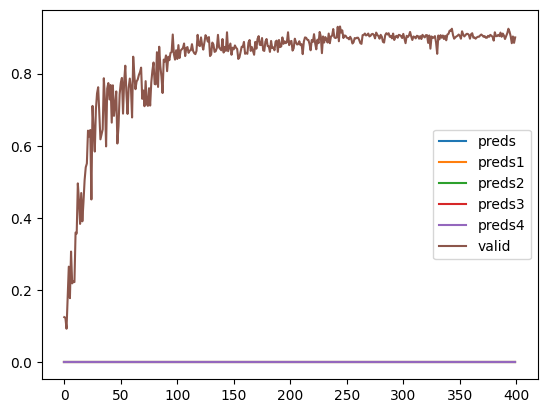

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/400 [00:00<?, ?it/s]

***训练集***
0.11125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/400 [00:06<40:16,  6.06s/it]

valid-f1: 0.0537286112089703
valid-precision: 0.07722650931000687
valid-recall: 0.11032414369256476
process: 1  loss: 57.55444407463074  train_correct: 0.008432022738038844 valid_loss 83.05636048316956  val_correct: 0.07836153161175423
The model has been saved!!
The best val_acc is  0.07836153161175423
***训练集***
0.1275


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 2/400 [00:12<40:15,  6.07s/it]

valid-f1: 0.07351838035747442
valid-precision: 0.0652987203037498
valid-recall: 0.1334419381787803
process: 2  loss: 57.384265184402466  train_correct: 0.00966366650876362 valid_loss 82.38716626167297  val_correct: 0.13000890471950133
The model has been saved!!
The best val_acc is  0.13000890471950133
***训练集***
0.16375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 3/400 [00:18<40:02,  6.05s/it]

valid-f1: 0.0861582714908458
valid-precision: 0.08273467032596915
valid-recall: 0.13372779775525773
process: 3  loss: 57.09756898880005  train_correct: 0.01241117953576504 valid_loss 82.18358564376831  val_correct: 0.16028495102404275
The model has been saved!!
The best val_acc is  0.16028495102404275
***训练集***
0.17875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/400 [00:24<40:11,  6.09s/it]

valid-f1: 0.08251967774670563
valid-precision: 0.09861519013526093
valid-recall: 0.1142427544487041
process: 4  loss: 56.790340423583984  train_correct: 0.013548081477972524 valid_loss 81.41130924224854  val_correct: 0.20926090828138913
The model has been saved!!
The best val_acc is  0.20926090828138913
***训练集***
0.2275


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▏         | 5/400 [00:30<39:58,  6.07s/it]

valid-f1: 0.15023691723683102
valid-precision: 0.20451316990495813
valid-recall: 0.16505232448710708
process: 5  loss: 56.10642337799072  train_correct: 0.01724301279014685 valid_loss 81.30770301818848  val_correct: 0.21193232413178986
The model has been saved!!
The best val_acc is  0.21193232413178986
***训练集***
0.22


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 6/400 [00:36<39:43,  6.05s/it]

valid-f1: 0.11667460487818104
valid-precision: 0.10465370806211835
valid-recall: 0.15356117566643884
process: 6  loss: 55.71368718147278  train_correct: 0.01667456181904311 valid_loss 80.11931872367859  val_correct: 0.21193232413178986
***训练集***
0.255


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 7/400 [00:42<39:35,  6.04s/it]

valid-f1: 0.1052106784732119
valid-precision: 0.09761913009194721
valid-recall: 0.17725374041163514
process: 7  loss: 54.44190502166748  train_correct: 0.01932733301752724 valid_loss 79.61993098258972  val_correct: 0.21994657168299198
The model has been saved!!
The best val_acc is  0.21994657168299198
***训练集***
0.265


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 8/400 [00:48<39:29,  6.05s/it]

valid-f1: 0.1812495686494267
valid-precision: 0.22512612492295997
valid-recall: 0.20369864054074577
process: 8  loss: 53.728806257247925  train_correct: 0.020085267645665563 valid_loss 77.99580156803131  val_correct: 0.28138913624220835
The model has been saved!!
The best val_acc is  0.28138913624220835
***训练集***
0.29375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 9/400 [00:54<39:22,  6.04s/it]

valid-f1: 0.21380295795505777
valid-precision: 0.3196623712350767
valid-recall: 0.2403580756898835
process: 9  loss: 51.64802300930023  train_correct: 0.02226432970156324 valid_loss 74.56081652641296  val_correct: 0.3143365983971505
The model has been saved!!
The best val_acc is  0.3143365983971505
***训练集***
0.33625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▎         | 10/400 [01:00<39:29,  6.08s/it]

valid-f1: 0.09944709350137945
valid-precision: 0.11167142381428094
valid-recall: 0.14066024745658612
process: 10  loss: 49.05920398235321  train_correct: 0.02548555187115111 valid_loss 70.1995929479599  val_correct: 0.25022261798753337
***训练集***
0.365


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 11/400 [01:06<39:20,  6.07s/it]

valid-f1: 0.1441432465316525
valid-precision: 0.267786910426222
valid-recall: 0.2070205157161679
process: 11  loss: 46.271127700805664  train_correct: 0.027664613927048793 valid_loss 67.91687113046646  val_correct: 0.30008904719501334
***训练集***
0.39875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 12/400 [01:12<39:18,  6.08s/it]

valid-f1: 0.257678825405541
valid-precision: 0.34880257850844015
valid-recall: 0.30616184730601204
process: 12  loss: 44.531373143196106  train_correct: 0.03022264329701563 valid_loss 64.88693130016327  val_correct: 0.38023152270703475
The model has been saved!!
The best val_acc is  0.38023152270703475
***训练集***
0.40625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 13/400 [01:18<39:11,  6.08s/it]

valid-f1: 0.3648882673912143
valid-precision: 0.46156039063170873
valid-recall: 0.39116315162081755
process: 13  loss: 42.081172585487366  train_correct: 0.030791094268119375 valid_loss 53.3477087020874  val_correct: 0.4879786286731968
The model has been saved!!
The best val_acc is  0.4879786286731968
***训练集***
0.44875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▎         | 14/400 [01:24<38:56,  6.05s/it]

valid-f1: 0.33431890946489723
valid-precision: 0.48756314850341403
valid-recall: 0.3320257164650757
process: 14  loss: 40.505595088005066  train_correct: 0.034012316437707246 valid_loss 56.80818098783493  val_correct: 0.44078361531611754
***训练集***
0.48


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 15/400 [01:31<39:01,  6.08s/it]

valid-f1: 0.38320206646476257
valid-precision: 0.35612122147003344
valid-recall: 0.45293923213831677
process: 15  loss: 37.859466671943665  train_correct: 0.03638086215063951 valid_loss 48.10357367992401  val_correct: 0.5138023152270703
The model has been saved!!
The best val_acc is  0.5138023152270703
***训练集***
0.555


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 16/400 [01:36<38:43,  6.05s/it]

valid-f1: 0.3216890668110047
valid-precision: 0.32115685553851253
valid-recall: 0.36259852529875414
process: 16  loss: 34.2288920879364  train_correct: 0.04206537186167693 valid_loss 51.279864341020584  val_correct: 0.45325022261798753
***训练集***
0.545


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 17/400 [01:43<38:38,  6.05s/it]

valid-f1: 0.4011639793512378
valid-precision: 0.5807791214734536
valid-recall: 0.4603364801991804
process: 17  loss: 34.58845889568329  train_correct: 0.04130743723353861 valid_loss 45.61967381834984  val_correct: 0.5458593054318789
The model has been saved!!
The best val_acc is  0.5458593054318789
***训练集***
0.5675


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 18/400 [01:49<38:34,  6.06s/it]

valid-f1: 0.48579879345531296
valid-precision: 0.5200728657846206
valid-recall: 0.5297464015770652
process: 18  loss: 32.537387013435364  train_correct: 0.04301279014684983 valid_loss 46.5448092520237  val_correct: 0.5681211041852182
The model has been saved!!
The best val_acc is  0.5681211041852182
***训练集***
0.59125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  5%|▍         | 19/400 [01:55<38:19,  6.04s/it]

valid-f1: 0.41674984440767054
valid-precision: 0.44786831671798993
valid-recall: 0.45785976799706773
process: 19  loss: 30.487425565719604  train_correct: 0.04481288488867835 valid_loss 49.28535372018814  val_correct: 0.4835262689225289
***训练集***
0.64125


  5%|▌         | 20/400 [02:01<38:32,  6.09s/it]

valid-f1: 0.5387904739638707
valid-precision: 0.6628293777743924
valid-recall: 0.5634478224546875
process: 20  loss: 28.357445538043976  train_correct: 0.04860255802936997 valid_loss 38.51522234082222  val_correct: 0.6188780053428317
The model has been saved!!
The best val_acc is  0.6188780053428317
***训练集***
0.63


  5%|▌         | 21/400 [02:07<38:26,  6.09s/it]

valid-f1: 0.5609114822356666
valid-precision: 0.7068815353997623
valid-recall: 0.567604085972507
process: 21  loss: 29.0992294549942  train_correct: 0.047749881572714356 valid_loss 40.0636902153492  val_correct: 0.6081923419412288
***训练集***
0.6575


  6%|▌         | 22/400 [02:13<38:14,  6.07s/it]

valid-f1: 0.4478910606959274
valid-precision: 0.6054810483404209
valid-recall: 0.4497837148866897
process: 22  loss: 28.57969582080841  train_correct: 0.04983420180009474 valid_loss 71.82031407952309  val_correct: 0.41852181656277826
***训练集***
0.70375


  6%|▌         | 23/400 [02:19<38:10,  6.08s/it]

valid-f1: 0.5826662854605135
valid-precision: 0.7341891503811031
valid-recall: 0.5886310407111323
process: 23  loss: 24.68483018875122  train_correct: 0.053339649455234485 valid_loss 34.787217393517494  val_correct: 0.641139804096171
The model has been saved!!
The best val_acc is  0.641139804096171
***训练集***
0.705


  6%|▌         | 24/400 [02:25<38:02,  6.07s/it]

valid-f1: 0.6337741033522115
valid-precision: 0.6712799605416488
valid-recall: 0.6432278324269171
process: 24  loss: 24.843343019485474  train_correct: 0.05343439128375178 valid_loss 32.75213995575905  val_correct: 0.6767586821015138
The model has been saved!!
The best val_acc is  0.6767586821015138
***训练集***
0.70375


  6%|▋         | 25/400 [02:31<38:14,  6.12s/it]

valid-f1: 0.6788842274284967
valid-precision: 0.7182687558329779
valid-recall: 0.6880144432226813
process: 25  loss: 24.092084884643555  train_correct: 0.053339649455234485 valid_loss 31.99328425526619  val_correct: 0.6999109528049866
The model has been saved!!
The best val_acc is  0.6999109528049866
***训练集***
0.7225


  6%|▋         | 26/400 [02:37<38:06,  6.11s/it]

valid-f1: 0.7268792310784689
valid-precision: 0.7580540698772615
valid-recall: 0.7520278562017693
process: 26  loss: 23.153636038303375  train_correct: 0.05476077688299384 valid_loss 30.517191253602505  val_correct: 0.7310774710596616
The model has been saved!!
The best val_acc is  0.7310774710596616
***训练集***
0.74125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  7%|▋         | 27/400 [02:43<37:47,  6.08s/it]

valid-f1: 0.5386509583984457
valid-precision: 0.634086973379956
valid-recall: 0.577256382061874
process: 27  loss: 21.61744636297226  train_correct: 0.0561819043107532 valid_loss 41.73875130712986  val_correct: 0.603739982190561
***训练集***
0.7325


  7%|▋         | 28/400 [02:49<37:43,  6.08s/it]

valid-f1: 0.7347133126497047
valid-precision: 0.7412878021334658
valid-recall: 0.7490544939423658
process: 28  loss: 22.0672989487648  train_correct: 0.05551871151113216 valid_loss 26.447988748550415  val_correct: 0.7586821015138023
The model has been saved!!
The best val_acc is  0.7586821015138023
***训练集***
0.745


  7%|▋         | 29/400 [02:55<37:22,  6.04s/it]

valid-f1: 0.6778096808214491
valid-precision: 0.7194860697497302
valid-recall: 0.7169300887264274
process: 29  loss: 21.000723719596863  train_correct: 0.05646612979630507 valid_loss 32.37434671074152  val_correct: 0.7016918967052538
***训练集***
0.7475


  8%|▊         | 30/400 [03:02<37:33,  6.09s/it]

valid-f1: 0.5755433039420468
valid-precision: 0.7684574653927064
valid-recall: 0.5950746794522539
process: 30  loss: 20.058166086673737  train_correct: 0.05665561345333965 valid_loss 38.170119754970074  val_correct: 0.6375779162956366
***训练集***
0.7275


  8%|▊         | 31/400 [03:08<37:22,  6.08s/it]

valid-f1: 0.6578018791678812
valid-precision: 0.7670295050236712
valid-recall: 0.668546349404473
process: 31  loss: 21.664347410202026  train_correct: 0.055139744197063 valid_loss 35.89659948274493  val_correct: 0.6731967943009796
***训练集***
0.77


  8%|▊         | 32/400 [03:14<37:16,  6.08s/it]

valid-f1: 0.7028229917134242
valid-precision: 0.8077763496417469
valid-recall: 0.6896940605796441
process: 32  loss: 18.501279413700104  train_correct: 0.05836096636665088 valid_loss 28.02097101509571  val_correct: 0.7266251113089938
***训练集***
0.72


  8%|▊         | 33/400 [03:20<37:15,  6.09s/it]

valid-f1: 0.7817303220494718
valid-precision: 0.8085004318519406
valid-recall: 0.795059836679974
process: 33  loss: 21.031221389770508  train_correct: 0.05457129322595926 valid_loss 26.841153502464294  val_correct: 0.7791629563668745
The model has been saved!!
The best val_acc is  0.7791629563668745
***训练集***
0.76125


  8%|▊         | 34/400 [03:26<37:03,  6.07s/it]

valid-f1: 0.6303016182903953
valid-precision: 0.6743514156734369
valid-recall: 0.6763278221905225
process: 34  loss: 19.57866308093071  train_correct: 0.05769777356702984 valid_loss 42.324079394340515  val_correct: 0.616206589492431
***训练集***
0.79125


  9%|▉         | 35/400 [03:32<37:02,  6.09s/it]

valid-f1: 0.7014281088350925
valid-precision: 0.7771697206686851
valid-recall: 0.6938329750595196
process: 35  loss: 17.483175456523895  train_correct: 0.05997157745144481 valid_loss 29.903634626418352  val_correct: 0.697239536954586
***训练集***
0.80875


  9%|▉         | 36/400 [03:38<36:51,  6.08s/it]

valid-f1: 0.6887470580741039
valid-precision: 0.7761003738027337
valid-recall: 0.723400751549493
process: 36  loss: 16.90798756480217  train_correct: 0.061297963050686875 valid_loss 31.6445072889328  val_correct: 0.7212822796081924
***训练集***
0.79875


  9%|▉         | 37/400 [03:44<36:35,  6.05s/it]

valid-f1: 0.6994177901752381
valid-precision: 0.7958395014914069
valid-recall: 0.6873117477488186
process: 37  loss: 15.905162930488586  train_correct: 0.060540028422548554 valid_loss 27.769626095891  val_correct: 0.7123775601068566
***训练集***
0.76


 10%|▉         | 38/400 [03:50<36:27,  6.04s/it]

valid-f1: 0.646501909349521
valid-precision: 0.7688349133951482
valid-recall: 0.6708838796596234
process: 38  loss: 19.10447335243225  train_correct: 0.057603031738512556 valid_loss 32.80189776420593  val_correct: 0.691006233303651
***训练集***
0.79


 10%|▉         | 39/400 [03:56<36:20,  6.04s/it]

valid-f1: 0.5647303640398693
valid-precision: 0.7154226003565193
valid-recall: 0.5912902480179368
process: 39  loss: 16.779868215322495  train_correct: 0.059876835622927525 valid_loss 42.4337491504848  val_correct: 0.5832591273374889
***训练集***
0.76625


 10%|█         | 40/400 [04:02<36:16,  6.05s/it]

valid-f1: 0.6748379534142778
valid-precision: 0.7162734887589609
valid-recall: 0.7149753996321502
process: 40  loss: 17.567759543657303  train_correct: 0.05807674088109901 valid_loss 35.28215406835079  val_correct: 0.684772929652716
***训练集***
0.8025


 10%|█         | 41/400 [04:09<36:38,  6.13s/it]

valid-f1: 0.7871759925006853
valid-precision: 0.8074444410423178
valid-recall: 0.7872653438603094
process: 41  loss: 16.489592969417572  train_correct: 0.06082425390810042 valid_loss 20.430796034634113  val_correct: 0.7916295636687445
The model has been saved!!
The best val_acc is  0.7916295636687445
***训练集***
0.81125


 10%|█         | 42/400 [04:15<36:21,  6.09s/it]

valid-f1: 0.6453295657870097
valid-precision: 0.7825714322401172
valid-recall: 0.6430777008397146
process: 42  loss: 15.614285111427307  train_correct: 0.06148744670772146 valid_loss 34.66684741899371  val_correct: 0.6571682991985752
***训练集***
0.76875


 11%|█         | 43/400 [04:21<36:08,  6.07s/it]

valid-f1: 0.7368552750315785
valid-precision: 0.7498212097777576
valid-recall: 0.7404566290561714
process: 43  loss: 16.829262793064117  train_correct: 0.058266224538133585 valid_loss 21.994662582874298  val_correct: 0.7479964381121995
***训练集***
0.8175


 11%|█         | 44/400 [04:27<36:02,  6.07s/it]

valid-f1: 0.7658361515219918
valid-precision: 0.8045311974928155
valid-recall: 0.7677794189029886
process: 44  loss: 15.534366071224213  train_correct: 0.06196115585030791 valid_loss 21.872393064200878  val_correct: 0.7969723953695459
The model has been saved!!
The best val_acc is  0.7969723953695459
***训练集***
0.7925


 11%|█▏        | 45/400 [04:33<35:45,  6.04s/it]

valid-f1: 0.6589563736634253
valid-precision: 0.7347200379595457
valid-recall: 0.6738645394778118
process: 45  loss: 16.089228957891464  train_correct: 0.0600663192799621 valid_loss 32.854972368106246  val_correct: 0.6634016028495102
***训练集***
0.79375


 12%|█▏        | 46/400 [04:39<35:55,  6.09s/it]

valid-f1: 0.8056397926146796
valid-precision: 0.8277891063162321
valid-recall: 0.8401314881406414
process: 46  loss: 16.12232866883278  train_correct: 0.060161061108479394 valid_loss 26.81166596710682  val_correct: 0.786286731967943
***训练集***
0.76625


 12%|█▏        | 47/400 [04:45<35:35,  6.05s/it]

valid-f1: 0.6881893224793124
valid-precision: 0.7811575884392601
valid-recall: 0.6870061121182403
process: 47  loss: 16.844193935394287  train_correct: 0.05807674088109901 valid_loss 28.929372645914555  val_correct: 0.7132680320569902
***训练集***
0.825


 12%|█▏        | 48/400 [04:51<35:28,  6.05s/it]

valid-f1: 0.7259736626927092
valid-precision: 0.7728907671955735
valid-recall: 0.7340036289670157
process: 48  loss: 14.080342203378677  train_correct: 0.06252960682141165 valid_loss 22.16743236966431  val_correct: 0.7471059661620659
***训练集***
0.82875


 12%|█▏        | 49/400 [04:57<35:19,  6.04s/it]

valid-f1: 0.7179807517009174
valid-precision: 0.782612328191641
valid-recall: 0.7665273163145017
process: 49  loss: 13.347756385803223  train_correct: 0.06281383230696352 valid_loss 28.662539521232247  val_correct: 0.7337488869100623
***训练集***
0.8325


 12%|█▎        | 50/400 [05:03<35:05,  6.02s/it]

valid-f1: 0.7290725552397989
valid-precision: 0.796432850168703
valid-recall: 0.7432534267156693
process: 50  loss: 13.34061911702156  train_correct: 0.0630980577925154 valid_loss 30.925724314525723  val_correct: 0.717720391807658
***训练集***
0.81375


 13%|█▎        | 51/400 [05:09<35:12,  6.05s/it]

valid-f1: 0.7987604656241111
valid-precision: 0.8125415418906259
valid-recall: 0.8406146129487089
process: 51  loss: 14.394110351800919  train_correct: 0.06167693036475604 valid_loss 23.742449522018433  val_correct: 0.7880676758682101
***训练集***
0.83125


 13%|█▎        | 52/400 [05:15<35:02,  6.04s/it]

valid-f1: 0.7436656365248584
valid-precision: 0.8244914178559128
valid-recall: 0.7323767983859517
process: 52  loss: 13.890822544693947  train_correct: 0.06300331596399811 valid_loss 26.383245802484453  val_correct: 0.7524487978628673
***训练集***
0.82625


 13%|█▎        | 53/400 [05:21<34:50,  6.02s/it]

valid-f1: 0.7116708745789312
valid-precision: 0.7376125031194942
valid-recall: 0.7327779197664781
process: 53  loss: 13.603885918855667  train_correct: 0.06262434864992894 valid_loss 25.962588980793953  val_correct: 0.7230632235084595
***训练集***
0.8275


 14%|█▎        | 54/400 [05:27<34:47,  6.03s/it]

valid-f1: 0.7442158254080153
valid-precision: 0.8068309507838757
valid-recall: 0.749995360601768
process: 54  loss: 14.014250546693802  train_correct: 0.06271909047844623 valid_loss 30.342648842372  val_correct: 0.7248441674087266
***训练集***
0.82625


 14%|█▍        | 55/400 [05:33<34:39,  6.03s/it]

valid-f1: 0.6261254524913551
valid-precision: 0.7805323835634717
valid-recall: 0.6204064707222602
process: 55  loss: 13.489089369773865  train_correct: 0.06262434864992894 valid_loss 38.333742052316666  val_correct: 0.622439893143366
***训练集***
0.83125


 14%|█▍        | 56/400 [05:39<34:44,  6.06s/it]

valid-f1: 0.8139211389555774
valid-precision: 0.8431530404134792
valid-recall: 0.8186107528372973
process: 56  loss: 13.207422286272049  train_correct: 0.06300331596399811 valid_loss 16.874313946813345  val_correct: 0.8236865538735529
The model has been saved!!
The best val_acc is  0.8236865538735529
***训练集***
0.84125


 14%|█▍        | 57/400 [05:45<34:39,  6.06s/it]

valid-f1: 0.7529756636320619
valid-precision: 0.8071933026687665
valid-recall: 0.7675873478161808
process: 57  loss: 12.927627205848694  train_correct: 0.06376125059213643 valid_loss 25.60432356968522  val_correct: 0.7711487088156723
***训练集***
0.835


 14%|█▍        | 58/400 [05:51<34:35,  6.07s/it]

valid-f1: 0.740094195501799
valid-precision: 0.8140408397473035
valid-recall: 0.7342284862353512
process: 58  loss: 13.768900394439697  train_correct: 0.06328754144954997 valid_loss 26.62968174368143  val_correct: 0.7355298308103295
***训练集***
0.83875


 15%|█▍        | 59/400 [05:57<34:28,  6.07s/it]

valid-f1: 0.7746752620112123
valid-precision: 0.8423789733672116
valid-recall: 0.7595392235529534
process: 59  loss: 12.876530915498734  train_correct: 0.06357176693510184 valid_loss 21.43991643562913  val_correct: 0.7720391807658059
***训练集***
0.835


 15%|█▌        | 60/400 [06:03<34:18,  6.05s/it]

valid-f1: 0.8103639585073653
valid-precision: 0.8534350278274443
valid-recall: 0.8210058776717816
process: 60  loss: 13.475690752267838  train_correct: 0.06328754144954997 valid_loss 20.6152074187994  val_correct: 0.8174532502226179
***训练集***
0.8175


 15%|█▌        | 61/400 [06:10<34:23,  6.09s/it]

valid-f1: 0.7101968738417214
valid-precision: 0.8021073979735714
valid-recall: 0.7234458346128827
process: 61  loss: 14.811675190925598  train_correct: 0.06196115585030791 valid_loss 25.274638682603836  val_correct: 0.7186108637577916
***训练集***
0.82875


 16%|█▌        | 62/400 [06:16<34:13,  6.08s/it]

valid-f1: 0.8396541514017771
valid-precision: 0.8578954836666839
valid-recall: 0.8472639999207505
process: 62  loss: 12.893758624792099  train_correct: 0.06281383230696352 valid_loss 14.346433768048882  val_correct: 0.8504007123775601
The model has been saved!!
The best val_acc is  0.8504007123775601
***训练集***
0.8475


 16%|█▌        | 63/400 [06:22<34:04,  6.07s/it]

valid-f1: 0.796367676029307
valid-precision: 0.860722386472885
valid-recall: 0.7730050290416421
process: 63  loss: 12.805033773183823  train_correct: 0.06423495973472287 valid_loss 21.81950180977583  val_correct: 0.8032056990204809
***训练集***
0.84125


 16%|█▌        | 64/400 [06:28<33:52,  6.05s/it]

valid-f1: 0.8390908552913631
valid-precision: 0.8561099842969592
valid-recall: 0.8476842336407554
process: 64  loss: 12.72675010561943  train_correct: 0.06376125059213643 valid_loss 15.867616809904575  val_correct: 0.8495102404274265
***训练集***
0.85625


 16%|█▋        | 65/400 [06:34<33:41,  6.03s/it]

valid-f1: 0.8323920318608661
valid-precision: 0.86885201322081
valid-recall: 0.8498514600070666
process: 65  loss: 12.145585879683495  train_correct: 0.06489815253434392 valid_loss 21.330212518572807  val_correct: 0.798753339269813
***训练集***
0.82125


 16%|█▋        | 66/400 [06:40<33:39,  6.05s/it]

valid-f1: 0.8189195575668305
valid-precision: 0.8575254627733717
valid-recall: 0.8096989146119581
process: 66  loss: 13.696564346551895  train_correct: 0.06224538133585978 valid_loss 16.591988675296307  val_correct: 0.8094390026714159
***训练集***
0.84625


 17%|█▋        | 67/400 [06:46<33:30,  6.04s/it]

valid-f1: 0.7974255284021357
valid-precision: 0.8081857653365813
valid-recall: 0.8303076135661946
process: 67  loss: 11.48929312825203  train_correct: 0.0641402179062056 valid_loss 19.14961738139391  val_correct: 0.8058771148708815
***训练集***
0.86


 17%|█▋        | 68/400 [06:52<33:24,  6.04s/it]

valid-f1: 0.84880951401292
valid-precision: 0.8547268515883737
valid-recall: 0.8711945212174046
process: 68  loss: 11.264628127217293  train_correct: 0.06518237801989578 valid_loss 16.874612033367157  val_correct: 0.8308103294746215
***训练集***
0.8525


 17%|█▋        | 69/400 [06:58<33:19,  6.04s/it]

valid-f1: 0.7652378198871463
valid-precision: 0.7816206478063032
valid-recall: 0.8039165700813298
process: 69  loss: 11.884773433208466  train_correct: 0.06461392704879204 valid_loss 22.90891019999981  val_correct: 0.7720391807658059
***训练集***
0.84


 18%|█▊        | 70/400 [07:04<33:11,  6.03s/it]

valid-f1: 0.8333345160508184
valid-precision: 0.8282337122548169
valid-recall: 0.8699962257422211
process: 70  loss: 13.057585656642914  train_correct: 0.06366650876361914 valid_loss 18.74819567427039  val_correct: 0.8317008014247551
***训练集***
0.86625


 18%|█▊        | 71/400 [07:10<33:01,  6.02s/it]

valid-f1: 0.6914966139734793
valid-precision: 0.8354005484696729
valid-recall: 0.7081035592934907
process: 71  loss: 11.215079978108406  train_correct: 0.06565608716248224 valid_loss 34.59694535471499  val_correct: 0.711487088156723
***训练集***
0.83625


 18%|█▊        | 72/400 [07:16<33:10,  6.07s/it]

valid-f1: 0.7924881076303277
valid-precision: 0.8015260852771107
valid-recall: 0.8194366746906793
process: 72  loss: 12.759665489196777  train_correct: 0.06338228327806726 valid_loss 21.40762097388506  val_correct: 0.7889581478183437
***训练集***
0.86


 18%|█▊        | 73/400 [07:22<32:58,  6.05s/it]

valid-f1: 0.7617885848620931
valid-precision: 0.8210388471379361
valid-recall: 0.7597002750618311
process: 73  loss: 11.671461656689644  train_correct: 0.06518237801989578 valid_loss 20.345177806913853  val_correct: 0.761353517364203
***训练集***
0.84625


 18%|█▊        | 74/400 [07:28<32:50,  6.04s/it]

valid-f1: 0.6688990902099563
valid-precision: 0.7724123198662348
valid-recall: 0.6930522056128463
process: 74  loss: 11.814011842012405  train_correct: 0.0641402179062056 valid_loss 32.17414905875921  val_correct: 0.6981300089047195
***训练集***
0.8575


 19%|█▉        | 75/400 [07:34<32:39,  6.03s/it]

valid-f1: 0.8162143016384086
valid-precision: 0.8382480584619205
valid-recall: 0.8333180084598849
process: 75  loss: 11.054446518421173  train_correct: 0.06499289436286121 valid_loss 19.848175445571542  val_correct: 0.8183437221727515
***训练集***
0.85


 19%|█▉        | 76/400 [07:40<32:28,  6.02s/it]

valid-f1: 0.789895560032722
valid-precision: 0.8129167992456818
valid-recall: 0.8046519328624593
process: 76  loss: 11.742210865020752  train_correct: 0.06442444339175746 valid_loss 21.427052540704608  val_correct: 0.7747105966162066
***训练集***
0.845


 19%|█▉        | 77/400 [07:46<32:29,  6.03s/it]

valid-f1: 0.7878316394095746
valid-precision: 0.8019988730098682
valid-recall: 0.8177319880729492
process: 77  loss: 11.314024567604065  train_correct: 0.0640454760776883 valid_loss 24.00430316478014  val_correct: 0.7871772039180766
***训练集***
0.8725


 20%|█▉        | 78/400 [07:52<32:25,  6.04s/it]

valid-f1: 0.6896435496642105
valid-precision: 0.7931634465589653
valid-recall: 0.7008186342007853
process: 78  loss: 10.273858398199081  train_correct: 0.06612979630506868 valid_loss 35.627051055431366  val_correct: 0.6821015138023152
***训练集***
0.8575


 20%|█▉        | 79/400 [07:58<32:15,  6.03s/it]

valid-f1: 0.7572022707573524
valid-precision: 0.8080671177027922
valid-recall: 0.7652507091179859
process: 79  loss: 12.025251030921936  train_correct: 0.06499289436286121 valid_loss 20.667388761416078  val_correct: 0.7764915405164737
***训练集***
0.84125


 20%|██        | 80/400 [08:04<32:07,  6.02s/it]

valid-f1: 0.7579210097861486
valid-precision: 0.7730960266401654
valid-recall: 0.7971625968742675
process: 80  loss: 11.718480706214905  train_correct: 0.06376125059213643 valid_loss 24.08663677610457  val_correct: 0.7622439893143366
***训练集***
0.855


 20%|██        | 81/400 [08:10<32:00,  6.02s/it]

valid-f1: 0.7102390105140498
valid-precision: 0.8349504094437428
valid-recall: 0.6884101756367202
process: 81  loss: 10.73027415573597  train_correct: 0.06480341070582663 valid_loss 25.3114251838997  val_correct: 0.736420302760463
***训练集***
0.83375


 20%|██        | 82/400 [08:16<31:55,  6.02s/it]

valid-f1: 0.7708335540830591
valid-precision: 0.8271274743834238
valid-recall: 0.7707492215386952
process: 82  loss: 12.58674344420433  train_correct: 0.06319279962103269 valid_loss 24.943520072847605  val_correct: 0.7560106856634016
***训练集***
0.865


 21%|██        | 83/400 [08:22<31:45,  6.01s/it]

valid-f1: 0.6553476629989861
valid-precision: 0.7525518101037468
valid-recall: 0.6951645483933813
process: 83  loss: 10.542536064982414  train_correct: 0.06556134533396495 valid_loss 35.76329634897411  val_correct: 0.661620658949243
***训练集***
0.87875


 21%|██        | 84/400 [08:28<31:33,  5.99s/it]

valid-f1: 0.7006717169500533
valid-precision: 0.7836762263896272
valid-recall: 0.7228479003833694
process: 84  loss: 9.726690605282784  train_correct: 0.06660350544765514 valid_loss 29.124735038727522  val_correct: 0.7043633125556545
***训练集***
0.84875


 21%|██▏       | 85/400 [08:34<31:29,  6.00s/it]

valid-f1: 0.7535890426840905
valid-precision: 0.7838713858392451
valid-recall: 0.7787369642815867
process: 85  loss: 12.02059155702591  train_correct: 0.06432970156324017 valid_loss 23.45949185732752  val_correct: 0.7622439893143366
***训练集***
0.8475


 22%|██▏       | 86/400 [08:40<31:24,  6.00s/it]

valid-f1: 0.676459795671013
valid-precision: 0.6998757663685901
valid-recall: 0.7245876185853304
process: 86  loss: 10.913380652666092  train_correct: 0.06423495973472287 valid_loss 38.82978389039636  val_correct: 0.6438112199465716
***训练集***
0.8725


 22%|██▏       | 87/400 [08:46<31:33,  6.05s/it]

valid-f1: 0.818012592873613
valid-precision: 0.8401881436446198
valid-recall: 0.8367115483042257
process: 87  loss: 10.377483442425728  train_correct: 0.06612979630506868 valid_loss 17.93509564548731  val_correct: 0.8379341050756901
***训练集***
0.86


 22%|██▏       | 88/400 [08:52<31:20,  6.03s/it]

valid-f1: 0.7332786353901087
valid-precision: 0.8355863211780639
valid-recall: 0.7369354611826008
process: 88  loss: 10.931325912475586  train_correct: 0.06518237801989578 valid_loss 31.687002293765545  val_correct: 0.717720391807658
***训练集***
0.8725


 22%|██▏       | 89/400 [08:58<31:19,  6.04s/it]

valid-f1: 0.7981426352960308
valid-precision: 0.7931502739805572
valid-recall: 0.8307773881343674
process: 89  loss: 10.687788918614388  train_correct: 0.06612979630506868 valid_loss 23.087603211402893  val_correct: 0.7693677649154052
***训练集***
0.84125


 22%|██▎       | 90/400 [09:04<31:07,  6.02s/it]

valid-f1: 0.7300334626304487
valid-precision: 0.7946161513851439
valid-recall: 0.7506514474592276
process: 90  loss: 11.951376229524612  train_correct: 0.06376125059213643 valid_loss 26.968853443861008  val_correct: 0.7355298308103295
***训练集***
0.86875


 23%|██▎       | 91/400 [09:10<30:59,  6.02s/it]

valid-f1: 0.7393938068845108
valid-precision: 0.7536580108785078
valid-recall: 0.783691699604743
process: 91  loss: 9.936827048659325  train_correct: 0.06584557081951682 valid_loss 24.549899024888873  val_correct: 0.7266251113089938
***训练集***
0.845


 23%|██▎       | 92/400 [09:16<31:02,  6.05s/it]

valid-f1: 0.7493105935695328
valid-precision: 0.8012146241511868
valid-recall: 0.7706776724419745
process: 92  loss: 11.445759482681751  train_correct: 0.0640454760776883 valid_loss 25.96545741474256  val_correct: 0.7382012466607302
***训练集***
0.85875


 23%|██▎       | 93/400 [09:22<30:49,  6.02s/it]

valid-f1: 0.7908490659849396
valid-precision: 0.8222226771721319
valid-recall: 0.7845407821265946
process: 93  loss: 10.88426524400711  train_correct: 0.06508763619137849 valid_loss 17.648211147636175  val_correct: 0.7996438112199465
***训练集***
0.88


 24%|██▎       | 94/400 [09:28<30:43,  6.02s/it]

valid-f1: 0.768489139971628
valid-precision: 0.8134778925029356
valid-recall: 0.7856835864364469
process: 94  loss: 9.85787495970726  train_correct: 0.06669824727617243 valid_loss 23.64025294734165  val_correct: 0.7640249332146037
***训练集***
0.88375


 24%|██▍       | 95/400 [09:34<30:32,  6.01s/it]

valid-f1: 0.8334009194454209
valid-precision: 0.864739406935062
valid-recall: 0.8327334541888318
process: 95  loss: 9.707057058811188  train_correct: 0.0669824727617243 valid_loss 16.440099738538265  val_correct: 0.8147818343722173
***训练集***
0.85375


 24%|██▍       | 96/400 [09:40<30:26,  6.01s/it]

valid-f1: 0.7462701007675775
valid-precision: 0.8131129361779648
valid-recall: 0.7542212216971942
process: 96  loss: 11.321462571620941  train_correct: 0.06470866887730933 valid_loss 21.848367992322892  val_correct: 0.7658058771148709
***训练集***
0.87125


 24%|██▍       | 97/400 [09:46<30:20,  6.01s/it]

valid-f1: 0.7351834191814357
valid-precision: 0.7592650299584179
valid-recall: 0.7791707760838195
process: 97  loss: 9.796691685914993  train_correct: 0.06603505447655139 valid_loss 31.777355363592505  val_correct: 0.723953695458593
***训练集***
0.85625


 24%|██▍       | 98/400 [09:53<30:28,  6.05s/it]

valid-f1: 0.7353115894792457
valid-precision: 0.7615255240026417
valid-recall: 0.7699089885451442
process: 98  loss: 11.26510314643383  train_correct: 0.06489815253434392 valid_loss 25.707465312443674  val_correct: 0.7275155832591274
***训练集***
0.89125


 25%|██▍       | 99/400 [09:59<30:18,  6.04s/it]

valid-f1: 0.7844130781523371
valid-precision: 0.7815548139423111
valid-recall: 0.811232194451874
process: 99  loss: 9.4925307482481  train_correct: 0.06755092373282805 valid_loss 21.532247012481093  val_correct: 0.7702582368655387
***训练集***
0.85625


 25%|██▌       | 100/400 [10:05<30:10,  6.04s/it]

valid-f1: 0.8071558647184809
valid-precision: 0.862147480646677
valid-recall: 0.7974373978424321
process: 100  loss: 10.357409924268723  train_correct: 0.06489815253434392 valid_loss 20.09789440082386  val_correct: 0.8058771148708815
***训练集***
0.86875


 25%|██▌       | 101/400 [10:11<30:02,  6.03s/it]

valid-f1: 0.8273502271129795
valid-precision: 0.861288566270396
valid-recall: 0.8275688265459433
process: 101  loss: 9.760130017995834  train_correct: 0.06584557081951682 valid_loss 18.220997966825962  val_correct: 0.7996438112199465
***训练集***
0.8725


 26%|██▌       | 102/400 [10:17<29:51,  6.01s/it]

valid-f1: 0.7984577744120844
valid-precision: 0.8355254270611445
valid-recall: 0.7899528531473611
process: 102  loss: 9.431030869483948  train_correct: 0.06612979630506868 valid_loss 21.267670260742307  val_correct: 0.7604630454140695
***训练集***
0.8875


 26%|██▌       | 103/400 [10:23<29:53,  6.04s/it]

valid-f1: 0.6987584951073873
valid-precision: 0.7903037066492489
valid-recall: 0.7065996711145452
process: 103  loss: 9.685979053378105  train_correct: 0.06726669824727617 valid_loss 30.249663345515728  val_correct: 0.6981300089047195
***训练集***
0.875


 26%|██▌       | 104/400 [10:29<29:45,  6.03s/it]

valid-f1: 0.6745222755789015
valid-precision: 0.7579693378031629
valid-recall: 0.7038551616194637
process: 104  loss: 9.217680394649506  train_correct: 0.06631927996210327 valid_loss 29.881948428228498  val_correct: 0.6838824577025824
***训练集***
0.84625


 26%|██▋       | 105/400 [10:35<29:34,  6.02s/it]

valid-f1: 0.7380766494889053
valid-precision: 0.8249674812453718
valid-recall: 0.7428656324605981
process: 105  loss: 11.651357531547546  train_correct: 0.0641402179062056 valid_loss 27.60934855788946  val_correct: 0.7471059661620659
***训练集***
0.865


 26%|██▋       | 106/400 [10:41<29:28,  6.01s/it]

valid-f1: 0.7525118390905632
valid-precision: 0.8212644308917267
valid-recall: 0.757655938264634
process: 106  loss: 10.548682898283005  train_correct: 0.06556134533396495 valid_loss 20.634392679668963  val_correct: 0.7693677649154052
***训练集***
0.85125


 27%|██▋       | 107/400 [10:47<29:21,  6.01s/it]

valid-f1: 0.7444662541911937
valid-precision: 0.7894064815726307
valid-recall: 0.7544703359188485
process: 107  loss: 10.931619495153427  train_correct: 0.06451918522027475 valid_loss 25.291036172769964  val_correct: 0.7408726625111309
***训练集***
0.885


 27%|██▋       | 108/400 [10:53<29:24,  6.04s/it]

valid-f1: 0.7683616630886257
valid-precision: 0.7977380425470524
valid-recall: 0.7751920644826824
process: 108  loss: 10.089535303413868  train_correct: 0.06707721459024159 valid_loss 23.103668140480295  val_correct: 0.7666963490650045
***训练集***
0.88
开始蒸馏


 27%|██▋       | 109/400 [10:59<29:15,  6.03s/it]

valid-f1: 0.7952504970446302
valid-precision: 0.8133039236783363
valid-recall: 0.8185480829874422
process: 109  loss: 9.546151265501976  train_correct: 0.06669824727617243 valid_loss 19.707573786377907  val_correct: 0.8085485307212823
***训练集***
0.7825


 28%|██▊       | 110/400 [11:05<29:07,  6.02s/it]

valid-f1: 0.7622991906596487
valid-precision: 0.8248534151733505
valid-recall: 0.7763250385515832
process: 110  loss: 1052.5695152282715  train_correct: 0.05930838465182378 valid_loss 24.803746590274386  val_correct: 0.7827248441674087
***训练集***
0.75625


 28%|██▊       | 111/400 [11:11<29:02,  6.03s/it]

valid-f1: 0.66138678314082
valid-precision: 0.8317038062447386
valid-recall: 0.6425485287659202
process: 111  loss: 731.6267833709717  train_correct: 0.05731880625296068 valid_loss 33.70928810629994  val_correct: 0.7168299198575245
***训练集***
0.70375


 28%|██▊       | 112/400 [11:17<28:52,  6.02s/it]

valid-f1: 0.6355957649546469
valid-precision: 0.8673386898852607
valid-recall: 0.6387732044208017
process: 112  loss: 613.258638381958  train_correct: 0.053339649455234485 valid_loss 29.173405424691737  val_correct: 0.697239536954586
***训练集***
0.78125


 28%|██▊       | 113/400 [11:23<28:52,  6.04s/it]

valid-f1: 0.8117329734767882
valid-precision: 0.8341286672788879
valid-recall: 0.8090148163557774
process: 113  loss: 555.3254909515381  train_correct: 0.05921364282330649 valid_loss 21.627786639728583  val_correct: 0.8014247551202137
***训练集***
0.7475


 28%|██▊       | 114/400 [11:29<28:43,  6.03s/it]

valid-f1: 0.7578649137627538
valid-precision: 0.8451106117236039
valid-recall: 0.7427220158432973
process: 114  loss: 514.0774726867676  train_correct: 0.05665561345333965 valid_loss 24.33512876194436  val_correct: 0.7845057880676759
***训练集***
0.8


 29%|██▉       | 115/400 [11:35<28:35,  6.02s/it]

valid-f1: 0.8027308016120053
valid-precision: 0.8646057653131459
valid-recall: 0.789708031607345
process: 115  loss: 470.1961317062378  train_correct: 0.060634770251065846 valid_loss 17.994082655757666  val_correct: 0.8121104185218165
***训练集***
0.81375


 29%|██▉       | 116/400 [11:41<28:38,  6.05s/it]

valid-f1: 0.8661378837691653
valid-precision: 0.9050268921103891
valid-recall: 0.8450152192074389
process: 116  loss: 464.98341178894043  train_correct: 0.06167693036475604 valid_loss 14.362598046951462  val_correct: 0.8753339269813001
The model has been saved!!
The best val_acc is  0.8753339269813001
***训练集***
0.82875


 29%|██▉       | 117/400 [11:47<28:31,  6.05s/it]

valid-f1: 0.8645700355248053
valid-precision: 0.8850329626364012
valid-recall: 0.8491911068844707
process: 117  loss: 450.97467136383057  train_correct: 0.06281383230696352 valid_loss 16.85687222192064  val_correct: 0.8699910952804987
***训练集***
0.81375


 30%|██▉       | 118/400 [11:53<28:25,  6.05s/it]

valid-f1: 0.8171821889070359
valid-precision: 0.869739467780588
valid-recall: 0.8017681258482172
process: 118  loss: 433.3199882507324  train_correct: 0.06167693036475604 valid_loss 18.663220323855057  val_correct: 0.8263579697239537
***训练集***
0.795


 30%|██▉       | 119/400 [11:59<28:22,  6.06s/it]

valid-f1: 0.8756372508542392
valid-precision: 0.8860634671958147
valid-recall: 0.8783847200346055
process: 119  loss: 434.6740779876709  train_correct: 0.060255802936996686 valid_loss 12.283646180003416  val_correct: 0.8833481745325023
The model has been saved!!
The best val_acc is  0.8833481745325023
***训练集***
0.80125


 30%|███       | 120/400 [12:05<28:12,  6.05s/it]

valid-f1: 0.8316252933533785
valid-precision: 0.8805966149755147
valid-recall: 0.8020718495844352
process: 120  loss: 426.08355140686035  train_correct: 0.06072951207958314 valid_loss 17.603220852164668  val_correct: 0.8352626892252895
***训练集***
0.83875


 30%|███       | 121/400 [12:11<28:05,  6.04s/it]

valid-f1: 0.8763545152734986
valid-precision: 0.8918279329321684
valid-recall: 0.8758722266800069
process: 121  loss: 408.3338289260864  train_correct: 0.06357176693510184 valid_loss 13.260814630426466  val_correct: 0.8699910952804987
***训练集***
0.81875


 30%|███       | 122/400 [12:17<27:57,  6.03s/it]

valid-f1: 0.8703149921721884
valid-precision: 0.8987994004003212
valid-recall: 0.8589060761257556
process: 122  loss: 399.330096244812  train_correct: 0.0620558976788252 valid_loss 15.140567222610116  val_correct: 0.8726625111308994
***训练集***
0.83125


 31%|███       | 123/400 [12:23<27:56,  6.05s/it]

valid-f1: 0.895752601247505
valid-precision: 0.915491602317019
valid-recall: 0.8834429089852431
process: 123  loss: 412.25934314727783  train_correct: 0.06300331596399811 valid_loss 11.788676872049109  val_correct: 0.9047195013357079
The model has been saved!!
The best val_acc is  0.9047195013357079
***训练集***
0.845


 31%|███       | 124/400 [12:30<27:54,  6.07s/it]

valid-f1: 0.8969771706761744
valid-precision: 0.8990212496439511
valid-recall: 0.9045551460997686
process: 124  loss: 394.3226366043091  train_correct: 0.0640454760776883 valid_loss 13.830743751954287  val_correct: 0.9065004452359751
The model has been saved!!
The best val_acc is  0.9065004452359751
***训练集***
0.83625


 31%|███▏      | 125/400 [12:36<27:42,  6.05s/it]

valid-f1: 0.79710291758828
valid-precision: 0.8693176277040051
valid-recall: 0.7862333666841677
process: 125  loss: 376.7338743209839  train_correct: 0.06338228327806726 valid_loss 18.560742627829313  val_correct: 0.804986642920748
***训练集***
0.8125


 32%|███▏      | 126/400 [12:42<27:38,  6.05s/it]

valid-f1: 0.8542277650711396
valid-precision: 0.8779840899022536
valid-recall: 0.8530548043362689
process: 126  loss: 375.56950759887695  train_correct: 0.06158218853623875 valid_loss 14.632430764962919  val_correct: 0.8521816562778273
***训练集***
0.85


 32%|███▏      | 127/400 [12:48<27:35,  6.06s/it]

valid-f1: 0.858113531312312
valid-precision: 0.8825175773109943
valid-recall: 0.8563592545263026
process: 127  loss: 372.682240486145  train_correct: 0.06442444339175746 valid_loss 15.04238447197713  val_correct: 0.8646482635796973
***训练集***
0.82625


 32%|███▏      | 128/400 [12:54<27:38,  6.10s/it]

valid-f1: 0.7992186235895835
valid-precision: 0.8668170094989638
valid-recall: 0.7677474450289096
process: 128  loss: 375.608736038208  train_correct: 0.06262434864992894 valid_loss 18.16421080857981  val_correct: 0.8040961709706145
***训练集***
0.82375


 32%|███▏      | 129/400 [13:00<27:36,  6.11s/it]

valid-f1: 0.8232303926672001
valid-precision: 0.8922223475285399
valid-recall: 0.8093263065436977
process: 129  loss: 374.93274116516113  train_correct: 0.062434864992894364 valid_loss 18.726924364003935  val_correct: 0.8334817453250223
***训练集***
0.845


 32%|███▎      | 130/400 [13:06<27:39,  6.14s/it]

valid-f1: 0.8357319870965763
valid-precision: 0.8747351548024991
valid-recall: 0.8361159948619903
process: 130  loss: 365.8844165802002  train_correct: 0.0640454760776883 valid_loss 15.051323497435078  val_correct: 0.8414959928762245
***训练集***
0.84625


 33%|███▎      | 131/400 [13:12<27:35,  6.15s/it]

valid-f1: 0.8964540538211212
valid-precision: 0.9235053465366571
valid-recall: 0.8823547340023312
process: 131  loss: 344.91070652008057  train_correct: 0.0641402179062056 valid_loss 10.595703077065991  val_correct: 0.8975957257346393
***训练集***
0.85375


 33%|███▎      | 132/400 [13:18<27:23,  6.13s/it]

valid-f1: 0.8775912366033174
valid-precision: 0.9149996223876883
valid-recall: 0.86137971080534
process: 132  loss: 355.4171504974365  train_correct: 0.06470866887730933 valid_loss 13.86239529075101  val_correct: 0.8860195903829029
***训练集***
0.83375


 33%|███▎      | 133/400 [13:25<27:14,  6.12s/it]

valid-f1: 0.8704509761588299
valid-precision: 0.9036175028213469
valid-recall: 0.8617820539491019
process: 133  loss: 342.66906547546387  train_correct: 0.06319279962103269 valid_loss 14.180105288280174  val_correct: 0.8726625111308994
***训练集***
0.85125


 34%|███▎      | 134/400 [13:31<27:31,  6.21s/it]

valid-f1: 0.8690563825794386
valid-precision: 0.8978737791326763
valid-recall: 0.8580417413758376
process: 134  loss: 351.17902088165283  train_correct: 0.06451918522027475 valid_loss 12.334189767192584  val_correct: 0.8735529830810329
***训练集***
0.8425


 34%|███▍      | 135/400 [13:37<27:35,  6.25s/it]

valid-f1: 0.8961674411620528
valid-precision: 0.9054586770907287
valid-recall: 0.8973990509871517
process: 135  loss: 341.0918493270874  train_correct: 0.06385599242065372 valid_loss 13.625640919432044  val_correct: 0.9002671415850401
***训练集***
0.85875


 34%|███▍      | 136/400 [13:44<27:31,  6.26s/it]

valid-f1: 0.7659279561632912
valid-precision: 0.8726694910068542
valid-recall: 0.7598659098338731
process: 136  loss: 357.107346534729  train_correct: 0.06508763619137849 valid_loss 20.121791097102687  val_correct: 0.8076580587711487
***训练集***
0.87625


 34%|███▍      | 137/400 [13:50<27:28,  6.27s/it]

valid-f1: 0.8655005871375261
valid-precision: 0.9233732062877337
valid-recall: 0.8411679858407546
process: 137  loss: 339.5007562637329  train_correct: 0.06641402179062056 valid_loss 13.915143929247279  val_correct: 0.8699910952804987
***训练集***
0.8375


 34%|███▍      | 138/400 [13:56<27:11,  6.23s/it]

valid-f1: 0.8822180236385468
valid-precision: 0.9078463829553399
valid-recall: 0.8798146717254269
process: 138  loss: 352.77887439727783  train_correct: 0.06347702510658455 valid_loss 11.141325988573954  val_correct: 0.8913624220837043
***训练集***
0.825


 35%|███▍      | 139/400 [14:02<27:00,  6.21s/it]

valid-f1: 0.8774482132102254
valid-precision: 0.9046580008189684
valid-recall: 0.8789935378631031
process: 139  loss: 337.3761806488037  train_correct: 0.06252960682141165 valid_loss 11.227001151826698  val_correct: 0.8913624220837043
***训练集***
0.835


 35%|███▌      | 140/400 [14:08<26:50,  6.19s/it]

valid-f1: 0.8444480923382727
valid-precision: 0.8775694147355055
valid-recall: 0.8356891801308276
process: 140  loss: 326.571928024292  train_correct: 0.06328754144954997 valid_loss 13.361246366606792  val_correct: 0.8548530721282279
***训练集***
0.85125


 35%|███▌      | 141/400 [14:14<26:36,  6.16s/it]

valid-f1: 0.7834701611229118
valid-precision: 0.8645548806536694
valid-recall: 0.7822095092804474
process: 141  loss: 317.23426151275635  train_correct: 0.06451918522027475 valid_loss 19.04410145658767  val_correct: 0.804986642920748
***训练集***
0.85


 36%|███▌      | 142/400 [14:21<26:28,  6.16s/it]

valid-f1: 0.8702177247275195
valid-precision: 0.8999829069735552
valid-recall: 0.8673730769611776
process: 142  loss: 318.3116807937622  train_correct: 0.06442444339175746 valid_loss 12.896306552691385  val_correct: 0.8806767586821015
***训练集***
0.85625


 36%|███▌      | 143/400 [14:27<26:21,  6.15s/it]

valid-f1: 0.8861173800397
valid-precision: 0.9161828561513101
valid-recall: 0.8717593687776756
process: 143  loss: 324.1471424102783  train_correct: 0.06489815253434392 valid_loss 11.685410328020225  val_correct: 0.8895814781834372
***训练集***
0.85375


 36%|███▌      | 144/400 [14:33<26:15,  6.15s/it]

valid-f1: 0.8559089346354888
valid-precision: 0.8812707634677898
valid-recall: 0.8570106029236463
process: 144  loss: 327.50428009033203  train_correct: 0.06470866887730933 valid_loss 15.710641332232626  val_correct: 0.8646482635796973
***训练集***
0.8575


 36%|███▋      | 145/400 [14:39<26:08,  6.15s/it]

valid-f1: 0.81323614507965
valid-precision: 0.8761882262451588
valid-recall: 0.8102615332798399
process: 145  loss: 319.216103553772  train_correct: 0.06499289436286121 valid_loss 17.925348117540125  val_correct: 0.8272484416740873
***训练集***
0.8425


 36%|███▋      | 146/400 [14:45<26:01,  6.15s/it]

valid-f1: 0.8549873455327294
valid-precision: 0.8939241303223152
valid-recall: 0.8449128816771836
process: 146  loss: 318.0312900543213  train_correct: 0.06385599242065372 valid_loss 11.953837783134077  val_correct: 0.8593054318788959
***训练集***
0.84625


 37%|███▋      | 147/400 [14:51<25:57,  6.16s/it]

valid-f1: 0.863730871403841
valid-precision: 0.9019487671396416
valid-recall: 0.8554279341304513
process: 147  loss: 328.88964462280273  train_correct: 0.0641402179062056 valid_loss 12.477005687891506  val_correct: 0.8682101513802315
***训练集***
0.8475


 37%|███▋      | 148/400 [14:58<25:51,  6.16s/it]

valid-f1: 0.8527904624456806
valid-precision: 0.906630124175067
valid-recall: 0.8454341056858219
process: 148  loss: 312.1376476287842  train_correct: 0.06423495973472287 valid_loss 12.864937062899116  val_correct: 0.8699910952804987
***训练集***
0.8575


 37%|███▋      | 149/400 [15:04<25:46,  6.16s/it]

valid-f1: 0.87483221304493
valid-precision: 0.9138971197716895
valid-recall: 0.8640681446699754
process: 149  loss: 311.20182514190674  train_correct: 0.06499289436286121 valid_loss 12.646601164131425  val_correct: 0.8744434550311665
***训练集***
0.85375


 38%|███▊      | 150/400 [15:10<25:31,  6.13s/it]

valid-f1: 0.8211874472277708
valid-precision: 0.8829192399627187
valid-recall: 0.8166894211814121
process: 150  loss: 302.5079050064087  train_correct: 0.06470866887730933 valid_loss 15.685612904140726  val_correct: 0.8317008014247551
***训练集***
0.87875


 38%|███▊      | 151/400 [15:16<25:22,  6.12s/it]

valid-f1: 0.8162074767571392
valid-precision: 0.8760822814193128
valid-recall: 0.8115020588361549
process: 151  loss: 299.4862575531006  train_correct: 0.06660350544765514 valid_loss 15.944354098057374  val_correct: 0.8281389136242209
***训练集***
0.85


 38%|███▊      | 152/400 [15:22<25:09,  6.09s/it]

valid-f1: 0.8845985090928018
valid-precision: 0.9075788805827802
valid-recall: 0.8781082713371043
process: 152  loss: 293.40265941619873  train_correct: 0.06442444339175746 valid_loss 11.707855535903946  val_correct: 0.8922528940338379
***训练集***
0.85125


 38%|███▊      | 153/400 [15:28<25:01,  6.08s/it]

valid-f1: 0.8629229161959466
valid-precision: 0.8992842329692152
valid-recall: 0.8557150914176086
process: 153  loss: 308.48748874664307  train_correct: 0.06451918522027475 valid_loss 13.564838298916584  val_correct: 0.8682101513802315
***训练集***
0.8575


 38%|███▊      | 154/400 [15:34<25:02,  6.11s/it]

valid-f1: 0.8899590258087047
valid-precision: 0.8966109935868755
valid-recall: 0.897054325537163
process: 154  loss: 301.4633512496948  train_correct: 0.06499289436286121 valid_loss 12.293588146858383  val_correct: 0.8967052537845058
***训练集***
0.865


 39%|███▉      | 155/400 [15:40<24:59,  6.12s/it]

valid-f1: 0.9052147859099087
valid-precision: 0.9041627677462423
valid-recall: 0.9143015575830219
process: 155  loss: 293.8098268508911  train_correct: 0.06556134533396495 valid_loss 10.959297091234475  val_correct: 0.9145146927871772
The model has been saved!!
The best val_acc is  0.9145146927871772
***训练集***
0.855


 39%|███▉      | 156/400 [15:46<24:49,  6.10s/it]

valid-f1: 0.859660875023088
valid-precision: 0.8881053381319693
valid-recall: 0.8571818148797552
process: 156  loss: 299.4579439163208  train_correct: 0.06480341070582663 valid_loss 12.647438991814852  val_correct: 0.8655387355298308
***训练集***
0.875


 39%|███▉      | 157/400 [15:52<24:37,  6.08s/it]

valid-f1: 0.8237478115917953
valid-precision: 0.8803917428129477
valid-recall: 0.8207031676688427
process: 157  loss: 289.4997253417969  train_correct: 0.06631927996210327 valid_loss 15.234446585644037  val_correct: 0.8423864648263579
***训练集***
0.87


 40%|███▉      | 158/400 [15:58<24:25,  6.06s/it]

valid-f1: 0.8341068403452713
valid-precision: 0.8812687107083864
valid-recall: 0.8377002585515172
process: 158  loss: 300.95007610321045  train_correct: 0.06594031264803411 valid_loss 15.341255460865796  val_correct: 0.8468388245770259
***训练集***
0.865


 40%|███▉      | 159/400 [16:04<24:22,  6.07s/it]

valid-f1: 0.8894562042565894
valid-precision: 0.910019254761185
valid-recall: 0.8913265575004706
process: 159  loss: 292.6762466430664  train_correct: 0.06556134533396495 valid_loss 11.595227219848312  val_correct: 0.9029385574354408
***训练集***
0.86125


 40%|████      | 160/400 [16:10<24:13,  6.06s/it]

valid-f1: 0.8770446980926655
valid-precision: 0.8944326142790537
valid-recall: 0.8816369414973535
process: 160  loss: 283.3353319168091  train_correct: 0.06527711984841307 valid_loss 13.463101838715374  val_correct: 0.8913624220837043
***训练集***
0.8825


 40%|████      | 161/400 [16:16<24:04,  6.04s/it]

valid-f1: 0.8699138643493096
valid-precision: 0.894698418065364
valid-recall: 0.8779205292546253
process: 161  loss: 297.62071990966797  train_correct: 0.066887730933207 valid_loss 13.41225512768142  val_correct: 0.8824577025823687
***训练集***
0.86


 40%|████      | 162/400 [16:22<23:56,  6.04s/it]

valid-f1: 0.8633104900475596
valid-precision: 0.8913387668265859
valid-recall: 0.8626304100171376
process: 162  loss: 303.8811912536621  train_correct: 0.06518237801989578 valid_loss 12.609782791289035  val_correct: 0.8708815672306323
***训练集***
0.85375


 41%|████      | 163/400 [16:29<23:56,  6.06s/it]

valid-f1: 0.8175037835211846
valid-precision: 0.8637871077737032
valid-recall: 0.8191624978123834
process: 163  loss: 307.33983993530273  train_correct: 0.06470866887730933 valid_loss 15.941710862331092  val_correct: 0.8352626892252895
***训练集***
0.8575


 41%|████      | 164/400 [16:35<23:54,  6.08s/it]

valid-f1: 0.8884728175618546
valid-precision: 0.9036823372604733
valid-recall: 0.887179965724588
process: 164  loss: 295.5563545227051  train_correct: 0.06499289436286121 valid_loss 11.04393082484603  val_correct: 0.9056099732858415
***训练集***
0.845


 41%|████▏     | 165/400 [16:41<23:45,  6.06s/it]

valid-f1: 0.8028246268229061
valid-precision: 0.8636953738944209
valid-recall: 0.8055499816735514
process: 165  loss: 295.2788324356079  train_correct: 0.0640454760776883 valid_loss 17.545947036123835  val_correct: 0.8201246660730187
***训练集***
0.895


 42%|████▏     | 166/400 [16:47<23:33,  6.04s/it]

valid-f1: 0.8131826393628874
valid-precision: 0.8772932681362647
valid-recall: 0.8126991655687308
process: 166  loss: 282.7066345214844  train_correct: 0.06783514921837991 valid_loss 17.68446188978851  val_correct: 0.8272484416740873
***训练集***
0.85


 42%|████▏     | 167/400 [16:53<23:24,  6.03s/it]

valid-f1: 0.8689213707547723
valid-precision: 0.8898306333429659
valid-recall: 0.8711896638830277
process: 167  loss: 287.48120307922363  train_correct: 0.06442444339175746 valid_loss 13.524898134171963  val_correct: 0.8771148708815673
***训练集***
0.86


 42%|████▏     | 168/400 [16:59<23:17,  6.02s/it]

valid-f1: 0.8484395826308992
valid-precision: 0.8748301403355402
valid-recall: 0.8479158205130745
process: 168  loss: 282.7428913116455  train_correct: 0.06518237801989578 valid_loss 12.79066037881421  val_correct: 0.8575244879786287
***训练集***
0.85875


 42%|████▏     | 169/400 [17:05<23:12,  6.03s/it]

valid-f1: 0.8628616466829175
valid-precision: 0.8940095552445658
valid-recall: 0.8629604247773583
process: 169  loss: 289.77355003356934  train_correct: 0.06508763619137849 valid_loss 11.835548903793097  val_correct: 0.8682101513802315
***训练集***
0.855


 42%|████▎     | 170/400 [17:11<23:15,  6.07s/it]

valid-f1: 0.8710222532876504
valid-precision: 0.8923197581713229
valid-recall: 0.8709247063640657
process: 170  loss: 274.8080835342407  train_correct: 0.06480341070582663 valid_loss 12.30986499111168  val_correct: 0.8744434550311665
***训练集***
0.8825


 43%|████▎     | 171/400 [17:17<23:06,  6.05s/it]

valid-f1: 0.8875423164361106
valid-precision: 0.8910907729662572
valid-recall: 0.8991772844495957
process: 171  loss: 274.9755277633667  train_correct: 0.066887730933207 valid_loss 12.098576160380617  val_correct: 0.8931433659839715
***训练集***
0.8825


 43%|████▎     | 172/400 [17:23<22:58,  6.04s/it]

valid-f1: 0.8568985124172647
valid-precision: 0.8893561889560864
valid-recall: 0.862580717274081
process: 172  loss: 270.2226667404175  train_correct: 0.066887730933207 valid_loss 13.483604166656733  val_correct: 0.8691006233303651
***训练集***
0.87


 43%|████▎     | 173/400 [17:29<22:51,  6.04s/it]

valid-f1: 0.8649287984790544
valid-precision: 0.8950560306199952
valid-recall: 0.8583105193814576
process: 173  loss: 283.29076862335205  train_correct: 0.06594031264803411 valid_loss 11.849458449985832  val_correct: 0.8726625111308994
***训练集***
0.8725


 44%|████▎     | 174/400 [17:35<22:43,  6.03s/it]

valid-f1: 0.8520320192364826
valid-precision: 0.8934878517220645
valid-recall: 0.8455561268124197
process: 174  loss: 282.2271842956543  train_correct: 0.06612979630506868 valid_loss 12.45634571951814  val_correct: 0.8593054318788959
***训练集***
0.87


 44%|████▍     | 175/400 [17:41<22:47,  6.08s/it]

valid-f1: 0.8235790771722484
valid-precision: 0.8811678761936935
valid-recall: 0.8185196786432485
process: 175  loss: 270.8856792449951  train_correct: 0.06594031264803411 valid_loss 15.34519816446118  val_correct: 0.8361531611754229
***训练集***
0.85
开始蒸馏


 44%|████▍     | 176/400 [17:47<22:41,  6.08s/it]

valid-f1: 0.8477423065477439
valid-precision: 0.8687197496270084
valid-recall: 0.8563431239495312
process: 176  loss: 277.5861759185791  train_correct: 0.06442444339175746 valid_loss 14.564693866996095  val_correct: 0.8548530721282279
***训练集***
0.85625


 44%|████▍     | 177/400 [17:53<22:33,  6.07s/it]

valid-f1: 0.8284189789700351
valid-precision: 0.8618126534334885
valid-recall: 0.8316635231028824
process: 177  loss: 273.13880348205566  train_correct: 0.06489815253434392 valid_loss 14.667349040973932  val_correct: 0.8352626892252895
***训练集***
0.8775


 44%|████▍     | 178/400 [17:59<22:20,  6.04s/it]

valid-f1: 0.8086977971086876
valid-precision: 0.8696614833147871
valid-recall: 0.8065719073705344
process: 178  loss: 273.44768238067627  train_correct: 0.06650876361913785 valid_loss 16.343631860800087  val_correct: 0.8227960819234195
***训练集***
0.8575


 45%|████▍     | 179/400 [18:05<22:11,  6.02s/it]

valid-f1: 0.8828649829121739
valid-precision: 0.9017327174396627
valid-recall: 0.8796687634765439
process: 179  loss: 270.58998107910156  train_correct: 0.06499289436286121 valid_loss 9.799450768681709  val_correct: 0.8940338379341051
***训练集***
0.875


 45%|████▌     | 180/400 [18:12<22:18,  6.08s/it]

valid-f1: 0.9300388767842211
valid-precision: 0.9429790207899773
valid-recall: 0.9214259727051489
process: 180  loss: 270.5665102005005  train_correct: 0.06631927996210327 valid_loss 8.49418716179207  val_correct: 0.93766696349065
The model has been saved!!
The best val_acc is  0.93766696349065
***训练集***
0.8675


 45%|████▌     | 181/400 [18:18<22:07,  6.06s/it]

valid-f1: 0.8870895991396914
valid-precision: 0.9010386002817257
valid-recall: 0.8912284730270998
process: 181  loss: 280.5464754104614  train_correct: 0.06575082899099953 valid_loss 11.37870632018894  val_correct: 0.9047195013357079
***训练集***
0.8725


 46%|████▌     | 182/400 [18:24<21:59,  6.05s/it]

valid-f1: 0.8525105782349863
valid-precision: 0.885352081783723
valid-recall: 0.8511289983852913
process: 182  loss: 277.8126411437988  train_correct: 0.06612979630506868 valid_loss 11.31167957209982  val_correct: 0.8646482635796973
***训练集***
0.87125


 46%|████▌     | 183/400 [18:30<21:52,  6.05s/it]

valid-f1: 0.8327891688895015
valid-precision: 0.8949755736880659
valid-recall: 0.8255204117011898
process: 183  loss: 268.3471031188965  train_correct: 0.06603505447655139 valid_loss 14.376871876709629  val_correct: 0.8495102404274265
***训练集***
0.8525


 46%|████▌     | 184/400 [18:36<21:42,  6.03s/it]

valid-f1: 0.9050465473565266
valid-precision: 0.9259429642789836
valid-recall: 0.8967290129143676
process: 184  loss: 286.32595443725586  train_correct: 0.06461392704879204 valid_loss 9.907184582029004  val_correct: 0.9065004452359751
***训练集***
0.87625


 46%|████▋     | 185/400 [18:42<21:40,  6.05s/it]

valid-f1: 0.8683509426116032
valid-precision: 0.8945928695261569
valid-recall: 0.8689320105269763
process: 185  loss: 267.61172676086426  train_correct: 0.06641402179062056 valid_loss 12.866921951819677  val_correct: 0.8708815672306323
***训练集***
0.86625


 46%|████▋     | 186/400 [18:48<21:30,  6.03s/it]

valid-f1: 0.8984374219173041
valid-precision: 0.9096160647273426
valid-recall: 0.9007579257762325
process: 186  loss: 271.1562604904175  train_correct: 0.06565608716248224 valid_loss 10.566443631018046  val_correct: 0.9056099732858415
***训练集***
0.88


 47%|████▋     | 187/400 [18:54<21:22,  6.02s/it]

valid-f1: 0.8494859399777056
valid-precision: 0.8783049872721816
valid-recall: 0.8537478016516917
process: 187  loss: 280.7991533279419  train_correct: 0.06669824727617243 valid_loss 14.92084269830957  val_correct: 0.8646482635796973
***训练集***
0.8625


 47%|████▋     | 188/400 [19:00<21:14,  6.01s/it]

valid-f1: 0.8599632277100948
valid-precision: 0.8901798411850514
valid-recall: 0.8640194128271931
process: 188  loss: 261.8901023864746  train_correct: 0.06537186167693036 valid_loss 12.159252284560353  val_correct: 0.8788958147818343
***训练集***
0.88


 47%|████▋     | 189/400 [19:06<21:06,  6.00s/it]

valid-f1: 0.8697708214400681
valid-precision: 0.8917292833383487
valid-recall: 0.8726405638602435
process: 189  loss: 263.50907707214355  train_correct: 0.06669824727617243 valid_loss 12.265616115299053  val_correct: 0.8842386464826358
***训练集***
0.8575


 48%|████▊     | 190/400 [19:12<21:08,  6.04s/it]

valid-f1: 0.9032895437244953
valid-precision: 0.9045357245006118
valid-recall: 0.911502286678488
process: 190  loss: 259.38938426971436  train_correct: 0.06499289436286121 valid_loss 10.09093587595271  val_correct: 0.9118432769367765
***训练集***
0.8575


 48%|████▊     | 191/400 [19:18<20:57,  6.02s/it]

valid-f1: 0.8473526336298723
valid-precision: 0.893119986079879
valid-recall: 0.849685471914305
process: 191  loss: 266.7591485977173  train_correct: 0.06499289436286121 valid_loss 15.171331545338035  val_correct: 0.8584149599287623
***训练集***
0.86


 48%|████▊     | 192/400 [19:24<20:53,  6.03s/it]

valid-f1: 0.8696551340095542
valid-precision: 0.8963762894234704
valid-recall: 0.869344619783979
process: 192  loss: 258.3752393722534  train_correct: 0.06518237801989578 valid_loss 13.228957887447905  val_correct: 0.8806767586821015
***训练集***
0.8625


 48%|████▊     | 193/400 [19:30<20:44,  6.01s/it]

valid-f1: 0.8745550622449484
valid-precision: 0.8913855584607404
valid-recall: 0.8811643205510483
process: 193  loss: 275.9290990829468  train_correct: 0.06537186167693036 valid_loss 12.488349305698648  val_correct: 0.8842386464826358
***训练集***
0.8525


 48%|████▊     | 194/400 [19:36<20:36,  6.00s/it]

valid-f1: 0.9129282525340626
valid-precision: 0.9249706551253013
valid-recall: 0.9148943042718788
process: 194  loss: 268.3143606185913  train_correct: 0.06461392704879204 valid_loss 12.544237145455554  val_correct: 0.918967052537845
***训练集***
0.8775


 49%|████▉     | 195/400 [19:42<20:35,  6.03s/it]

valid-f1: 0.9191971382041292
valid-precision: 0.9246129635661957
valid-recall: 0.925492565405609
process: 195  loss: 256.8241910934448  train_correct: 0.06650876361913785 valid_loss 9.462658170610666  val_correct: 0.9332146037399822
***训练集***
0.87125


 49%|████▉     | 196/400 [19:48<20:36,  6.06s/it]

valid-f1: 0.9105847841857783
valid-precision: 0.9320242891059894
valid-recall: 0.8983640293091095
process: 196  loss: 260.8856267929077  train_correct: 0.06603505447655139 valid_loss 9.107925202290062  val_correct: 0.9180765805877115
***训练集***
0.86875


 49%|████▉     | 197/400 [19:54<20:30,  6.06s/it]

valid-f1: 0.8811347827307514
valid-precision: 0.9070457949317028
valid-recall: 0.8793875300900472
process: 197  loss: 261.33562088012695  train_correct: 0.06584557081951682 valid_loss 12.420199366111774  val_correct: 0.8895814781834372
***训练集***
0.87


 50%|████▉     | 198/400 [20:00<20:40,  6.14s/it]

valid-f1: 0.8851384456747018
valid-precision: 0.9121002654250174
valid-recall: 0.8788397442882567
process: 198  loss: 264.1728448867798  train_correct: 0.06594031264803411 valid_loss 10.035696350445505  val_correct: 0.8931433659839715
***训练集***
0.8875


 50%|████▉     | 199/400 [20:07<20:35,  6.14s/it]

valid-f1: 0.8510298112039486
valid-precision: 0.8877770310793851
valid-recall: 0.8443085447479041
process: 199  loss: 260.1214208602905  train_correct: 0.06726669824727617 valid_loss 13.19779179082252  val_correct: 0.8566340160284951
***训练集***
0.86875


 50%|█████     | 200/400 [20:13<20:28,  6.14s/it]

valid-f1: 0.9109092222206691
valid-precision: 0.9260621619276828
valid-recall: 0.9089109070436301
process: 200  loss: 259.85219860076904  train_correct: 0.06584557081951682 valid_loss 9.13059436751064  val_correct: 0.9162956366874443
***训练集***
0.85875


 50%|█████     | 201/400 [20:19<20:35,  6.21s/it]

valid-f1: 0.8929790121068402
valid-precision: 0.9066104404660076
valid-recall: 0.8992867478313702
process: 201  loss: 249.261944770813  train_correct: 0.06508763619137849 valid_loss 10.798169949091971  val_correct: 0.9065004452359751
***训练集***
0.87125


 50%|█████     | 202/400 [20:25<20:23,  6.18s/it]

valid-f1: 0.8981167064757338
valid-precision: 0.9188379181302568
valid-recall: 0.8895014512566
process: 202  loss: 254.52133560180664  train_correct: 0.06603505447655139 valid_loss 10.764832016575383  val_correct: 0.9047195013357079
***训练集***
0.87125


 51%|█████     | 203/400 [20:31<20:20,  6.19s/it]

valid-f1: 0.8855189498946718
valid-precision: 0.8978114351649709
valid-recall: 0.8934127446415776
process: 203  loss: 263.8744878768921  train_correct: 0.06603505447655139 valid_loss 10.75770001183264  val_correct: 0.8967052537845058
***训练集***
0.88125


 51%|█████     | 204/400 [20:37<20:11,  6.18s/it]

valid-f1: 0.8541356387665232
valid-precision: 0.8974318896791246
valid-recall: 0.8460936068762155
process: 204  loss: 265.4531421661377  train_correct: 0.06679298910468973 valid_loss 13.54903131548781  val_correct: 0.8637577916295637
***训练集***
0.86875


 51%|█████▏    | 205/400 [20:44<20:04,  6.18s/it]

valid-f1: 0.8363589657643432
valid-precision: 0.8869424975373026
valid-recall: 0.8293232026046672
process: 205  loss: 264.07819080352783  train_correct: 0.06584557081951682 valid_loss 13.631176315713674  val_correct: 0.8477292965271594
***训练集***
0.85625


 52%|█████▏    | 206/400 [20:50<20:09,  6.23s/it]

valid-f1: 0.84714611072294
valid-precision: 0.884776550273503
valid-recall: 0.850599545636159
process: 206  loss: 269.4408645629883  train_correct: 0.06489815253434392 valid_loss 12.819513630121946  val_correct: 0.8566340160284951
***训练集***
0.88875


 52%|█████▏    | 207/400 [20:56<20:01,  6.23s/it]

valid-f1: 0.8847043209614263
valid-precision: 0.9072323210374152
valid-recall: 0.8871798138296993
process: 207  loss: 259.28517055511475  train_correct: 0.06736144007579346 valid_loss 11.477664293255657  val_correct: 0.8949243098842387
***训练集***
0.85375


 52%|█████▏    | 208/400 [21:03<19:57,  6.24s/it]

valid-f1: 0.8917594981113439
valid-precision: 0.9205852824707655
valid-recall: 0.8827072688308386
process: 208  loss: 257.73929023742676  train_correct: 0.06470866887730933 valid_loss 9.96502232045168  val_correct: 0.8949243098842387
***训练集***
0.87


 52%|█████▏    | 209/400 [21:09<19:49,  6.23s/it]

valid-f1: 0.8807424514243927
valid-precision: 0.8956948859167635
valid-recall: 0.8859696375325667
process: 209  loss: 260.28315353393555  train_correct: 0.06594031264803411 valid_loss 11.538140525168274  val_correct: 0.8940338379341051
***训练集***
0.86125


 52%|█████▎    | 210/400 [21:15<19:42,  6.22s/it]

valid-f1: 0.8555279652849632
valid-precision: 0.8954551052664061
valid-recall: 0.8536303340696934
process: 210  loss: 251.16967678070068  train_correct: 0.06527711984841307 valid_loss 13.907922058366239  val_correct: 0.8664292074799644
***训练集***
0.8625


 53%|█████▎    | 211/400 [21:21<19:39,  6.24s/it]

valid-f1: 0.8292113761828942
valid-precision: 0.8707276081406515
valid-recall: 0.8281807251990319
process: 211  loss: 258.0186491012573  train_correct: 0.06537186167693036 valid_loss 14.066346772247925  val_correct: 0.8379341050756901
***训练集***
0.8675


 53%|█████▎    | 212/400 [21:27<19:32,  6.24s/it]

valid-f1: 0.8547685008007722
valid-precision: 0.8878137254901961
valid-recall: 0.8511968260572379
process: 212  loss: 261.2861328125  train_correct: 0.06575082899099953 valid_loss 13.631861341535114  val_correct: 0.8610863757791629
***训练集***
0.86875


 53%|█████▎    | 213/400 [21:34<19:24,  6.23s/it]

valid-f1: 0.8954453817878377
valid-precision: 0.9175833889671884
valid-recall: 0.887788532596313
process: 213  loss: 260.4948558807373  train_correct: 0.06584557081951682 valid_loss 11.853007789351977  val_correct: 0.9002671415850401
***训练集***
0.8675


 54%|█████▎    | 214/400 [21:40<19:19,  6.23s/it]

valid-f1: 0.9154365032251054
valid-precision: 0.924301894690252
valid-recall: 0.9150037676536533
process: 214  loss: 245.46656608581543  train_correct: 0.06575082899099953 valid_loss 9.185629111772869  val_correct: 0.9243098842386465
***训练集***
0.875


 54%|█████▍    | 215/400 [21:46<19:09,  6.21s/it]

valid-f1: 0.868844017368866
valid-precision: 0.9062513979188648
valid-recall: 0.8601615104956066
process: 215  loss: 244.25677013397217  train_correct: 0.06631927996210327 valid_loss 13.531486979220062  val_correct: 0.8788958147818343
***训练集***
0.875


 54%|█████▍    | 216/400 [21:52<19:05,  6.22s/it]

valid-f1: 0.91166818314687
valid-precision: 0.9117065797159725
valid-recall: 0.9225949953936224
process: 216  loss: 243.91544914245605  train_correct: 0.06631927996210327 valid_loss 12.43460776656866  val_correct: 0.9216384683882458
***训练集***
0.88


 54%|█████▍    | 217/400 [21:58<18:56,  6.21s/it]

valid-f1: 0.8789773351868477
valid-precision: 0.9053954633874788
valid-recall: 0.8721527765395043
process: 217  loss: 243.4325885772705  train_correct: 0.06669824727617243 valid_loss 11.906841661198996  val_correct: 0.8842386464826358
***训练集***
0.86875


 55%|█████▍    | 218/400 [22:05<18:44,  6.18s/it]

valid-f1: 0.8571483220941424
valid-precision: 0.8899639700703801
valid-recall: 0.8594750974934042
process: 218  loss: 243.88522338867188  train_correct: 0.06584557081951682 valid_loss 11.72878815594595  val_correct: 0.8691006233303651
***训练集***
0.86875


 55%|█████▍    | 219/400 [22:11<18:31,  6.14s/it]

valid-f1: 0.9015128471312861
valid-precision: 0.9075805436636355
valid-recall: 0.9103926185688198
process: 219  loss: 258.3433904647827  train_correct: 0.06584557081951682 valid_loss 10.067911867517978  val_correct: 0.9162956366874443
***训练集***
0.86125


 55%|█████▌    | 220/400 [22:17<18:21,  6.12s/it]

valid-f1: 0.876583745320555
valid-precision: 0.9060147282834782
valid-recall: 0.8819130104576329
process: 220  loss: 239.51660919189453  train_correct: 0.06527711984841307 valid_loss 12.286376490490511  val_correct: 0.8940338379341051
***训练集***
0.9


 55%|█████▌    | 221/400 [22:23<18:12,  6.11s/it]

valid-f1: 0.9127685204207328
valid-precision: 0.9185800359732788
valid-recall: 0.9185612978427624
process: 221  loss: 242.2504415512085  train_correct: 0.06821411653244908 valid_loss 9.779946832568385  val_correct: 0.9243098842386465
***训练集***
0.865


 56%|█████▌    | 222/400 [22:29<18:02,  6.08s/it]

valid-f1: 0.9000845059092372
valid-precision: 0.9185678079416603
valid-recall: 0.8952408854811601
process: 222  loss: 245.90704345703125  train_correct: 0.06556134533396495 valid_loss 9.14482696930645  val_correct: 0.9082813891362422
***训练集***
0.8825


 56%|█████▌    | 223/400 [22:35<17:54,  6.07s/it]

valid-f1: 0.8809133237032757
valid-precision: 0.9067131984102247
valid-recall: 0.8831572805531616
process: 223  loss: 245.56142139434814  train_correct: 0.066887730933207 valid_loss 10.528894784394652  val_correct: 0.8931433659839715
***训练集***
0.8925


 56%|█████▌    | 224/400 [22:41<17:47,  6.07s/it]

valid-f1: 0.9068904055515082
valid-precision: 0.9224854230434945
valid-recall: 0.9002694450223055
process: 224  loss: 254.41983032226562  train_correct: 0.06764566556134534 valid_loss 9.324494360917015  val_correct: 0.9154051647373108
***训练集***
0.87625


 56%|█████▋    | 225/400 [22:47<17:42,  6.07s/it]

valid-f1: 0.8316870676903949
valid-precision: 0.8812771229649201
valid-recall: 0.827996014410202
process: 225  loss: 239.98563814163208  train_correct: 0.06641402179062056 valid_loss 14.869090496562421  val_correct: 0.8432769367764915
***训练集***
0.8775


 56%|█████▋    | 226/400 [22:53<17:37,  6.08s/it]

valid-f1: 0.8931174012650516
valid-precision: 0.9038741139120651
valid-recall: 0.8985590953668756
process: 226  loss: 245.86328792572021  train_correct: 0.06650876361913785 valid_loss 10.779277481255122  val_correct: 0.9029385574354408
***训练集***
0.89


 57%|█████▋    | 227/400 [22:59<17:31,  6.08s/it]

valid-f1: 0.8944675624179015
valid-precision: 0.9089415056442028
valid-recall: 0.8939639711928041
process: 227  loss: 242.6379222869873  train_correct: 0.06745618190431076 valid_loss 11.252512556442525  val_correct: 0.8975957257346393
***训练集***
0.88625


 57%|█████▋    | 228/400 [23:05<17:27,  6.09s/it]

valid-f1: 0.8639787357426831
valid-precision: 0.9064579250920713
valid-recall: 0.8526958767141833
process: 228  loss: 249.30725002288818  train_correct: 0.06717195641875888 valid_loss 14.660873329034075  val_correct: 0.8708815672306323
***训练集***
0.86875


 57%|█████▋    | 229/400 [23:11<17:20,  6.09s/it]

valid-f1: 0.8781151901340157
valid-precision: 0.908833414578367
valid-recall: 0.8683442400467571
process: 229  loss: 247.39225053787231  train_correct: 0.06584557081951682 valid_loss 12.128945369506255  val_correct: 0.8780053428317008
***训练集***
0.885


 57%|█████▊    | 230/400 [23:17<17:12,  6.07s/it]

valid-f1: 0.8464432934710657
valid-precision: 0.8737480306309365
valid-recall: 0.8504296115783531
process: 230  loss: 246.60566234588623  train_correct: 0.06707721459024159 valid_loss 16.526121662463993  val_correct: 0.8566340160284951
***训练集***
0.87375
开始蒸馏


 58%|█████▊    | 231/400 [23:24<17:11,  6.10s/it]

valid-f1: 0.8802558392021724
valid-precision: 0.8901191188167834
valid-recall: 0.8837331669093682
process: 231  loss: 240.04172229766846  train_correct: 0.06622453813358598 valid_loss 11.543557404656895  val_correct: 0.8833481745325023
***训练集***
0.87125


 58%|█████▊    | 232/400 [23:30<17:07,  6.11s/it]

valid-f1: 0.8922785531543044
valid-precision: 0.8988122117533883
valid-recall: 0.89914067778141
process: 232  loss: 241.09687614440918  train_correct: 0.06603505447655139 valid_loss 13.169233654625714  val_correct: 0.9020480854853072
***训练集***
0.87375


 58%|█████▊    | 233/400 [23:36<17:05,  6.14s/it]

valid-f1: 0.8902624720746324
valid-precision: 0.9006535139664399
valid-recall: 0.891220749502214
process: 233  loss: 244.02892589569092  train_correct: 0.06622453813358598 valid_loss 12.050537583883852  val_correct: 0.8922528940338379
***训练集***
0.88


 58%|█████▊    | 234/400 [23:42<17:09,  6.20s/it]

valid-f1: 0.9106386719794299
valid-precision: 0.9156165821608433
valid-recall: 0.9170607282369296
process: 234  loss: 240.86704444885254  train_correct: 0.06669824727617243 valid_loss 11.070265342481434  val_correct: 0.9162956366874443
***训练集***
0.8725


 59%|█████▉    | 235/400 [23:48<16:59,  6.18s/it]

valid-f1: 0.8678818439290573
valid-precision: 0.8896863497094
valid-recall: 0.87023145809187
process: 235  loss: 253.0400104522705  train_correct: 0.06612979630506868 valid_loss 12.756900600274093  val_correct: 0.8744434550311665
***训练集***
0.88875


 59%|█████▉    | 236/400 [23:55<16:53,  6.18s/it]

valid-f1: 0.8821451977120246
valid-precision: 0.8932380509634068
valid-recall: 0.8862238138164912
process: 236  loss: 248.34670639038086  train_correct: 0.06736144007579346 valid_loss 11.65434104052838  val_correct: 0.8851291184327693
***训练集***
0.895


 59%|█████▉    | 237/400 [24:01<16:44,  6.16s/it]

valid-f1: 0.8510556063569898
valid-precision: 0.8801023025002793
valid-recall: 0.854942705908381
process: 237  loss: 242.75665092468262  train_correct: 0.06783514921837991 valid_loss 13.299879032187164  val_correct: 0.8610863757791629
***训练集***
0.8725


 60%|█████▉    | 238/400 [24:07<16:36,  6.15s/it]

valid-f1: 0.867920661633355
valid-precision: 0.9004255208515548
valid-recall: 0.8625290961263501
process: 238  loss: 242.36931467056274  train_correct: 0.06612979630506868 valid_loss 12.024810567265376  val_correct: 0.8735529830810329
***训练集***
0.88375


 60%|█████▉    | 239/400 [24:13<16:30,  6.15s/it]

valid-f1: 0.849376039331967
valid-precision: 0.8926661985367167
valid-recall: 0.8474586168979762
process: 239  loss: 242.46611309051514  train_correct: 0.0669824727617243 valid_loss 13.752833088859916  val_correct: 0.8584149599287623
***训练集***
0.885


 60%|██████    | 240/400 [24:19<16:24,  6.15s/it]

valid-f1: 0.8975653840143757
valid-precision: 0.9081518241199042
valid-recall: 0.8999705026730197
process: 240  loss: 245.44877910614014  train_correct: 0.06707721459024159 valid_loss 11.310713853221387  val_correct: 0.9056099732858415
***训练集***
0.87875


 60%|██████    | 241/400 [24:25<16:19,  6.16s/it]

valid-f1: 0.8882150209097601
valid-precision: 0.9041039754176087
valid-recall: 0.8870803986250211
process: 241  loss: 231.04223918914795  train_correct: 0.06660350544765514 valid_loss 11.086288521182723  val_correct: 0.8922528940338379
***训练集***
0.885


 60%|██████    | 242/400 [24:31<16:10,  6.14s/it]

valid-f1: 0.8414830197450506
valid-precision: 0.882627880606923
valid-recall: 0.8467853428036494
process: 242  loss: 237.2808380126953  train_correct: 0.06707721459024159 valid_loss 15.439242159947753  val_correct: 0.8584149599287623
***训练集***
0.8675


 61%|██████    | 243/400 [24:38<16:03,  6.14s/it]

valid-f1: 0.9165279026225667
valid-precision: 0.9243787949156751
valid-recall: 0.9175509689903281
process: 243  loss: 247.97765254974365  train_correct: 0.06575082899099953 valid_loss 10.324087427929044  val_correct: 0.9162956366874443
***训练集***
0.885


 61%|██████    | 244/400 [24:44<15:53,  6.11s/it]

valid-f1: 0.889161353397277
valid-precision: 0.9012295687514191
valid-recall: 0.8900717406163631
process: 244  loss: 238.85548496246338  train_correct: 0.06707721459024159 valid_loss 11.21968366636429  val_correct: 0.8975957257346393
***训练集***
0.855


 61%|██████▏   | 245/400 [24:50<15:44,  6.10s/it]

valid-f1: 0.9027752083163179
valid-precision: 0.915652320464478
valid-recall: 0.9043850997718273
process: 245  loss: 244.36929607391357  train_correct: 0.06480341070582663 valid_loss 10.949829733232036  val_correct: 0.9091718610863758
***训练集***
0.88375


 62%|██████▏   | 246/400 [24:56<15:41,  6.12s/it]

valid-f1: 0.9069340363930813
valid-precision: 0.925238766627228
valid-recall: 0.9007913426517545
process: 246  loss: 242.27174472808838  train_correct: 0.0669824727617243 valid_loss 10.95743998279795  val_correct: 0.9082813891362422
***训练集***
0.86125


 62%|██████▏   | 247/400 [25:02<15:39,  6.14s/it]

valid-f1: 0.8941861881959856
valid-precision: 0.9101187001377754
valid-recall: 0.8915576523654325
process: 247  loss: 239.63443183898926  train_correct: 0.06527711984841307 valid_loss 12.001599027542397  val_correct: 0.8975957257346393
***训练集***
0.88375


 62%|██████▏   | 248/400 [25:08<15:32,  6.14s/it]

valid-f1: 0.8773626649859227
valid-precision: 0.8986067220243538
valid-recall: 0.8822616851747288
process: 248  loss: 228.7990279197693  train_correct: 0.0669824727617243 valid_loss 13.845511282794178  val_correct: 0.8860195903829029
***训练集***
0.8975


 62%|██████▏   | 249/400 [25:14<15:24,  6.12s/it]

valid-f1: 0.8544913934243403
valid-precision: 0.8810928349383319
valid-recall: 0.8536395996579061
process: 249  loss: 232.0770959854126  train_correct: 0.06802463287541449 valid_loss 14.754329890478402  val_correct: 0.8655387355298308
***训练集***
0.90125


 62%|██████▎   | 250/400 [25:20<15:18,  6.12s/it]

valid-f1: 0.8868685867479169
valid-precision: 0.912333304807448
valid-recall: 0.8790361212649543
process: 250  loss: 243.92735481262207  train_correct: 0.06830885836096637 valid_loss 12.908305888995528  val_correct: 0.8975957257346393
***训练集***
0.8925


 63%|██████▎   | 251/400 [25:27<15:15,  6.14s/it]

valid-f1: 0.9117493279439237
valid-precision: 0.9188317081858456
valid-recall: 0.9157830643803184
process: 251  loss: 244.12485218048096  train_correct: 0.06764566556134534 valid_loss 9.401864577550441  val_correct: 0.9162956366874443
***训练集***
0.8975


 63%|██████▎   | 252/400 [25:33<15:06,  6.12s/it]

valid-f1: 0.9154937277480432
valid-precision: 0.926735695813513
valid-recall: 0.9129552867676438
process: 252  loss: 242.30405282974243  train_correct: 0.06802463287541449 valid_loss 9.771415330236778  val_correct: 0.9278717720391808
***训练集***
0.8575


 63%|██████▎   | 253/400 [25:39<14:58,  6.11s/it]

valid-f1: 0.9342348720911253
valid-precision: 0.9367637956521815
valid-recall: 0.9409110358240793
process: 253  loss: 239.17128372192383  train_correct: 0.06499289436286121 valid_loss 8.503136300947517  val_correct: 0.9447907390917186
The model has been saved!!
The best val_acc is  0.9447907390917186
***训练集***
0.895


 64%|██████▎   | 254/400 [25:45<14:47,  6.08s/it]

valid-f1: 0.9109652190170813
valid-precision: 0.9302303190535639
valid-recall: 0.9051081953896599
process: 254  loss: 229.91350746154785  train_correct: 0.06783514921837991 valid_loss 9.068750956561416  val_correct: 0.9154051647373108
***训练集***
0.8675


 64%|██████▍   | 255/400 [25:51<14:38,  6.06s/it]

valid-f1: 0.8945321229368453
valid-precision: 0.9131655432358257
valid-recall: 0.8945246911745768
process: 255  loss: 235.2683219909668  train_correct: 0.06575082899099953 valid_loss 10.406205195351504  val_correct: 0.9047195013357079
***训练集***
0.88125


 64%|██████▍   | 256/400 [25:57<14:30,  6.05s/it]

valid-f1: 0.8443745041845878
valid-precision: 0.878931219056116
valid-recall: 0.848371808969063
process: 256  loss: 233.94415712356567  train_correct: 0.06679298910468973 valid_loss 14.13592687714845  val_correct: 0.8575244879786287
***训练集***
0.88375


 64%|██████▍   | 257/400 [26:03<14:26,  6.06s/it]

valid-f1: 0.9063053509772493
valid-precision: 0.913742447516641
valid-recall: 0.9126482576665642
process: 257  loss: 227.41091680526733  train_correct: 0.0669824727617243 valid_loss 9.93520210281713  val_correct: 0.9171861086375779
***训练集***
0.8675


 64%|██████▍   | 258/400 [26:09<14:18,  6.05s/it]

valid-f1: 0.870357605673538
valid-precision: 0.905040057454289
valid-recall: 0.8675275771774628
process: 258  loss: 245.9209213256836  train_correct: 0.06575082899099953 valid_loss 11.101678274804726  val_correct: 0.8797862867319679
***训练集***
0.8975


 65%|██████▍   | 259/400 [26:15<14:11,  6.04s/it]

valid-f1: 0.8961639077735779
valid-precision: 0.8991178644611001
valid-recall: 0.9071783708282564
process: 259  loss: 235.314781665802  train_correct: 0.06802463287541449 valid_loss 11.151743122376502  val_correct: 0.9073909171861086
***训练集***
0.87875
开始蒸馏


 65%|██████▌   | 260/400 [26:21<14:07,  6.05s/it]

valid-f1: 0.8632797949590557
valid-precision: 0.9014334193426231
valid-recall: 0.8638066840355171
process: 260  loss: 229.45446395874023  train_correct: 0.06660350544765514 valid_loss 11.869040944613516  val_correct: 0.8771148708815673
***训练集***
0.8575


 65%|██████▌   | 261/400 [26:27<14:00,  6.05s/it]

valid-f1: 0.8712209238323027
valid-precision: 0.9025990776728788
valid-recall: 0.8693663407530684
process: 261  loss: 236.56834983825684  train_correct: 0.06499289436286121 valid_loss 11.494647661747877  val_correct: 0.8833481745325023
***训练集***
0.8825


 66%|██████▌   | 262/400 [26:33<13:56,  6.06s/it]

valid-f1: 0.8785471010305927
valid-precision: 0.8940177370409034
valid-recall: 0.8812303188802044
process: 262  loss: 235.4101481437683  train_correct: 0.066887730933207 valid_loss 11.420070257678162  val_correct: 0.8878005342831701
***训练集***
0.87125


 66%|██████▌   | 263/400 [26:39<13:49,  6.06s/it]

valid-f1: 0.9079798019839176
valid-precision: 0.9207186395381981
valid-recall: 0.9083459868379776
process: 263  loss: 226.1423282623291  train_correct: 0.06603505447655139 valid_loss 12.285665013128892  val_correct: 0.9145146927871772
***训练集***
0.8675


 66%|██████▌   | 264/400 [26:45<13:42,  6.05s/it]

valid-f1: 0.9026988097852877
valid-precision: 0.9046957224354607
valid-recall: 0.9153120911633497
process: 264  loss: 230.51860904693604  train_correct: 0.06575082899099953 valid_loss 13.16214836097788  val_correct: 0.9109528049866429
***训练集***
0.8875


 66%|██████▋   | 265/400 [26:51<13:34,  6.03s/it]

valid-f1: 0.8748697735973205
valid-precision: 0.8961604415645992
valid-recall: 0.8776395996579062
process: 265  loss: 232.17437076568604  train_correct: 0.06726669824727617 valid_loss 12.171855340478942  val_correct: 0.8878005342831701
***训练集***
0.89


 66%|██████▋   | 266/400 [26:57<13:28,  6.04s/it]

valid-f1: 0.8719448670051089
valid-precision: 0.8996892779753265
valid-recall: 0.877638688288574
process: 266  loss: 233.46131706237793  train_correct: 0.06745618190431076 valid_loss 12.955639818683267  val_correct: 0.8860195903829029
***训练集***
0.885


 67%|██████▋   | 267/400 [27:03<13:24,  6.05s/it]

valid-f1: 0.891987816626781
valid-precision: 0.9009765065930374
valid-recall: 0.8988713153106745
process: 267  loss: 223.8238868713379  train_correct: 0.06707721459024159 valid_loss 11.246708662249148  val_correct: 0.9020480854853072
***训练集***
0.8525


 67%|██████▋   | 268/400 [27:09<13:18,  6.05s/it]

valid-f1: 0.9095454686629058
valid-precision: 0.9243384203639019
valid-recall: 0.9041867151409486
process: 268  loss: 231.54896020889282  train_correct: 0.06461392704879204 valid_loss 10.090064315591007  val_correct: 0.9171861086375779
***训练集***
0.86


 67%|██████▋   | 269/400 [27:15<13:12,  6.05s/it]

valid-f1: 0.8736588462599384
valid-precision: 0.9061096158959888
valid-recall: 0.8686481949273711
process: 269  loss: 224.85534191131592  train_correct: 0.06518237801989578 valid_loss 11.792321504792199  val_correct: 0.8780053428317008
***训练集***
0.85


 68%|██████▊   | 270/400 [27:21<13:06,  6.05s/it]

valid-f1: 0.9052188588909695
valid-precision: 0.9070703249681651
valid-recall: 0.9131920413682428
process: 270  loss: 236.26128673553467  train_correct: 0.06442444339175746 valid_loss 11.03552928706631  val_correct: 0.9171861086375779
***训练集***
0.86875


 68%|██████▊   | 271/400 [27:28<13:02,  6.06s/it]

valid-f1: 0.9230417335018439
valid-precision: 0.9295006303903406
valid-recall: 0.927773495002328
process: 271  loss: 239.66883945465088  train_correct: 0.06584557081951682 valid_loss 9.614568063756451  val_correct: 0.931433659839715
***训练集***
0.8725


 68%|██████▊   | 272/400 [27:34<13:00,  6.10s/it]

valid-f1: 0.8925938018250863
valid-precision: 0.8981355183545363
valid-recall: 0.8975884804237207
process: 272  loss: 221.79255056381226  train_correct: 0.06612979630506868 valid_loss 9.793756974162534  val_correct: 0.9047195013357079
***训练集***
0.89


 68%|██████▊   | 273/400 [27:40<12:52,  6.09s/it]

valid-f1: 0.8520068290428668
valid-precision: 0.8945941911154133
valid-recall: 0.857017547161712
process: 273  loss: 229.38610363006592  train_correct: 0.06745618190431076 valid_loss 12.866026467178017  val_correct: 0.8664292074799644
***训练集***
0.89625


 68%|██████▊   | 274/400 [27:46<12:45,  6.08s/it]

valid-f1: 0.8541836552680605
valid-precision: 0.8870408385901125
valid-recall: 0.8482950261028064
process: 274  loss: 232.88307857513428  train_correct: 0.0679298910468972 valid_loss 13.439039145363495  val_correct: 0.8610863757791629
***训练集***
0.86875


 69%|██████▉   | 275/400 [27:52<12:38,  6.07s/it]

valid-f1: 0.8788317373512324
valid-precision: 0.8863387610879379
valid-recall: 0.8894490475199858
process: 275  loss: 224.6492772102356  train_correct: 0.06584557081951682 valid_loss 10.976044012233615  val_correct: 0.8851291184327693
***训练集***
0.8725


 69%|██████▉   | 276/400 [27:58<12:33,  6.08s/it]

valid-f1: 0.869952626127174
valid-precision: 0.8870397651347499
valid-recall: 0.8790146281381979
process: 276  loss: 237.0401840209961  train_correct: 0.06612979630506868 valid_loss 11.83642311184667  val_correct: 0.8851291184327693
***训练集***
0.88875


 69%|██████▉   | 277/400 [28:04<12:32,  6.12s/it]

valid-f1: 0.8933854050315864
valid-precision: 0.9074859842777844
valid-recall: 0.8995838311193003
process: 277  loss: 233.4055004119873  train_correct: 0.06736144007579346 valid_loss 13.400180168449879  val_correct: 0.9073909171861086
***训练集***
0.8825


 70%|██████▉   | 278/400 [28:10<12:23,  6.10s/it]

valid-f1: 0.8950906329868509
valid-precision: 0.9125404160218962
valid-recall: 0.8956229242407732
process: 278  loss: 238.27703666687012  train_correct: 0.066887730933207 valid_loss 12.458700113580562  val_correct: 0.9038290293855743
***训练集***
0.87875


 70%|██████▉   | 279/400 [28:16<12:17,  6.09s/it]

valid-f1: 0.8995710873072872
valid-precision: 0.9022873193614898
valid-recall: 0.9111975624172421
process: 279  loss: 231.15454721450806  train_correct: 0.06660350544765514 valid_loss 11.494821078609675  val_correct: 0.9091718610863758
***训练集***
0.91375


 70%|███████   | 280/400 [28:22<12:07,  6.06s/it]

valid-f1: 0.8995896896106258
valid-precision: 0.9072778484879598
valid-recall: 0.9017818492212084
process: 280  loss: 228.8585934638977  train_correct: 0.06925627664613927 valid_loss 11.297085402533412  val_correct: 0.9029385574354408
***训练集***
0.87875


 70%|███████   | 281/400 [28:28<12:00,  6.06s/it]

valid-f1: 0.8940985380955428
valid-precision: 0.9090507331375699
valid-recall: 0.8915104592839148
process: 281  loss: 229.70035791397095  train_correct: 0.06660350544765514 valid_loss 10.361982281378005  val_correct: 0.8993766696349065
***训练集***
0.8975


 70%|███████   | 282/400 [28:34<11:54,  6.06s/it]

valid-f1: 0.8881574854464496
valid-precision: 0.9128949478455818
valid-recall: 0.886990833473671
process: 282  loss: 231.58717346191406  train_correct: 0.06802463287541449 valid_loss 12.71882463421207  val_correct: 0.8975957257346393
***训练集***
0.8825


 71%|███████   | 283/400 [28:40<11:48,  6.05s/it]

valid-f1: 0.8671385617096465
valid-precision: 0.897077433924889
valid-recall: 0.8632948279790386
process: 283  loss: 222.8797059059143  train_correct: 0.066887730933207 valid_loss 12.707203932106495  val_correct: 0.8717720391807658
***训练集***
0.87875


 71%|███████   | 284/400 [28:46<11:41,  6.04s/it]

valid-f1: 0.8879708002219605
valid-precision: 0.9086448278104392
valid-recall: 0.8861215621398687
process: 284  loss: 230.8898286819458  train_correct: 0.06660350544765514 valid_loss 11.79618159076199  val_correct: 0.8949243098842387
***训练集***
0.88


 71%|███████▏  | 285/400 [28:52<11:35,  6.04s/it]

valid-f1: 0.9082647445525163
valid-precision: 0.9189692407480603
valid-recall: 0.9109205292546253
process: 285  loss: 223.52909326553345  train_correct: 0.06669824727617243 valid_loss 9.935203417320736  val_correct: 0.9180765805877115
***训练集***
0.88375


 72%|███████▏  | 286/400 [28:59<11:30,  6.06s/it]

valid-f1: 0.8449079016000285
valid-precision: 0.878785942400597
valid-recall: 0.8527490927582461
process: 286  loss: 222.4865231513977  train_correct: 0.0669824727617243 valid_loss 15.551786247640848  val_correct: 0.8619768477292965
***训练集***
0.8875


 72%|███████▏  | 287/400 [29:05<11:23,  6.05s/it]

valid-f1: 0.8938021539085916
valid-precision: 0.908850158820575
valid-recall: 0.8984231494414561
process: 287  loss: 230.45738697052002  train_correct: 0.06726669824727617 valid_loss 10.99636697396636  val_correct: 0.9091718610863758
***训练集***
0.8875


 72%|███████▏  | 288/400 [29:11<11:21,  6.09s/it]

valid-f1: 0.9000976812176453
valid-precision: 0.908392611777454
valid-recall: 0.9054062659943668
process: 288  loss: 223.60505962371826  train_correct: 0.06726669824727617 valid_loss 10.834737917408347  val_correct: 0.9154051647373108
***训练集***
0.9075


 72%|███████▏  | 289/400 [29:17<11:14,  6.08s/it]

valid-f1: 0.891307891168122
valid-precision: 0.8998295492503805
valid-recall: 0.8969356427960546
process: 289  loss: 221.78871250152588  train_correct: 0.06878256750355281 valid_loss 10.192397776874714  val_correct: 0.9073909171861086
***训练集***
0.875
开始蒸馏


 72%|███████▎  | 290/400 [29:23<11:07,  6.07s/it]

valid-f1: 0.8932412520755288
valid-precision: 0.9038588988669634
valid-recall: 0.9010060229625447
process: 290  loss: 223.80141878128052  train_correct: 0.06631927996210327 valid_loss 12.15495272912085  val_correct: 0.9082813891362422
***训练集***
0.88875


 73%|███████▎  | 291/400 [29:29<11:00,  6.06s/it]

valid-f1: 0.8644284585700701
valid-precision: 0.8887844209788135
valid-recall: 0.868994881802662
process: 291  loss: 230.1903052330017  train_correct: 0.06736144007579346 valid_loss 11.669126335065812  val_correct: 0.8797862867319679
***训练集***
0.87875


 73%|███████▎  | 292/400 [29:35<10:53,  6.05s/it]

valid-f1: 0.8770667059489883
valid-precision: 0.8932239302594219
valid-recall: 0.88286706225379
process: 292  loss: 223.98000526428223  train_correct: 0.06660350544765514 valid_loss 11.568246095441282  val_correct: 0.8967052537845058
***训练集***
0.87125


 73%|███████▎  | 293/400 [29:41<10:51,  6.09s/it]

valid-f1: 0.8865548247474548
valid-precision: 0.8991500045641379
valid-recall: 0.8935392730838954
process: 293  loss: 228.77476692199707  train_correct: 0.06603505447655139 valid_loss 11.818874915596098  val_correct: 0.9047195013357079
***训练集***
0.88125


 74%|███████▎  | 294/400 [29:47<10:44,  6.08s/it]

valid-f1: 0.9080669218336578
valid-precision: 0.9186522156705085
valid-recall: 0.9072808998781537
process: 294  loss: 228.15170001983643  train_correct: 0.06679298910468973 valid_loss 11.034655817318708  val_correct: 0.9180765805877115
***训练集***
0.9


 74%|███████▍  | 295/400 [29:53<10:35,  6.05s/it]

valid-f1: 0.861047231228756
valid-precision: 0.8957064142475766
valid-recall: 0.8623680115968446
process: 295  loss: 226.94730234146118  train_correct: 0.06821411653244908 valid_loss 13.087665709201247  val_correct: 0.8797862867319679
***训练集***
0.87375


 74%|███████▍  | 296/400 [29:59<10:29,  6.05s/it]

valid-f1: 0.847317236883292
valid-precision: 0.8827948582903371
valid-recall: 0.8542450361740979
process: 296  loss: 222.97445106506348  train_correct: 0.06622453813358598 valid_loss 14.641419851453975  val_correct: 0.8673196794300979
***训练集***
0.86375


 74%|███████▍  | 297/400 [30:05<10:22,  6.05s/it]

valid-f1: 0.8247650236442718
valid-precision: 0.8631376884475118
valid-recall: 0.8375010186863733
process: 297  loss: 219.7128553390503  train_correct: 0.06546660350544765 valid_loss 15.75649675168097  val_correct: 0.8397150489759573
***训练集***
0.88625


 74%|███████▍  | 298/400 [30:11<10:19,  6.07s/it]

valid-f1: 0.8955770701512288
valid-precision: 0.9020583030912854
valid-recall: 0.9047658243104466
process: 298  loss: 225.34684038162231  train_correct: 0.06717195641875888 valid_loss 11.161293471930549  val_correct: 0.9091718610863758
***训练集***
0.9075


 75%|███████▍  | 299/400 [30:17<10:12,  6.06s/it]

valid-f1: 0.895511274442848
valid-precision: 0.9090504124776434
valid-recall: 0.8998876440112138
process: 299  loss: 213.82310819625854  train_correct: 0.06878256750355281 valid_loss 10.7979948107386  val_correct: 0.9082813891362422
***训练集***
0.895


 75%|███████▌  | 300/400 [30:23<10:04,  6.05s/it]

valid-f1: 0.9113702844965159
valid-precision: 0.9160881895722858
valid-recall: 0.9139378452719414
process: 300  loss: 211.6562147140503  train_correct: 0.06783514921837991 valid_loss 10.67965828976594  val_correct: 0.9216384683882458
***训练集***
0.89375


 75%|███████▌  | 301/400 [30:29<09:57,  6.04s/it]

valid-f1: 0.8745740681438219
valid-precision: 0.8942275543614127
valid-recall: 0.8796156993273698
process: 301  loss: 225.4741406440735  train_correct: 0.06774040738986263 valid_loss 11.090604856610298  val_correct: 0.8869100623330365
***训练集***
0.8875


 76%|███████▌  | 302/400 [30:35<09:51,  6.03s/it]

valid-f1: 0.8596400482391434
valid-precision: 0.8841285136965924
valid-recall: 0.8618468602335879
process: 302  loss: 221.5193748474121  train_correct: 0.06726669824727617 valid_loss 12.634382726391777  val_correct: 0.8708815672306323
***训练集***
0.88625


 76%|███████▌  | 303/400 [30:42<09:48,  6.07s/it]

valid-f1: 0.8883998794984947
valid-precision: 0.9052470263467706
valid-recall: 0.8897608117791185
process: 303  loss: 207.96112442016602  train_correct: 0.06717195641875888 valid_loss 10.003874246962368  val_correct: 0.9029385574354408
***训练集***
0.90375


 76%|███████▌  | 304/400 [30:48<09:40,  6.04s/it]

valid-f1: 0.8660665830450117
valid-precision: 0.904155921580377
valid-recall: 0.8675423109816702
process: 304  loss: 212.89127683639526  train_correct: 0.06849834201800095 valid_loss 11.920020574936643  val_correct: 0.8806767586821015
***训练集***
0.8875


 76%|███████▋  | 305/400 [30:54<09:33,  6.04s/it]

valid-f1: 0.9054572151788823
valid-precision: 0.9195907797616437
valid-recall: 0.9017261037970419
process: 305  loss: 218.36054229736328  train_correct: 0.06726669824727617 valid_loss 9.778542259475216  val_correct: 0.9118432769367765
***训练集***
0.8625


 76%|███████▋  | 306/400 [31:00<09:25,  6.02s/it]

valid-f1: 0.8891910675912257
valid-precision: 0.9086339334440178
valid-recall: 0.8885267417555747
process: 306  loss: 229.82110834121704  train_correct: 0.06537186167693036 valid_loss 11.522544540464878  val_correct: 0.9002671415850401
***训练集***
0.88


 77%|███████▋  | 307/400 [31:06<09:19,  6.01s/it]

valid-f1: 0.8913547529194302
valid-precision: 0.9006981653785763
valid-recall: 0.8986397284383555
process: 307  loss: 222.91932201385498  train_correct: 0.06669824727617243 valid_loss 10.96971552632749  val_correct: 0.9109528049866429
***训练集***
0.88625


 77%|███████▋  | 308/400 [31:12<09:15,  6.04s/it]

valid-f1: 0.9059789454950664
valid-precision: 0.9208756603501493
valid-recall: 0.9070728798280285
process: 308  loss: 218.72163677215576  train_correct: 0.06717195641875888 valid_loss 10.250189936370589  val_correct: 0.9154051647373108
***训练集***
0.86


 77%|███████▋  | 309/400 [31:18<09:08,  6.03s/it]

valid-f1: 0.8805831632637566
valid-precision: 0.8968515910609502
valid-recall: 0.8868305843660534
process: 309  loss: 230.16349172592163  train_correct: 0.06518237801989578 valid_loss 13.497182526625693  val_correct: 0.8949243098842387
***训练集***
0.87875


 78%|███████▊  | 310/400 [31:24<09:01,  6.02s/it]

valid-f1: 0.9215904302953135
valid-precision: 0.9286981640503937
valid-recall: 0.9212433058931915
process: 310  loss: 217.3390827178955  train_correct: 0.06660350544765514 valid_loss 8.639369025419  val_correct: 0.9278717720391808
***训练集***
0.89375


 78%|███████▊  | 311/400 [31:30<08:56,  6.03s/it]

valid-f1: 0.877225463552153
valid-precision: 0.8921665072393955
valid-recall: 0.8831149778266483
process: 311  loss: 213.7577567100525  train_correct: 0.06774040738986263 valid_loss 12.60959408711642  val_correct: 0.8895814781834372
***训练集***
0.88375


 78%|███████▊  | 312/400 [31:36<08:49,  6.01s/it]

valid-f1: 0.8878695852373045
valid-precision: 0.8926902407303684
valid-recall: 0.9014340858734451
process: 312  loss: 216.9161515235901  train_correct: 0.0669824727617243 valid_loss 11.195994408568367  val_correct: 0.8993766696349065
***训练集***
0.88375


 78%|███████▊  | 313/400 [31:42<08:44,  6.03s/it]

valid-f1: 0.883339458347032
valid-precision: 0.8981277573932058
valid-recall: 0.8906518503108891
process: 313  loss: 222.32557916641235  train_correct: 0.0669824727617243 valid_loss 10.814302858430892  val_correct: 0.8984861976847729
***训练集***
0.88875


 78%|███████▊  | 314/400 [31:48<08:40,  6.05s/it]

valid-f1: 0.9086262192178836
valid-precision: 0.921429673119263
valid-recall: 0.9050206477986797
process: 314  loss: 219.33342790603638  train_correct: 0.06736144007579346 valid_loss 9.910379238892347  val_correct: 0.9180765805877115
***训练集***
0.8825


 79%|███████▉  | 315/400 [31:54<08:32,  6.03s/it]

valid-f1: 0.920701546403666
valid-precision: 0.9251113755593554
valid-recall: 0.9206353994340264
process: 315  loss: 217.44832611083984  train_correct: 0.066887730933207 valid_loss 9.060382636263967  val_correct: 0.9296527159394479
***训练集***
0.8775


 79%|███████▉  | 316/400 [32:00<08:27,  6.04s/it]

valid-f1: 0.9070419134483366
valid-precision: 0.9177125541125541
valid-recall: 0.9074082637423597
process: 316  loss: 219.90667724609375  train_correct: 0.06650876361913785 valid_loss 11.373254374368116  val_correct: 0.9171861086375779
***训练集***
0.88375


 79%|███████▉  | 317/400 [32:06<08:20,  6.03s/it]

valid-f1: 0.9021468189044676
valid-precision: 0.9128600095535964
valid-recall: 0.9072545989479629
process: 317  loss: 233.69316625595093  train_correct: 0.0669824727617243 valid_loss 13.011585351545364  val_correct: 0.9073909171861086
***训练集***
0.89875


 80%|███████▉  | 318/400 [32:12<08:13,  6.02s/it]

valid-f1: 0.9210502673610659
valid-precision: 0.9289505009331384
valid-recall: 0.9247205596336032
process: 318  loss: 215.39174222946167  train_correct: 0.06811937470393178 valid_loss 9.730211808579043  val_correct: 0.9305431878895815
***训练集***
0.895


 80%|███████▉  | 319/400 [32:18<08:10,  6.05s/it]

valid-f1: 0.8883499116469551
valid-precision: 0.92483842285534
valid-recall: 0.8859890074329433
process: 319  loss: 219.77229928970337  train_correct: 0.06783514921837991 valid_loss 10.163942929822952  val_correct: 0.9065004452359751
***训练集***
0.89625


 80%|████████  | 320/400 [32:24<08:02,  6.04s/it]

valid-f1: 0.9012004678493881
valid-precision: 0.9141172022352857
valid-recall: 0.8980070036751959
process: 320  loss: 216.02581691741943  train_correct: 0.0679298910468972 valid_loss 9.08585836214479  val_correct: 0.9127337488869101
***训练集***
0.88625


 80%|████████  | 321/400 [32:30<07:56,  6.03s/it]

valid-f1: 0.8776750144821334
valid-precision: 0.8992477878168652
valid-recall: 0.878784811171539
process: 321  loss: 209.5995135307312  train_correct: 0.06717195641875888 valid_loss 11.681930248392746  val_correct: 0.8967052537845058
***训练集***
0.88625


 80%|████████  | 322/400 [32:36<07:49,  6.02s/it]

valid-f1: 0.9051130303608079
valid-precision: 0.9133800520846886
valid-recall: 0.9092107244395574
process: 322  loss: 226.11487197875977  train_correct: 0.06717195641875888 valid_loss 10.65742730977945  val_correct: 0.9082813891362422
***训练集***
0.905


 81%|████████  | 323/400 [32:42<07:43,  6.02s/it]

valid-f1: 0.8980406046134428
valid-precision: 0.9053768074538331
valid-recall: 0.9054666673270791
process: 323  loss: 216.81040000915527  train_correct: 0.06859308384651824 valid_loss 10.202794605051167  val_correct: 0.9100623330365093
***训练集***
0.90375


 81%|████████  | 324/400 [32:48<07:40,  6.06s/it]

valid-f1: 0.8892063637736033
valid-precision: 0.9124569015598597
valid-recall: 0.8865986639853917
process: 324  loss: 215.13697052001953  train_correct: 0.06849834201800095 valid_loss 11.916263425606303  val_correct: 0.8975957257346393
***训练集***
0.87875


 81%|████████▏ | 325/400 [32:54<07:32,  6.04s/it]

valid-f1: 0.909997059988324
valid-precision: 0.9187247923844696
valid-recall: 0.9126830415960849
process: 325  loss: 214.61281633377075  train_correct: 0.06660350544765514 valid_loss 9.007357227848843  val_correct: 0.9198575244879786
***训练集***
0.89


 82%|████████▏ | 326/400 [33:00<07:27,  6.05s/it]

valid-f1: 0.8714480893966895
valid-precision: 0.8937661797274783
valid-recall: 0.8741360681017432
process: 326  loss: 227.92067861557007  train_correct: 0.06745618190431076 valid_loss 11.810072056949139  val_correct: 0.8851291184327693
***训练集***
0.89


 82%|████████▏ | 327/400 [33:06<07:21,  6.05s/it]

valid-f1: 0.8573466643483488
valid-precision: 0.8895699185527255
valid-recall: 0.8612939628385853
process: 327  loss: 224.3096480369568  train_correct: 0.06745618190431076 valid_loss 12.824319086270407  val_correct: 0.8691006233303651
***训练集***
0.88625


 82%|████████▏ | 328/400 [33:12<07:15,  6.05s/it]

valid-f1: 0.9125758949608944
valid-precision: 0.9197240157214633
valid-recall: 0.9178887601084398
process: 328  loss: 212.0720911026001  train_correct: 0.06717195641875888 valid_loss 11.400614149868488  val_correct: 0.9234194122885129
***训练集***
0.87375


 82%|████████▏ | 329/400 [33:19<07:12,  6.09s/it]

valid-f1: 0.9080218903307345
valid-precision: 0.9195922734238291
valid-recall: 0.910973692465683
process: 329  loss: 218.147554397583  train_correct: 0.06622453813358598 valid_loss 9.491802238859236  val_correct: 0.9180765805877115
***训练集***
0.885


 82%|████████▎ | 330/400 [33:25<07:03,  6.06s/it]

valid-f1: 0.8775132882276319
valid-precision: 0.8877045663325269
valid-recall: 0.8839313137917257
process: 330  loss: 213.71443223953247  train_correct: 0.06707721459024159 valid_loss 11.862077695666812  val_correct: 0.8851291184327693
***训练集***
0.88625


 83%|████████▎ | 331/400 [33:31<06:56,  6.04s/it]

valid-f1: 0.9043292261388324
valid-precision: 0.9297332422119965
valid-recall: 0.8988559739269121
process: 331  loss: 220.00832796096802  train_correct: 0.06717195641875888 valid_loss 11.815168600063771  val_correct: 0.9100623330365093
***训练集***
0.88875


 83%|████████▎ | 332/400 [33:37<06:50,  6.04s/it]

valid-f1: 0.879256323726913
valid-precision: 0.8997964102263118
valid-recall: 0.8905795945727297
process: 332  loss: 226.06556844711304  train_correct: 0.06736144007579346 valid_loss 10.465981635265052  val_correct: 0.8931433659839715
***训练集***
0.88


 83%|████████▎ | 333/400 [33:43<06:43,  6.02s/it]

valid-f1: 0.8946460943389745
valid-precision: 0.9192605266882982
valid-recall: 0.8933080560426099
process: 333  loss: 208.32378149032593  train_correct: 0.06669824727617243 valid_loss 10.640822674380615  val_correct: 0.9038290293855743
***训练集***
0.87625


 84%|████████▎ | 334/400 [33:49<06:38,  6.03s/it]

valid-f1: 0.8519904680684647
valid-precision: 0.8944135537830951
valid-recall: 0.8541842187814728
process: 334  loss: 226.66872930526733  train_correct: 0.06641402179062056 valid_loss 13.525281856767833  val_correct: 0.8735529830810329
***训练集***
0.86625


 84%|████████▍ | 335/400 [33:55<06:32,  6.03s/it]

valid-f1: 0.8681204807054774
valid-precision: 0.8924755831297707
valid-recall: 0.8695539309406586
process: 335  loss: 219.79311084747314  train_correct: 0.06565608716248224 valid_loss 12.26482500275597  val_correct: 0.8806767586821015
***训练集***
0.87875


 84%|████████▍ | 336/400 [34:01<06:26,  6.04s/it]

valid-f1: 0.8721947566469284
valid-precision: 0.8927542432372743
valid-recall: 0.8795618294748729
process: 336  loss: 222.62169694900513  train_correct: 0.06660350544765514 valid_loss 11.424808552488685  val_correct: 0.8842386464826358
***训练集***
0.8775


 84%|████████▍ | 337/400 [34:07<06:20,  6.04s/it]

valid-f1: 0.8902052568940801
valid-precision: 0.907755923557953
valid-recall: 0.8888353162220438
process: 337  loss: 217.20866775512695  train_correct: 0.06650876361913785 valid_loss 11.372867011697963  val_correct: 0.9011576135351737
***训练集***
0.86


 84%|████████▍ | 338/400 [34:13<06:13,  6.03s/it]

valid-f1: 0.92021419820509
valid-precision: 0.9346488438457365
valid-recall: 0.9166850030213876
process: 338  loss: 220.05867958068848  train_correct: 0.06518237801989578 valid_loss 9.140090989647433  val_correct: 0.9278717720391808
***训练集***
0.8875


 85%|████████▍ | 339/400 [34:19<06:08,  6.04s/it]

valid-f1: 0.897231331019395
valid-precision: 0.9037781558897992
valid-recall: 0.9016607130474407
process: 339  loss: 216.4936227798462  train_correct: 0.06726669824727617 valid_loss 11.154713908967096  val_correct: 0.9118432769367765
***训练集***
0.90125


 85%|████████▌ | 340/400 [34:25<06:01,  6.03s/it]

valid-f1: 0.9078170685512589
valid-precision: 0.9175628191341492
valid-recall: 0.9103088485376813
process: 340  loss: 208.98486614227295  train_correct: 0.06830885836096637 valid_loss 9.559788262238726  val_correct: 0.9118432769367765
***训练集***
0.88875


 85%|████████▌ | 341/400 [34:31<05:55,  6.03s/it]

valid-f1: 0.8976854388691269
valid-precision: 0.9110645270924745
valid-recall: 0.8993240908595601
process: 341  loss: 214.51755094528198  train_correct: 0.06736144007579346 valid_loss 11.585416488349438  val_correct: 0.9091718610863758
***训练集***
0.89125


 86%|████████▌ | 342/400 [34:37<05:49,  6.03s/it]

valid-f1: 0.8820243304239396
valid-precision: 0.9049495833788604
valid-recall: 0.8883457589956446
process: 342  loss: 209.3364782333374  train_correct: 0.06755092373282805 valid_loss 11.276772254903335  val_correct: 0.8993766696349065
***训练集***
0.8875


 86%|████████▌ | 343/400 [34:43<05:42,  6.01s/it]

valid-f1: 0.8967087928242343
valid-precision: 0.9108472478078131
valid-recall: 0.8987531410872374
process: 343  loss: 214.72716188430786  train_correct: 0.06726669824727617 valid_loss 10.650067282607779  val_correct: 0.9029385574354408
***训练集***
0.90375


 86%|████████▌ | 344/400 [34:49<05:36,  6.01s/it]

valid-f1: 0.8858866320140827
valid-precision: 0.9016141662038745
valid-recall: 0.8901975855316815
process: 344  loss: 220.6349081993103  train_correct: 0.06849834201800095 valid_loss 11.240004598395899  val_correct: 0.9002671415850401
***训练集***
0.88125


 86%|████████▋ | 345/400 [34:55<05:31,  6.02s/it]

valid-f1: 0.8882123069070259
valid-precision: 0.9049903024722956
valid-recall: 0.8929881984275576
process: 345  loss: 214.8289966583252  train_correct: 0.06679298910468973 valid_loss 10.953782209893689  val_correct: 0.9029385574354408
***训练集***
0.9075


 86%|████████▋ | 346/400 [35:01<05:25,  6.04s/it]

valid-f1: 0.893909979552719
valid-precision: 0.8962600900562154
valid-recall: 0.900544133720335
process: 346  loss: 209.77190017700195  train_correct: 0.06878256750355281 valid_loss 11.9254451750312  val_correct: 0.8958147818343722
***训练集***
0.8875


 87%|████████▋ | 347/400 [35:07<05:21,  6.07s/it]

valid-f1: 0.9064001605104078
valid-precision: 0.9191997761062964
valid-recall: 0.9066458438586584
process: 347  loss: 216.28000831604004  train_correct: 0.06726669824727617 valid_loss 8.8660580170108  val_correct: 0.9225289403383793
***训练集***
0.8825


 87%|████████▋ | 348/400 [35:13<05:15,  6.06s/it]

valid-f1: 0.9060292829101171
valid-precision: 0.9184136435404795
valid-recall: 0.9054749455985153
process: 348  loss: 214.87847805023193  train_correct: 0.066887730933207 valid_loss 9.499887861311436  val_correct: 0.9171861086375779
***训练集***
0.89625


 87%|████████▋ | 349/400 [35:19<05:08,  6.04s/it]

valid-f1: 0.90315018444009
valid-precision: 0.9088576992491946
valid-recall: 0.9076980791900701
process: 349  loss: 209.4090223312378  train_correct: 0.0679298910468972 valid_loss 10.014597517321818  val_correct: 0.9162956366874443
***训练集***
0.86125


 88%|████████▊ | 350/400 [35:25<05:03,  6.06s/it]

valid-f1: 0.8874410515682705
valid-precision: 0.9014789238112618
valid-recall: 0.8977848871189833
process: 350  loss: 215.64133071899414  train_correct: 0.06527711984841307 valid_loss 11.092926083132625  val_correct: 0.9038290293855743
***训练集***
0.85625


 88%|████████▊ | 351/400 [35:31<04:56,  6.05s/it]

valid-f1: 0.8726102707722807
valid-precision: 0.8956386249047336
valid-recall: 0.8761541667079424
process: 351  loss: 219.43623447418213  train_correct: 0.06489815253434392 valid_loss 10.846940633608028  val_correct: 0.8922528940338379
***训练集***
0.88625


 88%|████████▊ | 352/400 [35:37<04:50,  6.05s/it]

valid-f1: 0.8832289090969135
valid-precision: 0.9107102774384972
valid-recall: 0.8850409059539495
process: 352  loss: 225.75113344192505  train_correct: 0.06717195641875888 valid_loss 11.780660184565932  val_correct: 0.9011576135351737
***训练集***
0.88875


 88%|████████▊ | 353/400 [35:43<04:43,  6.03s/it]

valid-f1: 0.879553836198362
valid-precision: 0.892007215830399
valid-recall: 0.88826692554839
process: 353  loss: 208.8971438407898  train_correct: 0.06736144007579346 valid_loss 12.673028121236712  val_correct: 0.8931433659839715
***训练集***
0.88


 88%|████████▊ | 354/400 [35:49<04:37,  6.04s/it]

valid-f1: 0.8786483010670137
valid-precision: 0.9015813400685213
valid-recall: 0.8813377085665415
process: 354  loss: 202.48295068740845  train_correct: 0.06669824727617243 valid_loss 11.974244378972799  val_correct: 0.8993766696349065
***训练集***
0.89625


 89%|████████▉ | 355/400 [35:55<04:31,  6.04s/it]

valid-f1: 0.9045463375646952
valid-precision: 0.9187455780291722
valid-recall: 0.9072374579399751
process: 355  loss: 204.39474821090698  train_correct: 0.0679298910468972 valid_loss 12.727247038856149  val_correct: 0.9207479964381122
***训练集***
0.8925


 89%|████████▉ | 356/400 [36:02<04:25,  6.03s/it]

valid-f1: 0.936481749444304
valid-precision: 0.9357128050113028
valid-recall: 0.9430113623980899
process: 356  loss: 205.296311378479  train_correct: 0.06764566556134534 valid_loss 8.701931222807616  val_correct: 0.943900267141585
***训练集***
0.87125


 89%|████████▉ | 357/400 [36:08<04:19,  6.03s/it]

valid-f1: 0.8870349564278923
valid-precision: 0.895685566790252
valid-recall: 0.8984594523198641
process: 357  loss: 216.81479263305664  train_correct: 0.06603505447655139 valid_loss 12.197424468584359  val_correct: 0.8993766696349065
***训练集***
0.88375


 90%|████████▉ | 358/400 [36:14<04:13,  6.03s/it]

valid-f1: 0.8493198254827146
valid-precision: 0.883009098462405
valid-recall: 0.8534673508540787
process: 358  loss: 206.3479676246643  train_correct: 0.0669824727617243 valid_loss 13.244005219079554  val_correct: 0.8708815672306323
***训练集***
0.90875


 90%|████████▉ | 359/400 [36:20<04:07,  6.03s/it]

valid-f1: 0.9032298712883365
valid-precision: 0.9142291821163253
valid-recall: 0.91079908929108
process: 359  loss: 208.4550256729126  train_correct: 0.0688773093320701 valid_loss 10.319415437756106  val_correct: 0.9207479964381122
***训练集***
0.8625


 90%|█████████ | 360/400 [36:26<04:01,  6.04s/it]

valid-f1: 0.8524574198560197
valid-precision: 0.8882651629884105
valid-recall: 0.8556317770711364
process: 360  loss: 216.71548461914062  train_correct: 0.06537186167693036 valid_loss 13.059720589779317  val_correct: 0.8655387355298308
***训练集***
0.88875


 90%|█████████ | 361/400 [36:32<03:54,  6.01s/it]

valid-f1: 0.8932397843518629
valid-precision: 0.9033689817220315
valid-recall: 0.9000806264673541
process: 361  loss: 217.47522354125977  train_correct: 0.06736144007579346 valid_loss 10.973588508553803  val_correct: 0.9091718610863758
***训练集***
0.87875


 90%|█████████ | 362/400 [36:38<03:48,  6.01s/it]

valid-f1: 0.8973931728006379
valid-precision: 0.9157062174821737
valid-recall: 0.8974496550995406
process: 362  loss: 205.71280908584595  train_correct: 0.06660350544765514 valid_loss 11.168859732337296  val_correct: 0.9136242208370436
***训练集***
0.89125


 91%|█████████ | 363/400 [36:44<03:42,  6.01s/it]

valid-f1: 0.9207184204156638
valid-precision: 0.9235790442292796
valid-recall: 0.9264028714738096
process: 363  loss: 212.55860471725464  train_correct: 0.06755092373282805 valid_loss 9.120884179486893  val_correct: 0.9349955476402493
***训练集***
0.885


 91%|█████████ | 364/400 [36:50<03:37,  6.03s/it]

valid-f1: 0.8505892644777295
valid-precision: 0.8892166984101608
valid-recall: 0.848400061418368
process: 364  loss: 211.34029293060303  train_correct: 0.06707721459024159 valid_loss 11.887229904416017  val_correct: 0.8628673196794301
***训练集***
0.8775


 91%|█████████▏| 365/400 [36:56<03:31,  6.03s/it]

valid-f1: 0.9208454912830669
valid-precision: 0.9255394644396422
valid-recall: 0.9235132990579213
process: 365  loss: 214.49029636383057  train_correct: 0.06650876361913785 valid_loss 9.551944990758784  val_correct: 0.9323241317898486
***训练集***
0.88125


 92%|█████████▏| 366/400 [37:02<03:25,  6.05s/it]

valid-f1: 0.9042822561634216
valid-precision: 0.9155443463893667
valid-recall: 0.9094897553501673
process: 366  loss: 210.22320747375488  train_correct: 0.06679298910468973 valid_loss 10.82706169586163  val_correct: 0.9145146927871772
***训练集***
0.9025


 92%|█████████▏| 367/400 [37:08<03:18,  6.03s/it]

valid-f1: 0.8812505639387977
valid-precision: 0.9028562933389195
valid-recall: 0.884081940688348
process: 367  loss: 211.43959951400757  train_correct: 0.06840360018948366 valid_loss 10.900754359783605  val_correct: 0.8975957257346393
***训练集***
0.8975


 92%|█████████▏| 368/400 [37:14<03:12,  6.01s/it]

valid-f1: 0.8999026039578812
valid-precision: 0.9057954990679666
valid-recall: 0.903588411080402
process: 368  loss: 201.18235778808594  train_correct: 0.06802463287541449 valid_loss 11.29387201089412  val_correct: 0.9162956366874443
***训练集***
0.88


 92%|█████████▏| 369/400 [37:20<03:06,  6.01s/it]

valid-f1: 0.890825009023087
valid-precision: 0.9018303055252291
valid-recall: 0.8983842643499393
process: 369  loss: 213.74931383132935  train_correct: 0.06669824727617243 valid_loss 12.125781181734055  val_correct: 0.9073909171861086
***训练集***
0.89625


 92%|█████████▎| 370/400 [37:26<03:00,  6.01s/it]

valid-f1: 0.895953000943595
valid-precision: 0.9047097819101294
valid-recall: 0.9008609864582404
process: 370  loss: 217.83236646652222  train_correct: 0.0679298910468972 valid_loss 10.991362402157392  val_correct: 0.9118432769367765
***训练集***
0.89125


 93%|█████████▎| 371/400 [37:32<02:55,  6.05s/it]

valid-f1: 0.9033638788402005
valid-precision: 0.9101363194432498
valid-recall: 0.912361100379407
process: 371  loss: 208.19967555999756  train_correct: 0.06755092373282805 valid_loss 11.191813079058193  val_correct: 0.9127337488869101
***训练集***
0.89375


 93%|█████████▎| 372/400 [37:38<02:48,  6.03s/it]

valid-f1: 0.8772569247316955
valid-precision: 0.9048628157853665
valid-recall: 0.8775226405935788
process: 372  loss: 213.3873634338379  train_correct: 0.06774040738986263 valid_loss 11.655237093335018  val_correct: 0.8913624220837043
***训练集***
0.87875


 93%|█████████▎| 373/400 [37:44<02:42,  6.03s/it]

valid-f1: 0.8947364448808077
valid-precision: 0.913813399649212
valid-recall: 0.8956260975231227
process: 373  loss: 216.51199579238892  train_correct: 0.06660350544765514 valid_loss 10.444285353878513  val_correct: 0.9047195013357079
***训练集***
0.895


 94%|█████████▎| 374/400 [37:50<02:36,  6.02s/it]

valid-f1: 0.862304258582097
valid-precision: 0.8881187644786188
valid-recall: 0.8580766012528027
process: 374  loss: 209.68081617355347  train_correct: 0.06783514921837991 valid_loss 11.311307718220633  val_correct: 0.8762243989314337
***训练集***
0.89625


 94%|█████████▍| 375/400 [37:56<02:30,  6.01s/it]

valid-f1: 0.8696356100940343
valid-precision: 0.9021789811446801
valid-recall: 0.8640001353845748
process: 375  loss: 208.62827730178833  train_correct: 0.0679298910468972 valid_loss 12.901410195161588  val_correct: 0.8788958147818343
***训练集***
0.8525


 94%|█████████▍| 376/400 [38:02<02:24,  6.04s/it]

valid-f1: 0.8469038460999044
valid-precision: 0.8671299899291167
valid-recall: 0.8569135420897436
process: 376  loss: 215.00081539154053  train_correct: 0.06461392704879204 valid_loss 15.549017668934539  val_correct: 0.8575244879786287
***训练集***
0.8875


 94%|█████████▍| 377/400 [38:08<02:18,  6.03s/it]

valid-f1: 0.9144605876537157
valid-precision: 0.9217081188977231
valid-recall: 0.9213148483857866
process: 377  loss: 213.28369522094727  train_correct: 0.06726669824727617 valid_loss 11.822898571379483  val_correct: 0.92520035618878
***训练集***
0.88375


 94%|█████████▍| 378/400 [38:14<02:12,  6.02s/it]

valid-f1: 0.8683543757429346
valid-precision: 0.8954745533701027
valid-recall: 0.8704390224573292
process: 378  loss: 207.92800760269165  train_correct: 0.0669824727617243 valid_loss 11.324874311569147  val_correct: 0.8860195903829029
***训练集***
0.88625


 95%|█████████▍| 379/400 [38:20<02:06,  6.03s/it]

valid-f1: 0.8569603081116594
valid-precision: 0.8814192164121778
valid-recall: 0.8716339795470229
process: 379  loss: 207.77761220932007  train_correct: 0.06717195641875888 valid_loss 13.686988255009055  val_correct: 0.8619768477292965
***训练集***
0.8875


 95%|█████████▌| 380/400 [38:26<02:00,  6.02s/it]

valid-f1: 0.8561514342766575
valid-precision: 0.8856573177761671
valid-recall: 0.8684966434531652
process: 380  loss: 210.7726445198059  train_correct: 0.06726669824727617 valid_loss 16.095416320487857  val_correct: 0.8753339269813001
***训练集***
0.9


 95%|█████████▌| 381/400 [38:32<01:54,  6.05s/it]

valid-f1: 0.9073430627258198
valid-precision: 0.9131921593224147
valid-recall: 0.918656232148223
process: 381  loss: 203.24516677856445  train_correct: 0.06821411653244908 valid_loss 11.07579054532107  val_correct: 0.9207479964381122
***训练集***
0.9


 96%|█████████▌| 382/400 [38:38<01:48,  6.05s/it]

valid-f1: 0.8884060036934814
valid-precision: 0.8995219424404276
valid-recall: 0.8921819403581418
process: 382  loss: 213.49942588806152  train_correct: 0.06821411653244908 valid_loss 11.082562661613338  val_correct: 0.9056099732858415
***训练集***
0.86


 96%|█████████▌| 383/400 [38:44<01:42,  6.03s/it]

valid-f1: 0.8545993519933791
valid-precision: 0.8997206973072865
valid-recall: 0.8520363491072873
process: 383  loss: 205.7701210975647  train_correct: 0.06518237801989578 valid_loss 12.652817388356198  val_correct: 0.8699910952804987
***训练集***
0.89


 96%|█████████▌| 384/400 [38:50<01:36,  6.02s/it]

valid-f1: 0.843706688106462
valid-precision: 0.882419764542845
valid-recall: 0.8442326732509798
process: 384  loss: 207.74093008041382  train_correct: 0.06745618190431076 valid_loss 13.90836188616231  val_correct: 0.8557435440783615
***训练集***
0.90625


 96%|█████████▋| 385/400 [38:56<01:30,  6.02s/it]

valid-f1: 0.8802499409124014
valid-precision: 0.8922544337634157
valid-recall: 0.8831363718915206
process: 385  loss: 203.24814367294312  train_correct: 0.06868782567503552 valid_loss 11.89902417047415  val_correct: 0.8913624220837043
***训练集***
0.895


 96%|█████████▋| 386/400 [39:02<01:24,  6.05s/it]

valid-f1: 0.8730005182818033
valid-precision: 0.8916074015154415
valid-recall: 0.882626536697475
process: 386  loss: 222.13837957382202  train_correct: 0.06783514921837991 valid_loss 11.657358230557293  val_correct: 0.8895814781834372
***训练集***
0.89


 97%|█████████▋| 387/400 [39:08<01:18,  6.04s/it]

valid-f1: 0.8682104221543712
valid-precision: 0.887759137336236
valid-recall: 0.8778532398189149
process: 387  loss: 203.4126935005188  train_correct: 0.06745618190431076 valid_loss 12.486918339971453  val_correct: 0.8806767586821015
***训练集***
0.87625


 97%|█████████▋| 388/400 [39:14<01:12,  6.03s/it]

valid-f1: 0.8726910711258178
valid-precision: 0.8914534159547998
valid-recall: 0.8772825707219299
process: 388  loss: 211.18726682662964  train_correct: 0.06641402179062056 valid_loss 14.349999273661524  val_correct: 0.8833481745325023
***训练集***
0.89375


 97%|█████████▋| 389/400 [39:20<01:06,  6.03s/it]

valid-f1: 0.8708325150385194
valid-precision: 0.8937568807255836
valid-recall: 0.87854836366278
process: 389  loss: 205.5387053489685  train_correct: 0.06774040738986263 valid_loss 14.306431007920764  val_correct: 0.8895814781834372
***训练集***
0.8825


 98%|█████████▊| 390/400 [39:26<01:00,  6.04s/it]

valid-f1: 0.849114148083005
valid-precision: 0.8782898225523933
valid-recall: 0.8488448856000345
process: 390  loss: 207.83555364608765  train_correct: 0.066887730933207 valid_loss 13.722190035972744  val_correct: 0.8584149599287623
***训练集***
0.89375


 98%|█████████▊| 391/400 [39:33<00:54,  6.07s/it]

valid-f1: 0.895492242265741
valid-precision: 0.9124491178482603
valid-recall: 0.8919030613424205
process: 391  loss: 208.46846723556519  train_correct: 0.06774040738986263 valid_loss 10.798437692574225  val_correct: 0.9038290293855743
***训练集***
0.885


 98%|█████████▊| 392/400 [39:39<00:48,  6.05s/it]

valid-f1: 0.8777503467666227
valid-precision: 0.8910902175581338
valid-recall: 0.8848463286014774
process: 392  loss: 205.9550642967224  train_correct: 0.06707721459024159 valid_loss 11.824365696695168  val_correct: 0.8869100623330365
***训练集***
0.89375


 98%|█████████▊| 393/400 [39:45<00:42,  6.03s/it]

valid-f1: 0.8879952275444241
valid-precision: 0.9008267055527769
valid-recall: 0.8884738823342941
process: 393  loss: 203.8876428604126  train_correct: 0.06774040738986263 valid_loss 10.879400522913784  val_correct: 0.9011576135351737
***训练集***
0.8975


 98%|█████████▊| 394/400 [39:51<00:36,  6.04s/it]

valid-f1: 0.9070579988064342
valid-precision: 0.9158774005517554
valid-recall: 0.9082438375253019
process: 394  loss: 202.35002899169922  train_correct: 0.06802463287541449 valid_loss 10.550917913555168  val_correct: 0.9136242208370436
***训练集***
0.90875


 99%|█████████▉| 395/400 [39:57<00:30,  6.04s/it]

valid-f1: 0.8758282471733156
valid-precision: 0.8948274754129555
valid-recall: 0.8740820694687972
process: 395  loss: 204.5987057685852  train_correct: 0.0688773093320701 valid_loss 11.698355862870812  val_correct: 0.8904719501335708
***训练集***
0.8825


 99%|█████████▉| 396/400 [40:03<00:24,  6.04s/it]

valid-f1: 0.8677231337631509
valid-precision: 0.8910748250449061
valid-recall: 0.8720141724535317
process: 396  loss: 201.26806449890137  train_correct: 0.066887730933207 valid_loss 11.715463498258032  val_correct: 0.8842386464826358
***训练集***
0.91


 99%|█████████▉| 397/400 [40:09<00:18,  6.03s/it]

valid-f1: 0.9208834721544943
valid-precision: 0.9295558563147871
valid-recall: 0.9215739051185274
process: 397  loss: 201.62863159179688  train_correct: 0.0689720511605874 valid_loss 10.20445375982672  val_correct: 0.9260908281389136
***训练集***
0.90125


100%|█████████▉| 398/400 [40:15<00:12,  6.03s/it]

valid-f1: 0.8560145457863001
valid-precision: 0.8890179535257365
valid-recall: 0.8585718545375297
process: 398  loss: 201.64404916763306  train_correct: 0.06830885836096637 valid_loss 14.15641862922348  val_correct: 0.8717720391807658
***训练集***
0.8775


100%|█████████▉| 399/400 [40:21<00:06,  6.02s/it]

valid-f1: 0.8751579845645079
valid-precision: 0.8932488612282059
valid-recall: 0.8804390224573291
process: 399  loss: 207.0474934577942  train_correct: 0.06650876361913785 valid_loss 13.779903502203524  val_correct: 0.8931433659839715
***训练集***
0.9


100%|██████████| 400/400 [40:27<00:00,  6.07s/it]

valid-f1: 0.8906183027518357
valid-precision: 0.9077654095027775
valid-recall: 0.8906668647904347
process: 400  loss: 210.28302574157715  train_correct: 0.06821411653244908 valid_loss 11.861882904777303  val_correct: 0.9002671415850401


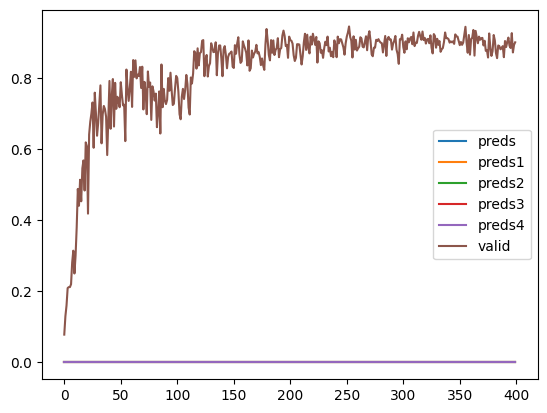

当前 [32, 0.0005, 10, 400, 25]
[0.9643811219946572, 0.9305431878895815, 0.9447907390917186]
0.9465716829919858
===
[0.9623664373851835, 0.9311478910230688, 0.9342348720911253]
0.942583066833126
===
[0.9594921526477591, 0.9378677854055428, 0.9409110358240793]
0.9460903246257937
===
[0.9672635818534749, 0.927907706939893, 0.9367637956521815]
0.9439783614818498
===


In [14]:
def _freeze_norm_stats(net):
    for m in net.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
lr = 0.0001
batch_size = 8
train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop((224,224), scale=(0.75, 1.0)),
        transforms.RandomRotation((-15,15)),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(),
    ])
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

average_valid_results = []
average_f1_results = []
average_recall_results = []
average_precision_results = []

average_test_results = []
average_f1_results_test = []
average_recall_results_test = []
average_precision_results_test = []

for config in [[32,0.0005,10,400,25]]:
    
    alphas = [1,1,1,10]
    
    alpha1,alpha2,alpha3,alpha4 = alphas
    average_valid_results = []
    average_f1_results = []
    average_recall_results = []
    average_precision_results = []

    average_test_results = []
    average_f1_results_test = []
    average_recall_results_test = []
    average_precision_results_test = []
    for seed in [2,1,0]:
        distill_flag = False
        batch_size,lr,warmupepoch,epoch_num,select_batch_num = config
        alpha = 1
        
        lrcounter = 0
        seed4batch = seed
        T = 2
        cudnn.benchmark = False
        cudnn.deterministic = True
        torch.manual_seed(seed)  # 为CPU设置随机种子
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # 为所有GPU设置随机种子
        random.seed(seed)
        np.random.seed(seed)



        def get_num_correct(out, labels):  #求准确率
            return out.argmax(dim=1).eq(labels).sum().item()

        
        teacher = MSFIN_teacher().cuda()
        best_model_path = '/kaggle/input/auc-stage1/best'+str(seed)+'.pkl'  # 替换为实际的模型路径
        teacher.load_state_dict(torch.load(best_model_path))
        
        for p in teacher.parameters():
            p.requires_grad = False
        
        model_generator = MSFIN(teacher).cuda()
        

        optimizer_generator = torch.optim.Adam(model_generator.parameters(),lr=lr)
        
        scheduler_warmup_generator = GradualWarmupScheduler(optimizer_generator, multiplier=1, total_epoch=warmupepoch)
        optimizer_generator.zero_grad()
        optimizer_generator.step()
        
        
        maxval=0
        maxtest_followmaxval=0
        maxf1_followmaxval = 0
        maxrecall_followmaxval = 0
        maxprecision_followmaxval = 0
        
        maxf1_followmaxval_test = 0
        maxrecall_followmaxval_test = 0
        maxprecision_followmaxval_test = 0
        
        
        finaltestlabel_followmaxval = []
        finaltestlabel_pred_followmaxval = []

        earlystopcounter = 0

        T = 10
        minvalidloss = 99999

        val_loss_curve = []
        val_acc_curve = []
        test_acc_curve = []
        
        train_acc_1 = []
        train_acc_2 = []
        train_acc_3 = []
        train_acc_4 = []
        train_acc_5 = []
        
        idxlist = [i for i in range(train_len)]
        
        flag1 = 0
        flag2 = 0
        warm_end = False
        
        train_warmup_counter = 0
        max_train_acc = 0
        for epoch in tqdm(range(1,epoch_num+1)):

            scheduler_warmup_generator.step()
            np.random.seed(seed)
            np.random.shuffle(idxlist)
            
            total_loss=0
            total_loss1 = 0
            total_loss3 = 0
            valid_loss = 0
            train_correct=0
            test_correct = 0
            val_correct=0
            
            #model_generator.apply(_freeze_norm_stats)

            
            train_counter = 0
            
            #train_all = 0
            
            train_correct1 = 0
            train_correct2 = 0
            train_correct3 = 0
            train_correct4 = 0
            train_correct5 = 0
            
            def getBatch(len_dataset,batch_size):
                batch_num = len_dataset // batch_size
                batch_res = len_dataset % batch_size

                if batch_res>0:
                    batchlist = [batch_size] * batch_num + [batch_res]
                else:
                    batchlist = [batch_size] * batch_num
                return batchlist
            train_batch_list = getBatch(train_len,batch_size)
            
            for idx,b in enumerate(train_batch_list[:select_batch_num]):
                start = 0+sum(train_batch_list[:idx])
                end = 0+sum(train_batch_list[:idx+1])
                batchidxlist = idxlist[start:end]
                
            
                x = []
                y = []
                y2 = []
                for image_inbatch_id in batchidxlist:
                    d = trainset[image_inbatch_id]
                    x.append(train_transform(d[0]))
                    y.append(d[1])
                    y2.append(d[2])
                
                images = torch.stack(x,0).cuda()
                
                
                labels = torch.LongTensor(y).cuda()
                labels2 = torch.LongTensor(y2).cuda()
                
                model_generator.train()
                preds,loss = model_generator(images,labels)

                optimizer_generator.zero_grad()

                if distill_flag:
                    loss = F.cross_entropy(preds,labels) + loss
                else:
                    loss = F.cross_entropy(preds,labels)



                loss.backward()
                optimizer_generator.step()
    
                
                total_loss+=loss.item()
                total_loss1+=loss.item()
                total_loss3+=loss.item()
                train_correct+=get_num_correct(preds,labels)
            
            print('***训练集***')
            print(train_correct / select_batch_num / 32)
            #print('main branch：',train_correct1/select_batch_num/32)
            if train_correct / select_batch_num / 32 >= max_train_acc:
                max_train_acc = train_correct / select_batch_num / 32
                train_warmup_counter = 0
            else:
                train_warmup_counter += 1
                if train_warmup_counter == 10:
                    distill_flag = True
                    print('开始蒸馏')

            
            valid_preds = []
            valid_labels = []
                
            model_generator.eval()
            with torch.no_grad():
                validxlist = [i for i in range(valid_len)]
                valid_batch_list = getBatch(valid_len,batch_size)
                
                for idx,b in enumerate(valid_batch_list):
                    start = 0+sum(valid_batch_list[:idx])
                    end = 0+sum(valid_batch_list[:idx+1])
                    batchidxlist = validxlist[start:end]

                    x = []
                    y = []
                    y2 = []
                    for image_inbatch_id in batchidxlist:
                        #im_o = 
                        d = validset[image_inbatch_id]
                        #print()
                        x.append(test_transform(d[0]))
                        y.append(d[1])
                        y2.append(d[2])

                    images = torch.stack(x,0).cuda()#.permute(0,3,1,2) / 255
                    labels = torch.LongTensor(y).cuda()
                    #mask,preds3 = stage1(premodel,images)
                    #images = (images)

                    preds,_ = model_generator(images,labels)

                    #preds = model(images)
                    loss = F.cross_entropy(preds,labels)
                    
                    valid_loss+=loss.item()
                    val_correct+=get_num_correct(preds,labels)
                    
                    valid_preds += preds.argmax(-1).cpu().numpy().tolist()
                    valid_labels += y
            '''if val_correct/valid_len >= 0.85 and not warm_end:
                print('预热结束')
                warm_end = True'''
            F1=f1_score(valid_labels,valid_preds,average="macro")
            print("valid-f1:",F1)
            precision=precision_score(valid_labels,valid_preds,average="macro")
            print("valid-precision:",precision)
            recall=recall_score(valid_labels,valid_preds,average="macro")
            print("valid-recall:",recall)
            
            print('process:',epoch," loss:",total_loss," train_correct:",train_correct/train_len,'valid_loss',valid_loss," val_correct:",val_correct/valid_len)
            train_acc = train_correct/train_len
            val_acc=val_correct/valid_len
            
            train_acc_1.append(train_correct1/train_all)
            train_acc_2.append(train_correct2/train_all)
            train_acc_3.append(train_correct3/train_all)
            train_acc_4.append(train_correct4/train_all)
            train_acc_5.append(train_correct5/train_all)
            val_loss_curve.append(valid_loss)
            val_acc_curve.append(val_acc)
            #test_acc_curve.append(test_acc)
            
            
            
            
            if val_acc > maxval:
                
                maxval = val_acc
                maxf1_followmaxval = F1
                maxrecall_followmaxval = recall
                maxprecision_followmaxval = precision

                
                earlystopcounter = 0
                torch.save(model_generator.state_dict(), 'best'+str(seed)+'.pkl')
                print('The model has been saved!!')
                print('The best val_acc is ',maxval)
            '''else:
                earlystopcounter += 1
                if earlystopcounter == 10:
                    print('早停')
                    print('The best val_acc is ',maxval,'The best test_acc is ',best_test_acc)
                    break'''
        x = range(len(val_loss_curve))


        plt.figure()
        
        plt.plot(x, train_acc_1,label = 'preds')
        plt.plot(x, train_acc_2,label = 'preds1')
        plt.plot(x, train_acc_3,label = 'preds2')
        plt.plot(x, train_acc_4,label = 'preds3')
        plt.plot(x, train_acc_5,label = 'preds4')

        plt.plot(x, val_acc_curve,label = 'valid')

        plt.legend()
        plt.show()
        average_valid_results.append(maxval)
        average_f1_results.append(maxf1_followmaxval)
        average_recall_results.append(maxrecall_followmaxval)
        average_precision_results.append(maxprecision_followmaxval)

    def summary(average_valid_results):
        print(average_valid_results)
        print(sum(average_valid_results)/len(average_valid_results))
        print('===')

    print('当前',config)
    summary(average_valid_results)
    summary(average_f1_results)
    summary(average_recall_results)
    summary(average_precision_results)

